### Musings


####

1) Use cases
2) How to turn it into a program
3) turn it into actionable information
4) cashapp use case
5) investments  / others using MCC - pair with descriptions

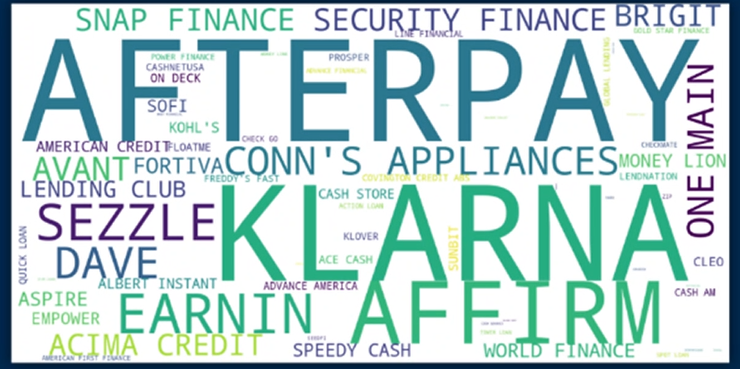

# Setup

## 1 - Import

In [5]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import glob
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta
import re

# For visualization (if needed later)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

## 2 - File Configuration


In [ ]:
# Configuration
CLIENT_ID = '1776'
CLIENT_NAME = 'CoastHills'
RECENT_MONTHS = 12

# Base paths
BASE_PATH = Path(r"M:\ARS")
RAW_DATA_PATH = BASE_PATH / "Incoming" / "Transaction Files"
CLIENT_PATH = RAW_DATA_PATH / f"{CLIENT_ID} - {CLIENT_NAME}"


# ------------------------------------------------------------
# Auto-discover and split files by parsed date
# ------------------------------------------------------------
def is_year_folder(path: Path) -> bool:
    return path.is_dir() and path.name.isdigit() and len(path.name) == 4

def parse_file_date(filepath: Path) -> datetime | None:
    """
    Extract date from transaction filenames. Supports two patterns:
      1. Connex-style:    1453_trans-01312026.csv     -> trans-MMDDYYYY
      2. CoastHills-style: 1776_30825_[2026.02.01][11.00.41]_monthlytran  -> [YYYY.MM.DD]
    """
    name = filepath.stem
    # Pattern 1: trans-MMDDYYYY
    match = re.search(r'trans-(\d{8})$', name)
    if match:
        return datetime.strptime(match.group(1), '%m%d%Y')
    # Pattern 2: [YYYY.MM.DD]
    match = re.search(r'\[(\d{4})\.(\d{2})\.(\d{2})\]', name)
    if match:
        return datetime(int(match.group(1)), int(match.group(2)), int(match.group(3)))
    return None

if not CLIENT_PATH.exists():
    raise FileNotFoundError(f"Client root path not found: {CLIENT_PATH}")

year_folders = [p for p in CLIENT_PATH.iterdir() if is_year_folder(p)]

# 1) Gather ALL files across all year folders (any extension)
all_files = []
for year_path in year_folders:
    all_files.extend([f for f in year_path.iterdir() if f.is_file()])

# Also check client folder root (in case no year subfolders)
if len(all_files) == 0:
    all_files.extend([f for f in CLIENT_PATH.iterdir() if f.is_file()])
    if all_files:
        print(f"Found {len(all_files)} files directly in client folder (no year subfolders)")

# 2) Define the 12-month window (last 12 completed months)
now = datetime.now()
first_of_current_month = datetime(now.year, now.month, 1)
start_12 = first_of_current_month - relativedelta(months=RECENT_MONTHS)
end_12 = first_of_current_month - relativedelta(days=1)

# 3) Split: most recent 12 files = recent, everything else = older
dated_files = []
unparsed_files = []

for f in all_files:
    file_date = parse_file_date(f)
    if file_date is None:
        unparsed_files.append(f)
    else:
        dated_files.append((f, file_date))

# Sort by date descending, take top 12
dated_files.sort(key=lambda x: x[1], reverse=True)
recent_files = [f for f, _ in dated_files[:RECENT_MONTHS]]
older_files = [f for f, _ in dated_files[RECENT_MONTHS:]]

# 4) Quick summary
print(f"Client path:        {CLIENT_PATH}")
print(f"Year folders found: {sorted([p.name for p in year_folders])}")
print(f"Total files:        {len(all_files)}")
if dated_files:
    print(f"  Date range:       {dated_files[-1][1]:%Y-%m-%d} to {dated_files[0][1]:%Y-%m-%d}")
    print(f"  Sample file:      {dated_files[0][0].name}")
print(f"Recent ({RECENT_MONTHS}mo):     {len(recent_files)}  ({start_12:%Y-%m-%d} to {end_12:%Y-%m-%d})")
print(f"Older:              {len(older_files)}")
if unparsed_files:
    print(f"Unparsed:           {len(unparsed_files)}")
    for u in unparsed_files[:5]:
        print(f"  {u.name}")

## 3 - Discover all files in the client folder


In [19]:
# Discover all files in the client folder
all_files = list(CLIENT_PATH.glob(f'**/*.{FILE_EXTENSION}'))
print(f"Found {len(all_files)} files:\n")
for file in sorted(all_files):
    file_size = file.stat().st_size / 1024  # Size in KB
    print(f"  • {file.name} ({file_size:.1f} KB)")

# Identify file extensions
extensions = set([f.suffix.lower() for f in all_files if f.is_file()])
print(f"\nFile types found: {extensions}")

Found 12 files:

  • 1453_32397_[2025.02.04][10.47.04]_debit_card_trans-01312025.csv (56669.7 KB)
  • 1453_32397_[2025.03.04][09.01.41]_debit_card_trans-02282025.csv (52990.9 KB)
  • 1453_32397_[2025.04.03][12.52.27]_1560.0331.82330.debit_card_trans-03312025.csv (61823.0 KB)
  • 1453_32397_[2025.05.06][15.55.56]_1560.0430.96269.debit_card_trans-04302025.csv (60156.2 KB)
  • 1453_32397_[2025.06.02][11.37.32]_1560.0531.110111.debit_card_trans-05312025.csv (62705.5 KB)
  • 1453_32397_[2025.07.08][17.04.38]_1560.0630.123481.debit_card_trans-06302025.csv (60814.0 KB)
  • 1453_32397_[2025.08.05][11.38.28]_debit_card_trans-07312025.csv (62389.1 KB)
  • 1453_32397_[2025.09.04][14.55.49]_1560.0831.151853.debit_card_trans-08312025.csv (63128.1 KB)
  • 1453_32397_[2025.10.06][12.41.13]_1560.0930.165285.debit_card_trans-09302025.csv (59503.9 KB)
  • 1453_32397_[2025.11.05][17.07.18]_1560.1031.179227.debit_card_trans-10312025.csv (62713.6 KB)
  • 1453_32397_[2025.12.08][16.10.00]_1560.1130.192118.d

## 4 - Define Data Loading Functions

In [21]:
def load_transaction_file(filepath):
    """
    Load a debit card transaction file
    """
    filepath = Path(filepath)
    
    # Skip the metadata header line, read tab-delimited data
    df = pd.read_csv(filepath, sep='\t', skiprows=1, header=None, low_memory=False)
    
    # Assign column names based on the file definition document
    df.columns = [
        'transaction_date',      # Date of Transaction (MM/DD/YYYY)
        'primary_account_num',   # Primary account number (hashed)
        'transaction_type',      # PIN, SIG, ACH, CHK
        'amount',               # Transaction amount
        'mcc_code',             # Merchant Category Code
        'merchant_name',        # Merchant name
        'terminal_location_1',  # Terminal location/address
        'terminal_location_2',  # Additional location info
        'terminal_id',          # Terminal ID
        'merchant_id',          # Merchant ID  
        'institution',          # Institution number
        'card_present',         # Y/N indicator
        'transaction_code'      # Transaction code
    ][:len(df.columns)]  # Only use as many names as there are columns
    
    # Add metadata
    df['source_file'] = filepath.name
    
    return df

# Load all transaction files
transaction_files = []
files_to_load = sorted(CLIENT_PATH.glob(f'**/*.{FILE_EXTENSION}'))
print(f"Loading {len(files_to_load)} transaction files...\n")

for file_path in files_to_load:
    df = load_transaction_file(file_path)
    transaction_files.append(df)
    print(f"✓ Loaded: {file_path.name} ({len(df):,} rows)")

print(f"\n{'='*50}")
print(f"Total transactions loaded: {sum(len(df) for df in transaction_files):,}")

Loading 12 transaction files...

✓ Loaded: 1453_32397_[2025.02.04][10.47.04]_debit_card_trans-01312025.csv (431,894 rows)
✓ Loaded: 1453_32397_[2025.03.04][09.01.41]_debit_card_trans-02282025.csv (403,808 rows)
✓ Loaded: 1453_32397_[2025.04.03][12.52.27]_1560.0331.82330.debit_card_trans-03312025.csv (470,893 rows)
✓ Loaded: 1453_32397_[2025.05.06][15.55.56]_1560.0430.96269.debit_card_trans-04302025.csv (457,997 rows)
✓ Loaded: 1453_32397_[2025.06.02][11.37.32]_1560.0531.110111.debit_card_trans-05312025.csv (477,470 rows)
✓ Loaded: 1453_32397_[2025.07.08][17.04.38]_1560.0630.123481.debit_card_trans-06302025.csv (462,857 rows)
✓ Loaded: 1453_32397_[2025.08.05][11.38.28]_debit_card_trans-07312025.csv (474,783 rows)
✓ Loaded: 1453_32397_[2025.09.04][14.55.49]_1560.0831.151853.debit_card_trans-08312025.csv (480,621 rows)
✓ Loaded: 1453_32397_[2025.10.06][12.41.13]_1560.0930.165285.debit_card_trans-09302025.csv (453,177 rows)
✓ Loaded: 1453_32397_[2025.11.05][17.07.18]_1560.1031.179227.debit

## 5 - Combine 

In [25]:
# Combine all dataframes
combined_df = pd.concat(transaction_files, ignore_index=True)

# Convert data types
combined_df['amount'] = combined_df['amount'].astype(float)
if combined_df['amount'].median() < 0:
    combined_df['amount'] = combined_df['amount'].abs()


# Dataset overview
print(f"Combined Dataset Overview:")
print(f"{'='*50}")
print(f"Total Shape: {combined_df.shape}")
print(f"Total Transactions: {len(combined_df):,}")
print(f"Total Columns: {combined_df.shape[1]}")
print(f"Memory Usage: {combined_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nDate Range: {combined_df['transaction_date'].min()} to {combined_df['transaction_date'].max()}")
print(f"Unique Accounts: {combined_df['primary_account_num'].nunique():,}")
print(f"Unique Merchants: {combined_df['merchant_name'].nunique():,}")
print(f"Total Transaction Value: ${combined_df['amount'].sum():,.2f}")

Combined Dataset Overview:
Total Shape: (5525537, 13)
Total Transactions: 5,525,537
Total Columns: 13
Memory Usage: 3484.83 MB

Date Range: 1/10/2025 to 9/9/2025
Unique Accounts: 19,005
Unique Merchants: 646,751
Total Transaction Value: $253,913,318.67


In [26]:
# Check what columns we actually have in the combined dataframe
print("Current columns in combined_df:")
print(combined_df.columns.tolist())

Current columns in combined_df:
['transaction_date', 'primary_account_num', 'transaction_type', 'amount', 'mcc_code', 'merchant_name', 'terminal_location_1', 'terminal_location_2', 'terminal_id', 'merchant_id', 'institution', 'card_present', 'source_file']


# Data Prep

## Merchant Name Consolidation

In [27]:
"""
UNIVERSAL MERCHANT CONSOLIDATION FUNCTION
==========================================
Works across all clients to consolidate common merchant name variations.
Add this to your notebook and use it in your merchant analysis sections.
"""

def standardize_merchant_name(merchant_name):
    """
    Consolidate duplicate merchant variations across all clients.
    Returns standardized merchant name for cleaner analysis.
    """
    # Normalize: strip whitespace, convert to uppercase
    merchant_upper = str(merchant_name).strip().upper()
    
    # Remove extra spaces (multiple spaces → single space)
    merchant_upper = ' '.join(merchant_upper.split())
    
    # ============================================================================
    # TECH & DIGITAL SERVICES
    # ============================================================================
    
    # Apple
    if 'APPLE.COM' in merchant_upper or 'APPLE COM' in merchant_upper:
        return 'APPLE.COM/BILL'
    
    if 'APPLE CASH' in merchant_upper:
        if 'SENT MONEY' in merchant_upper:
            return 'APPLE CASH - SENT MONEY'
        elif 'INST XFER' in merchant_upper or 'TRANSFER' in merchant_upper:
            return 'APPLE CASH - TRANSFERS'
        elif 'BALANCE ADD' in merchant_upper:
            return 'APPLE CASH - BALANCE ADD'
        return 'APPLE CASH'
    
    if 'APPLE' in merchant_upper and 'STORE' in merchant_upper:
        return 'APPLE STORE'
    
    # Google
    if 'GOOGLE' in merchant_upper:
        if 'PLAY' in merchant_upper:
            return 'GOOGLE PLAY'
        if 'STORAGE' in merchant_upper or 'DRIVE' in merchant_upper:
            return 'GOOGLE STORAGE'
        if 'YOUTUBE' in merchant_upper:
            return 'YOUTUBE'
        return 'GOOGLE'
    
    # Amazon
    if 'AMAZON' in merchant_upper:
        if 'PRIME' in merchant_upper:
            return 'AMAZON PRIME'
        if 'AMZN' in merchant_upper:
            return 'AMAZON'
        return 'AMAZON'
    
    if 'AMZN' in merchant_upper:
        return 'AMAZON'
    
    # Prime Video
    if 'PRIME VIDEO' in merchant_upper:
        return 'PRIME VIDEO'
    
    # Netflix
    if 'NETFLIX' in merchant_upper:
        return 'NETFLIX'
    
    # Streaming services
    if 'SPOTIFY' in merchant_upper:
        return 'SPOTIFY'
    
    if 'HULU' in merchant_upper:
        return 'HULU'
    
    if 'DISNEY' in merchant_upper and 'PLUS' in merchant_upper:
        return 'DISNEY+'
    
    if 'HBO' in merchant_upper or 'MAX' in merchant_upper:
        return 'HBO MAX'
    
    # PayPal
    if 'PAYPAL' in merchant_upper:
        if 'INST XFER' in merchant_upper or 'TRANSFER' in merchant_upper:
            return 'PAYPAL TRANSFERS'
        return 'PAYPAL'
    
    # Venmo
    if 'VENMO' in merchant_upper:
        return 'VENMO'
    
    # Zelle
    if 'ZELLE' in merchant_upper:
        return 'ZELLE'
    
    # Cash App
    if 'CASH APP' in merchant_upper or 'CASHAPP' in merchant_upper:
        return 'CASH APP'
    
    # ============================================================================
    # RETAIL - BIG BOX
    # ============================================================================
    
    # Walmart
    if 'WMT PLUS' in merchant_upper or 'WALMART PLUS' in merchant_upper:
        return 'WALMART PLUS'
    
    if 'WALMART' in merchant_upper or 'WAL-MART' in merchant_upper or 'WM SUPERCENTER' in merchant_upper:
        if 'WALMART.COM' in merchant_upper or 'WALMART COM' in merchant_upper:
            return 'WALMART.COM'
        return 'WALMART (ALL LOCATIONS)'
    
    # Target
    if 'TARGET' in merchant_upper and ('T-' in merchant_upper or 'STORE' in merchant_upper):
        return 'TARGET (ALL LOCATIONS)'
    
    # Costco
    if 'COSTCO' in merchant_upper:
        return 'COSTCO'
    
    # Sam's Club
    if 'SAMS CLUB' in merchant_upper or "SAM'S CLUB" in merchant_upper:
        return 'SAMS CLUB'
    
    # BJ's Wholesale
    if "BJ'S" in merchant_upper or 'BJS' in merchant_upper:
        return "BJ'S WHOLESALE"
    
    # ============================================================================
    # RETAIL - DOLLAR STORES
    # ============================================================================
    
    if 'DOLLAR TREE' in merchant_upper or merchant_upper == 'DOLLARTREE':
        return 'DOLLAR TREE'
    
    if 'DOLLAR GENERAL' in merchant_upper or merchant_upper == 'DOLLARGENERAL':
        return 'DOLLAR GENERAL'
    
    if 'FAMILY DOLLAR' in merchant_upper:
        return 'FAMILY DOLLAR'
    
    if 'FIVE BELOW' in merchant_upper or '5 BELOW' in merchant_upper:
        return 'FIVE BELOW'
    
    # ============================================================================
    # RETAIL - DEPARTMENT STORES
    # ============================================================================
    
    if 'BURLINGTON' in merchant_upper:
        return 'BURLINGTON'
    
    if 'KOHLS' in merchant_upper or "KOHL'S" in merchant_upper:
        return "KOHL'S"
    
    if 'MARSHALLS' in merchant_upper:
        return 'MARSHALLS'
    
    if 'TJ MAXX' in merchant_upper or 'TJMAXX' in merchant_upper:
        return 'TJ MAXX'
    
    if 'ROSS' in merchant_upper and 'DRESS' in merchant_upper:
        return 'ROSS DRESS FOR LESS'
    
    if 'NORDSTROM' in merchant_upper:
        return 'NORDSTROM'
    
    if "MACY'S" in merchant_upper or 'MACYS' in merchant_upper:
        return "MACY'S"
    
    # ============================================================================
    # RETAIL - SPECIALTY
    # ============================================================================
    
    if 'HOBBY LOBBY' in merchant_upper or 'HOBBYLOBBY' in merchant_upper:
        return 'HOBBY LOBBY'
    
    if 'MICHAELS' in merchant_upper and 'STORES' in merchant_upper:
        return 'MICHAELS'
    
    if 'HOME DEPOT' in merchant_upper or 'HOMEDEPOT' in merchant_upper:
        return 'HOME DEPOT'
    
    if "LOWE'S" in merchant_upper or 'LOWES' in merchant_upper:
        return "LOWE'S"
    
    if 'MENARDS' in merchant_upper:
        return 'MENARDS'
    
    if 'ACE HDWE' in merchant_upper or 'ACE HARDWARE' in merchant_upper:
        return 'ACE HARDWARE'
    
    if 'TRUE VALUE' in merchant_upper or 'TRUEVALUE' in merchant_upper:
        return 'TRUE VALUE'
    
    if 'BED BATH' in merchant_upper:
        return 'BED BATH & BEYOND'
    
    if 'BEST BUY' in merchant_upper or 'BESTBUY' in merchant_upper:
        return 'BEST BUY'
    
    if 'DICKS SPORTING' in merchant_upper or "DICK'S SPORTING" in merchant_upper:
        return 'DICKS SPORTING GOODS'
    
    if 'PETCO' in merchant_upper:
        return 'PETCO'
    
    if 'PETSMART' in merchant_upper:
        return 'PETSMART'
    
    # ============================================================================
    # ONLINE RETAIL
    # ============================================================================
    
    if 'TIKTOK' in merchant_upper and 'SHOP' in merchant_upper:
        return 'TIKTOK SHOP'
    
    if 'SHEIN' in merchant_upper:
        return 'SHEIN'
    
    if 'TEMU' in merchant_upper:
        return 'TEMU'
    
    if 'ETSY' in merchant_upper:
        return 'ETSY'
    
    if 'EBAY' in merchant_upper:
        return 'EBAY'
    
    if 'AFTERPAY' in merchant_upper:
        return 'AFTERPAY'
    
    if 'KLARNA' in merchant_upper:
        return 'KLARNA'
    
    if 'AFFIRM' in merchant_upper:
        return 'AFFIRM'
    
    # ============================================================================
    # GROCERS - REGIONAL
    # ============================================================================
    
    # Midwest
    if 'JEWEL' in merchant_upper and 'OSCO' in merchant_upper:
        return 'JEWEL-OSCO (ALL LOCATIONS)'
    
    if 'WOODMANS' in merchant_upper or 'WOODMAN' in merchant_upper:
        return 'WOODMANS FOOD MARKET (ALL LOCATIONS)'
    
    if 'MEIJER' in merchant_upper:
        return 'MEIJER (ALL LOCATIONS)'
    
    if 'HY-VEE' in merchant_upper or 'HYVEE' in merchant_upper:
        return 'HY-VEE'
    
    if 'SCHNUCKS' in merchant_upper:
        return 'SCHNUCKS'
    
    # Northeast
    if 'STOP & SHOP' in merchant_upper or 'STOP AND SHOP' in merchant_upper:
        return 'STOP & SHOP'
    
    if 'MARKET BASKET' in merchant_upper:
        return 'MARKET BASKET'
    
    if 'SHAWS' in merchant_upper or "SHAW'S" in merchant_upper:
        return "SHAW'S"
    
    if 'HANNAFORD' in merchant_upper:
        return 'HANNAFORD'
    
    if 'WEGMANS' in merchant_upper:
        return 'WEGMANS'
    
    if 'GIANT FOOD' in merchant_upper or 'GIANT EAGLE' in merchant_upper:
        return 'GIANT'
    
    # Southeast
    if 'PUBLIX' in merchant_upper:
        return 'PUBLIX'
    
    if 'KROGER' in merchant_upper:
        return 'KROGER'
    
    if 'HARRIS TEETER' in merchant_upper:
        return 'HARRIS TEETER'
    
    if 'FOOD LION' in merchant_upper:
        return 'FOOD LION'
    
    # West
    if 'ALBERTSONS' in merchant_upper:
        return 'ALBERTSONS'
    
    if 'SAFEWAY' in merchant_upper:
        return 'SAFEWAY'
    
    if 'VONS' in merchant_upper:
        return 'VONS'
    
    if 'RALPHS' in merchant_upper:
        return 'RALPHS'
    
    if 'FRED MEYER' in merchant_upper:
        return 'FRED MEYER'
    
    # National
    if 'WHOLE FOODS' in merchant_upper:
        return 'WHOLE FOODS'
    
    if 'TRADER JOE' in merchant_upper:
        return "TRADER JOE'S"
    
    if 'ALDI' in merchant_upper:
        return 'ALDI'
    
    if 'LIDL' in merchant_upper:
        return 'LIDL'
    
    if 'FRESH MARKET' in merchant_upper:
        return 'FRESH MARKET'
    
    # ============================================================================
    # GAS STATIONS / CONVENIENCE
    # ============================================================================
    
    if 'SPEEDWAY' in merchant_upper:
        return 'SPEEDWAY'
    
    if 'SHELL' in merchant_upper and ('SERVICE' in merchant_upper or 'OIL' in merchant_upper or merchant_upper.startswith('SHELL')):
        return 'SHELL'
    
    if 'MARATHON' in merchant_upper:
        return 'MARATHON'
    
    if 'BP' == merchant_upper or merchant_upper.startswith('BP '):
        return 'BP'
    
    if 'MOBIL' in merchant_upper or 'EXXON' in merchant_upper:
        return 'EXXON/MOBIL'
    
    if 'CHEVRON' in merchant_upper:
        return 'CHEVRON'
    
    if 'CITGO' in merchant_upper:
        return 'CITGO'
    
    if 'SUNOCO' in merchant_upper:
        return 'SUNOCO'
    
    if 'VALERO' in merchant_upper:
        return 'VALERO'
    
    if 'CIRCLE K' in merchant_upper or 'CIRCLEK' in merchant_upper:
        return 'CIRCLE K'
    
    if '7-ELEVEN' in merchant_upper or '7ELEVEN' in merchant_upper or '7 ELEVEN' in merchant_upper:
        return '7-ELEVEN'
    
    if 'WAWA' in merchant_upper:
        return 'WAWA'
    
    if 'SHEETZ' in merchant_upper:
        return 'SHEETZ'
    
    if 'QUICKTRIP' in merchant_upper or 'QT' in merchant_upper:
        return 'QUICKTRIP'
    
    if 'CUMBERLAND' in merchant_upper or 'SMARTREWARDS' in merchant_upper:
        return 'CUMBERLAND FARMS'
    
    if 'PILOT' in merchant_upper and ('FLYING' in merchant_upper or 'TRAVEL' in merchant_upper):
        return 'PILOT FLYING J'
    
    if "LOVE'S" in merchant_upper or 'LOVES' in merchant_upper:
        return "LOVE'S TRAVEL STOPS"
    
    # ============================================================================
    # RESTAURANTS - FAST FOOD
    # ============================================================================
    
    if 'MCDONALDS' in merchant_upper or "MCDONALD'S" in merchant_upper:
        return "MCDONALD'S"
    
    if 'BURGER KING' in merchant_upper:
        return 'BURGER KING'
    
    if "WENDY'S" in merchant_upper or 'WENDYS' in merchant_upper:
        return "WENDY'S"
    
    if 'TACO BELL' in merchant_upper:
        return 'TACO BELL'
    
    if 'CHIPOTLE' in merchant_upper:
        return 'CHIPOTLE'
    
    if 'SUBWAY' in merchant_upper:
        return 'SUBWAY'
    
    if 'CHICK-FIL-A' in merchant_upper or 'CHICKFILA' in merchant_upper:
        return 'CHICK-FIL-A'
    
    if 'POPEYES' in merchant_upper:
        return 'POPEYES'
    
    if 'KFC' in merchant_upper:
        return 'KFC'
    
    if 'PANERA' in merchant_upper:
        return 'PANERA BREAD'
    
    if 'JIMMY JOHN' in merchant_upper:
        return "JIMMY JOHN'S"
    
    if 'ARBY' in merchant_upper:
        return "ARBY'S"
    
    if 'SONIC' in merchant_upper and 'DRIVE' in merchant_upper:
        return 'SONIC DRIVE-IN'
    
    if 'FIVE GUYS' in merchant_upper:
        return 'FIVE GUYS'
    
    if 'CULVERS' in merchant_upper or "CULVER'S" in merchant_upper:
        return "CULVER'S"
    
    if 'PORTILLOS' in merchant_upper or "PORTILLO'S" in merchant_upper:
        return "PORTILLO'S"
    
    # ============================================================================
    # RESTAURANTS - CASUAL/DELIVERY
    # ============================================================================
    
    if 'STARBUCKS' in merchant_upper:
        return 'STARBUCKS'
    
    if 'DUNKIN' in merchant_upper:
        return 'DUNKIN'
    
    if 'TROPICAL SMOOTHIE' in merchant_upper:
        return 'TROPICAL SMOOTHIE CAFE'
    
    if 'SMOOTHIE KING' in merchant_upper:
        return 'SMOOTHIE KING'
    
    if 'JAMBA' in merchant_upper:
        return 'JAMBA JUICE'
    
    if 'DOORDASH' in merchant_upper:
        return 'DOORDASH'
    
    if 'UBER' in merchant_upper:
        if 'EATS' in merchant_upper:
            return 'UBER EATS'
        return 'UBER'
    
    if 'GRUBHUB' in merchant_upper:
        return 'GRUBHUB'
    
    if 'INSTACART' in merchant_upper:
        return 'INSTACART'
    
    # ============================================================================
    # UTILITIES
    # ============================================================================
    
    # Electric
    if 'COMED' in merchant_upper or 'COM ED' in merchant_upper:
        return 'COMED'
    
    if 'DUKE ENERGY' in merchant_upper:
        return 'DUKE ENERGY'
    
    if 'DOMINION' in merchant_upper and 'ENERGY' in merchant_upper:
        return 'DOMINION ENERGY'
    
    if 'NATIONAL GRID' in merchant_upper:
        return 'NATIONAL GRID'
    
    if 'EVERSOURCE' in merchant_upper:
        return 'EVERSOURCE'
    
    if 'AMEREN' in merchant_upper:
        return 'AMEREN'
    
    # Gas
    if 'NICOR' in merchant_upper:
        return 'NICOR GAS'
    
    if 'PEOPLES GAS' in merchant_upper:
        return 'PEOPLES GAS'
    
    if 'NATIONAL FUEL' in merchant_upper:
        return 'NATIONAL FUEL'
    
    # Water
    if 'WATER' in merchant_upper and ('DEPT' in merchant_upper or 'DEPARTMENT' in merchant_upper):
        return 'WATER UTILITY'
    
    if 'NARRAGANSETT' in merchant_upper:
        return 'NARRAGANSETT BAY (UTILITIES)'
    
    # ============================================================================
    # TELECOM
    # ============================================================================
    
    # Cable/Internet
    if 'COMCAST' in merchant_upper or 'XFINITY' in merchant_upper:
        return 'COMCAST/XFINITY'
    
    if 'SPECTRUM' in merchant_upper:
        return 'SPECTRUM'
    
    if 'COX' in merchant_upper and ('CABLE' in merchant_upper or 'COMM' in merchant_upper):
        return 'COX COMMUNICATIONS'
    
    if 'VERIZON FIOS' in merchant_upper:
        return 'VERIZON FIOS'
    
    # Wireless
    if 'ATT*' in merchant_upper or 'AT&T' in merchant_upper or 'AT T' in merchant_upper:
        if 'BILL' in merchant_upper or 'PAYMENT' in merchant_upper or 'AUTOPAY' in merchant_upper:
            return 'AT&T'
        return 'AT&T'
    
    if 'TMOBILE' in merchant_upper or 'T-MOBILE' in merchant_upper or 'T MOBILE' in merchant_upper:
        return 'T-MOBILE'
    
    if 'VERIZON' in merchant_upper and 'WIRELESS' in merchant_upper:
        return 'VERIZON WIRELESS'
    
    if 'SPRINT' in merchant_upper:
        return 'SPRINT'
    
    if 'CRICKET' in merchant_upper and 'WIRELESS' in merchant_upper:
        return 'CRICKET WIRELESS'
    
    if 'BOOST MOBILE' in merchant_upper:
        return 'BOOST MOBILE'
    
    if 'METRO' in merchant_upper and ('PCS' in merchant_upper or 'MOBILE' in merchant_upper):
        return 'METRO BY T-MOBILE'
    
    # ============================================================================
    # INSURANCE
    # ============================================================================
    
    if 'STATE FARM' in merchant_upper:
        return 'STATE FARM'
    
    if 'GEICO' in merchant_upper:
        return 'GEICO'
    
    if 'PROGRESSIVE' in merchant_upper:
        return 'PROGRESSIVE'
    
    if 'ALLSTATE' in merchant_upper:
        return 'ALLSTATE'
    
    if 'FARMERS' in merchant_upper and 'INSURANCE' in merchant_upper:
        return 'FARMERS INSURANCE'
    
    if 'LIBERTY MUTUAL' in merchant_upper:
        return 'LIBERTY MUTUAL'
    
    if 'NATIONWIDE' in merchant_upper:
        return 'NATIONWIDE'
    
    if 'USAA' in merchant_upper:
        return 'USAA'
    
    if 'AMERICAN FAMILY' in merchant_upper:
        return 'AMERICAN FAMILY INSURANCE'
    
    # ============================================================================
    # TOLLS
    # ============================================================================
    
    if 'E-ZPASS' in merchant_upper or 'EZPASS' in merchant_upper or 'EZ PASS' in merchant_upper:
        return 'E-ZPASS'
    
    if 'IL TOLLWAY' in merchant_upper or 'ILLINOIS TOLLWAY' in merchant_upper or 'I-PASS' in merchant_upper:
        return 'ILLINOIS TOLLWAY'
    
    if 'SUNPASS' in merchant_upper:
        return 'SUNPASS'
    
    if 'FASTRAK' in merchant_upper:
        return 'FASTRAK'
    
    if 'TOLL' in merchant_upper and ('ROAD' in merchant_upper or 'AUTHORITY' in merchant_upper):
        return 'TOLL AUTHORITY'
    
    # ============================================================================
    # FINANCIAL SERVICES
    # ============================================================================
    
    # Alt Finance
    if 'DAVE' in merchant_upper and ('INC' in merchant_upper or 'APP' in merchant_upper):
        return 'DAVE'
    
    if 'CHIME' in merchant_upper:
        return 'CHIME'
    
    if 'VARO' in merchant_upper:
        return 'VARO'
    
    if 'CURRENT' in merchant_upper and 'CARD' in merchant_upper:
        return 'CURRENT'
    
    if 'FLEX FINANCE' in merchant_upper or 'FLEXFINANCE' in merchant_upper:
        return 'FLEX FINANCE'
    
    if 'EARNIN' in merchant_upper:
        return 'EARNIN'
    
    if 'BRIGIT' in merchant_upper:
        return 'BRIGIT'
    
    if 'POSSIBLE FINANCE' in merchant_upper:
        return 'POSSIBLE FINANCE'
    
    # Traditional Banks
    if 'CHASE' in merchant_upper and ('BANK' in merchant_upper or 'CARD' in merchant_upper or 'PAYMENT' in merchant_upper):
        return 'CHASE'
    
    if 'BANK OF AMERICA' in merchant_upper or 'BOFA' in merchant_upper:
        return 'BANK OF AMERICA'
    
    if 'WELLS FARGO' in merchant_upper:
        return 'WELLS FARGO'
    
    if 'CITIBANK' in merchant_upper or 'CITI CARD' in merchant_upper:
        return 'CITIBANK'
    
    if 'US BANK' in merchant_upper or 'U.S. BANK' in merchant_upper:
        return 'US BANK'
    
    if 'PNC BANK' in merchant_upper:
        return 'PNC'
    
    if 'TD BANK' in merchant_upper:
        return 'TD BANK'
    
    if 'CAPITAL ONE' in merchant_upper:
        return 'CAPITAL ONE'
    
    if 'DISCOVER' in merchant_upper and ('CARD' in merchant_upper or 'PAYMENT' in merchant_upper):
        return 'DISCOVER'
    
    if 'AMEX' in merchant_upper or 'AMERICAN EXPRESS' in merchant_upper:
        return 'AMERICAN EXPRESS'
    
    if 'SYNCHRONY' in merchant_upper:
        return 'SYNCHRONY'
    
    # Lending
    if 'ONEMAIN' in merchant_upper or 'ONE MAIN' in merchant_upper:
        return 'ONEMAIN FINANCIAL'
    
    if 'LENDING CLUB' in merchant_upper:
        return 'LENDING CLUB'
    
    if 'SOFI' in merchant_upper:
        return 'SOFI'
    
    if 'UPSTART' in merchant_upper:
        return 'UPSTART'
    
    if 'ROCKET' in merchant_upper and ('MORTGAGE' in merchant_upper or 'LOANS' in merchant_upper):
        return 'ROCKET MORTGAGE'
    
    # Student Loans
    if 'DEPT EDUCATION' in merchant_upper or 'DEPARTMENT OF EDUCATION' in merchant_upper or 'ED FINANCIAL' in merchant_upper:
        return 'DEPT OF EDUCATION (STUDENT LOANS)'
    
    if 'NAVIENT' in merchant_upper:
        return 'NAVIENT'
    
    if 'NELNET' in merchant_upper:
        return 'NELNET'
    
    if 'GREAT LAKES' in merchant_upper and 'LOAN' in merchant_upper:
        return 'GREAT LAKES (STUDENT LOANS)'
    
    if 'MOHELA' in merchant_upper:
        return 'MOHELA'
    
    # ============================================================================
    # GAMING / BETTING
    # ============================================================================
    
    if 'FANDUEL' in merchant_upper:
        return 'FANDUEL'
    
    if 'DRAFTKINGS' in merchant_upper:
        return 'DRAFTKINGS'
    
    if 'BETMGM' in merchant_upper:
        return 'BETMGM'
    
    if 'CAESARS' in merchant_upper and ('SPORTSBOOK' in merchant_upper or 'CASINO' in merchant_upper):
        return 'CAESARS SPORTSBOOK'
    
    if 'POINTSBET' in merchant_upper:
        return 'POINTSBET'
    
    if 'BETRIVERS' in merchant_upper:
        return 'BETRIVERS'
    
    if 'BARSTOOL' in merchant_upper and 'SPORTSBOOK' in merchant_upper:
        return 'BARSTOOL SPORTSBOOK'
    
    if 'BETFAIR' in merchant_upper:
        return 'BETFAIR'
    
    if 'ILLINOIS STATE LOTTERY' in merchant_upper or 'IL LOTTERY' in merchant_upper:
        return 'ILLINOIS STATE LOTTERY'
    
    # ============================================================================
    # GOVERNMENT / MUNICIPAL
    # ============================================================================
    
    if merchant_upper.startswith('TOWN OF'):
        return 'MUNICIPAL PAYMENTS (TOWNS)'
    
    if merchant_upper.startswith('CITY OF'):
        return 'MUNICIPAL PAYMENTS (CITIES)'
    
    if 'COMMONWEALTH' in merchant_upper and 'SEC OF MA' in merchant_upper:
        return 'COMMONWEALTH OF MA'
    
    if 'IRS' in merchant_upper and ('TAX' in merchant_upper or 'PAYMENT' in merchant_upper):
        return 'IRS (TAX PAYMENTS)'
    
    if 'DMV' in merchant_upper or ('MOTOR VEHICLE' in merchant_upper and 'DEPT' in merchant_upper):
        return 'DMV'
    
    # ============================================================================
    # HEALTHCARE
    # ============================================================================
    
    if 'BLUE CROSS' in merchant_upper or 'BCBS' in merchant_upper:
        return 'BLUE CROSS BLUE SHIELD'
    
    if 'UNITED HEALTHCARE' in merchant_upper or 'UNITEDHEALTHCARE' in merchant_upper:
        return 'UNITED HEALTHCARE'
    
    if 'AETNA' in merchant_upper:
        return 'AETNA'
    
    if 'CIGNA' in merchant_upper:
        return 'CIGNA'
    
    if 'HUMANA' in merchant_upper:
        return 'HUMANA'
    
    if 'KAISER' in merchant_upper:
        return 'KAISER PERMANENTE'
    
    if 'CVS' in merchant_upper and 'PHARMACY' in merchant_upper:
        return 'CVS PHARMACY'
    
    if 'WALGREENS' in merchant_upper:
        return 'WALGREENS'
    
    if 'RITE AID' in merchant_upper:
        return 'RITE AID'

     
    # ============================================================================
    # Auto Loan Companies
    # ============================================================================
    
    if 'GM FINANCIAL' in merchant_upper:
        return 'GM FINANCIAL'
    
    if 'SANTANDER CONSUMER' in merchant_upper:
        return 'SANTANDER CONSUMER'
    
    if 'NISSAN MOTOR ACCEPTANCE' in merchant_upper:
        return 'NISSAN MOTOR ACCEPTANCE'
    
    if 'MAZDA FINANCIAL' in merchant_upper:
        return 'MAZDA FINANCIAL'
    
    if 'TOYOTA FINANCIAL' in merchant_upper:
        return 'TOYOTA FINANCIAL'
    
    if 'FORD MOTOR CREDIT' in merchant_upper:
        return 'FORD MOTOR CREDIT'
    
    if 'HONDA FINANCE' in merchant_upper:
        return 'HONDA FINANCE'
        
    # ============================================================================
    # If no match, return original
    # ============================================================================
    return merchant_name

## COnsolidation Summary 

In [28]:
# ===========================================================================
# DATA PREPARATION - MERCHANT NAME CONSOLIDATION
# ===========================================================================
"""
## Data Preparation - Merchant Consolidation
Standardizes merchant names to consolidate variations and improve analysis quality.
Examples:
  - "WALMART.COM", "WAL-MART #3893", "WM SUPERCENTER" → "WALMART (ALL LOCATIONS)"
  - "APPLE.COM/BILL", "APPLE COM BILL" → "APPLE.COM/BILL"
  - "NETFLIX.COM", "NETFLIX COM", "Netflix.com" → "NETFLIX"
"""
print("="*100)
print(" " * 30 + "MERCHANT NAME CONSOLIDATION")
print("="*100)

# Apply universal consolidation function
print("\nApplying merchant name standardization...")
combined_df['merchant_consolidated'] = combined_df['merchant_name'].apply(standardize_merchant_name)

# Calculate consolidation impact
original_count = combined_df['merchant_name'].nunique()
consolidated_count = combined_df['merchant_consolidated'].nunique()
reduction = original_count - consolidated_count
reduction_pct = (reduction / original_count) * 100

print(f"\n✓ Consolidation complete!")
print(f"  Original unique merchants: {original_count:,}")
print(f"  After consolidation: {consolidated_count:,}")
print(f"  Merchants consolidated: {reduction:,} ({reduction_pct:.1f}% reduction)")

# Show top consolidations (merchants with most variations)
print(f"\n" + "-"*100)
print("TOP 10 CONSOLIDATIONS (Merchants with Most Variations)")
print("-"*100)

consolidation_summary = combined_df.groupby('merchant_consolidated').agg({
    'merchant_name': 'nunique',
    'primary_account_num': 'nunique',
    'amount': 'sum',
    'transaction_date': 'count'
}).round(2)

consolidation_summary.columns = ['variations', 'unique_accounts', 'total_spend', 'transaction_count']
consolidation_summary = consolidation_summary[consolidation_summary['variations'] > 1]
consolidation_summary = consolidation_summary.sort_values('variations', ascending=False)

# Display top 10
top_10_consolidated = consolidation_summary.head(10)
display_df = pd.DataFrame({
    'Consolidated Merchant': top_10_consolidated.index,
    'Variations': top_10_consolidated['variations'].astype(int),
    'Accounts': top_10_consolidated['unique_accounts'].astype(int),
    'Total Spend': top_10_consolidated['total_spend'].apply(lambda x: f"${x:,.0f}"),
    'Transactions': top_10_consolidated['transaction_count'].astype(int)
})

display(display_df.style.hide(axis='index'))

# Show examples of what got consolidated for top 3
print(f"\n" + "-"*100)
print("EXAMPLES - Original Variations (Top 3 Consolidated Merchants)")
print("-"*100)

for merchant in consolidation_summary.head(3).index:
    variations = combined_df[combined_df['merchant_consolidated'] == merchant]['merchant_name'].unique()
    variation_count = len(variations)
    
    print(f"\n📦 {merchant}")
    print(f"   Consolidated {variation_count} variations:")
    
    for i, var in enumerate(sorted(variations)[:5], 1):
        print(f"   {i}. {var}")
    
    if variation_count > 5:
        print(f"   ... and {variation_count - 5} more variations")

print(f"\n" + "="*100)
print("✓ Data preparation complete - Ready for analysis")
print("="*100)

                              MERCHANT NAME CONSOLIDATION

Applying merchant name standardization...

✓ Consolidation complete!
  Original unique merchants: 646,751
  After consolidation: 236,340
  Merchants consolidated: 410,411 (63.5% reduction)

----------------------------------------------------------------------------------------------------
TOP 10 CONSOLIDATIONS (Merchants with Most Variations)
----------------------------------------------------------------------------------------------------



----------------------------------------------------------------------------------------------------
EXAMPLES - Original Variations (Top 3 Consolidated Merchants)
----------------------------------------------------------------------------------------------------

📦 AMAZON
   Consolidated 189802 variations:
   1.  A.E. Pharmacy LLC  Amzn.com/bill  WAUS
   2.  A.I. Amazon-Alph   Wilmington     DEUS
   3.  A.I. Amazon-Digi   Wilmington     DEUS
   4.  A.I. Amazon-Hear   Wilmington     DEUS
   5.  A.Z. Pharmacy LLC  Amzn.com/bill  WAUS
   ... and 189797 more variations

📦 DRAFTKINGS
   Consolidated 49306 variations:
   1.  DK*DRAFTKINGS222G  6179866744     MAUS
   2.  DK*DRAFTKINGS224C  6179866744     MAUS
   3.  DK*DRAFTKINGS2254  6179866744     MAUS
   4.  DK*DRAFTKINGS225C  6179866744     MAUS
   5.  DK*DRAFTKINGS226C  6179866744     MAUS
   ... and 49301 more variations

📦 AMAZON PRIME
   Consolidated 26323 variations:
   1.  AMAZON PRIME FR 246PAYLI2469664/  FRFR
   2.  AMAZON PRIME

# ODD Import

## Add ODD from month

In [ ]:
# Load ODD
odd_file = Path(r"M:\ARS\Raw Data\Ready for Analysis\2026.02\1776\1776-2026-02-CoastHills CU-ODD.xlsx")

print("Loading rewards file...")
rewards_df = pd.read_excel(odd_file)
print(f"Loaded: {len(rewards_df):,} rows, {len(rewards_df.columns)} columns")

# ODD Columns
print("\nColumns:")
for col in rewards_df.columns:
    print(f"  {col}")

## Identify P/B in OD


In [33]:
# ===========================================================================
# SECTION 3B: MERGE ODD DATA & CREATE BUSINESS/PERSONAL SPLITS
# ===========================================================================

# Clean up column names (remove leading/trailing spaces)
rewards_df.columns = rewards_df.columns.str.strip()

# Check business flag distribution
print(f"Business account distribution:")
print(rewards_df['Business?'].value_counts())

# Create a clean subset for merging
odd_subset = rewards_df[['Acct Number', 'Business?']].copy()
odd_subset.columns = ['account_number', 'business_flag']  # Rename to avoid issues

# Merge with transaction data
combined_df = combined_df.merge(
    odd_subset, 
    left_on='primary_account_num', 
    right_on='account_number',
    how='left'
)

# Drop the redundant account_number column
combined_df.drop('account_number', axis=1, inplace=True)

# Check merge results
print(f"\nMerge results:")
print(f"  Total transactions: {len(combined_df):,}")
print(f"  Matched to ODD: {combined_df['business_flag'].notna().sum():,}")
print(f"  Unmatched: {combined_df['business_flag'].isna().sum():,}")

# Check what the actual values are
print("\nBusiness flag unique values in merged data:")
print(combined_df['business_flag'].value_counts())

# Split into business and personal
business_df = combined_df[combined_df['business_flag'] == 'Yes'].copy()
personal_df = combined_df[combined_df['business_flag'] == 'No'].copy()

print(f"\nTransaction split:")
print(f"  Business transactions: {len(business_df):,} (${business_df['amount'].sum():,.2f})")
print(f"  Personal transactions: {len(personal_df):,} (${personal_df['amount'].sum():,.2f})")
print(f"  Unmatched transactions: {combined_df['business_flag'].isna().sum():,}")

# ===========================================================================
# CREATE YEAR_MONTH COLUMN FOR TIME-BASED ANALYSIS
# ===========================================================================

combined_df['transaction_date'] = pd.to_datetime(combined_df['transaction_date'])
business_df['transaction_date'] = pd.to_datetime(business_df['transaction_date'])
personal_df['transaction_date'] = pd.to_datetime(personal_df['transaction_date'])

# Create year_month column in all dataframes
if 'year_month' not in combined_df.columns:
    combined_df['year_month'] = combined_df['transaction_date'].dt.to_period('M')
    business_df['year_month'] = business_df['transaction_date'].dt.to_period('M')
    personal_df['year_month'] = personal_df['transaction_date'].dt.to_period('M')
    print(f"\n✓ Created year_month column for time-based analysis")

# ===========================================================================
# FINAL VERIFICATION
# ===========================================================================

print(f"\n✓ Verification:")
print(f"  combined_df has 'merchant_consolidated': {'merchant_consolidated' in combined_df.columns}")
print(f"  business_df has 'merchant_consolidated': {'merchant_consolidated' in business_df.columns}")
print(f"  personal_df has 'merchant_consolidated': {'merchant_consolidated' in personal_df.columns}")
print(f"  combined_df has 'year_month': {'year_month' in combined_df.columns}")
print(f"  business_df has 'year_month': {'year_month' in business_df.columns}")
print(f"  personal_df has 'year_month': {'year_month' in personal_df.columns}")

if 'merchant_consolidated' not in business_df.columns:
    print("\n⚠️ WARNING: merchant_consolidated column missing!")
    print("   Make sure Section 2 (Data Prep) ran before Section 3!")
elif 'year_month' not in business_df.columns:
    print("\n⚠️ WARNING: year_month column missing!")
    print("   This should not happen - check the code above!")
else:
    print(f"\n✓ Ready for analysis!")
    print(f"  Business unique merchants (consolidated): {business_df['merchant_consolidated'].nunique():,}")
    print(f"  Personal unique merchants (consolidated): {personal_df['merchant_consolidated'].nunique():,}")
    print(f"  Total months in dataset: {combined_df['year_month'].nunique()}")

Business account distribution:
Business?
No     55872
Yes     1480
Name: count, dtype: int64

Merge results:
  Total transactions: 5,525,537
  Matched to ODD: 5,525,535
  Unmatched: 2

Business flag unique values in merged data:
business_flag
No     5479608
Yes      45927
Name: count, dtype: int64

Transaction split:
  Business transactions: 45,927 ($4,072,048.19)
  Personal transactions: 5,479,608 ($249,841,195.64)
  Unmatched transactions: 2

✓ Created year_month column for time-based analysis

✓ Verification:
  combined_df has 'merchant_consolidated': True
  business_df has 'merchant_consolidated': True
  personal_df has 'merchant_consolidated': True
  combined_df has 'year_month': True
  business_df has 'year_month': True
  personal_df has 'year_month': True

✓ Ready for analysis!
  Business unique merchants (consolidated): 7,516
  Personal unique merchants (consolidated): 233,859
  Total months in dataset: 12


# =========== Analysis ===============

## General

### Monhtly Summary Analysis

In [34]:
# ===========================================================================
# GENERAL ANALYSIS 1 - MONTHLY SUMMARY
# ===========================================================================
"""
## Monthly Summary Analysis
"""

# Create year-month column for grouping
combined_df['year_month'] = combined_df['transaction_date'].dt.to_period('M')

# Monthly summary
monthly_summary = combined_df.groupby('year_month').agg({
    'primary_account_num': 'nunique',
    'transaction_date': 'count',
    'amount': ['sum', 'mean', 'median'],
    'merchant_name': 'nunique',
    'mcc_code': 'nunique'
}).round(2)

# Flatten column names
monthly_summary.columns = ['_'.join(col).strip() if col[1] else col[0] for col in monthly_summary.columns]
monthly_summary.rename(columns={
    'primary_account_num_nunique': 'unique_accounts',
    'transaction_date_count': 'transaction_count',
    'amount_sum': 'total_amount',
    'amount_mean': 'avg_amount',
    'amount_median': 'median_amount',
    'merchant_name_nunique': 'unique_merchants',
    'mcc_code_nunique': 'unique_mcc_codes'
}, inplace=True)

# Calculate month-over-month growth
monthly_summary['amount_growth_pct'] = monthly_summary['total_amount'].pct_change() * 100
monthly_summary['transaction_growth_pct'] = monthly_summary['transaction_count'].pct_change() * 100
monthly_summary['account_growth_pct'] = monthly_summary['unique_accounts'].pct_change() * 100

# Reset index to make year_month a column
monthly_summary_display = monthly_summary.reset_index()
monthly_summary_display['year_month'] = monthly_summary_display['year_month'].astype(str)

# Format for display
display_df = monthly_summary_display.copy()
display_df['total_amount'] = display_df['total_amount'].apply(lambda x: f"${x:,.0f}")
display_df['avg_amount'] = display_df['avg_amount'].apply(lambda x: f"${x:.2f}")
display_df['median_amount'] = display_df['median_amount'].apply(lambda x: f"${x:.2f}")
display_df['amount_growth_pct'] = display_df['amount_growth_pct'].apply(
    lambda x: f"{x:+.1f}%" if pd.notna(x) else "N/A"
)
display_df['transaction_growth_pct'] = display_df['transaction_growth_pct'].apply(
    lambda x: f"{x:+.1f}%" if pd.notna(x) else "N/A"
)
display_df['account_growth_pct'] = display_df['account_growth_pct'].apply(
    lambda x: f"{x:+.1f}%" if pd.notna(x) else "N/A"
)

# Rename for cleaner display
display_df = display_df.rename(columns={
    'year_month': 'Month',
    'unique_accounts': 'Accounts',
    'transaction_count': 'Transactions',
    'total_amount': 'Total Spend',
    'avg_amount': 'Avg Transaction',
    'median_amount': 'Median Transaction',
    'unique_merchants': 'Unique Merchants',
    'unique_mcc_codes': 'MCC Codes',
    'amount_growth_pct': 'Spend Growth',
    'transaction_growth_pct': 'Trans Growth',
    'account_growth_pct': 'Account Growth'
})

print("\n" + "="*120)
print(" " * 45 + "MONTHLY TRANSACTION SUMMARY")
print("="*120)

display(display_df)

# Summary statistics across all months
print("\n" + "="*120)
print(" " * 45 + "OVERALL SUMMARY STATISTICS")
print("="*120)

summary_stats = pd.DataFrame({
    'Metric': [
        'Total Months',
        'Avg Monthly Spend',
        'Total Spend (All Months)',
        'Avg Monthly Transactions',
        'Total Transactions (All Months)',
        'Avg Active Accounts/Month',
        'Peak Month (Spend)',
        'Lowest Month (Spend)'
    ],
    'Value': [
        len(monthly_summary),
        f"${monthly_summary['total_amount'].mean():,.0f}",
        f"${monthly_summary['total_amount'].sum():,.0f}",
        f"{monthly_summary['transaction_count'].mean():,.0f}",
        f"{monthly_summary['transaction_count'].sum():,.0f}",
        f"{monthly_summary['unique_accounts'].mean():,.0f}",
        f"{monthly_summary['total_amount'].idxmax()} (${monthly_summary['total_amount'].max():,.0f})",
        f"{monthly_summary['total_amount'].idxmin()} (${monthly_summary['total_amount'].min():,.0f})"
    ]
})

display(summary_stats)

print("="*120)


                                             MONTHLY TRANSACTION SUMMARY


Month  Accounts  Transactions  Total Spend Avg Transaction  \
0   2025-01     14930        431894  $19,894,757          $46.06   
1   2025-02     14704        403808  $18,931,936          $46.88   
2   2025-03     14838        470893  $22,032,688          $46.79   
3   2025-04     14846        457997  $21,265,878          $46.43   
4   2025-05     14836        477470  $22,045,270          $46.17   
5   2025-06     14788        462857  $21,010,084          $45.39   
6   2025-07     14693        474783  $21,402,490          $45.08   
7   2025-08     14650        480621  $21,805,451          $45.37   
8   2025-09     14553        453177  $20,045,109          $44.23   
9   2025-10     14479        473979  $21,222,212          $44.77   
10  2025-11     14419        458746  $21,161,131          $46.13   
11  2025-12     14515        479312  $23,096,314          $48.19   

   Median Transaction  Unique Merchants  MCC Codes Spend Growth Trans Growth  \
0              $21.21             84960          0          N/A          N/A   
1              $21.26             82483          0        -4.8%        -6.5%   
2              $21.26             95866          0       +16.4%       +16.6%   
3              $21.26             93115          0        -3.5%        -2.7%   
4              $21.26             95249          0        +3.7%        +4.3%   
5              $21.10             93799          0        -4.7%        -3.1%   
6              $20.79            100827          0        +1.9%        +2.6%   
7              $20.98            103156          0        +1.9%        +1.2%   
8              $20.26             95391          0        -8.1%        -5.7%   
9              $20.33             95872          0        +5.9%        +4.6%   
10             $21.26             80219          0        -0.3%        -3.2%   
11             $23.03             84624          0        +9.1%        +4.5%   

   Account Growth  
0             N/A  
1           -1.5%  
2           +0.9%  
3           +0.1%  
4           -0.1%  
5           -0.3%  
6           -0.6%  
7           -0.3%  
8           -0.7%  
9           -0.5%  
10          -0.4%  
11          +0.7%


                                             OVERALL SUMMARY STATISTICS


Metric                  Value
0                     Total Months                     12
1                Avg Monthly Spend            $21,159,443
2         Total Spend (All Months)           $253,913,319
3         Avg Monthly Transactions                460,461
4  Total Transactions (All Months)              5,525,537
5        Avg Active Accounts/Month                 14,688
6               Peak Month (Spend)  2025-12 ($23,096,314)
7             Lowest Month (Spend)  2025-02 ($18,931,936)

### Transaction Distribution

In [35]:
# ===========================================================================
# GENERAL ANALYSIS 2 - TRANSACTION DISTRIBUTION BY AMOUNT
# ===========================================================================
"""
## Transaction Distribution Analysis
"""

# Define spending brackets
bins = [0, 1, 5, 10, 25, 50, 100, 500, float('inf')]
labels = ['< $1', '$1-5', '$5-10', '$10-25', '$25-50', '$50-100', '$100-500', '$500+']

# Create spending brackets column
combined_df['amount_bracket'] = pd.cut(combined_df['amount'], bins=bins, labels=labels, right=False)

# Create summary statistics
bracket_stats = []
for bracket in labels:
    bracket_data = combined_df[combined_df['amount_bracket'] == bracket]
    count = len(bracket_data)
    total_value = bracket_data['amount'].sum()
    
    bracket_stats.append({
        'Amount Range': bracket,
        'Transactions': count,
        'Trans %': (count / len(combined_df)) * 100,
        'Total Value': total_value,
        'Value %': (total_value / combined_df['amount'].sum()) * 100
    })

bracket_summary = pd.DataFrame(bracket_stats)

# Format for display
display_df = bracket_summary.copy()
display_df['Transactions'] = display_df['Transactions'].apply(lambda x: f"{x:,}")
display_df['Trans %'] = display_df['Trans %'].apply(lambda x: f"{x:.1f}%")
display_df['Total Value'] = display_df['Total Value'].apply(lambda x: f"${x:,.0f}")
display_df['Value %'] = display_df['Value %'].apply(lambda x: f"{x:.1f}%")

print("\n" + "="*100)
print(" " * 30 + "TRANSACTION DISTRIBUTION BY AMOUNT")
print("="*100)

display(display_df)

# Key insights
print("\n" + "="*100)
print(" " * 35 + "KEY INSIGHTS")
print("="*100)

insights = pd.DataFrame({
    'Insight': [
        'Most Common Range',
        'Highest Value Range',
        'Small Transactions (<$10)',
        'Large Transactions (>$100)',
        'Average Transaction'
    ],
    'Value': [
        f"{bracket_summary.loc[bracket_summary['Transactions'].idxmax(), 'Amount Range']} "
        f"({bracket_summary['Transactions'].max():,} transactions)",
        
        f"{bracket_summary.loc[bracket_summary['Total Value'].idxmax(), 'Amount Range']} "
        f"(${bracket_summary['Total Value'].max():,.0f})",
        
        f"{bracket_summary[bracket_summary['Amount Range'].isin(['< $1', '$1-5', '$5-10'])]['Trans %'].sum():.1f}% of transactions",
        
        f"{bracket_summary[bracket_summary['Amount Range'].isin(['$100-500', '$500+'])]['Trans %'].sum():.1f}% of transactions, "
        f"{bracket_summary[bracket_summary['Amount Range'].isin(['$100-500', '$500+'])]['Value %'].sum():.1f}% of value",
        
        f"${combined_df['amount'].mean():.2f}"
    ]
})

display(insights)
print("="*100)


                              TRANSACTION DISTRIBUTION BY AMOUNT


Amount Range Transactions Trans %  Total Value Value %
0         < $1       17,442    0.3%      $10,081    0.0%
1         $1-5      536,026    9.7%   $1,592,903    0.6%
2        $5-10      766,357   13.9%   $5,577,011    2.2%
3       $10-25    1,715,150   31.0%  $27,706,707   10.9%
4       $25-50    1,223,495   22.1%  $42,327,813   16.7%
5      $50-100      700,921   12.7%  $47,495,360   18.7%
6     $100-500      525,836    9.5%  $92,633,000   36.5%
7        $500+       40,310    0.7%  $36,570,444   14.4%


                                   KEY INSIGHTS


Insight                                  Value
0           Most Common Range        $10-25 (1,715,150 transactions)
1         Highest Value Range                 $100-500 ($92,633,000)
2   Small Transactions (<$10)                  23.9% of transactions
3  Large Transactions (>$100)  10.2% of transactions, 50.9% of value
4         Average Transaction                                 $45.95

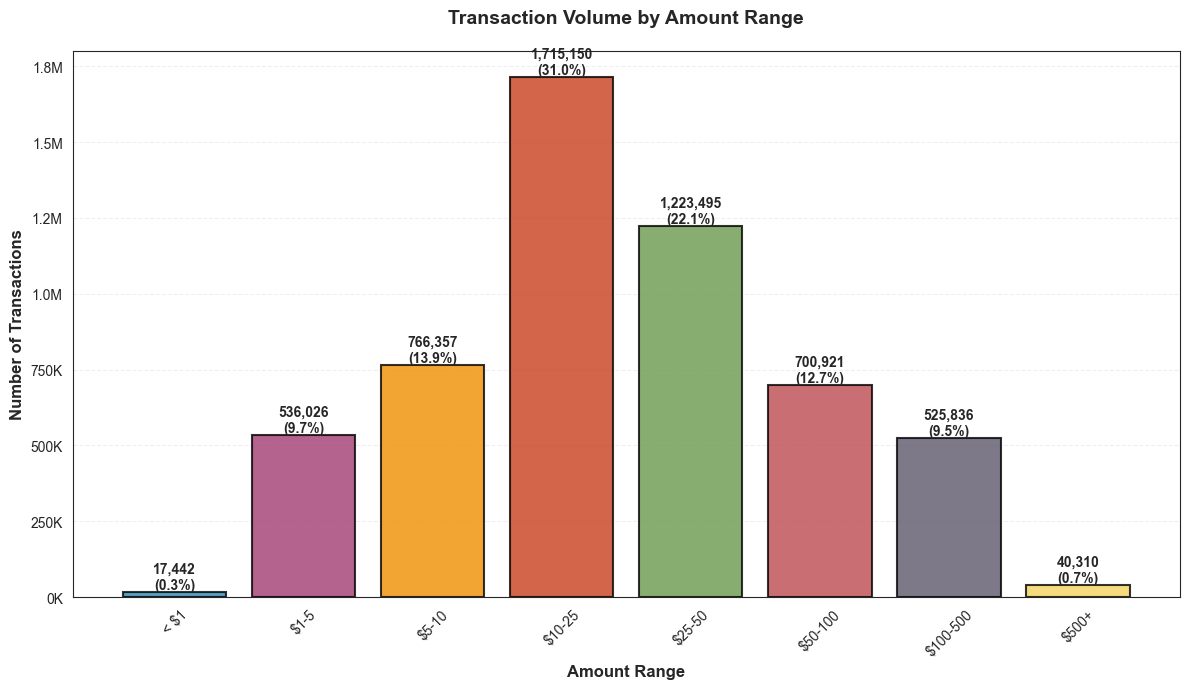

In [36]:
# ===========================================================================
# GENERAL ANALYSIS 2A - VISUALIZATION: Transaction Volume
# ===========================================================================

fig, ax = plt.subplots(figsize=(12, 7))

colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E', '#BC4B51', '#5D576B', '#F4D35E']

bars = ax.bar(bracket_summary['Amount Range'], 
              bracket_summary['Transactions'], 
              color=colors, 
              edgecolor='black', 
              linewidth=1.5,
              alpha=0.8)

ax.set_xlabel('Amount Range', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Transactions', fontsize=12, fontweight='bold')
ax.set_title('Transaction Volume by Amount Range', fontsize=14, fontweight='bold', pad=20)
ax.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, value, pct in zip(bars, bracket_summary['Transactions'], bracket_summary['Trans %']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:,.0f}\n({pct:.1f}%)', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add grid
ax.yaxis.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

# Format y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K'))

plt.tight_layout()
plt.show()

### Monthly Transaction distribution variance

In [37]:
# ===========================================================================
# GENERAL ANALYSIS 3 - MONTHLY TRANSACTION DISTRIBUTION VARIANCE
# ===========================================================================
"""
## Monthly Distribution by Amount Bracket
"""

# Create monthly distribution data
monthly_brackets = pd.crosstab(combined_df['year_month'], combined_df['amount_bracket'])
monthly_brackets_pct = pd.crosstab(combined_df['year_month'], combined_df['amount_bracket'], normalize='index') * 100

# Format for display
display_df = monthly_brackets_pct.copy()
display_df.index = display_df.index.astype(str)
display_df = display_df.round(1)

# Add column formatting
for col in display_df.columns:
    display_df[col] = display_df[col].apply(lambda x: f"{x:.1f}%")

print("\n" + "="*100)
print(" " * 30 + "MONTHLY DISTRIBUTION BY AMOUNT BRACKET (%)")
print("="*100)

display(display_df)

# Volatility analysis
print("\n" + "="*100)
print(" " * 35 + "VOLATILITY ANALYSIS")
print("="*100)

volatility_stats = []
for bracket in labels:
    variance = monthly_brackets_pct[bracket].std()
    mean_pct = monthly_brackets_pct[bracket].mean()
    min_pct = monthly_brackets_pct[bracket].min()
    max_pct = monthly_brackets_pct[bracket].max()
    range_pct = max_pct - min_pct
    
    volatility_stats.append({
        'Amount Range': bracket,
        'Avg %': f"{mean_pct:.1f}%",
        'Std Dev': f"{variance:.2f}%",
        'Min %': f"{min_pct:.1f}%",
        'Max %': f"{max_pct:.1f}%",
        'Range': f"{range_pct:.1f}%",
        'Stability': 'Stable' if variance < 1.0 else 'Moderate' if variance < 2.0 else 'Volatile'
    })

volatility_df = pd.DataFrame(volatility_stats)
display(volatility_df)

# Key insights
print("\n" + "="*100)
print(" " * 40 + "KEY INSIGHTS")
print("="*100)

most_stable = volatility_df.loc[volatility_df['Std Dev'].str.replace('%', '').astype(float).idxmin(), 'Amount Range']
most_volatile = volatility_df.loc[volatility_df['Std Dev'].str.replace('%', '').astype(float).idxmax(), 'Amount Range']
dominant_bracket = volatility_df.loc[volatility_df['Avg %'].str.replace('%', '').astype(float).idxmax(), 'Amount Range']

insights = pd.DataFrame({
    'Insight': [
        'Most Consistent Range',
        'Most Volatile Range',
        'Dominant Transaction Range',
        'Small Transactions Trend (<$10)',
        'Large Transactions Trend (>$100)'
    ],
    'Finding': [
        f"{most_stable} - Most stable across months",
        f"{most_volatile} - Highest month-to-month variation",
        f"{dominant_bracket} - Highest average percentage",
        f"{monthly_brackets_pct[['< $1', '$1-5', '$5-10']].sum(axis=1).mean():.1f}% average, "
        f"{monthly_brackets_pct[['< $1', '$1-5', '$5-10']].sum(axis=1).std():.2f}% volatility",
        f"{monthly_brackets_pct[['$100-500', '$500+']].sum(axis=1).mean():.1f}% average, "
        f"{monthly_brackets_pct[['$100-500', '$500+']].sum(axis=1).std():.2f}% volatility"
    ]
})

display(insights)
print("="*100)


                              MONTHLY DISTRIBUTION BY AMOUNT BRACKET (%)


amount_bracket  < $1   $1-5  $5-10 $10-25 $25-50 $50-100 $100-500 $500+
year_month                                                             
2025-01         0.3%   9.8%  14.1%  31.0%  22.1%   12.4%     9.5%  0.8%
2025-02         0.3%   9.7%  13.8%  30.8%  22.2%   12.7%     9.7%  0.8%
2025-03         0.3%   9.7%  13.9%  30.8%  22.2%   12.6%     9.7%  0.8%
2025-04         0.3%   9.8%  13.8%  30.8%  22.3%   12.5%     9.6%  0.8%
2025-05         0.3%   9.6%  13.9%  30.8%  22.2%   12.8%     9.6%  0.7%
2025-06         0.3%   9.7%  13.9%  31.2%  22.2%   12.7%     9.3%  0.7%
2025-07         0.3%   9.9%  14.1%  31.2%  21.9%   12.5%     9.3%  0.7%
2025-08         0.3%   9.8%  14.0%  31.3%  22.0%   12.6%     9.4%  0.7%
2025-09         0.3%  10.0%  14.2%  31.7%  21.8%   12.3%     9.0%  0.7%
2025-10         0.3%  10.0%  14.2%  31.7%  21.8%   12.3%     9.0%  0.7%
2025-11         0.3%   9.5%  13.7%  31.0%  22.4%   13.0%     9.5%  0.7%
2025-12         0.3%   9.0%  12.8%  30.3%  22.6%   13.8%    10.6%  0.7%


                                   VOLATILITY ANALYSIS


Amount Range  Avg % Std Dev  Min %  Max % Range Stability
0         < $1   0.3%   0.01%   0.3%   0.3%  0.1%    Stable
1         $1-5   9.7%   0.29%   9.0%  10.0%  1.1%    Stable
2        $5-10  13.9%   0.37%  12.8%  14.2%  1.4%    Stable
3       $10-25  31.0%   0.41%  30.3%  31.7%  1.5%    Stable
4       $25-50  22.1%   0.24%  21.8%  22.6%  0.8%    Stable
5      $50-100  12.7%   0.41%  12.3%  13.8%  1.5%    Stable
6     $100-500   9.5%   0.41%   9.0%  10.6%  1.6%    Stable
7        $500+   0.7%   0.04%   0.7%   0.8%  0.1%    Stable


                                        KEY INSIGHTS


Insight                                    Finding
0             Most Consistent Range           < $1 - Most stable across months
1               Most Volatile Range  $10-25 - Highest month-to-month variation
2        Dominant Transaction Range        $10-25 - Highest average percentage
3   Small Transactions Trend (<$10)            23.9% average, 0.65% volatility
4  Large Transactions Trend (>$100)            10.2% average, 0.42% volatility

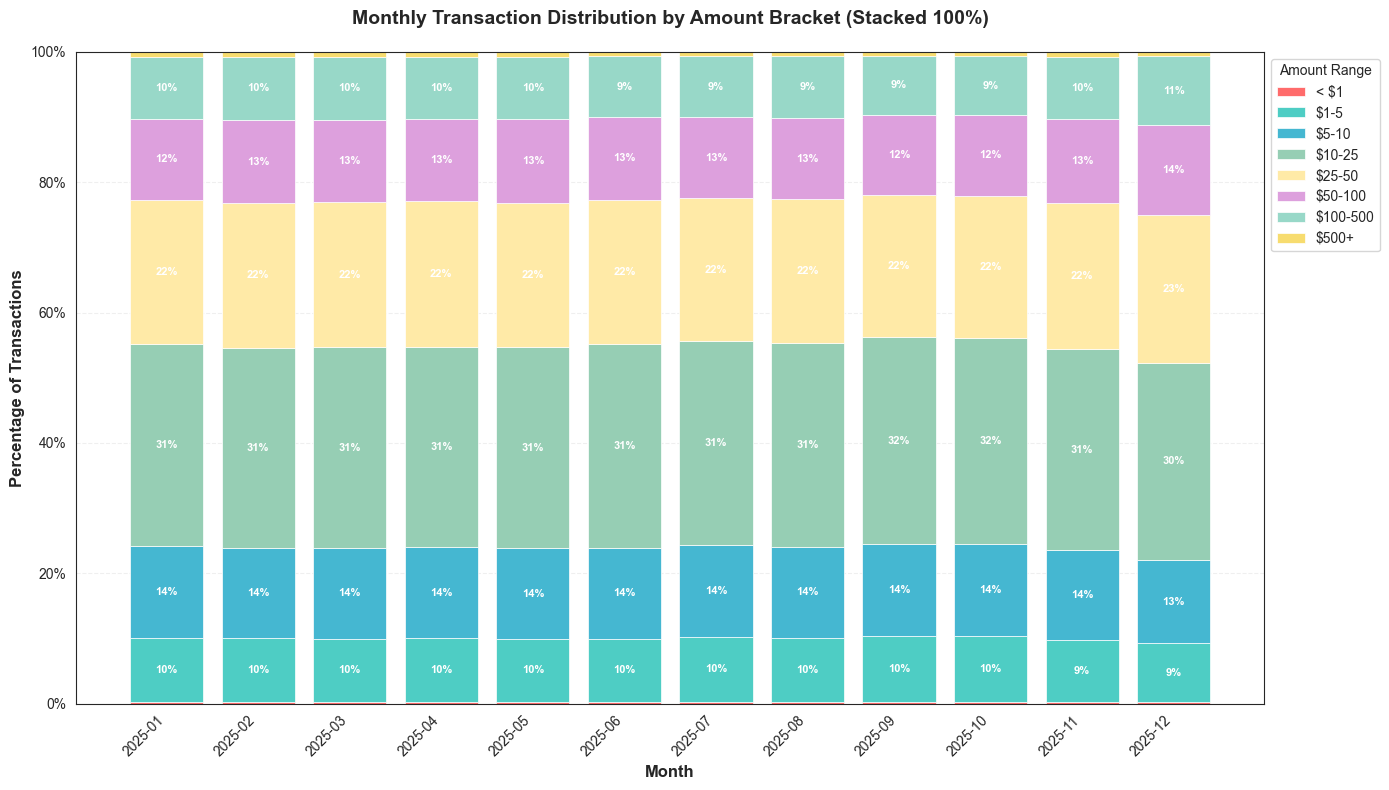

In [38]:
# ===========================================================================
# GENERAL ANALYSIS 3 - VISUALIZATION: Distribution Over Time
# ===========================================================================

fig, ax = plt.subplots(figsize=(14, 8))

# Prepare data for stacked bar chart
months = [str(m) for m in monthly_brackets_pct.index]
x_pos = np.arange(len(months))

# Define colors for each bracket
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8', '#F7DC6F']

# Create stacked bar chart
bottom = np.zeros(len(months))
for i, bracket in enumerate(labels):
    values = monthly_brackets_pct[bracket].values
    bars = ax.bar(x_pos, values, bottom=bottom, label=bracket, color=colors[i], 
                   width=0.8, edgecolor='white', linewidth=0.5)
    
    # Add percentage labels for larger segments
    for j, (bar, val) in enumerate(zip(bars, values)):
        if val > 5:  # Only label segments > 5%
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., bottom[j] + height/2,
                   f'{val:.0f}%', ha='center', va='center', fontsize=8, 
                   fontweight='bold', color='white')
    
    bottom += values

ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage of Transactions', fontsize=12, fontweight='bold')
ax.set_title('Monthly Transaction Distribution by Amount Bracket (Stacked 100%)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(months, rotation=45, ha='right')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title='Amount Range')

# Add percentage labels on y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}%'))
ax.set_ylim(0, 100)

# Add grid
ax.yaxis.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

## 1 - Merchant Analysis

### Spend - Top 50 merchants overall

In [39]:
# ===========================================================================
# M1 - TOP 50 MERCHANTS BY TOTAL SPEND
# ===========================================================================
"""
## M1: Top 50 Merchants by Total Spend (Consolidated)
"""

top_merchants_overall = combined_df.groupby('merchant_consolidated').agg({
    'amount': ['sum', 'count', 'mean'],
    'primary_account_num': 'nunique'
}).round(2)

top_merchants_overall.columns = ['total_amount', 'transaction_count', 'avg_transaction', 'unique_accounts']
top_merchants_overall = top_merchants_overall.sort_values('total_amount', ascending=False).head(50)

# Format for display
display_df = top_merchants_overall.reset_index()
display_df = display_df.rename(columns={
    'merchant_consolidated': 'Merchant',
    'total_amount': 'Total Spend',
    'transaction_count': 'Transactions',
    'avg_transaction': 'Avg Transaction',
    'unique_accounts': 'Unique Accounts'
})

# Format currency columns
display_df['Total Spend'] = display_df['Total Spend'].apply(lambda x: f"${x:,.0f}")
display_df['Avg Transaction'] = display_df['Avg Transaction'].apply(lambda x: f"${x:.2f}")

print("\n" + "="*100)
print(" " * 35 + "TOP 50 MERCHANTS BY TOTAL SPEND")
print("="*100)

display(display_df)

# Summary stats
total_spend = top_merchants_overall['total_amount'].sum()
total_transactions = top_merchants_overall['transaction_count'].sum()
total_accounts = top_merchants_overall['unique_accounts'].sum()

summary = pd.DataFrame({
    'Metric': ['Total Spend (Top 50)', 'Total Transactions (Top 50)', 'Total Unique Accounts (Top 50)'],
    'Value': [f"${total_spend:,.0f}", f"{total_transactions:,.0f}", f"{total_accounts:,.0f}"]
})

print("\n")
display(summary)
print("="*100)


                                   TOP 50 MERCHANTS BY TOTAL SPEND


Merchant  Total Spend  \
0                                            CASH APP  $15,184,478   
1                                              AMAZON   $9,900,058   
2                                         STOP & SHOP   $8,274,022   
3                             WALMART (ALL LOCATIONS)   $7,719,348   
4                                               VENMO   $7,219,820   
5                                             FANDUEL   $6,038,971   
6                                          APPLE CASH   $3,856,297   
7                                          DRAFTKINGS   $3,601,663   
8                                         EXXON/MOBIL   $3,344,052   
9                                      BJ'S WHOLESALE   $3,113,358   
10                                             PAYPAL   $2,896,029   
11                                             COSTCO   $2,631,395   
12                                         HOME DEPOT   $2,066,203   
13                                               ALDI   $2,046,950   
14                                       CVS PHARMACY   $1,937,655   
15                                               AT&T   $1,934,252   
16                                    COMCAST/XFINITY   $1,698,333   
17                             TARGET (ALL LOCATIONS)   $1,663,577   
18                                             DUNKIN   $1,555,508   
19                                         MCDONALD'S   $1,491,336   
20                                     APPLE.COM/BILL   $1,481,947   
21                                              GEICO   $1,384,439   
22                                              SHELL   $1,366,405   
23                                          WALGREENS   $1,300,789   
24                                        WALMART.COM   $1,254,201   
25                                           DOORDASH   $1,243,359   
26                                            HBO MAX   $1,239,639   
27                                          UBER EATS   $1,233,516   
28             BIG Y 77 NORTH H   NORTH HAVEN    CTUS   $1,125,889   
29                                             KLARNA   $1,120,833   
30                                             AFFIRM   $1,058,591   
31                                           AFTERPAY     $964,910   
32             SHOPRITE HAMDEN S1 HAMDEN         CTUS     $908,503   
33             BIG Y 87 NORTH B   N BRANFORD     CTUS     $872,782   
34                                         STATE FARM     $871,935   
35                                        PROGRESSIVE     $861,680   
36                                             LOWE'S     $850,581   
37                                          INSTACART     $717,365   
38                                   CUMBERLAND FARMS     $715,233   
39  UI WEB PAYMENT 157 CHURCH ST      NEW HAVEN   ...     $699,501   
40             SHOPRITE EAST HAVENEAST HAVEN     CTUS     $682,041   
41             SHOPRITE ORANGE S1 ORANGE         CTUS     $670,730   
42                                          MARSHALLS     $620,113   
43                                               UBER     $609,312   
44                                       TRADER JOE'S     $601,382   
45             BIG Y 12 BRANFOR   BRANFORD       CTUS     $574,897   
46             SOUTHERN CT GAS    800-659-8299   CTUS     $561,794   
47                                          STARBUCKS     $555,405   
48                                               DAVE     $548,396   
49             BIG Y 55 GUILFOR   GUILFORD       CTUS     $548,377   

    Transactions Avg Transaction  Unique Accounts  
0         176835          $85.87             4360  
1         271858          $36.42             7915  
2         157712          $52.46            10017  
3         133112          $57.99            10641  
4          53859         $134.05             2937  
5         107398          $56.23              918  
6          44716          $86.24             2383  
7          59786          $60.24              789  
8     

Metric         Value
0            Total Spend (Top 50)  $115,417,850
1     Total Transactions (Top 50)     2,412,574
2  Total Unique Accounts (Top 50)       177,399

#### Viz - Top 25 Merchants by Spend

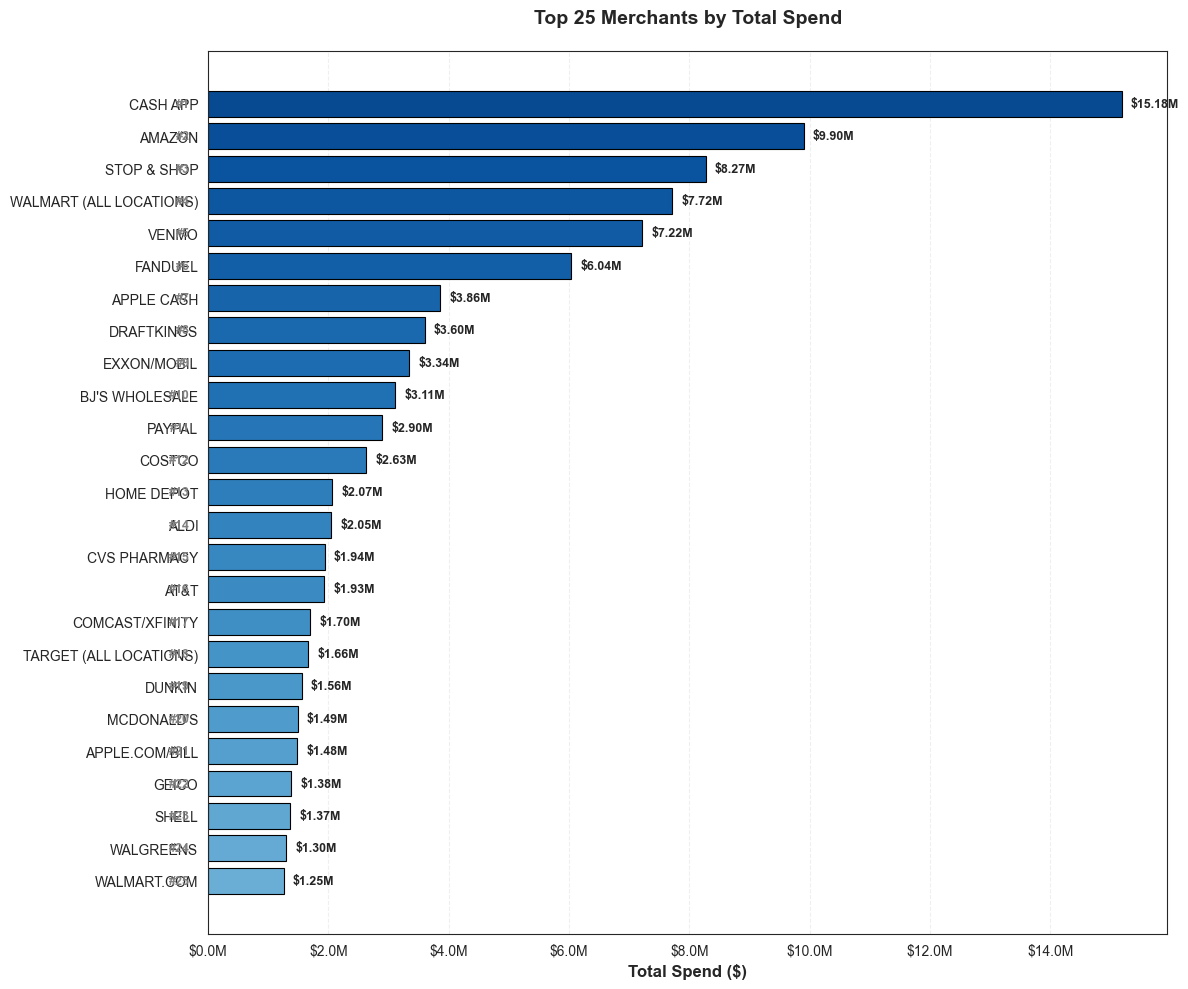

In [40]:
# ===========================================================================
# M1 VISUALIZATION - Top 25 Merchants by Total Spend
# ===========================================================================

fig, ax = plt.subplots(figsize=(12, 10))

# Get top 25 and reverse order so #1 is at top
top_25 = top_merchants_overall.head(25).iloc[::-1]

merchants = [m[:40] + '...' if len(m) > 40 else m for m in top_25.index]
values = top_25['total_amount'].values

# Color gradient
colors = plt.cm.Blues(np.linspace(0.5, 0.9, 25))

bars = ax.barh(range(25), values, color=colors, edgecolor='black', linewidth=0.8)
ax.set_yticks(range(25))
ax.set_yticklabels(merchants, fontsize=10)
ax.set_xlabel('Total Spend ($)', fontsize=12, fontweight='bold')
ax.set_title('Top 25 Merchants by Total Spend', fontsize=14, fontweight='bold', pad=20)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, values)):
    ax.text(value + max(values)*0.01, bar.get_y() + bar.get_height()/2, 
            f'${value/1e6:.2f}M', va='center', fontsize=9, fontweight='bold')

# Format x-axis
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
ax.grid(axis='x', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

# Add rank labels on left side
for i, rank in enumerate(range(25, 0, -1)):
    ax.text(-max(values)*0.02, i, f'#{rank}', 
            ha='right', va='center', fontsize=9, fontweight='bold', color='gray')

plt.tight_layout()
plt.show()

### Transactions - TOP 50 MERCHANTS BY TRANSACTION COUNT


In [41]:
# ===========================================================================
# M1B - TOP 50 MERCHANTS BY TRANSACTION COUNT
# ===========================================================================
"""
## M1B: Top 50 Merchants by Transaction Count (Consolidated)
"""

top_by_transactions = combined_df.groupby('merchant_consolidated').agg({
    'amount': ['sum', 'count', 'mean'],
    'primary_account_num': 'nunique'
}).round(2)

top_by_transactions.columns = ['total_amount', 'transaction_count', 'avg_transaction', 'unique_accounts']
top_by_transactions = top_by_transactions.sort_values('transaction_count', ascending=False).head(50)

# Format for display
display_df = top_by_transactions.reset_index()
display_df = display_df.rename(columns={
    'merchant_consolidated': 'Merchant',
    'transaction_count': 'Transactions',
    'total_amount': 'Total Spend',
    'avg_transaction': 'Avg Transaction',
    'unique_accounts': 'Unique Accounts'
})

# Format columns
display_df['Total Spend'] = display_df['Total Spend'].apply(lambda x: f"${x:,.0f}")
display_df['Avg Transaction'] = display_df['Avg Transaction'].apply(lambda x: f"${x:.2f}")

print("\n" + "="*100)
print(" " * 30 + "TOP 50 MERCHANTS BY TRANSACTION COUNT")
print("="*100)

display(display_df)

# Summary stats
total_spend = top_by_transactions['total_amount'].sum()
total_transactions = top_by_transactions['transaction_count'].sum()
total_accounts = top_by_transactions['unique_accounts'].sum()

summary = pd.DataFrame({
    'Metric': ['Total Spend (Top 50)', 'Total Transactions (Top 50)', 'Total Unique Accounts (Top 50)'],
    'Value': [f"${total_spend:,.0f}", f"{total_transactions:,.0f}", f"{total_accounts:,.0f}"]
})

print("\n")
display(summary)
print("="*100)


                              TOP 50 MERCHANTS BY TRANSACTION COUNT


Merchant  Total Spend  Transactions  \
0                                    AMAZON   $9,900,058        271858   
1                                  CASH APP  $15,184,478        176835   
2                                    DUNKIN   $1,555,508        175369   
3                               STOP & SHOP   $8,274,022        157712   
4                                MCDONALD'S   $1,491,336        139927   
5                   WALMART (ALL LOCATIONS)   $7,719,348        133112   
6                                   FANDUEL   $6,038,971        107398   
7                            APPLE.COM/BILL   $1,481,947        104086   
8                              CVS PHARMACY   $1,937,655         74753   
9                               EXXON/MOBIL   $3,344,052         67618   
10                               DRAFTKINGS   $3,601,663         59786   
11                                    SHELL   $1,366,405         56949   
12                                   PAYPAL   $2,896,029         54920   
13                                    VENMO   $7,219,820         53859   
14                           BJ'S WHOLESALE   $3,113,358         45904   
15                                WALGREENS   $1,300,789         45495   
16                               APPLE CASH   $3,856,297         44716   
17                                     ALDI   $2,046,950         42997   
18                                STARBUCKS     $555,405         42674   
19                         CUMBERLAND FARMS     $715,233         40461   
20                                   GOOGLE     $437,499         38767   
21                                 DOORDASH   $1,243,359         36048   
22                                     UBER     $609,312         35474   
23                                UBER EATS   $1,233,516         34530   
24                   TARGET (ALL LOCATIONS)   $1,663,577         33491   
25                               HOME DEPOT   $2,066,203         31639   
26                                   COSTCO   $2,631,395         31628   
27                              DOLLAR TREE     $475,229         28205   
28                             AMAZON PRIME     $437,420         26421   
29                                   KLARNA   $1,120,833         25639   
30                                  HBO MAX   $1,239,639         25020   
31                                 AFTERPAY     $964,910         24565   
32                                   AFFIRM   $1,058,591         24298   
33                              BURGER KING     $312,589         23973   
34                                    CITGO     $521,891         22816   
35                              CHICK-FIL-A     $411,988         21516   
36                                  NETFLIX     $395,887         20665   
37                                 7-ELEVEN     $359,145         20304   
38                           DOLLAR GENERAL     $439,676         19349   
39   BIG Y 77 NORTH H   NORTH HAVEN    CTUS   $1,125,889         19172   
40                              WALMART.COM   $1,254,201         19147   
41   SHOPRITE HAMDEN S1 HAMDEN         CTUS     $908,503         19144   
42                                   SUNOCO     $419,686         17350   
43                                  WENDY'S     $230,762         16318   
44                            FAMILY DOLLAR     $323,193         15833   
45   BIG Y 87 NORTH B   N BRANFORD     CTUS     $872,782         14932   
46                                TACO BELL     $238,269         14191   
47   SHOPRITE ORANGE S1 ORANGE         CTUS     $670,730         13789   
48                                     AT&T   $1,934,252         12973   
49   SHOPRITE EAST HAVENEAST HAVEN     CTUS     $682,041         12936   

   Avg Transaction  Unique Accounts  
0           $36.42             7915  
1           $85.87             4360  
2            $8.87             8976  
3           $52.46            10017  
4           $10.66             9069  
5           $57.99            10

Metric         Value
0            Total Spend (Top 50)  $109,882,292
1     Total Transactions (Top 50)     2,596,562
2  Total Unique Accounts (Top 50)       205,526

#### Viz - Top 25 Merchants by Txn Count

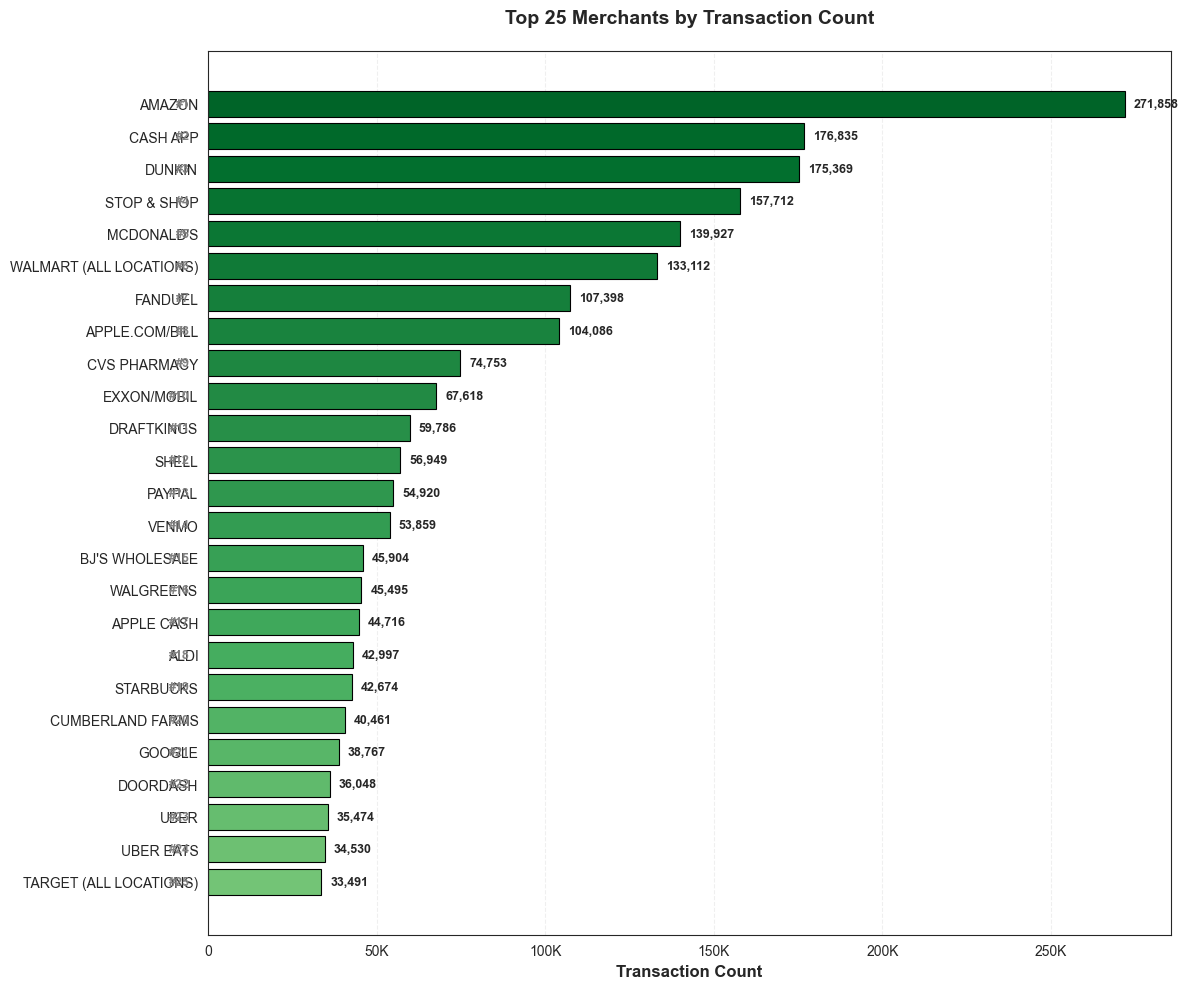

In [42]:
# ===========================================================================
# M1B VISUALIZATION - Top 25 Merchants by Transaction Count
# ===========================================================================

fig, ax = plt.subplots(figsize=(12, 10))

# Get top 25 and reverse order so #1 is at top
top_25 = top_by_transactions.head(25).iloc[::-1]

merchants = [m[:40] + '...' if len(m) > 40 else m for m in top_25.index]
values = top_25['transaction_count'].values

# Color gradient
colors = plt.cm.Greens(np.linspace(0.5, 0.9, 25))

bars = ax.barh(range(25), values, color=colors, edgecolor='black', linewidth=0.8)
ax.set_yticks(range(25))
ax.set_yticklabels(merchants, fontsize=10)
ax.set_xlabel('Transaction Count', fontsize=12, fontweight='bold')
ax.set_title('Top 25 Merchants by Transaction Count', fontsize=14, fontweight='bold', pad=20)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, values)):
    ax.text(value + max(values)*0.01, bar.get_y() + bar.get_height()/2, 
            f'{value:,.0f}', va='center', fontsize=9, fontweight='bold')

# Format x-axis
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}K' if x >= 1000 else f'{x:.0f}'))
ax.grid(axis='x', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

# Add rank labels on left side
for i, rank in enumerate(range(25, 0, -1)):
    ax.text(-max(values)*0.02, i, f'#{rank}', 
            ha='right', va='center', fontsize=9, fontweight='bold', color='gray')

plt.tight_layout()
plt.show()

### Accounts - TOP 50 MERCHANTS BY UNIQUE ACCOUNTS

In [43]:
# ===========================================================================
# M1C - TOP 50 MERCHANTS BY UNIQUE ACCOUNT COUNT
# ===========================================================================
"""
## M1C: Top 50 Merchants by Unique Account Count (Consolidated)
"""

top_by_accounts = combined_df.groupby('merchant_consolidated').agg({
    'amount': ['sum', 'count', 'mean'],
    'primary_account_num': 'nunique'
}).round(2)

top_by_accounts.columns = ['total_amount', 'transaction_count', 'avg_transaction', 'unique_accounts']
top_by_accounts = top_by_accounts.sort_values('unique_accounts', ascending=False).head(50)

# Format for display
display_df = top_by_accounts.reset_index()
display_df = display_df.rename(columns={
    'merchant_consolidated': 'Merchant',
    'unique_accounts': 'Unique Accounts',
    'transaction_count': 'Transactions',
    'total_amount': 'Total Spend',
    'avg_transaction': 'Avg Transaction'
})

# Format columns
display_df['Total Spend'] = display_df['Total Spend'].apply(lambda x: f"${x:,.0f}")
display_df['Avg Transaction'] = display_df['Avg Transaction'].apply(lambda x: f"${x:.2f}")

print("\n" + "="*100)
print(" " * 30 + "TOP 50 MERCHANTS BY UNIQUE ACCOUNT COUNT")
print("="*100)

display(display_df)

# Summary stats
total_spend = top_by_accounts['total_amount'].sum()
total_transactions = top_by_accounts['transaction_count'].sum()
total_accounts = top_by_accounts['unique_accounts'].sum()

summary = pd.DataFrame({
    'Metric': ['Total Spend (Top 50)', 'Total Transactions (Top 50)', 'Total Unique Accounts (Top 50)'],
    'Value': [f"${total_spend:,.0f}", f"{total_transactions:,.0f}", f"{total_accounts:,.0f}"]
})

print("\n")
display(summary)
print("="*100)


                              TOP 50 MERCHANTS BY UNIQUE ACCOUNT COUNT


Merchant  Total Spend  Transactions  \
0                   WALMART (ALL LOCATIONS)   $7,719,348        133112   
1                               STOP & SHOP   $8,274,022        157712   
2                              CVS PHARMACY   $1,937,655         74753   
3                                MCDONALD'S   $1,491,336        139927   
4                                    DUNKIN   $1,555,508        175369   
5                                    AMAZON   $9,900,058        271858   
6                                 WALGREENS   $1,300,789         45495   
7                               EXXON/MOBIL   $3,344,052         67618   
8                    TARGET (ALL LOCATIONS)   $1,663,577         33491   
9                                     SHELL   $1,366,405         56949   
10                               HOME DEPOT   $2,066,203         31639   
11                                  HBO MAX   $1,239,639         25020   
12                              DOLLAR TREE     $475,229         28205   
13                                     ALDI   $2,046,950         42997   
14                              BURGER KING     $312,589         23973   
15                         CUMBERLAND FARMS     $715,233         40461   
16                           BJ'S WHOLESALE   $3,113,358         45904   
17                                 CASH APP  $15,184,478        176835   
18                           APPLE.COM/BILL   $1,481,947        104086   
19                              CHICK-FIL-A     $411,988         21516   
20                                STARBUCKS     $555,405         42674   
21                                    CITGO     $521,891         22816   
22                             AMAZON PRIME     $437,420         26421   
23                                  WENDY'S     $230,762         16318   
24                                MARSHALLS     $620,113         11472   
25                                   SUNOCO     $419,686         17350   
26                                   COSTCO   $2,631,395         31628   
27                                      DMV     $482,872          4598   
28                                   KOHL'S     $495,207          8202   
29                                  POPEYES     $183,428         10248   
30                           DOLLAR GENERAL     $439,676         19349   
31                                   LOWE'S     $850,581         11727   
32                                 7-ELEVEN     $359,145         20304   
33                                TACO BELL     $238,269         14191   
34                               FIVE BELOW     $173,658          7879   
35                                   PAYPAL   $2,896,029         54920   
36                             PANERA BREAD     $227,538         12170   
37                                    VENMO   $7,219,820         53859   
38                                   SUBWAY     $149,301          9162   
39                               BURLINGTON     $430,728          8666   
40                            FAMILY DOLLAR     $323,193         15833   
41                                     UBER     $609,312         35474   
42                                 CHIPOTLE     $222,738         11695   
43                                 DOORDASH   $1,243,359         36048   
44                                 MICHAELS     $178,698          6045   
45                              WALMART.COM   $1,254,201         19147   
46                                UBER EATS   $1,233,516         34530   
47                               APPLE CASH   $3,856,297         44716   
48   SHOPRITE HAMDEN S1 HAMDEN         CTUS     $908,503         19144   
49                                      KFC     $118,199          6771   

   Avg Transaction  Unique Accounts  
0           $57.99            10641  
1           $52.46            10017  
2           $25.92             9600  
3           $10.66             9069  
4            $8.87             8976  
5           $36.42             7

Metric        Value
0            Total Spend (Top 50)  $95,111,304
1     Total Transactions (Top 50)    2,330,277
2  Total Unique Accounts (Top 50)      222,674

#### VIz - Top 25 Merchants by Unique Accts

## 2 - MCC Code

### TOp 50 MCC Code by Unique Accounts

In [44]:
# ===========================================================================
# M2A - TOP 50 MERCHANT CATEGORIES (MCC) BY UNIQUE ACCOUNTS
# ===========================================================================
"""
## M2A: Top 50 Merchant Categories by Unique Account Count
Based on MCC (Merchant Category Code) groupings
"""

top_mcc_by_accounts = combined_df.groupby('mcc_code').agg({
    'amount': ['sum', 'count', 'mean'],
    'primary_account_num': 'nunique',
    'merchant_name': 'nunique'
}).round(2)

top_mcc_by_accounts.columns = ['total_amount', 'transaction_count', 'avg_transaction', 'unique_accounts', 'num_merchants']
top_mcc_by_accounts = top_mcc_by_accounts.sort_values('unique_accounts', ascending=False).head(50)

# Format for display
display_df = top_mcc_by_accounts.reset_index()
display_df = display_df.rename(columns={
    'mcc_code': 'MCC Code',
    'unique_accounts': 'Unique Accounts',
    'num_merchants': 'Merchants',
    'transaction_count': 'Transactions',
    'total_amount': 'Total Spend',
    'avg_transaction': 'Avg Transaction'
})

# Format columns
display_df['Total Spend'] = display_df['Total Spend'].apply(lambda x: f"${x:,.0f}")
display_df['Avg Transaction'] = display_df['Avg Transaction'].apply(lambda x: f"${x:.2f}")

print("\n" + "="*110)
print(" " * 30 + "TOP 50 MERCHANT CATEGORIES BY UNIQUE ACCOUNT COUNT")
print(" " * 40 + "(Based on MCC Codes)")
print("="*110)

display(display_df)

# Summary stats
total_spend = top_mcc_by_accounts['total_amount'].sum()
total_transactions = top_mcc_by_accounts['transaction_count'].sum()
total_accounts = top_mcc_by_accounts['unique_accounts'].sum()
total_merchants = top_mcc_by_accounts['num_merchants'].sum()

summary = pd.DataFrame({
    'Metric': [
        'Total MCC Categories (Top 50)', 
        'Total Unique Accounts (Top 50)', 
        'Total Merchants (Top 50)',
        'Total Transactions (Top 50)', 
        'Total Spend (Top 50)'
    ],
    'Value': [
        f"{len(top_mcc_by_accounts)}",
        f"{total_accounts:,.0f}",
        f"{total_merchants:,.0f}",
        f"{total_transactions:,.0f}", 
        f"${total_spend:,.0f}"
    ]
})

print("\n")
display(summary)
print("="*110)


                              TOP 50 MERCHANT CATEGORIES BY UNIQUE ACCOUNT COUNT
                                        (Based on MCC Codes)


Empty DataFrame
Columns: [MCC Code, Total Spend, Transactions, Avg Transaction, Unique Accounts, Merchants]
Index: []

Metric Value
0   Total MCC Categories (Top 50)     0
1  Total Unique Accounts (Top 50)     0
2        Total Merchants (Top 50)     0
3     Total Transactions (Top 50)     0
4            Total Spend (Top 50)    $0

### TOP 50 MERCHANT CATEGORIES (MCC) BY TRANSACTION COUNT

In [45]:
# ===========================================================================
# M2B - TOP 50 MERCHANT CATEGORIES (MCC) BY TRANSACTION COUNT
# ===========================================================================
"""
## M2B: Top 50 Merchant Categories by Transaction Count
"""

top_mcc_by_trans = combined_df.groupby('mcc_code').agg({
    'amount': ['sum', 'count', 'mean'],
    'primary_account_num': 'nunique',
    'merchant_name': 'nunique'
}).round(2)

top_mcc_by_trans.columns = ['total_amount', 'transaction_count', 'avg_transaction', 'unique_accounts', 'num_merchants']
top_mcc_by_trans = top_mcc_by_trans.sort_values('transaction_count', ascending=False).head(50)

# Format for display
display_df = top_mcc_by_trans.reset_index()
display_df = display_df.rename(columns={
    'mcc_code': 'MCC Code',
    'transaction_count': 'Transactions',
    'unique_accounts': 'Unique Accounts',
    'num_merchants': 'Merchants',
    'total_amount': 'Total Spend',
    'avg_transaction': 'Avg Transaction'
})

# Format columns
display_df['Total Spend'] = display_df['Total Spend'].apply(lambda x: f"${x:,.0f}")
display_df['Avg Transaction'] = display_df['Avg Transaction'].apply(lambda x: f"${x:.2f}")

print("\n" + "="*110)
print(" " * 30 + "TOP 50 MERCHANT CATEGORIES BY TRANSACTION COUNT")
print("="*110)

display(display_df)

# Summary stats
total_spend = top_mcc_by_trans['total_amount'].sum()
total_transactions = top_mcc_by_trans['transaction_count'].sum()
total_accounts = top_mcc_by_trans['unique_accounts'].sum()

summary = pd.DataFrame({
    'Metric': [
        'Total Transactions (Top 50)', 
        'Total Spend (Top 50)', 
        'Total Unique Accounts (Top 50)'
    ],
    'Value': [
        f"{total_transactions:,.0f}", 
        f"${total_spend:,.0f}",
        f"{total_accounts:,.0f}"
    ]
})

print("\n")
display(summary)
print("="*110)


                              TOP 50 MERCHANT CATEGORIES BY TRANSACTION COUNT


Empty DataFrame
Columns: [MCC Code, Total Spend, Transactions, Avg Transaction, Unique Accounts, Merchants]
Index: []

Metric Value
0     Total Transactions (Top 50)     0
1            Total Spend (Top 50)    $0
2  Total Unique Accounts (Top 50)     0

### TOP 50 MERCHANT CATEGORIES (MCC) BY TOTAL SPEND

In [46]:
# ===========================================================================
# M2C - TOP 50 MERCHANT CATEGORIES (MCC) BY TOTAL SPEND
# ===========================================================================
"""
## M2C: Top 50 Merchant Categories by Total Spend
"""

top_mcc_by_spend = combined_df.groupby('mcc_code').agg({
    'amount': ['sum', 'count', 'mean'],
    'primary_account_num': 'nunique',
    'merchant_name': 'nunique'
}).round(2)

top_mcc_by_spend.columns = ['total_amount', 'transaction_count', 'avg_transaction', 'unique_accounts', 'num_merchants']
top_mcc_by_spend = top_mcc_by_spend.sort_values('total_amount', ascending=False).head(50)

# Format for display
display_df = top_mcc_by_spend.reset_index()
display_df = display_df.rename(columns={
    'mcc_code': 'MCC Code',
    'total_amount': 'Total Spend',
    'unique_accounts': 'Unique Accounts',
    'transaction_count': 'Transactions',
    'num_merchants': 'Merchants',
    'avg_transaction': 'Avg Transaction'
})

# Format columns
display_df['Total Spend'] = display_df['Total Spend'].apply(lambda x: f"${x:,.0f}")
display_df['Avg Transaction'] = display_df['Avg Transaction'].apply(lambda x: f"${x:.2f}")

print("\n" + "="*110)
print(" " * 35 + "TOP 50 MERCHANT CATEGORIES BY TOTAL SPEND")
print("="*110)

display(display_df)

# Summary stats
total_spend = top_mcc_by_spend['total_amount'].sum()
total_transactions = top_mcc_by_spend['transaction_count'].sum()
total_accounts = top_mcc_by_spend['unique_accounts'].sum()

summary = pd.DataFrame({
    'Metric': [
        'Total Spend (Top 50)', 
        'Total Transactions (Top 50)', 
        'Total Unique Accounts (Top 50)'
    ],
    'Value': [
        f"${total_spend:,.0f}",
        f"{total_transactions:,.0f}", 
        f"{total_accounts:,.0f}"
    ]
})

print("\n")
display(summary)
print("="*110)


                                   TOP 50 MERCHANT CATEGORIES BY TOTAL SPEND


Empty DataFrame
Columns: [MCC Code, Total Spend, Transactions, Avg Transaction, Unique Accounts, Merchants]
Index: []

Metric Value
0            Total Spend (Top 50)    $0
1     Total Transactions (Top 50)     0
2  Total Unique Accounts (Top 50)     0

### Viz - MCC Comparison


In [48]:
# ===========================================================================
# M2D VISUALIZATION - Top 20 MCC Categories Comparison
# ===========================================================================
"""
## M2D: MCC Category Comparison - Top 20 by Spend
"""
if len(top_mcc_by_spend) == 0:
    print("No MCC data available for this client — skipping M2D visualization.")
else:    
    fig, axes = plt.subplots(1, 3, figsize=(18, 8))
    
    # Get top 20 by spend
    top_20_mcc = top_mcc_by_spend.head(20).iloc[::-1]
    
    mcc_codes = [str(code) for code in top_20_mcc.index]
    
    # Chart 1: Total Spend
    ax1 = axes[0]
    values1 = top_20_mcc['total_amount'].values
    colors1 = plt.cm.Blues(np.linspace(0.5, 0.9, 20))
    
    bars1 = ax1.barh(range(20), values1, color=colors1, edgecolor='black', linewidth=0.5)
    ax1.set_yticks(range(20))
    ax1.set_yticklabels(mcc_codes, fontsize=9)
    ax1.set_xlabel('Total Spend ($)', fontsize=10, fontweight='bold')
    ax1.set_title('By Total Spend', fontsize=11, fontweight='bold')
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
    ax1.grid(axis='x', linestyle='--', alpha=0.3)
    ax1.set_axisbelow(True)
    
    # Chart 2: Transaction Count
    ax2 = axes[1]
    values2 = top_20_mcc['transaction_count'].values
    colors2 = plt.cm.Greens(np.linspace(0.5, 0.9, 20))
    
    bars2 = ax2.barh(range(20), values2, color=colors2, edgecolor='black', linewidth=0.5)
    ax2.set_yticks(range(20))
    ax2.set_yticklabels([''] * 20)  # Hide y-labels for middle chart
    ax2.set_xlabel('Transactions', fontsize=10, fontweight='bold')
    ax2.set_title('By Transaction Count', fontsize=11, fontweight='bold')
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K'))
    ax2.grid(axis='x', linestyle='--', alpha=0.3)
    ax2.set_axisbelow(True)
    
    # Chart 3: Unique Accounts
    ax3 = axes[2]
    values3 = top_20_mcc['unique_accounts'].values
    colors3 = plt.cm.Oranges(np.linspace(0.5, 0.9, 20))
    
    bars3 = ax3.barh(range(20), values3, color=colors3, edgecolor='black', linewidth=0.5)
    ax3.set_yticks(range(20))
    ax3.set_yticklabels([''] * 20)  # Hide y-labels for right chart
    ax3.set_xlabel('Unique Accounts', fontsize=10, fontweight='bold')
    ax3.set_title('By Account Count', fontsize=11, fontweight='bold')
    ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.1f}K' if x >= 1000 else f'{x:.0f}'))
    ax3.grid(axis='x', linestyle='--', alpha=0.3)
    ax3.set_axisbelow(True)
    
    # Overall title
    fig.suptitle('Top 20 MCC Categories - Three Perspectives', fontsize=14, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()

No MCC data available for this client — skipping M2D visualization.


## 3 - Business Acct 

### Spend - Business - Top 50 merchants overall

In [49]:
# ===========================================================================
# M3A - TOP 50 BUSINESS MERCHANTS BY TOTAL SPEND
# ===========================================================================
"""
## M3A: Top 50 Business Merchants by Total Spend (Consolidated)
Analysis of merchants used by business accounts only
"""

# Use consolidated merchant names for business data
top_business_spend = business_df.groupby('merchant_consolidated').agg({
    'amount': ['sum', 'count', 'mean'],
    'primary_account_num': 'nunique'
}).round(2)

top_business_spend.columns = ['total_amount', 'transaction_count', 'avg_transaction', 'unique_accounts']
top_business_spend = top_business_spend.sort_values('total_amount', ascending=False).head(50)

# Format for display
display_df = top_business_spend.reset_index()
display_df = display_df.rename(columns={
    'merchant_consolidated': 'Merchant',
    'total_amount': 'Total Spend',
    'transaction_count': 'Transactions',
    'avg_transaction': 'Avg Transaction',
    'unique_accounts': 'Unique Accounts'
})

# Format columns
display_df['Total Spend'] = display_df['Total Spend'].apply(lambda x: f"${x:,.0f}")
display_df['Avg Transaction'] = display_df['Avg Transaction'].apply(lambda x: f"${x:.2f}")

print("\n" + "="*100)
print(" " * 30 + "TOP 50 BUSINESS MERCHANTS BY TOTAL SPEND")
print("="*100)

display(display_df)

# Summary stats
total_spend = top_business_spend['total_amount'].sum()
total_transactions = top_business_spend['transaction_count'].sum()
total_accounts = top_business_spend['unique_accounts'].sum()

# Calculate % of total business spend
business_total = business_df['amount'].sum()
top_50_pct = (total_spend / business_total) * 100

summary = pd.DataFrame({
    'Metric': [
        'Total Spend (Top 50)',
        '% of Total Business Spend',
        'Total Transactions (Top 50)',
        'Total Business Accounts (Top 50)',
        'Total Business Spend (All)',
        'Total Business Accounts (All)'
    ],
    'Value': [
        f"${total_spend:,.0f}",
        f"{top_50_pct:.1f}%",
        f"{total_transactions:,.0f}",
        f"{total_accounts:,.0f}",
        f"${business_total:,.0f}",
        f"{business_df['primary_account_num'].nunique():,}"
    ]
})

print("\n")
display(summary)
print("="*100)


                              TOP 50 BUSINESS MERCHANTS BY TOTAL SPEND


Merchant Total Spend  \
0                                            CASH APP    $216,406   
1                                              AMAZON    $183,643   
2                                          HOME DEPOT    $130,609   
3              RESTAURANT DEPOT   ORANGE         CTUS    $123,495   
4                             WALMART (ALL LOCATIONS)     $81,293   
5                                               VENMO     $58,367   
6                                             FANDUEL     $51,388   
7                                              COSTCO     $50,091   
8              FALL RIVER FLORIST FALL RIVER     MAUS     $44,020   
9                                      BJ'S WHOLESALE     $42,249   
10             RESTAURANT DEPOT   WATERBURY      CTUS     $40,018   
11             INTERSTATE LUMBER -NEWTOWN        CTUS     $38,774   
12  RESTAURANT DEPO 181 MARSH HILL RD  ORANGE     ...     $36,270   
13                                             PAYPAL     $33,491   
14                                             LOWE'S     $32,854   
15                                        STOP & SHOP     $32,459   
16                                        EXXON/MOBIL     $31,924   
17                                    COMCAST/XFINITY     $24,980   
18             AAA WHOLESALE OF MIMILFORD        CTUS     $24,629   
19                                         DRAFTKINGS     $23,664   
20                                           AFTERPAY     $23,323   
21             KELLY FRADET ELLING860-745-3331   CTUS     $22,987   
22                                              SHELL     $22,817   
23             LANDON LUMBER      203-2450600    CTUS     $21,441   
24                                          UBER EATS     $21,307   
25             THURSTON FOODS     WALLINGFORD    CTUS     $19,270   
26             EAST COAST WHOLESAL203-8478218    CTUS     $19,211   
27             CT SECRETARY OF STA860-5096151    CTUS     $17,395   
28             NATIONAL FLORAL SUPWWW.NATIONALF  CTUS     $17,052   
29                                               AT&T     $16,446   
30             BIG LITTLE SANITATI203-3347728    CTUS     $16,393   
31             TOTAL FITNESS EQUIPNEWINGTON      CTUS     $16,178   
32                                        PROGRESSIVE     $15,966   
33             DELAWARE VALLEY FLO856-468-7000   NJUS     $15,363   
34  RESTAURANT DEPO 3580 EAST MAIN ST  WATERBURY  ...     $15,314   
35             ACI*CT DOR MYCONNEC925-855-5000   CTUS     $15,235   
36             MED*CONNECTICARE PR800-251-7722   CTUS     $15,045   
37                                             GOOGLE     $13,829   
38                                               ALDI     $13,683   
39                                             AFFIRM     $13,455   
40             INTUIT *QBooks OnliCL.INTUIT.COM  CAUS     $13,409   
41                                         APPLE CASH     $12,805   
42             SIMPLEPRACTICE     WWW.SIMPLEPRA  CAUS     $12,698   
43             WOODBRIDGE HARDWARE203-3977797    CTUS     $11,094   
44             CHEWY.COM          800-672-4399   FLUS     $11,041   
45             RESTAURANT DEPOT   HARTFORD       CTUS     $10,703   
46                                        WALMART.COM     $10,550   
47                             TARGET (ALL LOCATIONS)     $10,079   
48  FORBES PREMIUM 289 WASHINGTON AVENNORTH HAVEN ...      $9,705   
49                                       CVS PHARMACY      $9,650   

    Transactions Avg Transaction  Unique Accounts  
0           1303         $166.08               50  
1           3141          $58.47              165  
2           1243         $105.08              117  
3            292         $422.93               20  
4            960          $84.68              134  
5            320         $182.40               28  
6            171         $300.51                5  
7            576          $86.96               49  
8             35        $1257.71                2  
9    

Metric       Value
0              Total Spend (Top 50)  $1,764,070
1         % of Total Business Spend       43.3%
2       Total Transactions (Top 50)      16,071
3  Total Business Accounts (Top 50)       1,625
4        Total Business Spend (All)  $4,072,048
5     Total Business Accounts (All)         426

#### Viz - Top 25 Business Merchants by Spend

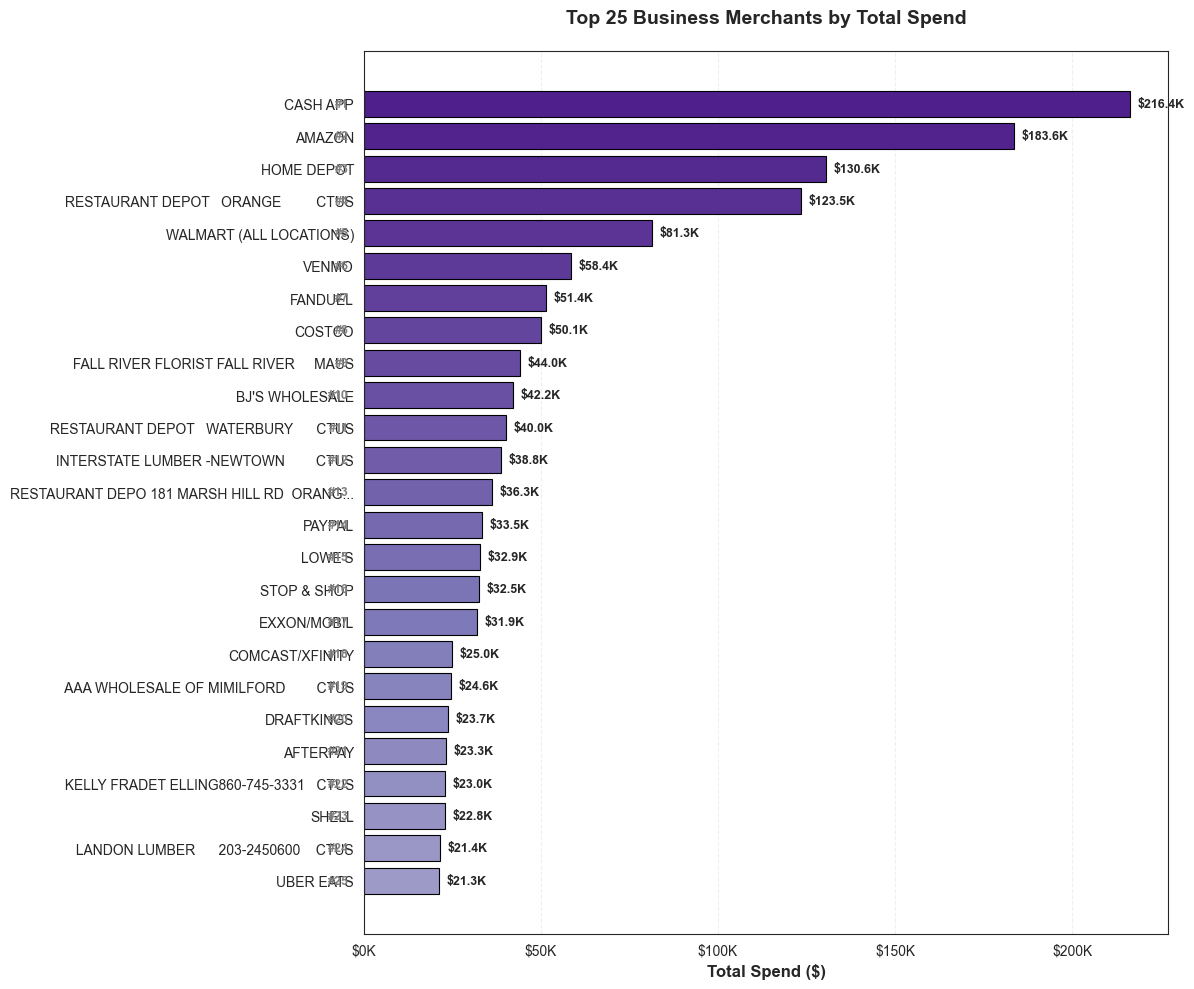

In [50]:
# ===========================================================================
# M3A VISUALIZATION - Top 25 Business Merchants by Spend
# ===========================================================================

fig, ax = plt.subplots(figsize=(12, 10))

# Get top 25 and reverse order so #1 is at top
top_25 = top_business_spend.head(25).iloc[::-1]

merchants = [m[:40] + '...' if len(m) > 40 else m for m in top_25.index]
values = top_25['total_amount'].values

# Color gradient - purple theme for business
colors = plt.cm.Purples(np.linspace(0.5, 0.9, 25))

bars = ax.barh(range(25), values, color=colors, edgecolor='black', linewidth=0.8)
ax.set_yticks(range(25))
ax.set_yticklabels(merchants, fontsize=10)
ax.set_xlabel('Total Spend ($)', fontsize=12, fontweight='bold')
ax.set_title('Top 25 Business Merchants by Total Spend', fontsize=14, fontweight='bold', pad=20)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, values)):
    ax.text(value + max(values)*0.01, bar.get_y() + bar.get_height()/2, 
            f'${value/1e6:.2f}M' if value >= 1e6 else f'${value/1e3:.1f}K', 
            va='center', fontsize=9, fontweight='bold')

# Format x-axis
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M' if x >= 1e6 else f'${x/1e3:.0f}K'))
ax.grid(axis='x', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

# Add rank labels on left side
for i, rank in enumerate(range(25, 0, -1)):
    ax.text(-max(values)*0.02, i, f'#{rank}', 
            ha='right', va='center', fontsize=9, fontweight='bold', color='gray')

plt.tight_layout()
plt.show()

### Transactions - Business - TOP 50 MERCHANTS BY TRANSACTION COUNT


In [51]:
# ===========================================================================
# M3B - TOP 50 BUSINESS MERCHANTS BY TRANSACTION COUNT
# ===========================================================================
"""
## M3B: Top 50 Business Merchants by Transaction Count (Consolidated)
"""

top_business_trans = business_df.groupby('merchant_consolidated').agg({
    'amount': ['sum', 'count', 'mean'],
    'primary_account_num': 'nunique'
}).round(2)

top_business_trans.columns = ['total_amount', 'transaction_count', 'avg_transaction', 'unique_accounts']
top_business_trans = top_business_trans.sort_values('transaction_count', ascending=False).head(50)

# Format for display
display_df = top_business_trans.reset_index()
display_df = display_df.rename(columns={
    'merchant_consolidated': 'Merchant',
    'transaction_count': 'Transactions',
    'total_amount': 'Total Spend',
    'avg_transaction': 'Avg Transaction',
    'unique_accounts': 'Unique Accounts'
})

# Format columns
display_df['Total Spend'] = display_df['Total Spend'].apply(lambda x: f"${x:,.0f}")
display_df['Avg Transaction'] = display_df['Avg Transaction'].apply(lambda x: f"${x:.2f}")

print("\n" + "="*100)
print(" " * 28 + "TOP 50 BUSINESS MERCHANTS BY TRANSACTION COUNT")
print("="*100)

display(display_df)

# Summary stats
total_spend = top_business_trans['total_amount'].sum()
total_transactions = top_business_trans['transaction_count'].sum()
total_accounts = top_business_trans['unique_accounts'].sum()

summary = pd.DataFrame({
    'Metric': [
        'Total Transactions (Top 50)',
        'Total Spend (Top 50)',
        'Total Business Accounts (Top 50)'
    ],
    'Value': [
        f"{total_transactions:,.0f}",
        f"${total_spend:,.0f}",
        f"{total_accounts:,.0f}"
    ]
})

print("\n")
display(summary)
print("="*100)


                            TOP 50 BUSINESS MERCHANTS BY TRANSACTION COUNT


Merchant Total Spend  \
0                                              AMAZON    $183,643   
1                                            CASH APP    $216,406   
2                                          HOME DEPOT    $130,609   
3                             WALMART (ALL LOCATIONS)     $81,293   
4                                         STOP & SHOP     $32,459   
5                                              DUNKIN      $5,780   
6                                               SHELL     $22,817   
7                                              COSTCO     $50,091   
8                                              GOOGLE     $13,829   
9                                      BJ'S WHOLESALE     $42,249   
10                                         MCDONALD'S      $5,336   
11                                          UBER EATS     $21,307   
12                                        EXXON/MOBIL     $31,924   
13                                     APPLE.COM/BILL      $7,525   
14                                           AFTERPAY     $23,323   
15                                             PAYPAL     $33,491   
16                                              VENMO     $58,367   
17             INTUIT *QBooks OnliCL.INTUIT.COM  CAUS     $13,409   
18             RESTAURANT DEPOT   ORANGE         CTUS    $123,495   
19                                       CVS PHARMACY      $9,650   
20                                             AFFIRM     $13,455   
21                                               ALDI     $13,683   
22                                          STARBUCKS      $4,166   
23                                              CITGO      $6,549   
24                                   CUMBERLAND FARMS      $7,460   
25  FORBES PREMIUM 289 WASHINGTON AVENNORTH HAVEN ...      $9,705   
26                                         DRAFTKINGS     $23,664   
27                                             LOWE'S     $32,854   
28             CT SECRETARY OF STA860-5096151    CTUS     $17,395   
29                                           7-ELEVEN      $4,589   
30                                               UBER      $5,670   
31                                          WALGREENS      $5,721   
32                                             SUNOCO      $5,491   
33                                            FANDUEL     $51,388   
34                                         APPLE CASH     $12,805   
35             LANDON LUMBER      203-2450600    CTUS     $21,441   
36             BIG Y 77 NORTH H   NORTH HAVEN    CTUS      $6,789   
37                                    COMCAST/XFINITY     $24,980   
38                                       AMAZON PRIME      $3,116   
39                             TARGET (ALL LOCATIONS)     $10,079   
40                                        DOLLAR TREE      $2,926   
41                                     DOLLAR GENERAL      $2,538   
42             TITHE.LY* KFT CHURCKFTCHURCH.COM  CTUS      $3,222   
43                                       TRADER JOE'S      $9,381   
44                                        WALMART.COM     $10,550   
45             ADAMS HOMETOWN MARKMILFORD        CTUS      $7,224   
46                                            HBO MAX      $9,237   
47             CONNECTICUT FRESH F203-2342162    CTUS      $5,335   
48                                        BURGER KING      $1,442   
49  RESTAURANT DEPO 181 MARSH HILL RD  ORANGE     ...     $36,270   

    Transactions Avg Transaction  Unique Accounts  
0           3141          $58.47              165  
1           1303         $166.08               50  
2           1243         $105.08              117  
3            960          $84.68              134  
4            681          $47.66              116  
5            673           $8.59               89  
6            668          $34.16               80  
7            576          $86.96               49  
8            561          $24.65               55  
9    

Metric       Value
0       Total Transactions (Top 50)      19,315
1              Total Spend (Top 50)  $1,476,128
2  Total Business Accounts (Top 50)       2,276

#### Viz - Top 25 Business Merchants by Transaction Count

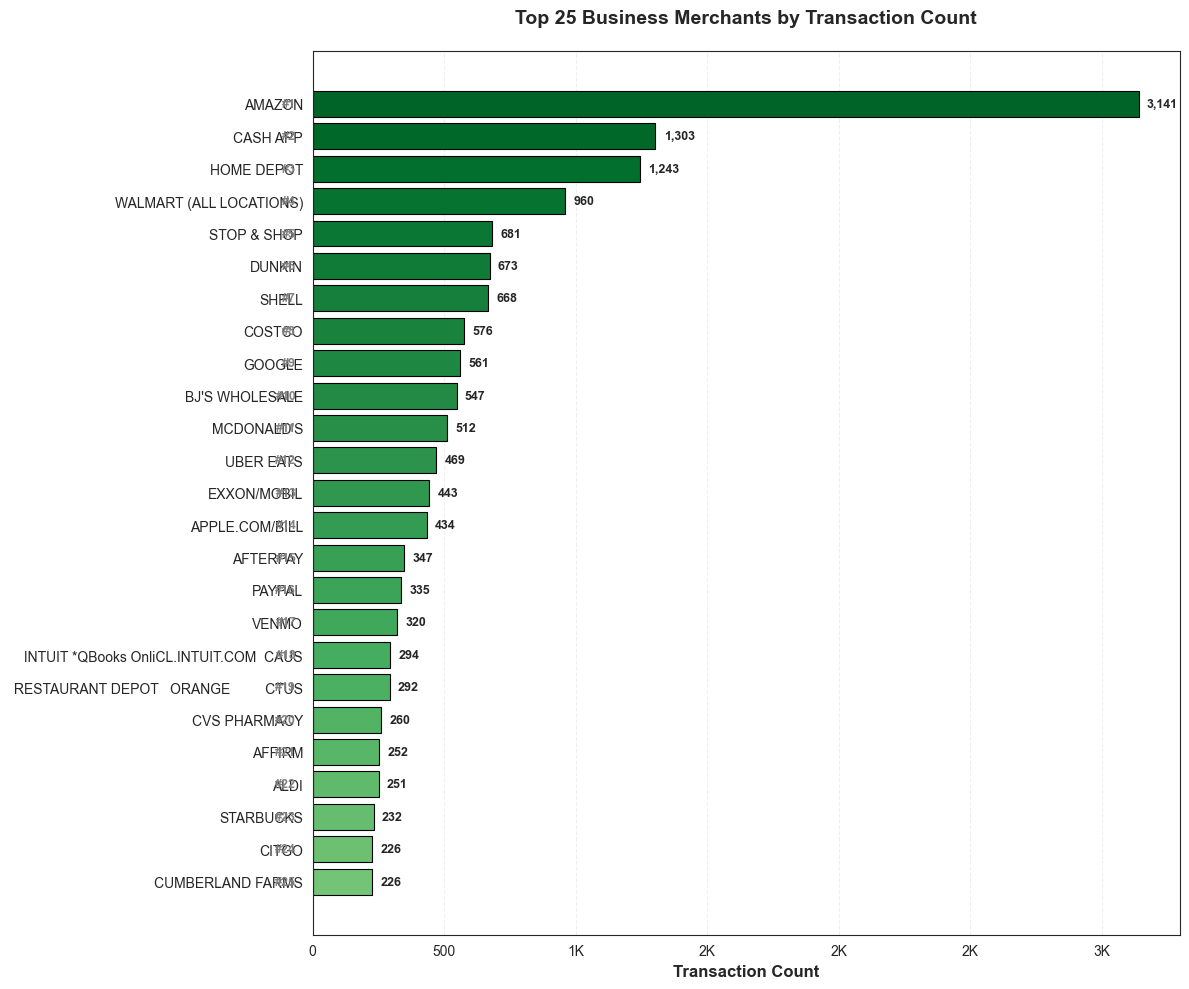

In [52]:
# ===========================================================================
# M3B VISUALIZATION - Top 25 Business Merchants by Transaction Count
# ===========================================================================

fig, ax = plt.subplots(figsize=(12, 10))

# Get top 25 and reverse order so #1 is at top
top_25 = top_business_trans.head(25).iloc[::-1]

merchants = [m[:40] + '...' if len(m) > 40 else m for m in top_25.index]
values = top_25['transaction_count'].values

# Color gradient
colors = plt.cm.Greens(np.linspace(0.5, 0.9, 25))

bars = ax.barh(range(25), values, color=colors, edgecolor='black', linewidth=0.8)
ax.set_yticks(range(25))
ax.set_yticklabels(merchants, fontsize=10)
ax.set_xlabel('Transaction Count', fontsize=12, fontweight='bold')
ax.set_title('Top 25 Business Merchants by Transaction Count', fontsize=14, fontweight='bold', pad=20)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, values)):
    ax.text(value + max(values)*0.01, bar.get_y() + bar.get_height()/2, 
            f'{value:,.0f}', va='center', fontsize=9, fontweight='bold')

# Format x-axis
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}K' if x >= 1000 else f'{x:.0f}'))
ax.grid(axis='x', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

# Add rank labels on left side
for i, rank in enumerate(range(25, 0, -1)):
    ax.text(-max(values)*0.02, i, f'#{rank}', 
            ha='right', va='center', fontsize=9, fontweight='bold', color='gray')

plt.tight_layout()
plt.show()

### Accounts - Business - TOP 50 MERCHANTS BY UNIQUE ACCOUNTS

In [53]:
# ===========================================================================
# M3C - TOP 50 BUSINESS MERCHANTS BY UNIQUE ACCOUNT COUNT
# ===========================================================================
"""
## M3C: Top 50 Business Merchants by Unique Account Count (Consolidated)
"""

top_business_accounts = business_df.groupby('merchant_consolidated').agg({
    'amount': ['sum', 'count', 'mean'],
    'primary_account_num': 'nunique'
}).round(2)

top_business_accounts.columns = ['total_amount', 'transaction_count', 'avg_transaction', 'unique_accounts']
top_business_accounts = top_business_accounts.sort_values('unique_accounts', ascending=False).head(50)

# Format for display
display_df = top_business_accounts.reset_index()
display_df = display_df.rename(columns={
    'merchant_consolidated': 'Merchant',
    'unique_accounts': 'Unique Accounts',
    'transaction_count': 'Transactions',
    'total_amount': 'Total Spend',
    'avg_transaction': 'Avg Transaction'
})

# Format columns
display_df['Total Spend'] = display_df['Total Spend'].apply(lambda x: f"${x:,.0f}")
display_df['Avg Transaction'] = display_df['Avg Transaction'].apply(lambda x: f"${x:.2f}")

print("\n" + "="*100)
print(" " * 28 + "TOP 50 BUSINESS MERCHANTS BY UNIQUE ACCOUNT COUNT")
print("="*100)

display(display_df)

# Summary stats
total_spend = top_business_accounts['total_amount'].sum()
total_transactions = top_business_accounts['transaction_count'].sum()
total_accounts = top_business_accounts['unique_accounts'].sum()

summary = pd.DataFrame({
    'Metric': [
        'Total Business Accounts (Top 50)',
        'Total Transactions (Top 50)',
        'Total Spend (Top 50)'
    ],
    'Value': [
        f"{total_accounts:,.0f}",
        f"{total_transactions:,.0f}",
        f"${total_spend:,.0f}"
    ]
})

print("\n")
display(summary)
print("="*100)


                            TOP 50 BUSINESS MERCHANTS BY UNIQUE ACCOUNT COUNT


Merchant Total Spend  Transactions  \
0                                    AMAZON    $183,643          3141   
1                   WALMART (ALL LOCATIONS)     $81,293           960   
2                                HOME DEPOT    $130,609          1243   
3                               STOP & SHOP     $32,459           681   
4    CT SECRETARY OF STA860-5096151    CTUS     $17,395           202   
5                                    DUNKIN      $5,780           673   
6                               EXXON/MOBIL     $31,924           443   
7                                     SHELL     $22,817           668   
8                                MCDONALD'S      $5,336           512   
9                              CVS PHARMACY      $9,650           260   
10                                WALGREENS      $5,721           186   
11                                   PAYPAL     $33,491           335   
12                                    CITGO      $6,549           226   
13                              DOLLAR TREE      $2,926           154   
14                                   GOOGLE     $13,829           561   
15                           BJ'S WHOLESALE     $42,249           547   
16                         CUMBERLAND FARMS      $7,460           226   
17                                   LOWE'S     $32,854           204   
18                                  HBO MAX      $9,237           124   
19                                 CASH APP    $216,406          1303   
20                   TARGET (ALL LOCATIONS)     $10,079           155   
21                                   COSTCO     $50,091           576   
22                                   SUNOCO      $5,491           176   
23   INTUIT *QBooks OnliCL.INTUIT.COM  CAUS     $13,409           294   
24                                     ALDI     $13,683           251   
25                              BURGER KING      $1,442           120   
26                              WALMART.COM     $10,550           137   
27                                MARSHALLS      $4,504            60   
28                                      DMV      $5,699            44   
29                                     UBER      $5,670           186   
30                              CHICK-FIL-A      $5,838           115   
31                                STARBUCKS      $4,166           232   
32                                 7-ELEVEN      $4,589           200   
33                           DOLLAR GENERAL      $2,538           149   
34                                 MICHAELS      $4,128            97   
35                           APPLE.COM/BILL      $7,525           434   
36                                    VENMO     $58,367           320   
37                             AMAZON PRIME      $3,116           160   
38                                     ETSY      $1,638            63   
39                          COMCAST/XFINITY     $24,980           163   
40                              HOBBY LOBBY      $3,629            99   
41                                  POPEYES      $1,201            59   
42   Staples Inc        staples.com    MAUS      $4,678            45   
43                            FAMILY DOLLAR      $1,074            54   
44   ACI*CT DOR MYCONNEC925-855-5000   CTUS     $15,235            43   
45   RESTAURANT DEPOT   ORANGE         CTUS    $123,495           292   
46                               BURLINGTON      $2,879            38   
47   BIG Y 77 NORTH H   NORTH HAVEN    CTUS      $6,789           165   
48   OPC TAX*SERVICE FEE800-487-4567   NEUS        $181            43   
49   STAPLES 0446       HAMDEN         CTUS      $1,935            31   

   Avg Transaction  Unique Accounts  
0           $58.47              165  
1           $84.68              134  
2          $105.08              117  
3           $47.66              116  
4           $86.11              101  
5            $8.59               89  
6           $72.06               81  
7      

Metric       Value
0  Total Business Accounts (Top 50)       2,461
1       Total Transactions (Top 50)      17,450
2              Total Spend (Top 50)  $1,290,229

#### Viz - Top 25 Business Merchants by Unique Accounts

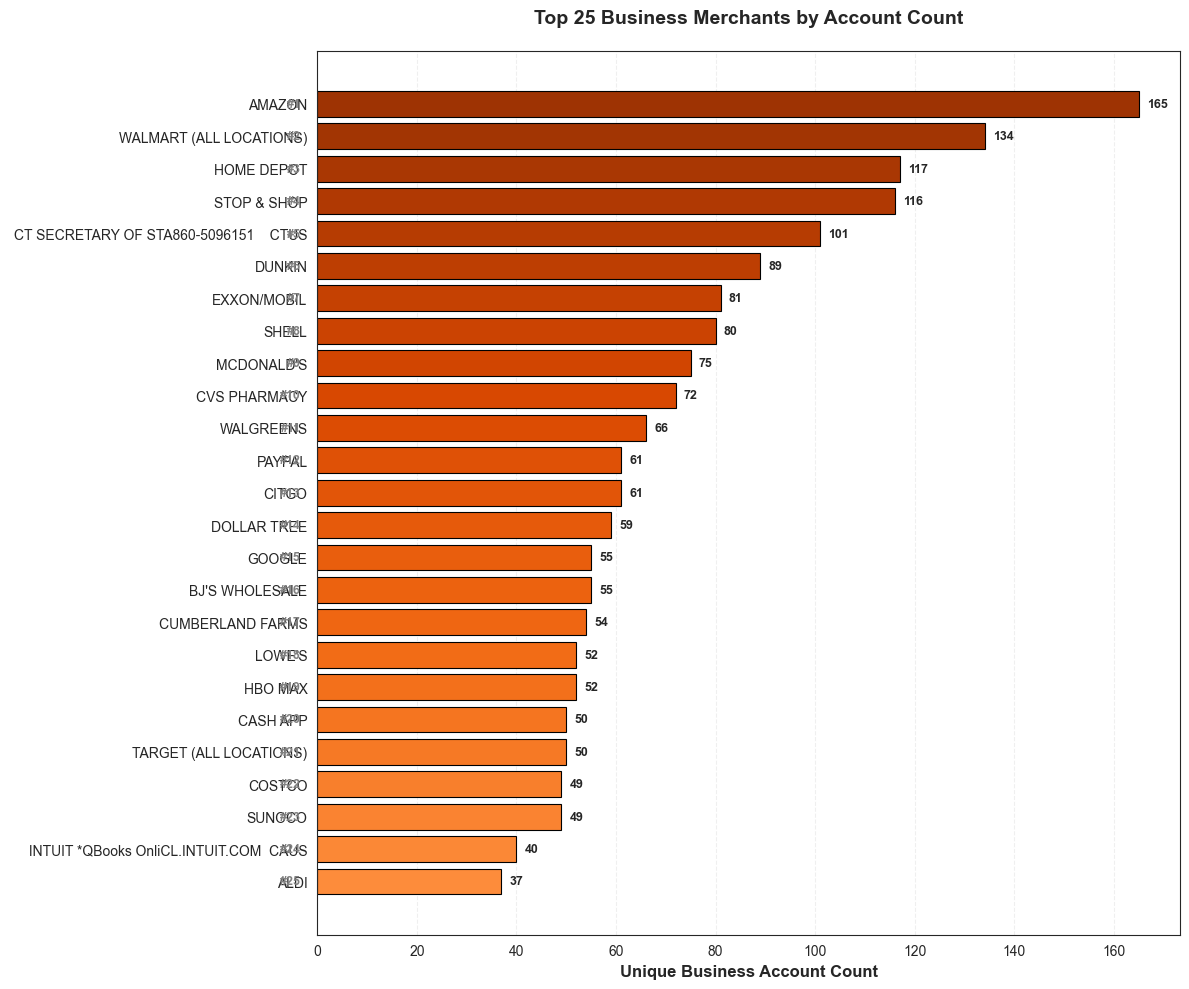

In [54]:
# ===========================================================================
# M3C VISUALIZATION - Top 25 Business Merchants by Unique Accounts
# ===========================================================================

fig, ax = plt.subplots(figsize=(12, 10))

# Get top 25 and reverse order so #1 is at top
top_25 = top_business_accounts.head(25).iloc[::-1]

merchants = [m[:40] + '...' if len(m) > 40 else m for m in top_25.index]
values = top_25['unique_accounts'].values

# Color gradient
colors = plt.cm.Oranges(np.linspace(0.5, 0.9, 25))

bars = ax.barh(range(25), values, color=colors, edgecolor='black', linewidth=0.8)
ax.set_yticks(range(25))
ax.set_yticklabels(merchants, fontsize=10)
ax.set_xlabel('Unique Business Account Count', fontsize=12, fontweight='bold')
ax.set_title('Top 25 Business Merchants by Account Count', fontsize=14, fontweight='bold', pad=20)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, values)):
    ax.text(value + max(values)*0.01, bar.get_y() + bar.get_height()/2, 
            f'{int(value):,}', va='center', fontsize=9, fontweight='bold')

# Format x-axis
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.1f}K' if x >= 1000 else f'{x:.0f}'))
ax.grid(axis='x', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

# Add rank labels on left side
for i, rank in enumerate(range(25, 0, -1)):
    ax.text(-max(values)*0.02, i, f'#{rank}', 
            ha='right', va='center', fontsize=9, fontweight='bold', color='gray')

plt.tight_layout()
plt.show()

## 4 - Personal Analysis

### Spend - Personal - Top 50 merchants overall

In [55]:
# ===========================================================================
# M4A - TOP 50 PERSONAL MERCHANTS BY TOTAL SPEND
# ===========================================================================
"""
## M4A: Top 50 Personal Merchants by Total Spend (Consolidated)
Analysis of merchants used by personal accounts only
"""

# Use consolidated merchant names for personal data
top_personal_spend = personal_df.groupby('merchant_consolidated').agg({
    'amount': ['sum', 'count', 'mean'],
    'primary_account_num': 'nunique'
}).round(2)

top_personal_spend.columns = ['total_amount', 'transaction_count', 'avg_transaction', 'unique_accounts']
top_personal_spend = top_personal_spend.sort_values('total_amount', ascending=False).head(50)

# Format for display
display_df = top_personal_spend.reset_index()
display_df = display_df.rename(columns={
    'merchant_consolidated': 'Merchant',
    'total_amount': 'Total Spend',
    'transaction_count': 'Transactions',
    'avg_transaction': 'Avg Transaction',
    'unique_accounts': 'Unique Accounts'
})

# Format columns
display_df['Total Spend'] = display_df['Total Spend'].apply(lambda x: f"${x:,.0f}")
display_df['Avg Transaction'] = display_df['Avg Transaction'].apply(lambda x: f"${x:.2f}")

print("\n" + "="*100)
print(" " * 30 + "TOP 50 PERSONAL MERCHANTS BY TOTAL SPEND")
print("="*100)

display(display_df.style.hide(axis='index'))

# Summary stats
total_spend = top_personal_spend['total_amount'].sum()
total_transactions = top_personal_spend['transaction_count'].sum()
total_accounts = top_personal_spend['unique_accounts'].sum()

# Calculate % of total personal spend
personal_total = personal_df['amount'].sum()
top_50_pct = (total_spend / personal_total) * 100

summary = pd.DataFrame({
    'Metric': [
        'Total Spend (Top 50)',
        '% of Total Personal Spend',
        'Total Transactions (Top 50)',
        'Total Personal Accounts (Top 50)',
        'Total Personal Spend (All)',
        'Total Personal Accounts (All)'
    ],
    'Value': [
        f"${total_spend:,.0f}",
        f"{top_50_pct:.1f}%",
        f"{total_transactions:,.0f}",
        f"{total_accounts:,.0f}",
        f"${personal_total:,.0f}",
        f"{personal_df['primary_account_num'].nunique():,}"
    ]
})

print("\n")
display(summary.style.hide(axis='index'))
print("="*100)


                              TOP 50 PERSONAL MERCHANTS BY TOTAL SPEND


#### Viz - Top 25 Personal Merchants by Spend

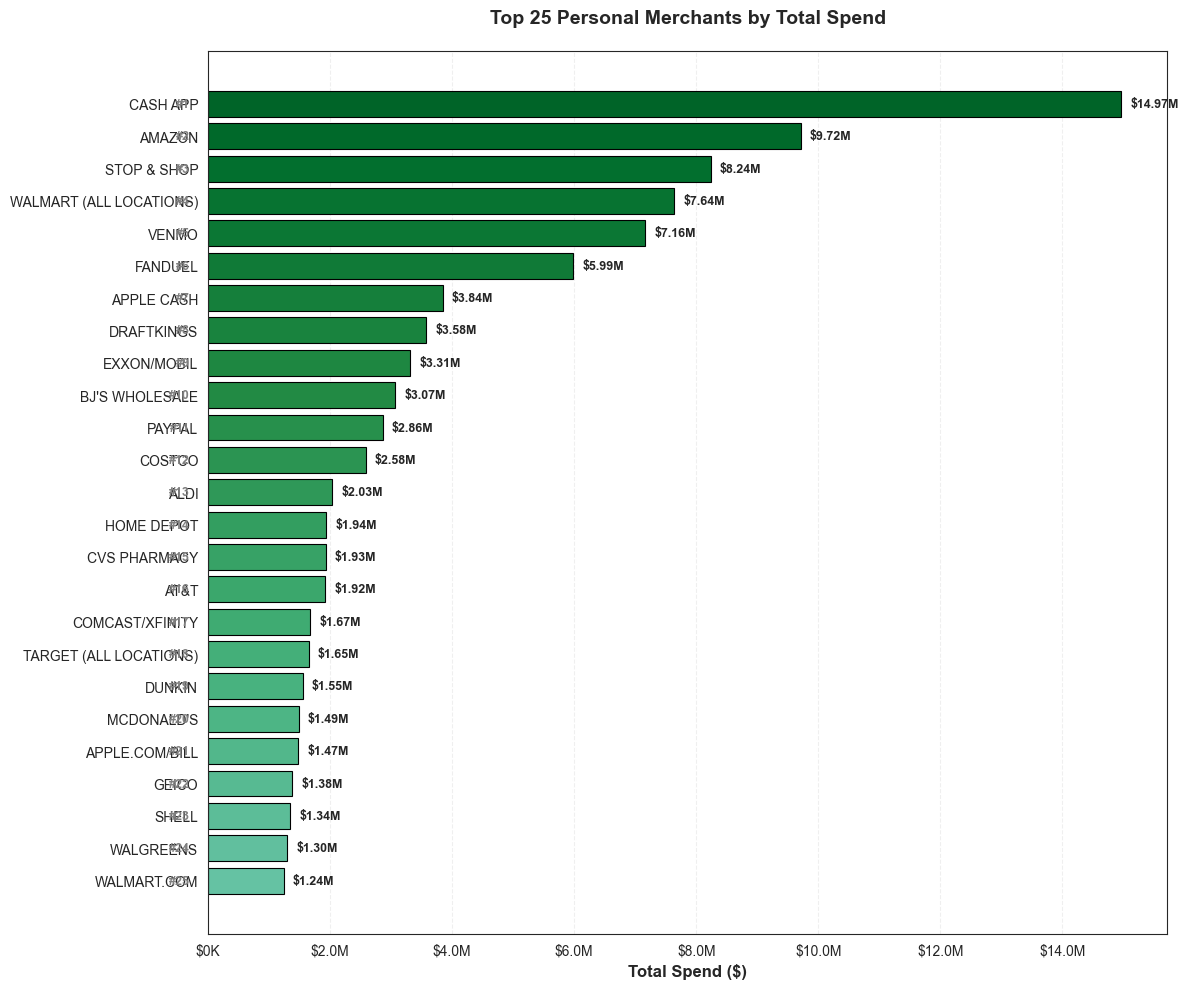

In [56]:
# ===========================================================================
# M4A VISUALIZATION - Top 25 Personal Merchants by Spend
# ===========================================================================

fig, ax = plt.subplots(figsize=(12, 10))

# Get top 25 and reverse order so #1 is at top
top_25 = top_personal_spend.head(25).iloc[::-1]

merchants = [m[:40] + '...' if len(m) > 40 else m for m in top_25.index]
values = top_25['total_amount'].values

# Color gradient - teal theme for personal
colors = plt.cm.BuGn(np.linspace(0.5, 0.9, 25))

bars = ax.barh(range(25), values, color=colors, edgecolor='black', linewidth=0.8)
ax.set_yticks(range(25))
ax.set_yticklabels(merchants, fontsize=10)
ax.set_xlabel('Total Spend ($)', fontsize=12, fontweight='bold')
ax.set_title('Top 25 Personal Merchants by Total Spend', fontsize=14, fontweight='bold', pad=20)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, values)):
    ax.text(value + max(values)*0.01, bar.get_y() + bar.get_height()/2, 
            f'${value/1e6:.2f}M' if value >= 1e6 else f'${value/1e3:.1f}K', 
            va='center', fontsize=9, fontweight='bold')

# Format x-axis
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M' if x >= 1e6 else f'${x/1e3:.0f}K'))
ax.grid(axis='x', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

# Add rank labels on left side
for i, rank in enumerate(range(25, 0, -1)):
    ax.text(-max(values)*0.02, i, f'#{rank}', 
            ha='right', va='center', fontsize=9, fontweight='bold', color='gray')

plt.tight_layout()
plt.show()

### Transactions - Personal - TOP 50 MERCHANTS BY TRANSACTION COUNT


In [57]:
# ===========================================================================
# M4B - TOP 50 PERSONAL MERCHANTS BY TRANSACTION COUNT
# ===========================================================================
"""
## M4B: Top 50 Personal Merchants by Transaction Count (Consolidated)
"""

top_personal_trans = personal_df.groupby('merchant_consolidated').agg({
    'amount': ['sum', 'count', 'mean'],
    'primary_account_num': 'nunique'
}).round(2)

top_personal_trans.columns = ['total_amount', 'transaction_count', 'avg_transaction', 'unique_accounts']
top_personal_trans = top_personal_trans.sort_values('transaction_count', ascending=False).head(50)

# Format for display
display_df = top_personal_trans.reset_index()
display_df = display_df.rename(columns={
    'merchant_consolidated': 'Merchant',
    'transaction_count': 'Transactions',
    'total_amount': 'Total Spend',
    'avg_transaction': 'Avg Transaction',
    'unique_accounts': 'Unique Accounts'
})

# Format columns
display_df['Total Spend'] = display_df['Total Spend'].apply(lambda x: f"${x:,.0f}")
display_df['Avg Transaction'] = display_df['Avg Transaction'].apply(lambda x: f"${x:.2f}")

print("\n" + "="*100)
print(" " * 28 + "TOP 50 PERSONAL MERCHANTS BY TRANSACTION COUNT")
print("="*100)

display(display_df.style.hide(axis='index'))

# Summary stats
total_spend = top_personal_trans['total_amount'].sum()
total_transactions = top_personal_trans['transaction_count'].sum()
total_accounts = top_personal_trans['unique_accounts'].sum()

summary = pd.DataFrame({
    'Metric': [
        'Total Transactions (Top 50)',
        'Total Spend (Top 50)',
        'Total Personal Accounts (Top 50)'
    ],
    'Value': [
        f"{total_transactions:,.0f}",
        f"${total_spend:,.0f}",
        f"{total_accounts:,.0f}"
    ]
})

print("\n")
display(summary.style.hide(axis='index'))
print("="*100)


                            TOP 50 PERSONAL MERCHANTS BY TRANSACTION COUNT


#### Viz - Top 25 Personal Merchants by Transaction

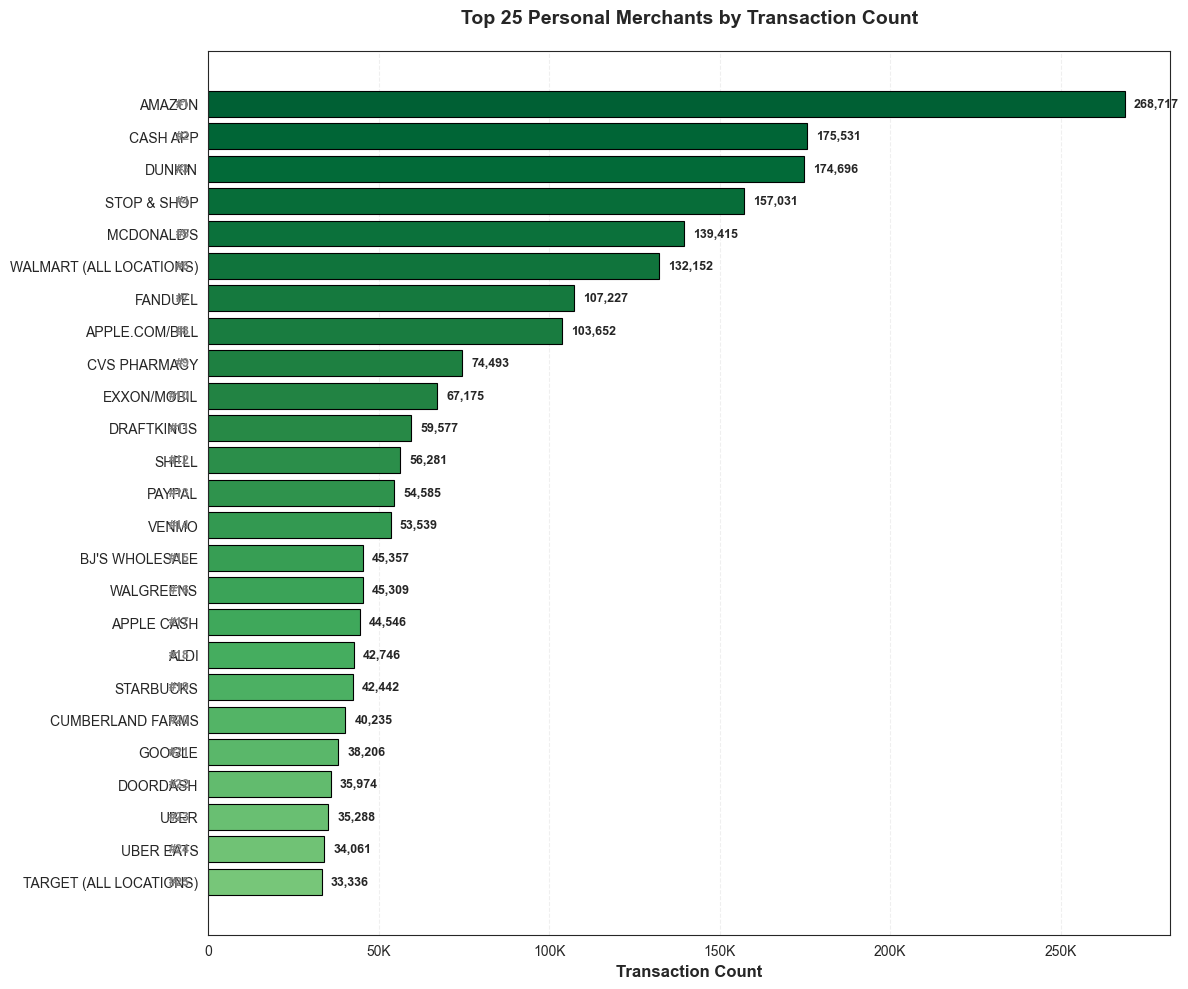

In [58]:
# ===========================================================================
# M4B VISUALIZATION - Top 25 Personal Merchants by Transaction Count
# ===========================================================================

fig, ax = plt.subplots(figsize=(12, 10))

# Get top 25 and reverse order so #1 is at top
top_25 = top_personal_trans.head(25).iloc[::-1]

merchants = [m[:40] + '...' if len(m) > 40 else m for m in top_25.index]
values = top_25['transaction_count'].values

# Color gradient
colors = plt.cm.YlGn(np.linspace(0.5, 0.9, 25))

bars = ax.barh(range(25), values, color=colors, edgecolor='black', linewidth=0.8)
ax.set_yticks(range(25))
ax.set_yticklabels(merchants, fontsize=10)
ax.set_xlabel('Transaction Count', fontsize=12, fontweight='bold')
ax.set_title('Top 25 Personal Merchants by Transaction Count', fontsize=14, fontweight='bold', pad=20)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, values)):
    ax.text(value + max(values)*0.01, bar.get_y() + bar.get_height()/2, 
            f'{value:,.0f}', va='center', fontsize=9, fontweight='bold')

# Format x-axis
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}K' if x >= 1000 else f'{x:.0f}'))
ax.grid(axis='x', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

# Add rank labels on left side
for i, rank in enumerate(range(25, 0, -1)):
    ax.text(-max(values)*0.02, i, f'#{rank}', 
            ha='right', va='center', fontsize=9, fontweight='bold', color='gray')

plt.tight_layout()
plt.show()

### Accounts - Personal - TOP 50 MERCHANTS BY UNIQUE ACCOUNTS

In [59]:
# ===========================================================================
# M4C - TOP 50 PERSONAL MERCHANTS BY UNIQUE ACCOUNT COUNT
# ===========================================================================
"""
## M4C: Top 50 Personal Merchants by Unique Account Count (Consolidated)
"""

top_personal_accounts = personal_df.groupby('merchant_consolidated').agg({
    'amount': ['sum', 'count', 'mean'],
    'primary_account_num': 'nunique'
}).round(2)

top_personal_accounts.columns = ['total_amount', 'transaction_count', 'avg_transaction', 'unique_accounts']
top_personal_accounts = top_personal_accounts.sort_values('unique_accounts', ascending=False).head(50)

# Format for display
display_df = top_personal_accounts.reset_index()
display_df = display_df.rename(columns={
    'merchant_consolidated': 'Merchant',
    'unique_accounts': 'Unique Accounts',
    'transaction_count': 'Transactions',
    'total_amount': 'Total Spend',
    'avg_transaction': 'Avg Transaction'
})

# Format columns
display_df['Total Spend'] = display_df['Total Spend'].apply(lambda x: f"${x:,.0f}")
display_df['Avg Transaction'] = display_df['Avg Transaction'].apply(lambda x: f"${x:.2f}")

print("\n" + "="*100)
print(" " * 28 + "TOP 50 PERSONAL MERCHANTS BY UNIQUE ACCOUNT COUNT")
print("="*100)

display(display_df.style.hide(axis='index'))

# Summary stats
total_spend = top_personal_accounts['total_amount'].sum()
total_transactions = top_personal_accounts['transaction_count'].sum()
total_accounts = top_personal_accounts['unique_accounts'].sum()

summary = pd.DataFrame({
    'Metric': [
        'Total Personal Accounts (Top 50)',
        'Total Transactions (Top 50)',
        'Total Spend (Top 50)'
    ],
    'Value': [
        f"{total_accounts:,.0f}",
        f"{total_transactions:,.0f}",
        f"${total_spend:,.0f}"
    ]
})

print("\n")
display(summary.style.hide(axis='index'))
print("="*100)


                            TOP 50 PERSONAL MERCHANTS BY UNIQUE ACCOUNT COUNT


#### Viz - Top 25 Personal Merchants by Unique Accounts

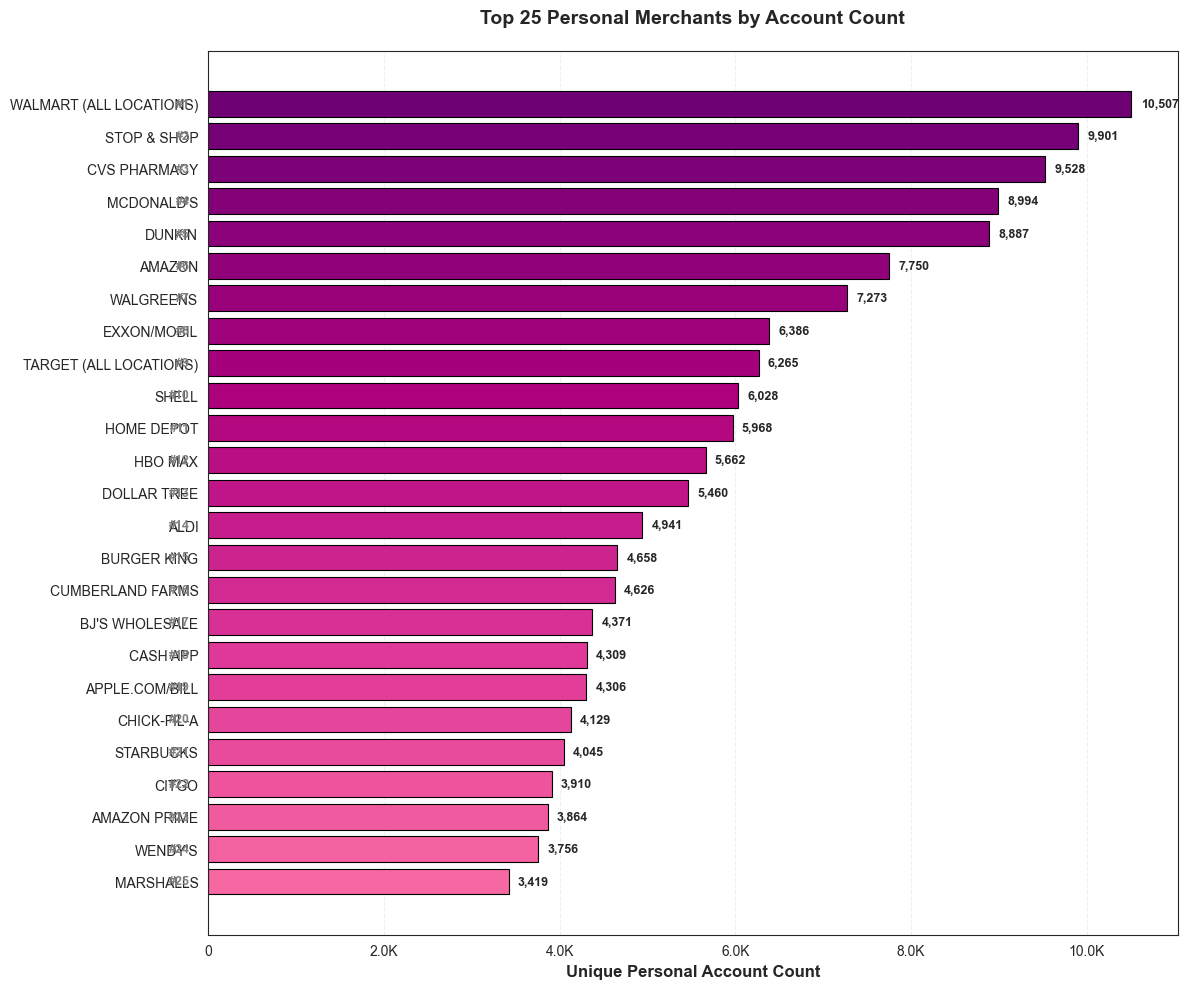

In [60]:
# ===========================================================================
# M4C VISUALIZATION - Top 25 Personal Merchants by Unique Accounts
# ===========================================================================

fig, ax = plt.subplots(figsize=(12, 10))

# Get top 25 and reverse order so #1 is at top
top_25 = top_personal_accounts.head(25).iloc[::-1]

merchants = [m[:40] + '...' if len(m) > 40 else m for m in top_25.index]
values = top_25['unique_accounts'].values

# Color gradient
colors = plt.cm.RdPu(np.linspace(0.5, 0.9, 25))

bars = ax.barh(range(25), values, color=colors, edgecolor='black', linewidth=0.8)
ax.set_yticks(range(25))
ax.set_yticklabels(merchants, fontsize=10)
ax.set_xlabel('Unique Personal Account Count', fontsize=12, fontweight='bold')
ax.set_title('Top 25 Personal Merchants by Account Count', fontsize=14, fontweight='bold', pad=20)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, values)):
    ax.text(value + max(values)*0.01, bar.get_y() + bar.get_height()/2, 
            f'{int(value):,}', va='center', fontsize=9, fontweight='bold')

# Format x-axis
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.1f}K' if x >= 1000 else f'{x:.0f}'))
ax.grid(axis='x', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

# Add rank labels on left side
for i, rank in enumerate(range(25, 0, -1)):
    ax.text(-max(values)*0.02, i, f'#{rank}', 
            ha='right', va='center', fontsize=9, fontweight='bold', color='gray')

plt.tight_layout()
plt.show()

## 5 - Monthly Merchant

### MONTHLY RANK TRACKING - TOP MERCHANTS

In [61]:
# M5A: MONTHLY RANK TRACKING - TOP MERCHANTS
# Shows how top merchants move up/down in rankings month-over-month
print("\n" + "="*120)
print(" " * 40 + "M5A: MONTHLY RANK TRACKING - TOP MERCHANTS")
print("="*120)

# Get monthly rankings for all merchants
sorted_months = sorted(combined_df['year_month'].unique())
monthly_rankings = {}

for month in sorted_months:
    month_data = combined_df[combined_df['year_month'] == month]
    rankings = month_data.groupby('merchant_consolidated').agg({
        'amount': 'sum'
    }).sort_values('amount', ascending=False)
    
    # Store rank for each merchant
    for rank, merchant in enumerate(rankings.index, 1):
        if merchant not in monthly_rankings:
            monthly_rankings[merchant] = {}
        monthly_rankings[merchant][month] = rank

# Get merchants that appear in top 50 at any point
top_merchants = set()
for month in sorted_months:
    month_data = combined_df[combined_df['year_month'] == month]
    top_50 = month_data.groupby('merchant_consolidated')['amount'].sum().nlargest(50)
    top_merchants.update(top_50.index)

# Create ranking matrix
rank_matrix = []
for merchant in top_merchants:
    row = {'merchant': merchant}
    for month in sorted_months:
        row[month] = monthly_rankings.get(merchant, {}).get(month, None)
    rank_matrix.append(row)

# Convert to DataFrame
rank_df = pd.DataFrame(rank_matrix)

# Calculate average rank and consistency
rank_df['avg_rank'] = rank_df[sorted_months].mean(axis=1, skipna=True)
rank_df['months_in_top_50'] = rank_df[sorted_months].apply(lambda x: (x <= 50).sum(), axis=1)

# Sort by average rank
rank_df = rank_df.sort_values('avg_rank').head(50)

print("\n📊 TOP 50 MERCHANTS BY AVERAGE RANK ACROSS ALL MONTHS")
print("="*120)

# Display table
display_df = rank_df.copy()
display_df['merchant'] = display_df['merchant'].str[:45]

# Format rank columns
for month in sorted_months:
    display_df[month] = display_df[month].apply(lambda x: f"#{int(x)}" if pd.notna(x) and x <= 50 else "-")

display_df['avg_rank'] = display_df['avg_rank'].apply(lambda x: f"#{x:.1f}")
display_df = display_df.rename(columns={
    'merchant': 'Merchant',
    'avg_rank': 'Avg Rank',
    'months_in_top_50': 'Months in Top 50'
})

# Reorder columns
cols = ['Merchant'] + [month for month in sorted_months] + ['Avg Rank', 'Months in Top 50']
display_df = display_df[cols]

display(display_df.style.hide(axis='index'))




                                        M5A: MONTHLY RANK TRACKING - TOP MERCHANTS

📊 TOP 50 MERCHANTS BY AVERAGE RANK ACROSS ALL MONTHS


#### Viz - Merchant Movement


📈 RANK MOVEMENT VISUALIZATION


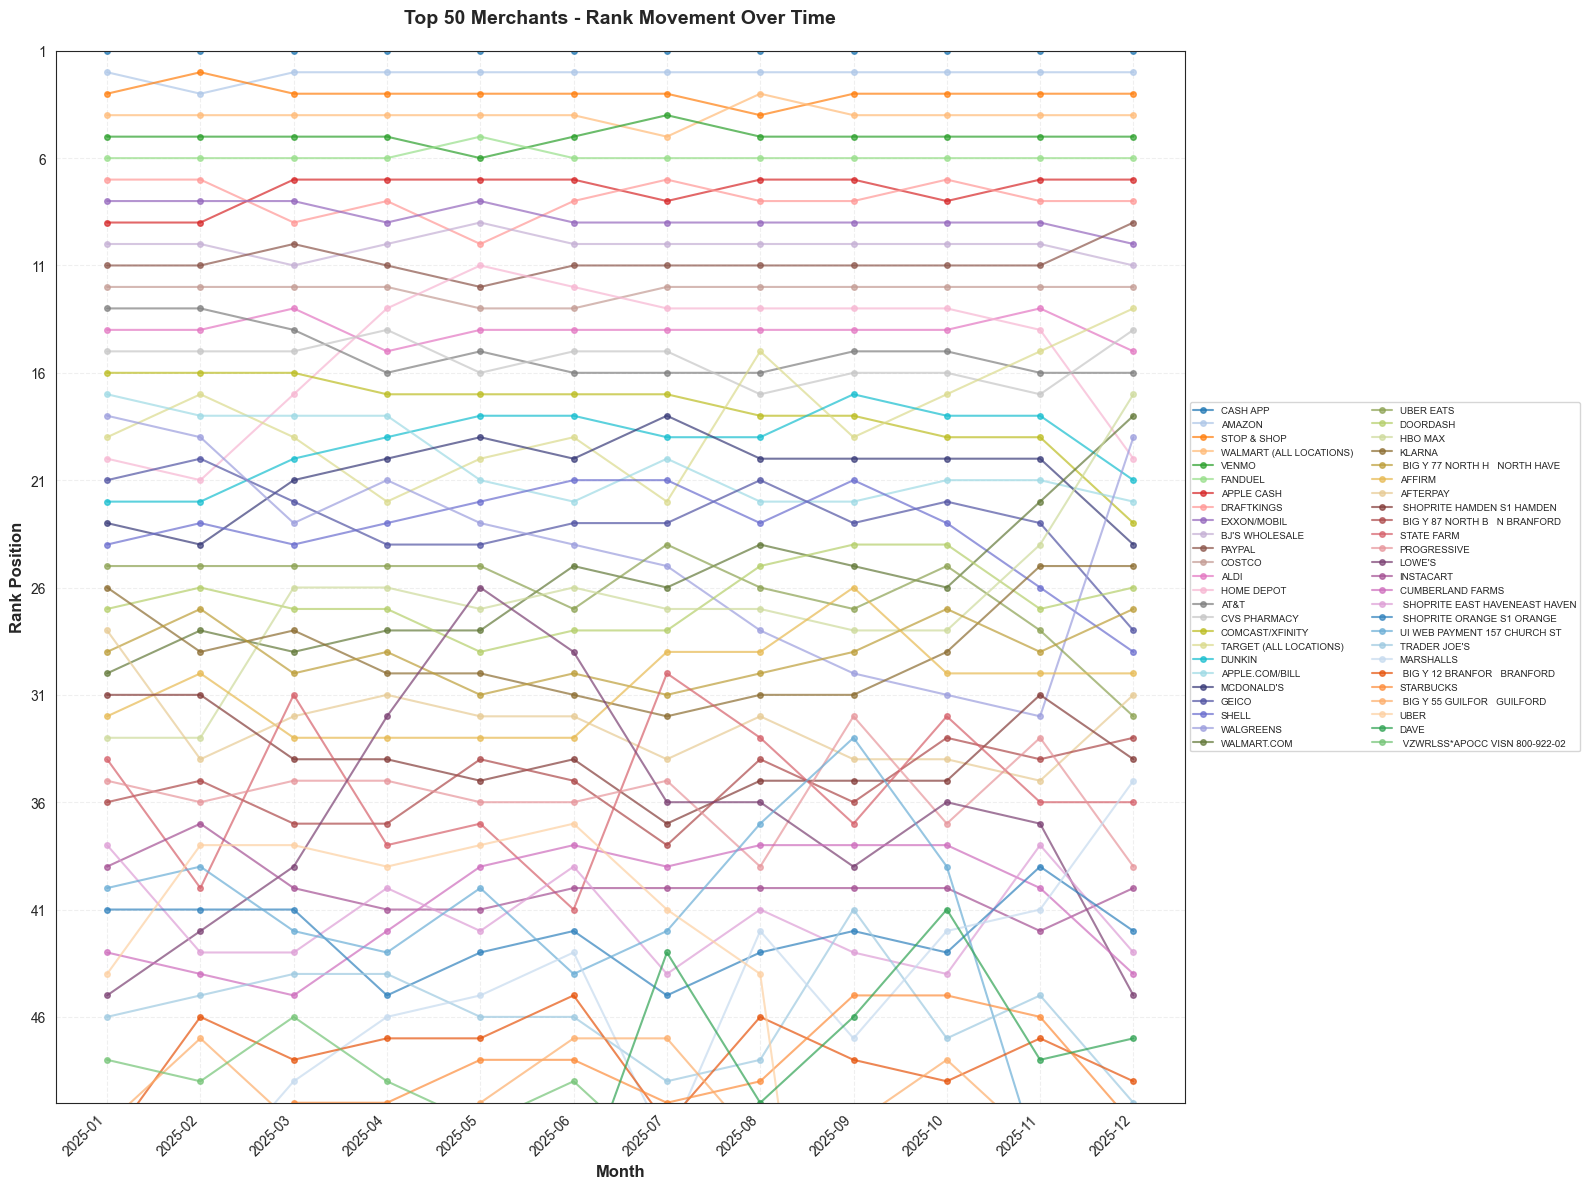


💡 KEY INSIGHTS:
------------------------------------------------------------------------------------------------------------------------
   • Top 50 merchants tracked across 12 months
   • Chart shows rank movement for all top 50 performers
   • Lower position on chart = higher rank (#1 at top)
   • Multiple colors distinguish individual merchant trajectories


In [62]:
print("\n" + "="*120)
print("📈 RANK MOVEMENT VISUALIZATION")
print("="*120)

# Create line chart showing rank changes for top 50 merchants
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 12))

# Get top 50 by average rank
top_50_merchants = rank_df.nsmallest(50, 'avg_rank')

# Use a larger color palette
colors = plt.cm.tab20(range(20))
colors2 = plt.cm.tab20b(range(20))
colors3 = plt.cm.tab20c(range(10))
all_colors = list(colors) + list(colors2) + list(colors3)

for idx, (_, row) in enumerate(top_50_merchants.iterrows()):
    merchant = row['merchant']
    ranks = [row[month] for month in sorted_months]
    
    # Convert None to NaN for plotting
    ranks = [r if r is not None else float('nan') for r in ranks]
    
    # Plot line - thinner lines for 50 merchants
    ax.plot(range(len(sorted_months)), ranks, 
            marker='o', linewidth=1.5, markersize=4,
            label=merchant[:30], color=all_colors[idx % len(all_colors)], alpha=0.7)

# Invert y-axis (rank 1 at top)
ax.invert_yaxis()
ax.set_ylabel('Rank Position', fontsize=12, fontweight='bold')
ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_title('Top 50 Merchants - Rank Movement Over Time', fontsize=14, fontweight='bold', pad=20)

# Set x-axis
ax.set_xticks(range(len(sorted_months)))
ax.set_xticklabels([str(m) for m in sorted_months], rotation=45, ha='right')

# Set y-axis to show ranks 1-50
ax.set_ylim(50, 1)
ax.set_yticks(range(1, 51, 5))

# Grid
ax.grid(True, alpha=0.3, linestyle='--')

# Legend - split into 2 columns for better readability
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=7, ncol=2)

plt.tight_layout()
plt.show()

print("\n💡 KEY INSIGHTS:")
print("-"*120)
print(f"   • Top 50 merchants tracked across {len(sorted_months)} months")
print(f"   • Chart shows rank movement for all top 50 performers")
print(f"   • Lower position on chart = higher rank (#1 at top)")
print(f"   • Multiple colors distinguish individual merchant trajectories")
print("="*120)

### GROWTH LEADERS & DECLINERS

In [63]:
# M5B-1: GROWTH LEADERS & DECLINERS - ANALYSIS
# Identifies merchants with biggest month-over-month spend changes
print("\n" + "="*120)
print(" " * 40 + "M5B-1: GROWTH LEADERS & DECLINERS - ANALYSIS")
print("="*120)

# Calculate month-over-month changes for each merchant
sorted_months = sorted(combined_df['year_month'].unique())

growth_data = []

for i in range(1, len(sorted_months)):
    prev_month = sorted_months[i-1]
    curr_month = sorted_months[i]
    
    # Previous month spending
    prev_spend = combined_df[combined_df['year_month'] == prev_month].groupby('merchant_consolidated')['amount'].sum()
    
    # Current month spending
    curr_spend = combined_df[combined_df['year_month'] == curr_month].groupby('merchant_consolidated')['amount'].sum()
    
    # Calculate changes for merchants in both months
    for merchant in set(prev_spend.index) & set(curr_spend.index):
        prev_amt = prev_spend[merchant]
        curr_amt = curr_spend[merchant]
        change_amt = curr_amt - prev_amt
        change_pct = (change_amt / prev_amt * 100) if prev_amt > 0 else 0
        
        # Only include significant merchants (min $1000 in either month)
        if max(prev_amt, curr_amt) >= 1000:
            growth_data.append({
                'merchant': merchant,
                'month_pair': f"{prev_month} → {curr_month}",
                'prev_month': prev_month,
                'curr_month': curr_month,
                'prev_spend': prev_amt,
                'curr_spend': curr_amt,
                'change_amount': change_amt,
                'change_percent': change_pct
            })

growth_df = pd.DataFrame(growth_data)

# TOP GROWTH LEADERS
print("\n📈 TOP 50 GROWTH LEADERS (Largest $ Increases)")
print("="*120)

top_growth = growth_df.nlargest(50, 'change_amount').copy()
top_growth['merchant'] = top_growth['merchant'].str[:40]
top_growth_display = top_growth[[
    'merchant', 'month_pair', 'prev_spend', 'curr_spend', 'change_amount', 'change_percent'
]].copy()

top_growth_display.columns = ['Merchant', 'Period', 'Previous Month', 'Current Month', 'Change ($)', 'Change (%)']

# Format currency and percentages
top_growth_display['Previous Month'] = top_growth_display['Previous Month'].apply(lambda x: f"${x:,.0f}")
top_growth_display['Current Month'] = top_growth_display['Current Month'].apply(lambda x: f"${x:,.0f}")
top_growth_display['Change ($)'] = top_growth_display['Change ($)'].apply(lambda x: f"${x:,.0f}")
top_growth_display['Change (%)'] = top_growth_display['Change (%)'].apply(lambda x: f"{x:,.1f}%")

display(top_growth_display.style.hide(axis='index'))

print("\n" + "="*120)

# TOP DECLINERS
print("\n📉 TOP 50 DECLINERS (Largest $ Decreases)")
print("="*120)

top_decline = growth_df.nsmallest(50, 'change_amount').copy()
top_decline['merchant'] = top_decline['merchant'].str[:40]
top_decline_display = top_decline[[
    'merchant', 'month_pair', 'prev_spend', 'curr_spend', 'change_amount', 'change_percent'
]].copy()

top_decline_display.columns = ['Merchant', 'Period', 'Previous Month', 'Current Month', 'Change ($)', 'Change (%)']

# Format currency and percentages
top_decline_display['Previous Month'] = top_decline_display['Previous Month'].apply(lambda x: f"${x:,.0f}")
top_decline_display['Current Month'] = top_decline_display['Current Month'].apply(lambda x: f"${x:,.0f}")
top_decline_display['Change ($)'] = top_decline_display['Change ($)'].apply(lambda x: f"${x:,.0f}")
top_decline_display['Change (%)'] = top_decline_display['Change (%)'].apply(lambda x: f"{x:,.1f}%")

display(top_decline_display.style.hide(axis='index'))

print("\n💡 SUMMARY STATISTICS:")
print("-"*120)
print(f"   • Total month-over-month comparisons analyzed: {len(growth_df):,}")
print(f"   • Average absolute change: ${growth_df['change_amount'].abs().mean():,.0f}")
print(f"   • Median change: ${growth_df['change_amount'].median():,.0f}")
print(f"   • Merchants with increases: {(growth_df['change_amount'] > 0).sum():,} ({(growth_df['change_amount'] > 0).sum() / len(growth_df) * 100:.1f}%)")
print(f"   • Merchants with decreases: {(growth_df['change_amount'] < 0).sum():,} ({(growth_df['change_amount'] < 0).sum() / len(growth_df) * 100:.1f}%)")
print("="*120)


                                        M5B-1: GROWTH LEADERS & DECLINERS - ANALYSIS

📈 TOP 50 GROWTH LEADERS (Largest $ Increases)




📉 TOP 50 DECLINERS (Largest $ Decreases)



💡 SUMMARY STATISTICS:
------------------------------------------------------------------------------------------------------------------------
   • Total month-over-month comparisons analyzed: 25,180
   • Average absolute change: $1,246
   • Median change: $10
   • Merchants with increases: 12,730 (50.6%)
   • Merchants with decreases: 12,187 (48.4%)


#### Viz - Growth 



📈 GROWTH LEADERS - VISUALIZATION


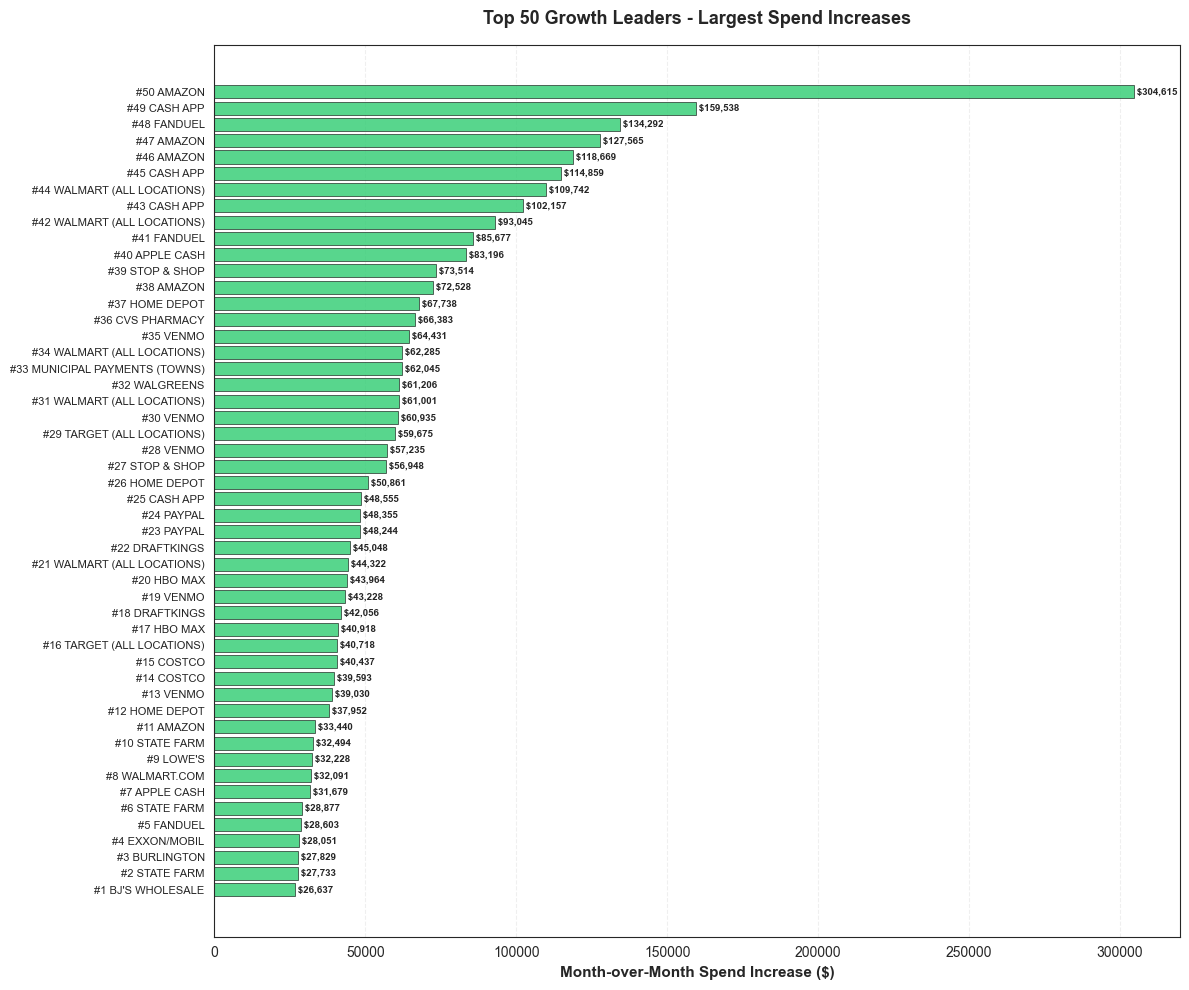

In [64]:
# M5B-2: GROWTH LEADERS VISUALIZATION
print("\n" + "="*120)
print("📈 GROWTH LEADERS - VISUALIZATION")
print("="*120)

# Rebuild growth_df (in case cells run separately)
sorted_months = sorted(combined_df['year_month'].unique())
growth_data = []

for i in range(1, len(sorted_months)):
    prev_month = sorted_months[i-1]
    curr_month = sorted_months[i]
    prev_spend = combined_df[combined_df['year_month'] == prev_month].groupby('merchant_consolidated')['amount'].sum()
    curr_spend = combined_df[combined_df['year_month'] == curr_month].groupby('merchant_consolidated')['amount'].sum()
    
    for merchant in set(prev_spend.index) & set(curr_spend.index):
        prev_amt = prev_spend[merchant]
        curr_amt = curr_spend[merchant]
        change_amt = curr_amt - prev_amt
        change_pct = (change_amt / prev_amt * 100) if prev_amt > 0 else 0
        
        if max(prev_amt, curr_amt) >= 1000:
            growth_data.append({
                'merchant': merchant,
                'change_amount': change_amt,
                'change_percent': change_pct
            })

growth_df = pd.DataFrame(growth_data)

# Create visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10))

plot_data = growth_df.nlargest(50, 'change_amount').copy()
plot_data = plot_data.sort_values('change_amount', ascending=True)

merchants = plot_data['merchant'].str[:35]
changes = plot_data['change_amount']

bars = ax.barh(range(len(merchants)), changes, color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=0.5)

ax.set_yticks(range(len(merchants)))
ax.set_yticklabels([f"#{i+1} {m}" for i, m in enumerate(merchants)], fontsize=8)
ax.set_xlabel('Month-over-Month Spend Increase ($)', fontsize=11, fontweight='bold')
ax.set_title('Top 50 Growth Leaders - Largest Spend Increases', fontsize=13, fontweight='bold', pad=15)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, changes)):
    ax.text(val, bar.get_y() + bar.get_height()/2, f' ${val:,.0f}', 
            va='center', fontsize=7, fontweight='bold')

ax.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("="*120)

#### Viz - Decline 


📉 DECLINERS - VISUALIZATION


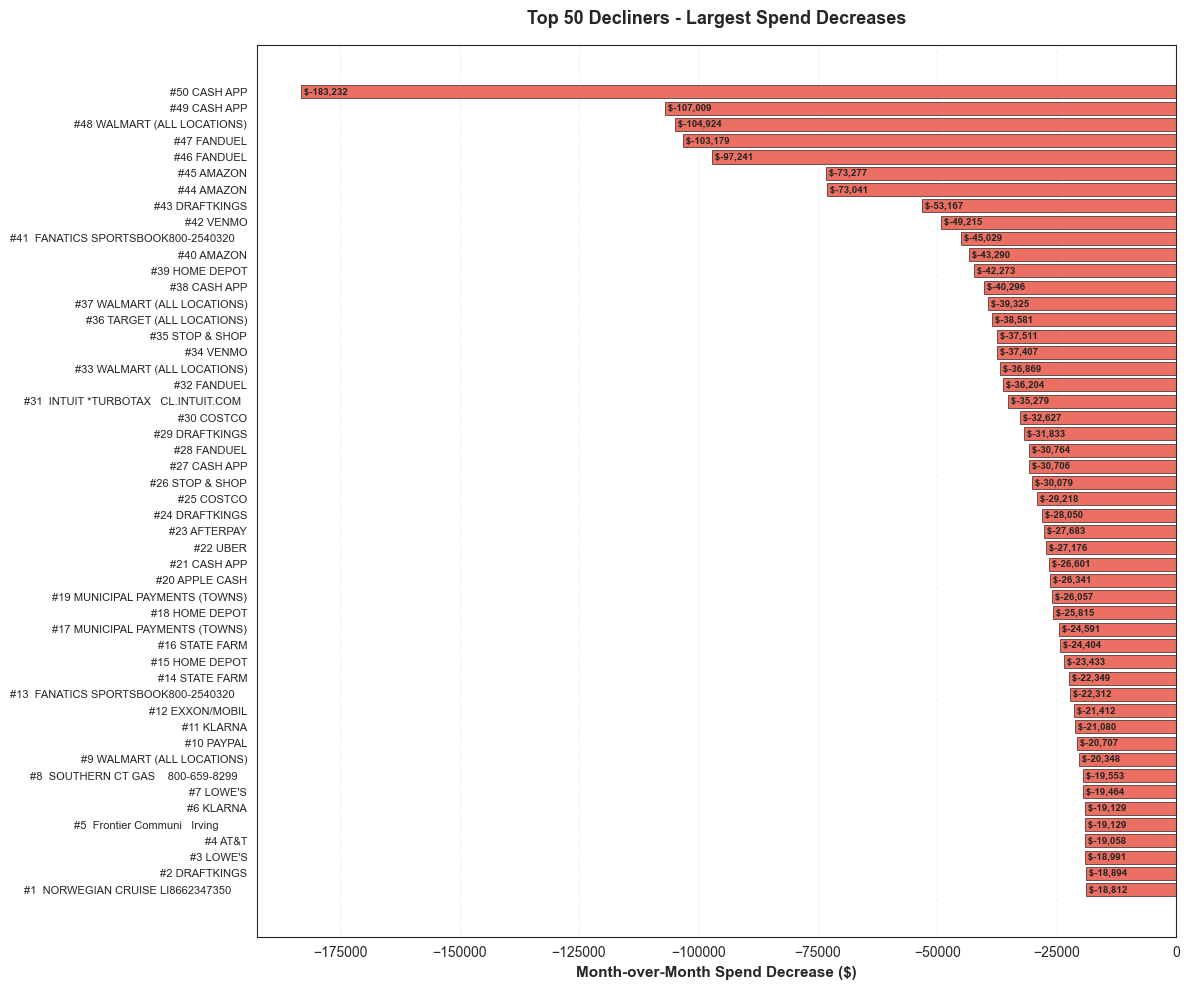

In [65]:
# M5B-3: DECLINERS VISUALIZATION
print("\n" + "="*120)
print("📉 DECLINERS - VISUALIZATION")
print("="*120)

# Rebuild growth_df (in case cells run separately)
sorted_months = sorted(combined_df['year_month'].unique())
growth_data = []

for i in range(1, len(sorted_months)):
    prev_month = sorted_months[i-1]
    curr_month = sorted_months[i]
    prev_spend = combined_df[combined_df['year_month'] == prev_month].groupby('merchant_consolidated')['amount'].sum()
    curr_spend = combined_df[combined_df['year_month'] == curr_month].groupby('merchant_consolidated')['amount'].sum()
    
    for merchant in set(prev_spend.index) & set(curr_spend.index):
        prev_amt = prev_spend[merchant]
        curr_amt = curr_spend[merchant]
        change_amt = curr_amt - prev_amt
        change_pct = (change_amt / prev_amt * 100) if prev_amt > 0 else 0
        
        if max(prev_amt, curr_amt) >= 1000:
            growth_data.append({
                'merchant': merchant,
                'change_amount': change_amt,
                'change_percent': change_pct
            })

growth_df = pd.DataFrame(growth_data)

# Create visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10))

plot_data = growth_df.nsmallest(50, 'change_amount').copy()
plot_data = plot_data.sort_values('change_amount', ascending=False)  # Most negative at top

merchants = plot_data['merchant'].str[:35]
changes = plot_data['change_amount']

bars = ax.barh(range(len(merchants)), changes, color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=0.5)

ax.set_yticks(range(len(merchants)))
ax.set_yticklabels([f"#{i+1} {m}" for i, m in enumerate(merchants)], fontsize=8)
ax.set_xlabel('Month-over-Month Spend Decrease ($)', fontsize=11, fontweight='bold')
ax.set_title('Top 50 Decliners - Largest Spend Decreases', fontsize=13, fontweight='bold', pad=15)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, changes)):
    ax.text(val, bar.get_y() + bar.get_height()/2, f' ${val:,.0f}', 
            va='center', fontsize=7, fontweight='bold')

ax.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("="*120)

### SPENDING CONSISTENCY ANALYSIS

In [66]:
# M5C-1: SPENDING CONSISTENCY ANALYSIS
# Identifies merchants with stable vs volatile spending patterns
print("\n" + "="*120)
print(" " * 40 + "M5C-1: SPENDING CONSISTENCY ANALYSIS")
print("="*120)

# Calculate monthly spending for each merchant
sorted_months = sorted(combined_df['year_month'].unique())

merchant_monthly = combined_df.groupby(['merchant_consolidated', 'year_month'])['amount'].sum().reset_index()

# Pivot to get monthly spending pattern
spending_pivot = merchant_monthly.pivot(index='merchant_consolidated', columns='year_month', values='amount').fillna(0)

# Calculate consistency metrics
consistency_data = []

for merchant in spending_pivot.index:
    monthly_values = spending_pivot.loc[merchant].values
    
    # Filter out zero months
    non_zero_values = monthly_values[monthly_values > 0]
    
    # Only analyze merchants with at least 3 months of activity
    if len(non_zero_values) >= 3:
        total_spend = non_zero_values.sum()
        mean_spend = non_zero_values.mean()
        std_spend = non_zero_values.std()
        cv = (std_spend / mean_spend * 100) if mean_spend > 0 else 0  # Coefficient of variation
        months_active = len(non_zero_values)
        
        consistency_data.append({
            'merchant': merchant,
            'total_spend': total_spend,
            'mean_monthly': mean_spend,
            'std_dev': std_spend,
            'coefficient_variation': cv,
            'months_active': months_active,
            'consistency_score': 100 - min(cv, 100)  # Inverse of CV (higher = more consistent)
        })

consistency_df = pd.DataFrame(consistency_data)

# Filter for significant merchants (at least $10,000 total spend)
consistency_df = consistency_df[consistency_df['total_spend'] >= 10000].copy()

print("\n📊 TOP 50 MOST CONSISTENT MERCHANTS (Low Variation)")
print("="*120)
print("Lower Coefficient of Variation = More Predictable Spending Pattern")
print("-"*120)

most_consistent = consistency_df.nlargest(50, 'consistency_score').copy()
most_consistent['merchant'] = most_consistent['merchant'].str[:40]

consistent_display = most_consistent[[
    'merchant', 'total_spend', 'mean_monthly', 'std_dev', 'coefficient_variation', 'months_active'
]].copy()

consistent_display.columns = ['Merchant', 'Total Spend', 'Avg Monthly', 'Std Dev', 'CV (%)', 'Months Active']

# Format numbers
consistent_display['Total Spend'] = consistent_display['Total Spend'].apply(lambda x: f"${x:,.0f}")
consistent_display['Avg Monthly'] = consistent_display['Avg Monthly'].apply(lambda x: f"${x:,.0f}")
consistent_display['Std Dev'] = consistent_display['Std Dev'].apply(lambda x: f"${x:,.0f}")
consistent_display['CV (%)'] = consistent_display['CV (%)'].apply(lambda x: f"{x:.1f}%")

display(consistent_display.style.hide(axis='index'))

print("\n" + "="*120)

print("\n📊 TOP 50 MOST VOLATILE MERCHANTS (High Variation)")
print("="*120)
print("Higher Coefficient of Variation = More Unpredictable Spending Pattern")
print("-"*120)

most_volatile = consistency_df.nsmallest(50, 'consistency_score').copy()
most_volatile['merchant'] = most_volatile['merchant'].str[:40]

volatile_display = most_volatile[[
    'merchant', 'total_spend', 'mean_monthly', 'std_dev', 'coefficient_variation', 'months_active'
]].copy()

volatile_display.columns = ['Merchant', 'Total Spend', 'Avg Monthly', 'Std Dev', 'CV (%)', 'Months Active']

# Format numbers
volatile_display['Total Spend'] = volatile_display['Total Spend'].apply(lambda x: f"${x:,.0f}")
volatile_display['Avg Monthly'] = volatile_display['Avg Monthly'].apply(lambda x: f"${x:,.0f}")
volatile_display['Std Dev'] = volatile_display['Std Dev'].apply(lambda x: f"${x:,.0f}")
volatile_display['CV (%)'] = volatile_display['CV (%)'].apply(lambda x: f"{x:.1f}%")

display(volatile_display.style.hide(axis='index'))

print("\n💡 CONSISTENCY METRICS EXPLAINED:")
print("-"*120)
print("   • Coefficient of Variation (CV) = Standard Deviation / Mean × 100")
print("   • CV < 50%: Consistent spending pattern")
print("   • CV 50-100%: Moderate variation")
print("   • CV > 100%: High volatility (spiky spending)")
print("\n📈 SUMMARY STATISTICS:")
print("-"*120)
print(f"   • Total merchants analyzed: {len(consistency_df):,}")
print(f"   • Average CV: {consistency_df['coefficient_variation'].mean():.1f}%")
print(f"   • Median CV: {consistency_df['coefficient_variation'].median():.1f}%")
print(f"   • Consistent merchants (CV < 50%): {(consistency_df['coefficient_variation'] < 50).sum():,} ({(consistency_df['coefficient_variation'] < 50).sum() / len(consistency_df) * 100:.1f}%)")
print(f"   • Volatile merchants (CV > 100%): {(consistency_df['coefficient_variation'] > 100).sum():,} ({(consistency_df['coefficient_variation'] > 100).sum() / len(consistency_df) * 100:.1f}%)")
print("="*120)


                                        M5C-1: SPENDING CONSISTENCY ANALYSIS

📊 TOP 50 MOST CONSISTENT MERCHANTS (Low Variation)
Lower Coefficient of Variation = More Predictable Spending Pattern
------------------------------------------------------------------------------------------------------------------------




📊 TOP 50 MOST VOLATILE MERCHANTS (High Variation)
Higher Coefficient of Variation = More Unpredictable Spending Pattern
------------------------------------------------------------------------------------------------------------------------



💡 CONSISTENCY METRICS EXPLAINED:
------------------------------------------------------------------------------------------------------------------------
   • Coefficient of Variation (CV) = Standard Deviation / Mean × 100
   • CV < 50%: Consistent spending pattern
   • CV 50-100%: Moderate variation
   • CV > 100%: High volatility (spiky spending)

📈 SUMMARY STATISTICS:
------------------------------------------------------------------------------------------------------------------------
   • Total merchants analyzed: 2,101
   • Average CV: 37.7%
   • Median CV: 30.4%
   • Consistent merchants (CV < 50%): 1,587 (75.5%)
   • Volatile merchants (CV > 100%): 68 (3.2%)


#### Viz - Consisentcy 


📊 MOST CONSISTENT MERCHANTS - VISUALIZATION


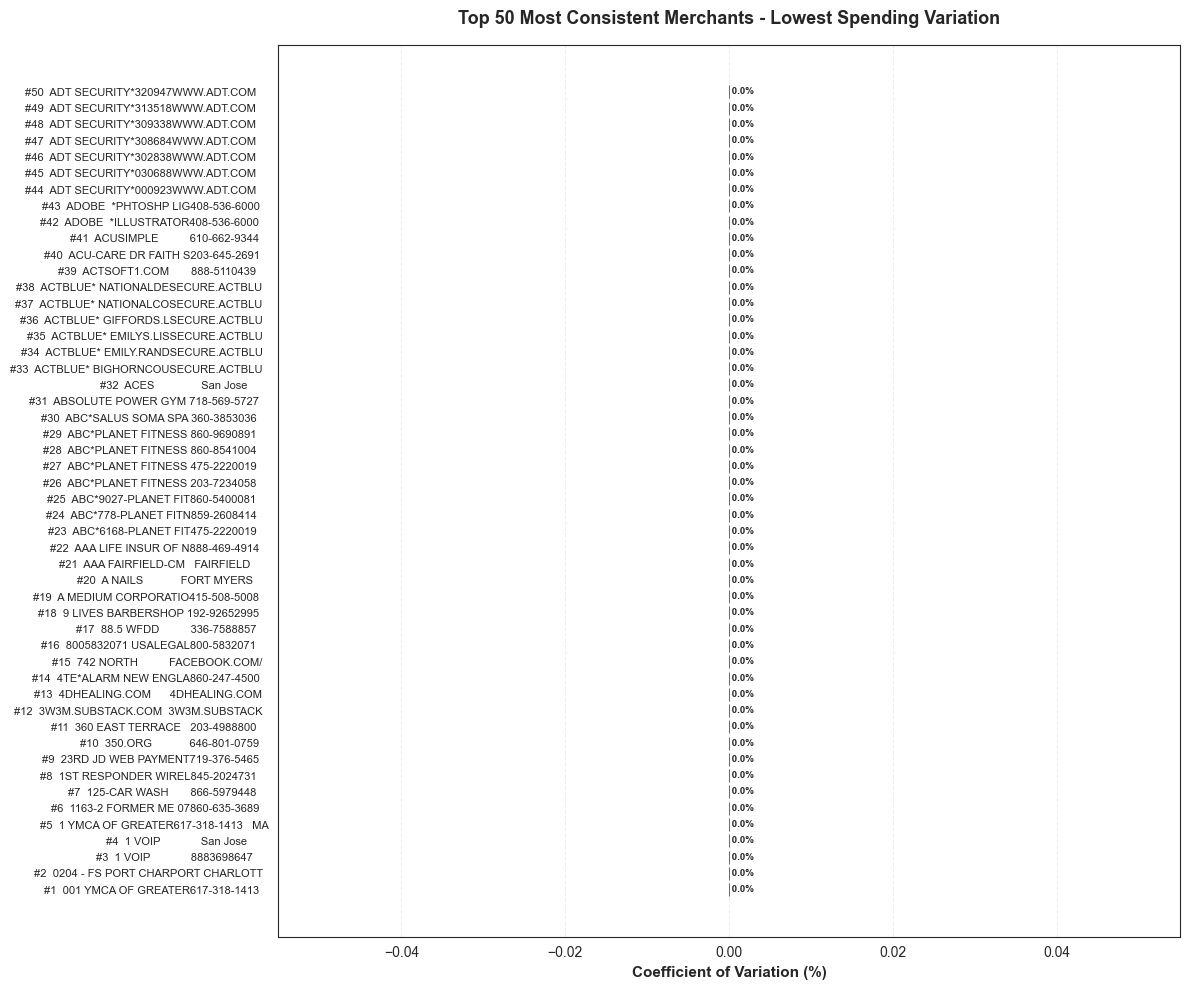

In [67]:
# M5C-2: CONSISTENT MERCHANTS VISUALIZATION
print("\n" + "="*120)
print("📊 MOST CONSISTENT MERCHANTS - VISUALIZATION")
print("="*120)

# Rebuild consistency_df (in case cells run separately)
sorted_months = sorted(combined_df['year_month'].unique())
merchant_monthly = combined_df.groupby(['merchant_consolidated', 'year_month'])['amount'].sum().reset_index()
spending_pivot = merchant_monthly.pivot(index='merchant_consolidated', columns='year_month', values='amount').fillna(0)

consistency_data = []
for merchant in spending_pivot.index:
    monthly_values = spending_pivot.loc[merchant].values
    non_zero_values = monthly_values[monthly_values > 0]
    
    if len(non_zero_values) >= 3:
        total_spend = non_zero_values.sum()
        mean_spend = non_zero_values.mean()
        std_spend = non_zero_values.std()
        cv = (std_spend / mean_spend * 100) if mean_spend > 0 else 0
        months_active = len(non_zero_values)
        
        consistency_data.append({
            'merchant': merchant,
            'coefficient_variation': cv,
            'consistency_score': 100 - min(cv, 100)
        })

consistency_df = pd.DataFrame(consistency_data)

# Visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10))

plot_data = consistency_df.nlargest(50, 'consistency_score').head(50).sort_values('coefficient_variation', ascending=False)

merchants = plot_data['merchant'].str[:35]
cv_values = plot_data['coefficient_variation']

bars = ax.barh(range(len(merchants)), cv_values, color='#3498db', alpha=0.8, edgecolor='black', linewidth=0.5)

ax.set_yticks(range(len(merchants)))
ax.set_yticklabels([f"#{i+1} {m}" for i, m in enumerate(merchants)], fontsize=8)
ax.set_xlabel('Coefficient of Variation (%)', fontsize=11, fontweight='bold')
ax.set_title('Top 50 Most Consistent Merchants - Lowest Spending Variation', fontsize=13, fontweight='bold', pad=15)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, cv_values)):
    ax.text(val, bar.get_y() + bar.get_height()/2, f' {val:.1f}%', 
            va='center', fontsize=7, fontweight='bold')

ax.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("="*120)

#### Viz - Volatile Merchants 


📊 MOST VOLATILE MERCHANTS - VISUALIZATION


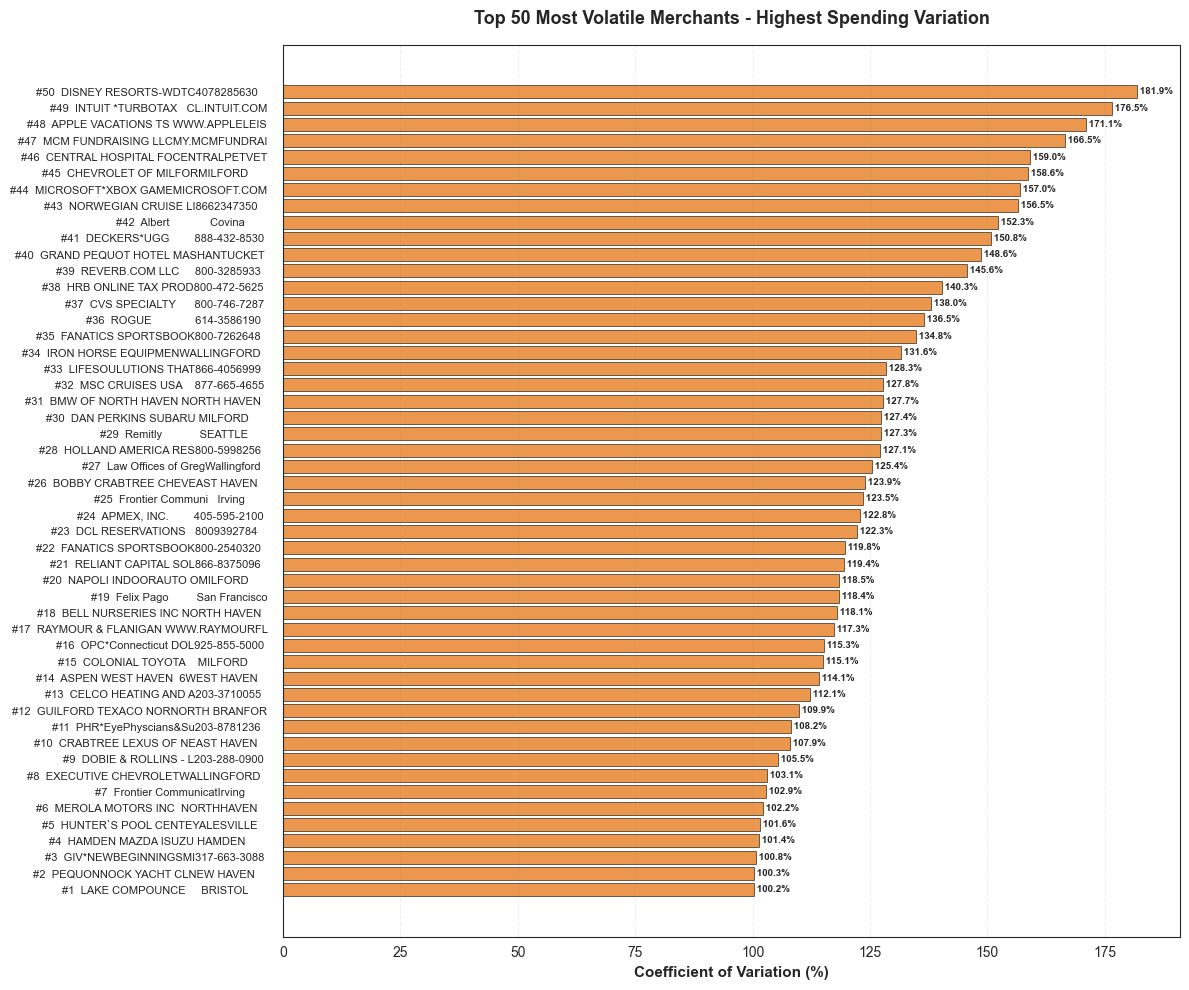

In [68]:
# M5C-3: VOLATILE MERCHANTS VISUALIZATION
print("\n" + "="*120)
print("📊 MOST VOLATILE MERCHANTS - VISUALIZATION")
print("="*120)

# Rebuild consistency_df (in case cells run separately)
sorted_months = sorted(combined_df['year_month'].unique())
merchant_monthly = combined_df.groupby(['merchant_consolidated', 'year_month'])['amount'].sum().reset_index()
spending_pivot = merchant_monthly.pivot(index='merchant_consolidated', columns='year_month', values='amount').fillna(0)

consistency_data = []
for merchant in spending_pivot.index:
    monthly_values = spending_pivot.loc[merchant].values
    non_zero_values = monthly_values[monthly_values > 0]
    
    if len(non_zero_values) >= 3:
        total_spend = non_zero_values.sum()
        mean_spend = non_zero_values.mean()
        std_spend = non_zero_values.std()
        cv = (std_spend / mean_spend * 100) if mean_spend > 0 else 0
        months_active = len(non_zero_values)
        
        consistency_data.append({
            'merchant': merchant,
            'total_spend': total_spend,
            'coefficient_variation': cv,
            'consistency_score': 100 - min(cv, 100)
        })

consistency_df = pd.DataFrame(consistency_data)
consistency_df = consistency_df[consistency_df['total_spend'] >= 10000].copy()

# Visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10))

plot_data = consistency_df.nsmallest(50, 'consistency_score').head(50).sort_values('coefficient_variation', ascending=True)

merchants = plot_data['merchant'].str[:35]
cv_values = plot_data['coefficient_variation']

bars = ax.barh(range(len(merchants)), cv_values, color='#e67e22', alpha=0.8, edgecolor='black', linewidth=0.5)

ax.set_yticks(range(len(merchants)))
ax.set_yticklabels([f"#{i+1} {m}" for i, m in enumerate(merchants)], fontsize=8)
ax.set_xlabel('Coefficient of Variation (%)', fontsize=11, fontweight='bold')
ax.set_title('Top 50 Most Volatile Merchants - Highest Spending Variation', fontsize=13, fontweight='bold', pad=15)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, cv_values)):
    ax.text(val, bar.get_y() + bar.get_height()/2, f' {val:.1f}%', 
            va='center', fontsize=7, fontweight='bold')

ax.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("="*120)

### NEW VS DECLINING MERCHANTS - ANALYSIS


In [69]:
# M5D-1: NEW VS DECLINING MERCHANTS - ANALYSIS (OPTIMIZED)
# Tracks merchant lifecycle - new entrants, established, and declining merchants
print("\n" + "="*120)
print(" " * 40 + "M5D-1: NEW VS DECLINING MERCHANTS - ANALYSIS")
print("="*120)

sorted_months = sorted(combined_df['year_month'].unique())

# OPTIMIZED: Build merchant activity dictionary with vectorized operations
print("Building merchant activity tracker...")

# Get first and last appearance for each merchant (vectorized)
merchant_first_last = combined_df.groupby('merchant_consolidated')['year_month'].agg(['min', 'max', 'nunique'])
merchant_first_last.columns = ['first_month', 'last_month', 'months_active_count']

# Build merchant activity dictionary (much faster)
merchant_activity = {}
for merchant, row in merchant_first_last.iterrows():
    merchant_activity[merchant] = {
        'first_month': row['first_month'],
        'last_month': row['last_month'],
        'months_active': []  # We'll populate this only if needed
    }

print(f"Tracked {len(merchant_activity):,} unique merchants")

# OPTIMIZED: Pre-compute merchant sets per month
print("Computing monthly merchant sets...")
monthly_merchant_sets = {}
monthly_spend_data = {}

for month in sorted_months:
    month_data = combined_df[combined_df['year_month'] == month]
    monthly_merchant_sets[month] = set(month_data['merchant_consolidated'].unique())
    monthly_spend_data[month] = month_data

print(f"Processed {len(sorted_months)} months")

# Analyze each month's cohorts (using pre-computed sets)
print("Analyzing cohorts...")
cohort_analysis = []

for i, month in enumerate(sorted_months):
    month_data = monthly_spend_data[month]
    current_merchants = monthly_merchant_sets[month]
    
    # New merchants (first appearance this month)
    new_merchants = {m for m in current_merchants if merchant_activity[m]['first_month'] == month}
    
    # Returning merchants (active before, not in previous month, but back now)
    if i > 0:
        prev_month = sorted_months[i-1]
        prev_merchants = monthly_merchant_sets[prev_month]
        
        returning = {m for m in current_merchants 
                    if m not in prev_merchants and merchant_activity[m]['first_month'] != month}
        
        # Lost merchants (in previous month, not in current)
        lost = prev_merchants - current_merchants
    else:
        returning = set()
        lost = set()
    
    # Calculate spending (vectorized)
    new_spend = month_data[month_data['merchant_consolidated'].isin(new_merchants)]['amount'].sum()
    returning_spend = month_data[month_data['merchant_consolidated'].isin(returning)]['amount'].sum()
    total_spend = month_data['amount'].sum()
    
    cohort_analysis.append({
        'month': month,
        'total_merchants': len(current_merchants),
        'new_merchants': len(new_merchants),
        'returning_merchants': len(returning),
        'lost_merchants': len(lost),
        'new_spend': new_spend,
        'returning_spend': returning_spend,
        'total_spend': total_spend
    })

cohort_df = pd.DataFrame(cohort_analysis)

print("\n📊 MONTHLY COHORT ANALYSIS")
print("="*120)

display_cohort = cohort_df.copy()
display_cohort['month'] = display_cohort['month'].astype(str)
display_cohort['new_pct'] = (display_cohort['new_merchants'] / display_cohort['total_merchants'] * 100)
display_cohort['returning_pct'] = (display_cohort['returning_merchants'] / display_cohort['total_merchants'] * 100)
display_cohort['new_spend_pct'] = (display_cohort['new_spend'] / display_cohort['total_spend'] * 100)

display_cols = display_cohort[[
    'month', 'total_merchants', 'new_merchants', 'new_pct', 
    'returning_merchants', 'returning_pct', 'lost_merchants',
    'new_spend', 'new_spend_pct'
]].copy()

display_cols.columns = [
    'Month', 'Total Merchants', 'New', 'New %', 
    'Returning', 'Return %', 'Lost',
    'New Merchant $', 'New $ %'
]

# Format
display_cols['New %'] = display_cols['New %'].apply(lambda x: f"{x:.1f}%")
display_cols['Return %'] = display_cols['Return %'].apply(lambda x: f"{x:.1f}%")
display_cols['New Merchant $'] = display_cols['New Merchant $'].apply(lambda x: f"${x:,.0f}")
display_cols['New $ %'] = display_cols['New $ %'].apply(lambda x: f"{x:.1f}%")

display(display_cols.style.hide(axis='index'))

print("\n" + "="*120)

# OPTIMIZED: Top New Merchants by First Month (vectorized aggregation)
print("\n🆕 TOP NEW MERCHANTS BY COHORT (First Appearance)")
print("="*120)

# Build comprehensive summary with a single groupby
new_merchant_summary = combined_df.groupby('merchant_consolidated').agg({
    'amount': ['sum', 'mean'],
    'year_month': ['min', 'nunique'],
    'primary_account_num': 'nunique',
    'transaction_date': 'count'
}).round(2)

new_merchant_summary.columns = ['total_spend', 'avg_transaction', 'first_month', 'months_active', 'unique_accounts', 'transaction_count']
new_merchant_summary['avg_monthly_spend'] = new_merchant_summary['total_spend'] / new_merchant_summary['months_active']
new_merchant_summary = new_merchant_summary.reset_index()

# Show top 5 new merchants from each of the last 3 months - BY TOTAL SPEND
recent_months = sorted_months[-3:]

print("\n" + "="*120)
print("📊 TOP 5 BY TOTAL SPEND")
print("="*120)

for month in recent_months:
    month_new = new_merchant_summary[new_merchant_summary['first_month'] == month].nlargest(5, 'total_spend')
    
    if len(month_new) > 0:
        print(f"\n{str(month)} Cohort:")
        print("-"*120)
        
        display_new = month_new[['merchant_consolidated', 'total_spend', 'unique_accounts', 'transaction_count', 'avg_monthly_spend']].copy()
        display_new['merchant_consolidated'] = display_new['merchant_consolidated'].str[:40]
        display_new.columns = ['Merchant', 'Total Spend', 'Unique Accounts', 'Transactions', 'Avg Monthly Spend']
        
        display_new['Total Spend'] = display_new['Total Spend'].apply(lambda x: f"${x:,.0f}")
        display_new['Unique Accounts'] = display_new['Unique Accounts'].apply(lambda x: f"{int(x):,}")
        display_new['Transactions'] = display_new['Transactions'].apply(lambda x: f"{int(x):,}")
        display_new['Avg Monthly Spend'] = display_new['Avg Monthly Spend'].apply(lambda x: f"${x:,.0f}")
        
        display(display_new.style.hide(axis='index'))

# TOP 5 BY UNIQUE ACCOUNTS
print("\n" + "="*120)
print("👥 TOP 5 BY UNIQUE ACCOUNTS")
print("="*120)

for month in recent_months:
    month_new = new_merchant_summary[new_merchant_summary['first_month'] == month].nlargest(5, 'unique_accounts')
    
    if len(month_new) > 0:
        print(f"\n{str(month)} Cohort:")
        print("-"*120)
        
        display_new = month_new[['merchant_consolidated', 'unique_accounts', 'total_spend', 'transaction_count', 'avg_transaction']].copy()
        display_new['merchant_consolidated'] = display_new['merchant_consolidated'].str[:40]
        display_new.columns = ['Merchant', 'Unique Accounts', 'Total Spend', 'Transactions', 'Avg Transaction']
        
        display_new['Unique Accounts'] = display_new['Unique Accounts'].apply(lambda x: f"{int(x):,}")
        display_new['Total Spend'] = display_new['Total Spend'].apply(lambda x: f"${x:,.0f}")
        display_new['Transactions'] = display_new['Transactions'].apply(lambda x: f"{int(x):,}")
        display_new['Avg Transaction'] = display_new['Avg Transaction'].apply(lambda x: f"${x:,.2f}")
        
        display(display_new.style.hide(axis='index'))

# TOP 5 BY TRANSACTION COUNT
print("\n" + "="*120)
print("🔄 TOP 5 BY TRANSACTION COUNT")
print("="*120)

for month in recent_months:
    month_new = new_merchant_summary[new_merchant_summary['first_month'] == month].nlargest(5, 'transaction_count')
    
    if len(month_new) > 0:
        print(f"\n{str(month)} Cohort:")
        print("-"*120)
        
        display_new = month_new[['merchant_consolidated', 'transaction_count', 'unique_accounts', 'total_spend', 'avg_transaction']].copy()
        display_new['merchant_consolidated'] = display_new['merchant_consolidated'].str[:40]
        display_new.columns = ['Merchant', 'Transactions', 'Unique Accounts', 'Total Spend', 'Avg Transaction']
        
        display_new['Transactions'] = display_new['Transactions'].apply(lambda x: f"{int(x):,}")
        display_new['Unique Accounts'] = display_new['Unique Accounts'].apply(lambda x: f"{int(x):,}")
        display_new['Total Spend'] = display_new['Total Spend'].apply(lambda x: f"${x:,.0f}")
        display_new['Avg Transaction'] = display_new['Avg Transaction'].apply(lambda x: f"${x:,.2f}")
        
        display(display_new.style.hide(axis='index'))

print("\n💡 SUMMARY STATISTICS:")
print("-"*120)
print(f"   • Total unique merchants across all months: {len(merchant_activity):,}")
print(f"   • Average new merchants per month: {cohort_df['new_merchants'].mean():.0f}")
print(f"   • Average returning merchants per month: {cohort_df['returning_merchants'].mean():.0f}")
print(f"   • Average lost merchants per month: {cohort_df['lost_merchants'].mean():.0f}")
print(f"   • Average new merchant contribution: {(cohort_df['new_spend'] / cohort_df['total_spend'] * 100).mean():.1f}% of monthly spend")
print("="*120)


                                        M5D-1: NEW VS DECLINING MERCHANTS - ANALYSIS
Building merchant activity tracker...
Tracked 236,340 unique merchants
Computing monthly merchant sets...
Processed 12 months
Analyzing cohorts...

📊 MONTHLY COHORT ANALYSIS




🆕 TOP NEW MERCHANTS BY COHORT (First Appearance)

📊 TOP 5 BY TOTAL SPEND

2025-10 Cohort:
------------------------------------------------------------------------------------------------------------------------



2025-11 Cohort:
------------------------------------------------------------------------------------------------------------------------



2025-12 Cohort:
------------------------------------------------------------------------------------------------------------------------



👥 TOP 5 BY UNIQUE ACCOUNTS

2025-10 Cohort:
------------------------------------------------------------------------------------------------------------------------



2025-11 Cohort:
------------------------------------------------------------------------------------------------------------------------



2025-12 Cohort:
------------------------------------------------------------------------------------------------------------------------



🔄 TOP 5 BY TRANSACTION COUNT

2025-10 Cohort:
------------------------------------------------------------------------------------------------------------------------



2025-11 Cohort:
------------------------------------------------------------------------------------------------------------------------



2025-12 Cohort:
------------------------------------------------------------------------------------------------------------------------



💡 SUMMARY STATISTICS:
------------------------------------------------------------------------------------------------------------------------
   • Total unique merchants across all months: 236,340
   • Average new merchants per month: 19695
   • Average returning merchants per month: 6033
   • Average lost merchants per month: 22127
   • Average new merchant contribution: 15.1% of monthly spend


#### Viz - Biz Rank Climbers 


📈 BUSINESS RANK CLIMBERS - VISUALIZATION


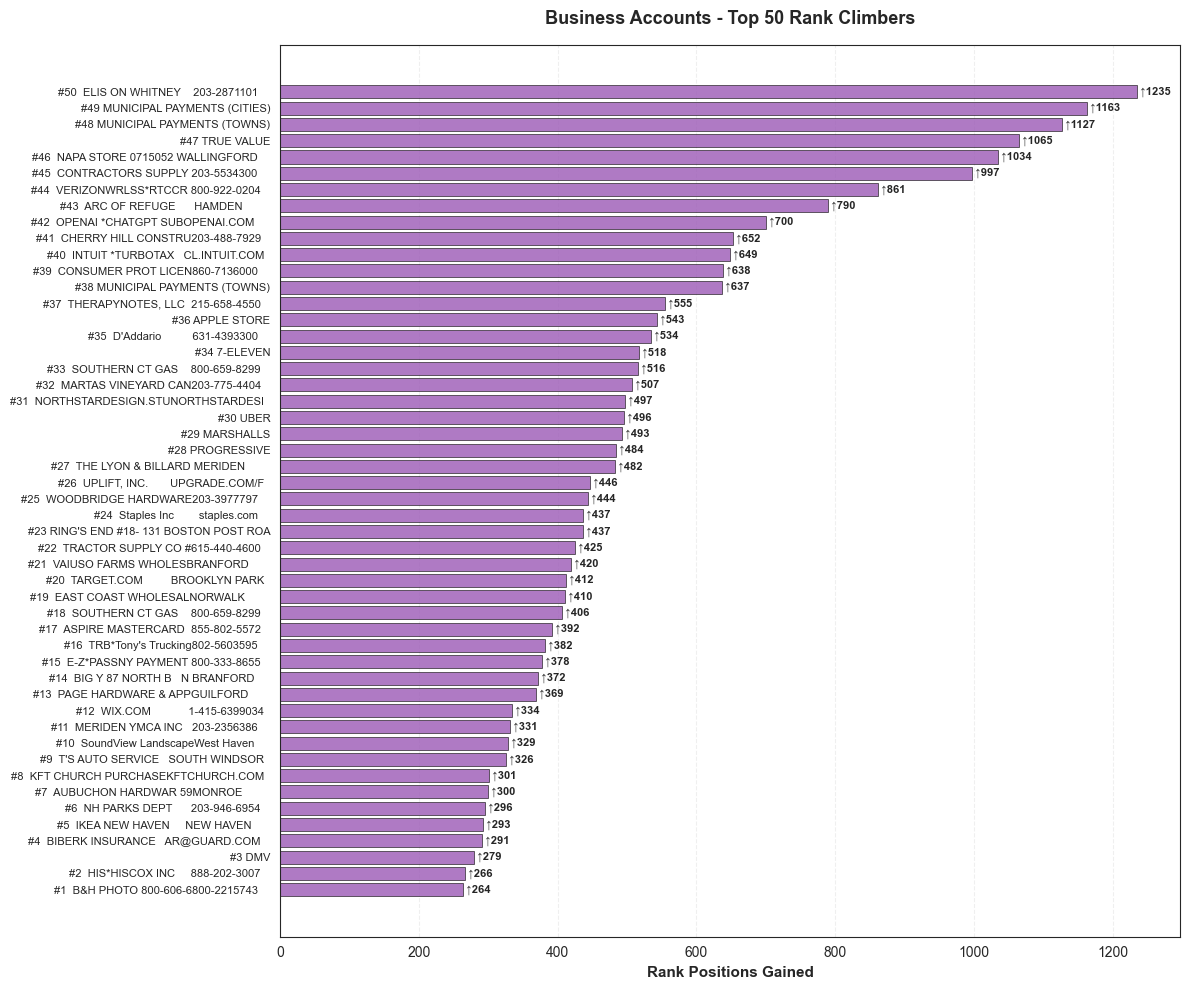

In [70]:
# M5E-2: BUSINESS RANK CLIMBERS VISUALIZATION
print("\n" + "="*120)
print("📈 BUSINESS RANK CLIMBERS - VISUALIZATION")
print("="*120)

import matplotlib.pyplot as plt

# Rebuild movers_df
sorted_months = sorted(business_df['year_month'].unique())
monthly_movers = []

for i in range(1, len(sorted_months)):
    prev_month = sorted_months[i-1]
    curr_month = sorted_months[i]
    prev_data = business_df[business_df['year_month'] == prev_month]
    prev_rankings = prev_data.groupby('merchant_consolidated')['amount'].sum().sort_values(ascending=False)
    prev_rankings = prev_rankings.reset_index()
    prev_rankings['rank'] = range(1, len(prev_rankings) + 1)
    prev_rankings = prev_rankings.set_index('merchant_consolidated')
    
    curr_data = business_df[business_df['year_month'] == curr_month]
    curr_rankings = curr_data.groupby('merchant_consolidated')['amount'].sum().sort_values(ascending=False)
    curr_rankings = curr_rankings.reset_index()
    curr_rankings['rank'] = range(1, len(curr_rankings) + 1)
    curr_rankings = curr_rankings.set_index('merchant_consolidated')
    
    common = set(prev_rankings.index) & set(curr_rankings.index)
    
    for merchant in common:
        prev_rank = prev_rankings.loc[merchant, 'rank']
        curr_rank = curr_rankings.loc[merchant, 'rank']
        rank_change = prev_rank - curr_rank
        
        if prev_rank <= 100 or curr_rank <= 100:
            monthly_movers.append({'merchant': merchant, 'rank_change': rank_change})

movers_df = pd.DataFrame(monthly_movers)
top_climbers = movers_df[movers_df['rank_change'] > 0].nlargest(50, 'rank_change')

fig, ax = plt.subplots(figsize=(12, 10))
plot_data = top_climbers.sort_values('rank_change', ascending=True)
merchants = plot_data['merchant'].str[:35]
rank_changes = plot_data['rank_change']

bars = ax.barh(range(len(merchants)), rank_changes, color='#9b59b6', alpha=0.8, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(merchants)))
ax.set_yticklabels([f"#{i+1} {m}" for i, m in enumerate(merchants)], fontsize=8)
ax.set_xlabel('Rank Positions Gained', fontsize=11, fontweight='bold')
ax.set_title('Business Accounts - Top 50 Rank Climbers', fontsize=13, fontweight='bold', pad=15)

for i, (bar, val) in enumerate(zip(bars, rank_changes)):
    ax.text(val, bar.get_y() + bar.get_height()/2, f' ↑{int(val)}', va='center', fontsize=8, fontweight='bold')

ax.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()
print("="*120)

#### Viz - Business Rank Fallers 


📉 BUSINESS RANK FALLERS - VISUALIZATION


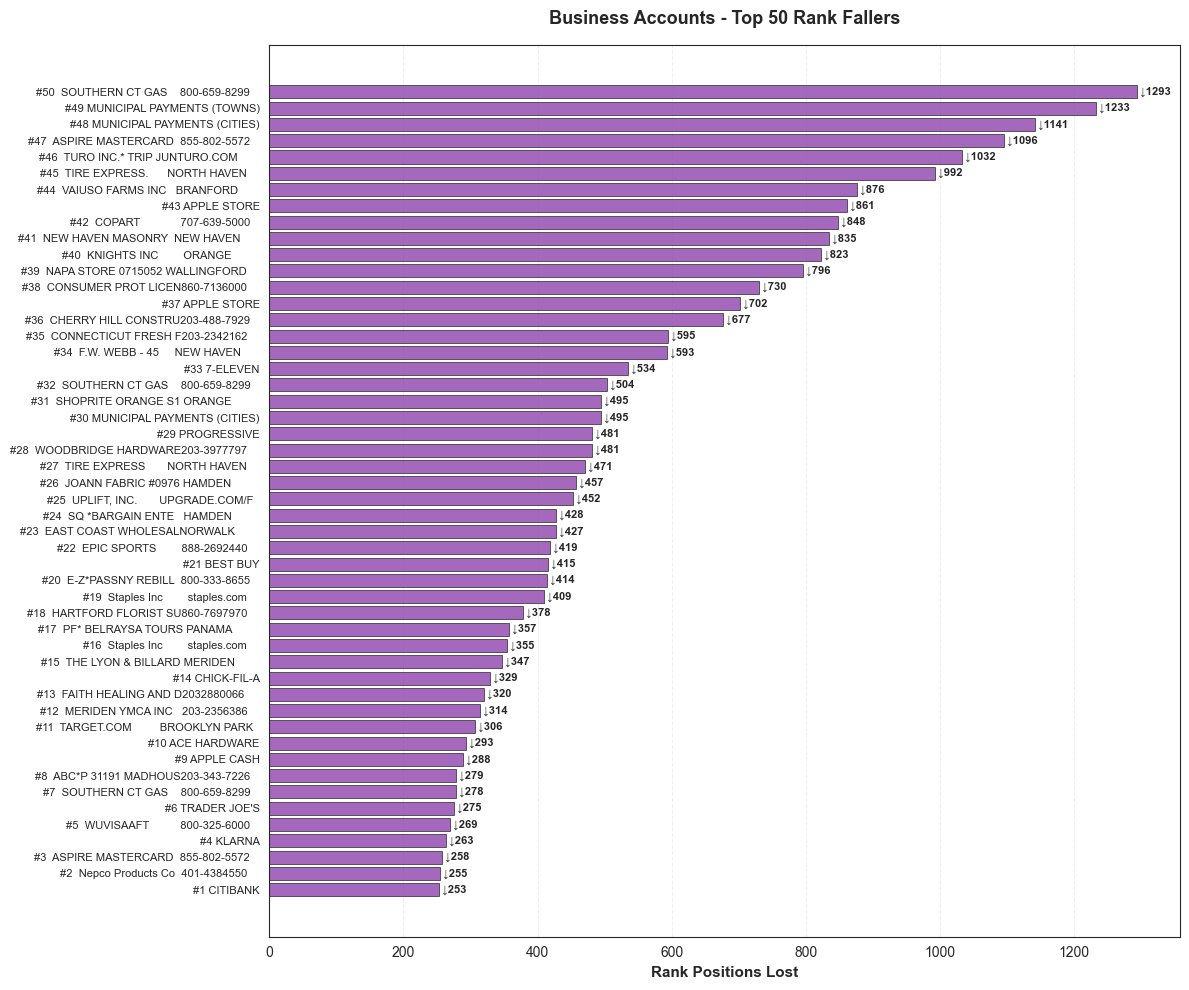

In [71]:
# M5E-3: BUSINESS RANK FALLERS VISUALIZATION
print("\n" + "="*120)
print("📉 BUSINESS RANK FALLERS - VISUALIZATION")
print("="*120)

import matplotlib.pyplot as plt

# Rebuild movers_df
sorted_months = sorted(business_df['year_month'].unique())
monthly_movers = []

for i in range(1, len(sorted_months)):
    prev_month = sorted_months[i-1]
    curr_month = sorted_months[i]
    prev_data = business_df[business_df['year_month'] == prev_month]
    prev_rankings = prev_data.groupby('merchant_consolidated')['amount'].sum().sort_values(ascending=False)
    prev_rankings = prev_rankings.reset_index()
    prev_rankings['rank'] = range(1, len(prev_rankings) + 1)
    prev_rankings = prev_rankings.set_index('merchant_consolidated')
    
    curr_data = business_df[business_df['year_month'] == curr_month]
    curr_rankings = curr_data.groupby('merchant_consolidated')['amount'].sum().sort_values(ascending=False)
    curr_rankings = curr_rankings.reset_index()
    curr_rankings['rank'] = range(1, len(curr_rankings) + 1)
    curr_rankings = curr_rankings.set_index('merchant_consolidated')
    
    common = set(prev_rankings.index) & set(curr_rankings.index)
    
    for merchant in common:
        prev_rank = prev_rankings.loc[merchant, 'rank']
        curr_rank = curr_rankings.loc[merchant, 'rank']
        rank_change = prev_rank - curr_rank
        
        if prev_rank <= 100 or curr_rank <= 100:
            monthly_movers.append({'merchant': merchant, 'rank_change': rank_change})

movers_df = pd.DataFrame(monthly_movers)
top_fallers = movers_df[movers_df['rank_change'] < 0].nsmallest(50, 'rank_change')

fig, ax = plt.subplots(figsize=(12, 10))
plot_data = top_fallers.sort_values('rank_change', ascending=False)
merchants = plot_data['merchant'].str[:35]
rank_changes = plot_data['rank_change'].abs()

bars = ax.barh(range(len(merchants)), rank_changes, color='#8e44ad', alpha=0.8, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(merchants)))
ax.set_yticklabels([f"#{i+1} {m}" for i, m in enumerate(merchants)], fontsize=8)
ax.set_xlabel('Rank Positions Lost', fontsize=11, fontweight='bold')
ax.set_title('Business Accounts - Top 50 Rank Fallers', fontsize=13, fontweight='bold', pad=15)

for i, (bar, val) in enumerate(zip(bars, rank_changes)):
    ax.text(val, bar.get_y() + bar.get_height()/2, f' ↓{int(val)}', va='center', fontsize=8, fontweight='bold')

ax.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()
print("="*120)

### Personal - MoM Analysis

In [72]:
# M5F-1: PERSONAL ACCOUNT - MONTH-OVER-MONTH ANALYSIS
# Focused analysis on personal merchant changes
print("\n" + "="*120)
print(" " * 35 + "M5F-1: PERSONAL ACCOUNT - MONTH-OVER-MONTH ANALYSIS")
print("="*120)

sorted_months = sorted(personal_df['year_month'].unique())

# Calculate month-over-month changes
monthly_movers = []

for i in range(1, len(sorted_months)):
    prev_month = sorted_months[i-1]
    curr_month = sorted_months[i]
    
    # Previous and current month rankings
    prev_data = personal_df[personal_df['year_month'] == prev_month]
    prev_rankings = prev_data.groupby('merchant_consolidated').agg({
        'amount': 'sum',
        'primary_account_num': 'nunique',
        'transaction_date': 'count'
    }).sort_values('amount', ascending=False)
    prev_rankings['rank'] = range(1, len(prev_rankings) + 1)
    
    curr_data = personal_df[personal_df['year_month'] == curr_month]
    curr_rankings = curr_data.groupby('merchant_consolidated').agg({
        'amount': 'sum',
        'primary_account_num': 'nunique',
        'transaction_date': 'count'
    }).sort_values('amount', ascending=False)
    curr_rankings['rank'] = range(1, len(curr_rankings) + 1)
    
    # Compare merchants in both months
    common = set(prev_rankings.index) & set(curr_rankings.index)
    
    for merchant in common:
        prev_rank = prev_rankings.loc[merchant, 'rank']
        curr_rank = curr_rankings.loc[merchant, 'rank']
        prev_spend = prev_rankings.loc[merchant, 'amount']
        curr_spend = curr_rankings.loc[merchant, 'amount']
        
        rank_change = prev_rank - curr_rank
        spend_change = curr_spend - prev_spend
        spend_change_pct = (spend_change / prev_spend * 100) if prev_spend > 0 else 0
        
        if prev_rank <= 100 or curr_rank <= 100:
            monthly_movers.append({
                'month_transition': f"{prev_month} → {curr_month}",
                'merchant': merchant,
                'prev_rank': prev_rank,
                'curr_rank': curr_rank,
                'rank_change': rank_change,
                'prev_spend': prev_spend,
                'curr_spend': curr_spend,
                'spend_change': spend_change,
                'spend_change_pct': spend_change_pct
            })

movers_df = pd.DataFrame(monthly_movers)

print("\n📈 TOP 50 PERSONAL RANK CLIMBERS (Biggest Improvements)")
print("="*120)

top_climbers = movers_df[movers_df['rank_change'] > 0].nlargest(50, 'rank_change').copy()
top_climbers['merchant'] = top_climbers['merchant'].str[:40]

climbers_display = top_climbers[[
    'month_transition', 'merchant', 'prev_rank', 'curr_rank', 'rank_change',
    'prev_spend', 'curr_spend', 'spend_change_pct'
]].copy()

climbers_display.columns = [
    'Period', 'Merchant', 'Prev Rank', 'Curr Rank', 'Rank +',
    'Previous $', 'Current $', 'Change %'
]

climbers_display['Previous $'] = climbers_display['Previous $'].apply(lambda x: f"${x:,.0f}")
climbers_display['Current $'] = climbers_display['Current $'].apply(lambda x: f"${x:,.0f}")
climbers_display['Change %'] = climbers_display['Change %'].apply(lambda x: f"{x:+.1f}%")
climbers_display['Rank +'] = climbers_display['Rank +'].apply(lambda x: f"↑{int(x)}")

display(climbers_display.style.hide(axis='index'))

print("\n" + "="*120)

print("\n📉 TOP 50 PERSONAL RANK FALLERS (Biggest Declines)")
print("="*120)

top_fallers = movers_df[movers_df['rank_change'] < 0].nsmallest(50, 'rank_change').copy()
top_fallers['merchant'] = top_fallers['merchant'].str[:40]

fallers_display = top_fallers[[
    'month_transition', 'merchant', 'prev_rank', 'curr_rank', 'rank_change',
    'prev_spend', 'curr_spend', 'spend_change_pct'
]].copy()

fallers_display.columns = [
    'Period', 'Merchant', 'Prev Rank', 'Curr Rank', 'Rank -',
    'Previous $', 'Current $', 'Change %'
]

fallers_display['Previous $'] = fallers_display['Previous $'].apply(lambda x: f"${x:,.0f}")
fallers_display['Current $'] = fallers_display['Current $'].apply(lambda x: f"${x:,.0f}")
fallers_display['Change %'] = fallers_display['Change %'].apply(lambda x: f"{x:+.1f}%")
fallers_display['Rank -'] = fallers_display['Rank -'].apply(lambda x: f"↓{abs(int(x))}")

display(fallers_display.style.hide(axis='index'))

print("\n💰 TOP 50 PERSONAL SPEND INCREASES")
print("="*120)

top_spend_increase = movers_df.nlargest(50, 'spend_change').copy()
top_spend_increase['merchant'] = top_spend_increase['merchant'].str[:40]

spend_inc_display = top_spend_increase[[
    'month_transition', 'merchant', 'prev_spend', 'curr_spend', 'spend_change', 'spend_change_pct'
]].copy()

spend_inc_display.columns = ['Period', 'Merchant', 'Previous $', 'Current $', 'Change $', 'Change %']

spend_inc_display['Previous $'] = spend_inc_display['Previous $'].apply(lambda x: f"${x:,.0f}")
spend_inc_display['Current $'] = spend_inc_display['Current $'].apply(lambda x: f"${x:,.0f}")
spend_inc_display['Change $'] = spend_inc_display['Change $'].apply(lambda x: f"${x:,.0f}")
spend_inc_display['Change %'] = spend_inc_display['Change %'].apply(lambda x: f"{x:+.1f}%")

display(spend_inc_display.style.hide(axis='index'))

print("\n💡 PERSONAL ACCOUNT SUMMARY:")
print("-"*120)
print(f"   • Total month-over-month comparisons: {len(movers_df):,}")
print(f"   • Merchants with rank improvements: {(movers_df['rank_change'] > 0).sum():,}")
print(f"   • Merchants with rank declines: {(movers_df['rank_change'] < 0).sum():,}")
print(f"   • Average absolute rank change: {movers_df['rank_change'].abs().mean():.1f} positions")
print(f"   • Merchants with spend increases: {(movers_df['spend_change'] > 0).sum():,} ({(movers_df['spend_change'] > 0).sum() / len(movers_df) * 100:.1f}%)")
print("="*120)


                                   M5F-1: PERSONAL ACCOUNT - MONTH-OVER-MONTH ANALYSIS

📈 TOP 50 PERSONAL RANK CLIMBERS (Biggest Improvements)




📉 TOP 50 PERSONAL RANK FALLERS (Biggest Declines)



💰 TOP 50 PERSONAL SPEND INCREASES



💡 PERSONAL ACCOUNT SUMMARY:
------------------------------------------------------------------------------------------------------------------------
   • Total month-over-month comparisons: 1,165
   • Merchants with rank improvements: 466
   • Merchants with rank declines: 490
   • Average absolute rank change: 15.0 positions
   • Merchants with spend increases: 598 (51.3%)


#### Viz - Personal Rank Climbers


📈 PERSONAL RANK CLIMBERS - VISUALIZATION


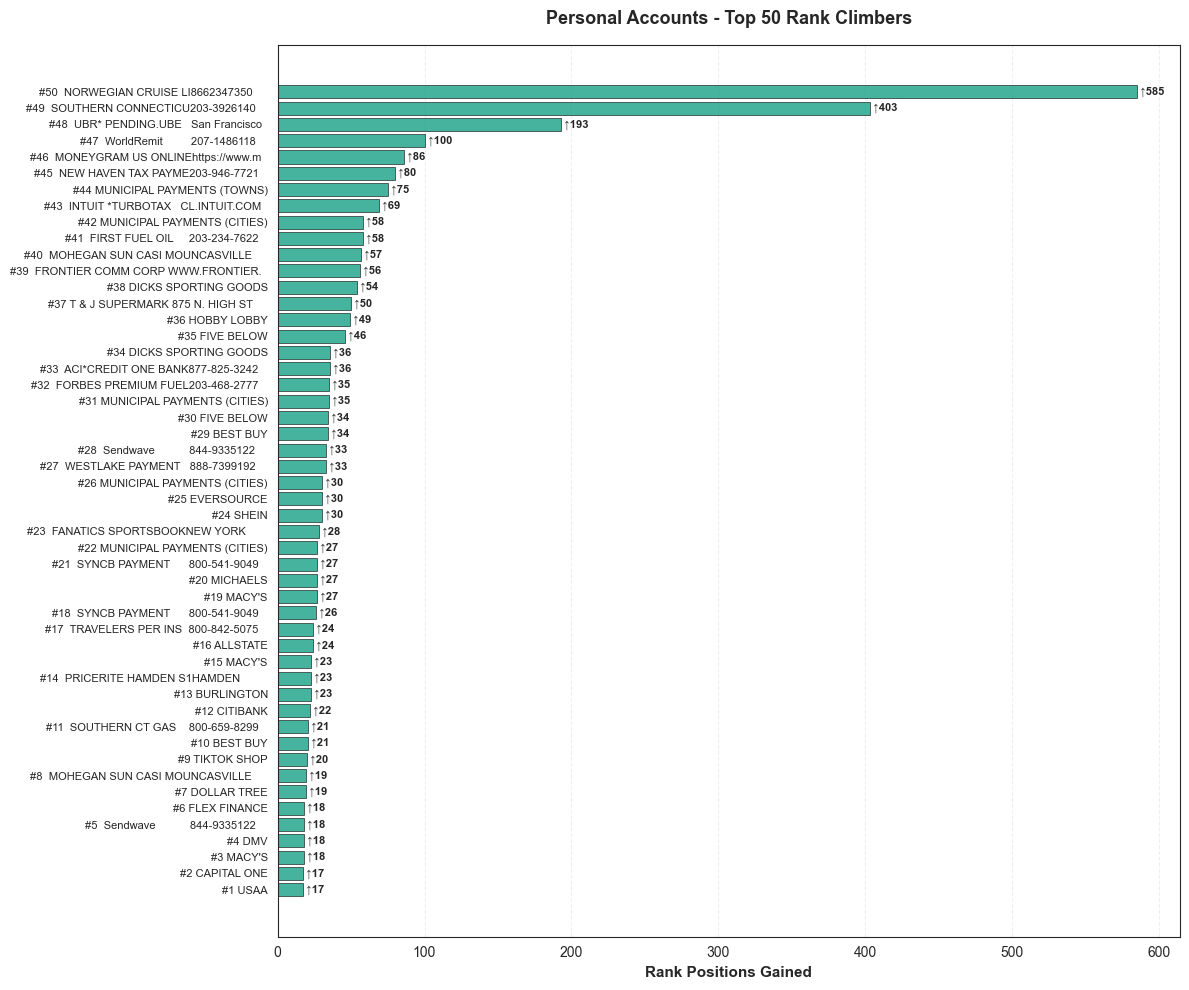

In [73]:
# M5F-2: PERSONAL RANK CLIMBERS VISUALIZATION
print("\n" + "="*120)
print("📈 PERSONAL RANK CLIMBERS - VISUALIZATION")
print("="*120)

import matplotlib.pyplot as plt

# Rebuild movers_df
sorted_months = sorted(personal_df['year_month'].unique())
monthly_movers = []

for i in range(1, len(sorted_months)):
    prev_month = sorted_months[i-1]
    curr_month = sorted_months[i]
    prev_data = personal_df[personal_df['year_month'] == prev_month]
    prev_rankings = prev_data.groupby('merchant_consolidated')['amount'].sum().sort_values(ascending=False)
    prev_rankings = prev_rankings.reset_index()
    prev_rankings['rank'] = range(1, len(prev_rankings) + 1)
    prev_rankings = prev_rankings.set_index('merchant_consolidated')
    
    curr_data = personal_df[personal_df['year_month'] == curr_month]
    curr_rankings = curr_data.groupby('merchant_consolidated')['amount'].sum().sort_values(ascending=False)
    curr_rankings = curr_rankings.reset_index()
    curr_rankings['rank'] = range(1, len(curr_rankings) + 1)
    curr_rankings = curr_rankings.set_index('merchant_consolidated')
    
    common = set(prev_rankings.index) & set(curr_rankings.index)
    
    for merchant in common:
        prev_rank = prev_rankings.loc[merchant, 'rank']
        curr_rank = curr_rankings.loc[merchant, 'rank']
        rank_change = prev_rank - curr_rank
        
        if prev_rank <= 100 or curr_rank <= 100:
            monthly_movers.append({'merchant': merchant, 'rank_change': rank_change})

movers_df = pd.DataFrame(monthly_movers)
top_climbers = movers_df[movers_df['rank_change'] > 0].nlargest(50, 'rank_change')

fig, ax = plt.subplots(figsize=(12, 10))
plot_data = top_climbers.sort_values('rank_change', ascending=True)
merchants = plot_data['merchant'].str[:35]
rank_changes = plot_data['rank_change']

bars = ax.barh(range(len(merchants)), rank_changes, color='#16a085', alpha=0.8, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(merchants)))
ax.set_yticklabels([f"#{i+1} {m}" for i, m in enumerate(merchants)], fontsize=8)
ax.set_xlabel('Rank Positions Gained', fontsize=11, fontweight='bold')
ax.set_title('Personal Accounts - Top 50 Rank Climbers', fontsize=13, fontweight='bold', pad=15)

for i, (bar, val) in enumerate(zip(bars, rank_changes)):
    ax.text(val, bar.get_y() + bar.get_height()/2, f' ↑{int(val)}', va='center', fontsize=8, fontweight='bold')

ax.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()
print("="*120)

#### Viz - Personal Rank Fallers



📉 PERSONAL RANK FALLERS - VISUALIZATION


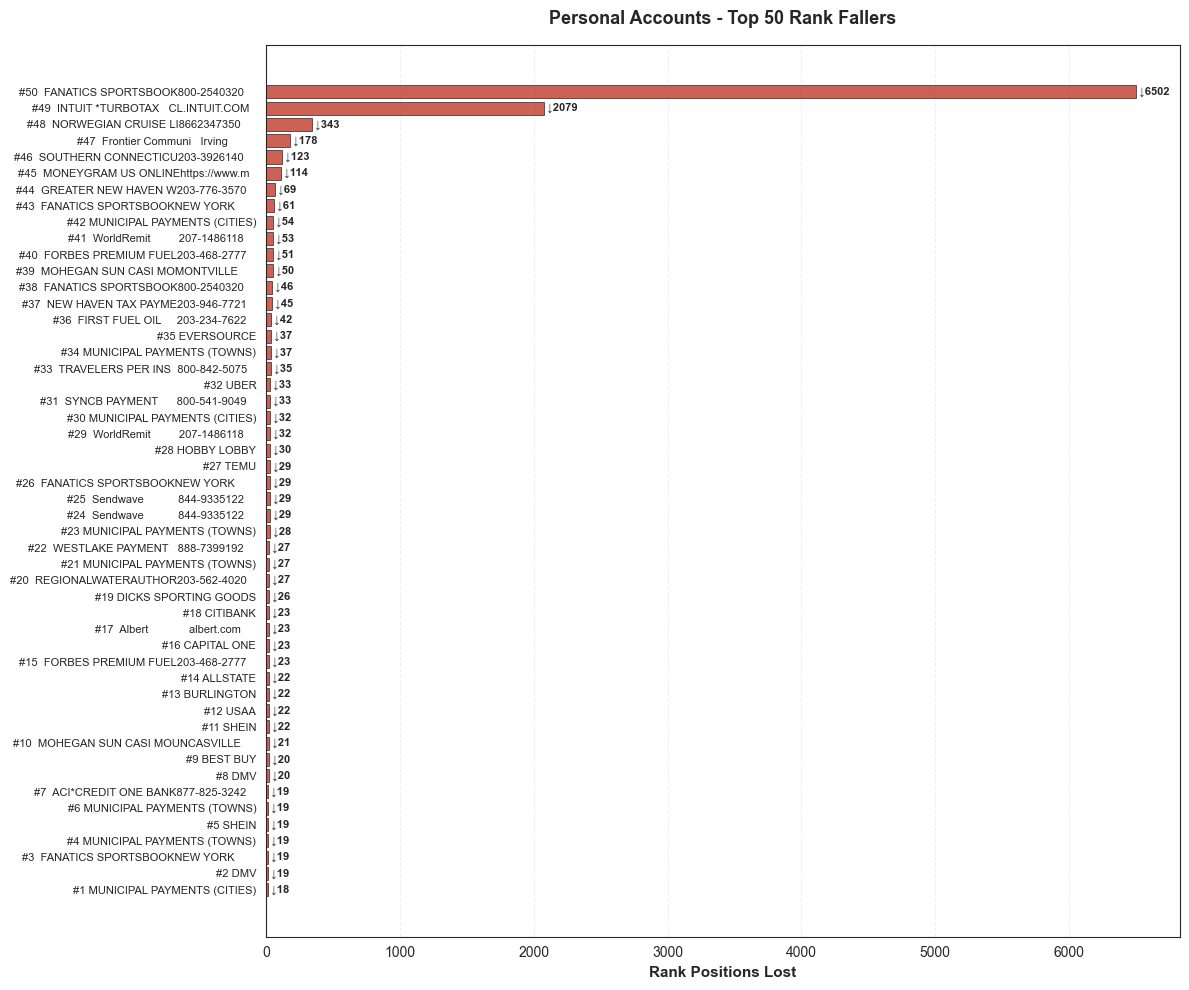

In [74]:
# M5F-3: PERSONAL RANK FALLERS VISUALIZATION
print("\n" + "="*120)
print("📉 PERSONAL RANK FALLERS - VISUALIZATION")
print("="*120)

import matplotlib.pyplot as plt

# Rebuild movers_df
sorted_months = sorted(personal_df['year_month'].unique())
monthly_movers = []

for i in range(1, len(sorted_months)):
    prev_month = sorted_months[i-1]
    curr_month = sorted_months[i]
    prev_data = personal_df[personal_df['year_month'] == prev_month]
    prev_rankings = prev_data.groupby('merchant_consolidated')['amount'].sum().sort_values(ascending=False)
    prev_rankings = prev_rankings.reset_index()
    prev_rankings['rank'] = range(1, len(prev_rankings) + 1)
    prev_rankings = prev_rankings.set_index('merchant_consolidated')
    
    curr_data = personal_df[personal_df['year_month'] == curr_month]
    curr_rankings = curr_data.groupby('merchant_consolidated')['amount'].sum().sort_values(ascending=False)
    curr_rankings = curr_rankings.reset_index()
    curr_rankings['rank'] = range(1, len(curr_rankings) + 1)
    curr_rankings = curr_rankings.set_index('merchant_consolidated')
    
    common = set(prev_rankings.index) & set(curr_rankings.index)
    
    for merchant in common:
        prev_rank = prev_rankings.loc[merchant, 'rank']
        curr_rank = curr_rankings.loc[merchant, 'rank']
        rank_change = prev_rank - curr_rank
        
        if prev_rank <= 100 or curr_rank <= 100:
            monthly_movers.append({'merchant': merchant, 'rank_change': rank_change})

movers_df = pd.DataFrame(monthly_movers)
top_fallers = movers_df[movers_df['rank_change'] < 0].nsmallest(50, 'rank_change')

fig, ax = plt.subplots(figsize=(12, 10))
plot_data = top_fallers.sort_values('rank_change', ascending=False)
merchants = plot_data['merchant'].str[:35]
rank_changes = plot_data['rank_change'].abs()

bars = ax.barh(range(len(merchants)), rank_changes, color='#c0392b', alpha=0.8, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(merchants)))
ax.set_yticklabels([f"#{i+1} {m}" for i, m in enumerate(merchants)], fontsize=8)
ax.set_xlabel('Rank Positions Lost', fontsize=11, fontweight='bold')
ax.set_title('Personal Accounts - Top 50 Rank Fallers', fontsize=13, fontweight='bold', pad=15)

for i, (bar, val) in enumerate(zip(bars, rank_changes)):
    ax.text(val, bar.get_y() + bar.get_height()/2, f' ↓{int(val)}', va='center', fontsize=8, fontweight='bold')

ax.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()
print("="*120)

## 6 - Direct Competition

### Competition Config

#### Competition List Setup

In [ ]:
# ===========================================================================
# M6A: COMPETITOR CONFIGURATION & DETECTION (REVISED)
# Client: 1776 - CoastHills Credit Union (California)
# Market: Santa Barbara, San Luis Obispo, Ventura counties
# ===========================================================================
#
# MATCHING STRATEGY:
#   - starts_with: merchant name begins with this pattern (primary method)
#   - contains:    pattern appears anywhere in merchant name (use sparingly)
#   - exact:       merchant name matches exactly (for short/ambiguous terms)
#
# Base nationals/digital/wallets/BNPL are universal.
# Regionals and credit unions are CoastHills-specific (Central Coast CA).
# ===========================================================================

COMPETITOR_MERCHANTS = {

    # =======================================================================
    # BIG NATIONALS -- Major banks with CA branch presence
    # =======================================================================
    'big_nationals': {
        'starts_with': [
            # Bank of America (major CA presence)
            'BANK OF AMERICA', 'BANKOFAMERICA', 'B OF A', 'BOA ',
            'BK OF AMERICA', 'BK OF AMER',

            # Wells Fargo (major CA presence)
            'WELLS FARGO', 'WELLS FARGO BANK', 'WF BANK', 'WF HOME',
            'WELLSFARGO',

            # JPMorgan Chase (major CA presence)
            'CHASE BANK', 'CHASE BK', 'CHASE CREDIT', 'CHASE CARD',
            'CHASE HOME', 'CHASE AUTO', 'CHASE MTG',
            'JPMORGAN', 'JPMORGAN CHASE', 'JP MORGAN',

            # Citibank
            'CITIBANK', 'CITI BANK', 'CITI CARD', 'CITICORP',
            'CITI MORTGAGE', 'CITIMORTGAGE',

            # US Bank
            'US BANK', 'U.S. BANK', 'US BK', 'USB ',

            # Capital One (banking arm)
            'CAPITAL ONE BK', 'CAPITAL ONE BANK', 'CAPITAL ONE 360',
            'CAP ONE BANK', 'CAPITALONE BK', 'CAPITAL ONE',

            # PNC Bank
            'PNC BANK', 'PNC BK',
        ],
        'exact': [
            'CHASE', 'BOA', 'CITI',
        ],
    },

    # =======================================================================
    # REGIONALS -- Central Coast CA community/savings banks
    # =======================================================================
    'regionals': {
        'starts_with': [
            # Mechanics Bank (Central Coast presence)
            'MECHANICS BANK', 'MECHANICS BK',

            # Pacific Premier Bank (CA regional)
            'PACIFIC PREMIER', 'PACIFIC PREMIER BANK', 'PACIFIC PREMIER BK',

            # Columbia Bank (CA regional)
            'COLUMBIA BANK', 'COLUMBIA BK', 'COLUMBIA BANKING',

            # American Riviera Bank (Santa Barbara local)
            'AMERICAN RIVIERA', 'AMERICAN RIVIERA BANK', 'AMERICAN RIVIERA BK',

            # Community Bank of Santa Maria (local)
            'COMMUNITY BANK OF SANTA', 'COMMUNITY BANK SANTA MARIA',
            'COMMUNITY BK SANTA MARIA',

            # Bank of the Sierra (CA regional)
            'BANK OF THE SIERRA', 'BK OF THE SIERRA', 'SIERRA BANK',

            # West Coast Community Bank (local)
            'WEST COAST COMMUNITY', 'WEST COAST COMMUNITY BANK',
            'WEST COAST COMMUNITY BK',
        ],
        'exact': [
            'MECHANICS BANK',
        ],
    },

    # =======================================================================
    # CREDIT UNIONS -- Local/regional CUs competing in CoastHills's market
    # =======================================================================
    'credit_unions': {
        'starts_with': [
            # SESLOC CU (San Luis Obispo -- direct competitor)
            'SESLOC CREDIT UNION', 'SESLOC CU', 'SESLOC FEDERAL',
            'SESLOC FCU', 'SESLOC',

            # SLO Credit Union (San Luis Obispo -- direct competitor)
            'SLO CREDIT UNION', 'SLO CU', 'SLO FEDERAL', 'SLO FCU',
            'SAN LUIS OBISPO CU', 'SAN LUIS OBISPO CREDIT',

            # National CUs with CA presence
            'NAVY FEDERAL', 'NAVY FED', 'NFCU',
            'GOLDEN 1 CREDIT', 'GOLDEN 1 CU',
            'PENTAGON FEDERAL', 'PENTAGON FCU', 'PENFED',
            'STATE EMPLOYEES CU', 'SECU ',
            'USAA',
            'ALLIANT CREDIT',
            'DIGITAL FCU',
        ],
        'exact': [
            'SESLOC',
        ],
    },

    # =======================================================================
    # DIGITAL BANKS -- Online-only banks (universal)
    # =======================================================================
    'digital_banks': {
        'starts_with': [
            'ALLY BANK', 'ALLY BK', 'ALLY FINANCIAL',
            'DISCOVER BANK', 'DISCOVER BK', 'DISCOVER SAVINGS',
            'SOFI BANK', 'SOFI MONEY', 'SOFI LENDING', 'SOFI CREDIT', 'SOFI',
            'CHIME BANK', 'CHIME FINANCIAL',
            'VARO BANK', 'VARO MONEY',
            'GO2BANK',
            'GREEN DOT BANK', 'GREEN DOT BK', 'GREENDOT',
            'THE BANCORP', 'BANCORP BANK',
            'STRIDE BANK',
            'COASTAL COMMUNITY BK',
            'MARCUS BY GS', 'MARCUS BY GOLDMAN', 'MARCUS GOLDMAN',
            'GOLDMAN SACHS BANK',
            'SCHWAB BANK', 'CHARLES SCHWAB BK', 'SCHWAB BK',
            'FIDELITY CASH', 'FIDELITY BROKERAGE',
            'ROBINHOOD CASH', 'ROBINHOOD MONEY',
            'BETTERMENT', 'WEALTHFRONT',
            'REVOLUT', 'N26 BANK', 'N26', 'MONZO',
            'DAVE INC', 'DAVE APP', 'EARNIN', 'BRIGIT',
            'POSSIBLE FINANCE', 'CURRENT CARD',
        ],
        'contains': [
            'CHIME', 'VARO', 'GREEN DOT', 'SYNCHRONY',
        ],
        'exact': [
            'CHIME', 'REVOLUT', 'BETTERMENT', 'WEALTHFRONT',
            'SOFI', 'ROBINHOOD', 'MARCUS',
        ],
    },

    # =======================================================================
    # WALLETS & P2P -- Payment platforms (universal)
    # =======================================================================
    'wallets_p2p': {
        'starts_with': [
            'PAYPAL', 'VENMO',
            'CASH APP', 'CASHAPP',
            'APPLE CASH', 'APPLE CARD', 'APPLE PAY CASH',
            'GOOGLE PAY', 'GOOGLEPAY',
            'ZELLE', 'SQ *',
        ],
        'contains': [
            'PAYPAL', 'VENMO', 'CASH APP', 'CASHAPP',
            'APPLE CASH', 'GOOGLE PAY', 'ZELLE',
        ],
        'exact': [
            'PAYPAL', 'VENMO',
        ],
    },

    # =======================================================================
    # BNPL -- Buy Now Pay Later (universal)
    # =======================================================================
    'bnpl': {
        'starts_with': [
            'KLARNA', 'AFTERPAY', 'AFFIRM', 'AFFIRM INC',
            'SEZZLE', 'QUADPAY', 'ZIP PAY', 'ZIPPAY',
        ],
        'contains': [
            'AFTERPAY', 'KLARNA', 'AFFIRM',
            'SEZZLE', 'ZIP PAY', 'QUADPAY',
        ],
        'exact': [
            'KLARNA', 'AFTERPAY', 'SEZZLE',
        ],
    },

    # =======================================================================
    # ALT FINANCE -- Alternative financial services
    # =======================================================================
    'alt_finance': {
        'starts_with': [
            'FLEX FINANCE', 'FLEXFINANCE',
            'MONEYLION', 'ALBERT SAVINGS', 'EMPOWER FINANCE',
        ],
    },
}

# Reporting category groupings
TRUE_COMPETITORS = ['big_nationals', 'regionals', 'credit_unions', 'digital_banks']
PAYMENT_ECOSYSTEMS = ['wallets_p2p', 'bnpl']

# Financial MCC codes for unmatched discovery
FINANCIAL_MCC_CODES = [
    6010, 6011, 6012, 6051, 6211, 6300,
]

# False positive exclusions
FALSE_POSITIVES = [
    'TOWING', 'TOW SERVICE', 'BODY SHOP',
    'AUTO REPAIR', 'AUTO PARTS', 'AUTOZONE', 'AUTO TRADER',
    'TRADER JOE', 'CHASE OUTDOORS', 'CURRENT ELECTRIC',
    'COASTHILLS MARKETPLACE',
]


def classify_competitor(merchant_name, config=COMPETITOR_MERCHANTS):
    """Classify a merchant using three-tier matching: exact > starts_with > contains"""
    if not merchant_name or not isinstance(merchant_name, str):
        return None, None
    name = merchant_name.upper().strip()
    for fp in FALSE_POSITIVES:
        if fp in name:
            return None, None
    for category, rules in config.items():
        for pattern in rules.get('exact', []):
            if name == pattern:
                return category, pattern
    for category, rules in config.items():
        for pattern in rules.get('starts_with', []):
            if name.startswith(pattern):
                return category, pattern
    for category, rules in config.items():
        for pattern in rules.get('contains', []):
            if pattern in name:
                return category, pattern
    return None, None


def tag_competitors(df, merchant_col='merchant_consolidated'):
    """Tag all transactions with competitor category and matched pattern."""
    results = df[merchant_col].apply(
        lambda x: classify_competitor(x) if pd.notna(x) else (None, None)
    )
    df['competitor_category'] = results.apply(lambda x: x[0])
    df['competitor_match'] = results.apply(lambda x: x[1])
    return df


def discover_unmatched_financial(df, merchant_col='merchant_consolidated', mcc_col='mcc_code'):
    """Find merchants with financial MCC codes that weren't matched as competitors."""
    untagged = df[df['competitor_category'].isna()].copy()
    if mcc_col in untagged.columns:
        financial = untagged[untagged[mcc_col].isin(FINANCIAL_MCC_CODES)]
    else:
        financial_keywords = [
            'BANK', ' BK ', 'BK,', 'CREDIT UNION', ' CU ', 'CU,',
            'FEDERAL CU', 'FCU', 'SAVINGS BANK', 'SVG BK',
            'FINANCIAL', 'LENDING', 'MORTGAGE', 'MTG ',
        ]
        mask = untagged[merchant_col].str.upper().apply(
            lambda x: any(kw in f' {x} ' for kw in financial_keywords) if pd.notna(x) else False
        )
        financial = untagged[mask]
    if len(financial) == 0:
        print("No unmatched financial merchants found.")
        return pd.DataFrame()
    summary = financial.groupby(merchant_col).agg(
        transaction_count=('amount', 'count'),
        total_spend=('amount', 'sum'),
        unique_accounts=('primary_account_num', 'nunique'),
    ).sort_values('total_spend', ascending=False)
    return summary


def print_config_summary(config=COMPETITOR_MERCHANTS):
    """Print a summary of the competitor configuration."""
    print("=" * 80)
    print(" " * 20 + "COMPETITOR CONFIGURATION SUMMARY")
    print("=" * 80)
    total_patterns = 0
    for category, rules in config.items():
        n_starts = len(rules.get('starts_with', []))
        n_exact = len(rules.get('exact', []))
        n_contains = len(rules.get('contains', []))
        n_total = n_starts + n_exact + n_contains
        total_patterns += n_total
        display_name = category.replace('_', ' ').title()
        print(f"\n  {display_name}:")
        print(f"    starts_with: {n_starts:3d} patterns")
        if n_exact:
            print(f"    exact:       {n_exact:3d} patterns")
        if n_contains:
            print(f"    contains:    {n_contains:3d} patterns")
    print(f"\n{'=' * 80}")
    print(f"  Total categories: {len(config)}")
    print(f"  Total patterns:   {total_patterns}")
    print("=" * 80)

print_config_summary()

In [ ]:
# M6A: COMPETITOR CONFIGURATION & TRANSACTION DETECTION
# Identifies all competitor transactions across the dataset
print("\n" + "="*120)
print(" " * 40 + "M6A: COMPETITOR CONFIGURATION & DETECTION")
print("="*120)

# ===========================================================================
# COMPETITOR UNIVERSE CONFIGURATION (FLAT LIST -- for simple contains matching)
# Client: 1776 - CoastHills Credit Union (California)
# Market: Santa Barbara, San Luis Obispo, Ventura counties
# ===========================================================================

COMPETITOR_MERCHANTS = {
    'big_nationals': [
        'BANK OF AMERICA',
        'B OF A',
        'WELLS FARGO', 'WELLS FARGO BANK',
        'CHASE', 'JPMORGAN CHASE',
        'US BANK', 'U.S. BANK',
        'CITIBANK', 'CITI CARD',
        'CAPITAL ONE BANK', 'CAPITAL ONE',
        'PNC BANK',
    ],

    'regionals': [
        'MECHANICS BANK',
        'PACIFIC PREMIER BANK',
        'COLUMBIA BANK',
        'AMERICAN RIVIERA BANK',
        'COMMUNITY BANK OF SANTA MARIA',
        'BANK OF THE SIERRA',
        'WEST COAST COMMUNITY BANK',
    ],

    'credit_unions': [
        'SESLOC CREDIT UNION', 'SESLOC CU',
        'SLO CREDIT UNION', 'SLO CU',
        'NAVY FEDERAL CREDIT UNION', 'NAVY FEDERAL CU',
        'GOLDEN 1 CREDIT UNION', 'GOLDEN 1 CU',
        'PENTAGON FEDERAL', 'PENFED',
        'USAA',
    ],

    'digital_banks': [
        'ALLY BANK',
        'DISCOVER BANK',
        'CAPITAL ONE 360',
        'SOFI BANK', 'SOFI',
        'CHIME',
        'THE BANCORP',
        'STRIDE BANK',
        'VARO BANK', 'VARO',
        'CURRENT CARD',
        'GO2BANK',
        'GREEN DOT',
        'REVOLUT',
        'MARCUS',
        'GOLDMAN SACHS',
        'SCHWAB BANK', 'CHARLES SCHWAB',
        'FIDELITY CASH',
        'ROBINHOOD',
        'BETTERMENT',
        'WEALTHFRONT',
    ],

    'wallets_p2p': [
        'PAYPAL',
        'VENMO',
        'CASH APP',
        'SQ*',
        'APPLE CASH', 'APPLE CARD',
        'GOOGLE PAY',
        'ZELLE',
    ],

    'bnpl': [
        'KLARNA',
        'AFTERPAY',
        'AFFIRM',
        'ZIP PAY',
        'QUADPAY',
        'SEZZLE',
    ]
}

print("\nCompetitor Universe Configured")
print(f"Total Categories: {len(COMPETITOR_MERCHANTS)}")
for category, merchants in COMPETITOR_MERCHANTS.items():
    print(f"  {category.replace('_', ' ').title()}: {len(merchants)} competitors")

print(f"\nTotal Competitors to Track: {sum(len(v) for v in COMPETITOR_MERCHANTS.values())}")

#### Competition Detetction

In [80]:
# ===========================================================================
# M6A-2: COMPETITOR DETECTION
# ===========================================================================
print("\n" + "="*120)
print(" " * 40 + "M6A-2: SEARCHING FOR COMPETITORS")
print("="*120)

# Tag competitors using the two-tier matching function
combined_df = tag_competitors(combined_df, merchant_col='merchant_consolidated')

# Build summary from tagged results
competitor_txns = combined_df[combined_df['competitor_category'].notna()]

summary_data = competitor_txns.groupby(['competitor_category', 'competitor_match']).agg(
    total_transactions=('amount', 'count'),
    unique_accounts=('primary_account_num', 'nunique'),
    total_amount=('amount', 'sum')
).reset_index().rename(columns={
    'competitor_category': 'category',
    'competitor_match': 'competitor'
}).sort_values('total_amount', ascending=False)

# Also tag business and personal if they exist
if 'business_df' in dir() and len(business_df) > 0:
    business_df = tag_competitors(business_df, merchant_col='merchant_consolidated')
if 'personal_df' in dir() and len(personal_df) > 0:
    personal_df = tag_competitors(personal_df, merchant_col='merchant_consolidated')

print(f"\nSearched {len(combined_df):,} transactions")
print(f"✓ Competitor transactions found: {len(competitor_txns):,}")
print(f"✓ Unique patterns matched: {competitor_txns['competitor_match'].nunique()}")
print(f"✓ Categories with activity: {competitor_txns['competitor_category'].nunique()}")

# Summary by category
print(f"\nBy category:")
cat_summary = competitor_txns.groupby('competitor_category').agg(
    transactions=('amount', 'count'),
    spend=('amount', 'sum'),
    accounts=('primary_account_num', 'nunique')
)
for cat, row in cat_summary.iterrows():
    print(f"  • {cat.replace('_', ' ').title():20s} {row['transactions']:>8,} txns  ${row['spend']:>12,.2f}  ({row['accounts']:,} accounts)")

print("="*120)


                                        M6A-2: SEARCHING FOR COMPETITORS

Searched 5,525,537 transactions
✓ Competitor transactions found: 412,712
✓ Unique patterns matched: 31
✓ Categories with activity: 6

By category:
  • Big Nationals         2,287.0 txns  $  473,818.80  (548.0 accounts)
  • Bnpl                 78,349.0 txns  $3,263,522.78  (2,572.0 accounts)
  • Credit Unions            81.0 txns  $   21,848.61  (46.0 accounts)
  • Digital Banks         1,633.0 txns  $  119,281.89  (218.0 accounts)
  • Regionals                19.0 txns  $    2,769.48  (12.0 accounts)
  • Wallets P2P          330,343.0 txns  $29,157,241.38  (8,262.0 accounts)


In [81]:
# In your reporting, split these
TRUE_COMPETITORS = ['big_nationals', 'regionals', 'credit_unions', 'digital_banks']
PAYMENT_ECOSYSTEMS = ['wallets_p2p', 'bnpl']

# Filter for actual competitive threats
true_competitor_txns = competitor_txns[competitor_txns['competitor_category'].isin(TRUE_COMPETITORS)]
ecosystem_txns = competitor_txns[competitor_txns['competitor_category'].isin(PAYMENT_ECOSYSTEMS)]

print(f"True competitor spend:      ${true_competitor_txns['amount'].sum():>14,.2f}")
print(f"Payment ecosystem spend:    ${ecosystem_txns['amount'].sum():>14,.2f}")

True competitor spend:      $    617,718.78
Payment ecosystem spend:    $ 32,420,764.16


#### Competitor Quick Summary

In [82]:
# ===========================================================================
# M6A-3: QUICK SUMMARY
# ===========================================================================

print("\n" + "="*120)
print(" " * 40 + "M6A-3: COMPETITOR DETECTION SUMMARY")
print("="*120)

if len(all_competitor_data) == 0:
    print("\n⚠ No competitor transactions found")
else:
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('total_amount', ascending=False)
    
    total_competitor_trans = summary_df['total_transactions'].sum()
    total_competitor_spend = summary_df['total_amount'].sum()
    total_competitor_accounts = summary_df['unique_accounts'].sum()
    
    print(f"\n✓ Found {len(all_competitor_data)} competitors with activity")
    print(f"  • Total Transactions: {total_competitor_trans:,}")
    print(f"  • Total Spend: ${total_competitor_spend:,.2f}")
    print(f"  • Unique Accounts: {total_competitor_accounts:,}")
    
    # Quick category breakdown
    print("\n📊 By Category:")
    category_summary = summary_df.groupby('category')['total_amount'].sum().sort_values(ascending=False)
    for cat, amount in category_summary.items():
        print(f"  • {cat.replace('_', ' ').title()}: ${amount:,.0f}")

print("\n" + "="*120)
print("✓ Detection complete - data in 'all_competitor_data' and 'summary_data'")
print("="*120)


                                        M6A-3: COMPETITOR DETECTION SUMMARY

✓ Found 1 competitors with activity
  • Total Transactions: 412,712
  • Total Spend: $33,038,482.94
  • Unique Accounts: 17,622

📊 By Category:
  • Wallets P2P: $29,157,241
  • Bnpl: $3,263,523
  • Big Nationals: $473,819
  • Digital Banks: $119,282
  • Credit Unions: $21,849
  • Regionals: $2,769

✓ Detection complete - data in 'all_competitor_data' and 'summary_data'


In [115]:
# ============================================
# COMPETITOR VALIDATION: Find Missing Patterns
# ============================================

import pandas as pd

# First, let's see what you're actually capturing
def audit_competitor_matches(df, competitor_dict):
    """
    Shows exactly which merchants matched and which might be missed
    """
    
    print("=" * 60)
    print("COMPETITOR MATCH AUDIT")
    print("=" * 60)
    
    for category, patterns in competitor_dict.items():
        print(f"\n📁 {category.upper()}")
        print("-" * 60)
        
        for pattern in patterns:
            # Find all merchants that match this pattern
            matches = df[df['merchant_name'].str.contains(pattern, case=False, na=False)]
            
            if len(matches) > 0:
                unique_merchants = matches['merchant_name'].unique()
                total_spend = matches['amount'].sum()
                total_txns = len(matches)
                
                print(f"\n  ✓ Pattern: '{pattern}'")
                print(f"    Spend: ${total_spend:,.2f} | Txns: {total_txns:,}")
                print(f"    Matched merchant names ({len(unique_merchants)}):")
                
                # Show first 10 actual merchant names
                for merchant in sorted(unique_merchants)[:10]:
                    merchant_spend = matches[matches['merchant_name'] == merchant]['amount'].sum()
                    print(f"      • {merchant}: ${merchant_spend:,.2f}")
                
                if len(unique_merchants) > 10:
                    print(f"      ... and {len(unique_merchants) - 10} more")
            else:
                print(f"\n  ✗ Pattern: '{pattern}' - NO MATCHES FOUND")

# Run the audit
audit_competitor_matches(combined_df, all_competitors)

COMPETITOR MATCH AUDIT


AttributeError: 'list' object has no attribute 'items'

In [116]:
# ============================================
# SANITY CHECK: Search for competitors manually
# ============================================

def find_potential_competitors(df, search_terms):
    """
    Broad search to see if competitors exist in data at all
    """
    
    print("\n" + "=" * 60)
    print("BROAD COMPETITOR SEARCH")
    print("=" * 60)
    
    for term in search_terms:
        matches = df[df['merchant_name'].str.contains(term, case=False, na=False)]
        
        if len(matches) > 0:
            print(f"\n🔍 Search: '{term}'")
            print(f"   Found: {len(matches):,} transactions | ${matches['amount'].sum():,.2f}")
            print(f"   Sample merchants:")
            
            # Show top 5 by spend
            top_merchants = matches.groupby('merchant_name')['amount'].agg(['sum', 'count'])
            top_merchants = top_merchants.sort_values('sum', ascending=False).head(5)
            
            for merchant, row in top_merchants.iterrows():
                print(f"      • {merchant}")
                print(f"        ${row['sum']:,.2f} | {int(row['count']):,} txns")
        else:
            print(f"\n✗ Search: '{term}' - Nothing found")

# Test with common competitor names
search_terms = [
    'CHIME',
    'CASH APP',
    'VENMO',
    'PAYPAL',
    'SOFI',
    'ALLY',
    'MARCUS',
    'CAPITAL ONE',
    'DISCOVER',
    'CHASE',
    'AFFIRM',
    'AFTERPAY',
    'KLARNA',
    'ZIP',
    'NAVY FEDERAL',
    'USAA',
    'PNC',
    'WELLS FARGO',
    'BANK OF AMERICA'
]

find_potential_competitors(combined_df, search_terms)


BROAD COMPETITOR SEARCH

🔍 Search: 'CHIME'
   Found: 1,456 transactions | $91,944.10
   Sample merchants:
      •  Chime              chime.com      CAUS
        $89,720.03 | 1,410 txns
      •  Chime              San Francisco  CAUS
        $1,949.78 | 41 txns
      •  SP ASTARIN         ASTARINCHIMES  COUS
        $93.14 | 1 txns
      •  SP THE WIND CHIME CTHEWINDCHIME.  MIUS
        $72.34 | 1 txns
      •  PAYPAL *WINDCHIMECO402-935-7733   CAUS
        $64.99 | 1 txns

🔍 Search: 'CASH APP'
   Found: 177,920 transactions | $15,199,026.93
   Sample merchants:
      •  CASH APP*NICOLE BOOOakland        CAUS
        $55,994.00 | 80 txns
      •  CASH APP*TIANA OCASOakland        CAUS
        $53,937.30 | 280 txns
      •  CASH APP*CHRISTOPHEOakland        CAUS
        $49,016.87 | 442 txns
      •  CASH APP*TYRELL*ADDOakland        CAUS
        $48,908.29 | 160 txns
      •  CASH APP*CATHY GOULOakland        CAUS
        $44,952.00 | 123 txns

🔍 Search: 'VENMO'
   Found: 54,106 trans

In [85]:
# ===========================================================================
# COMPETITOR SPEND ANALYSIS - ACCOUNT SEGMENTATION
# ===========================================================================
"""
## Creates competitor_spend_analysis dictionary for segmentation
Analyzes what % of each account's spend goes to each competitor
"""

print("\n" + "="*120)
print(" " * 40 + "ANALYZING COMPETITOR SPEND BY ACCOUNT")
print("="*120)

if len(all_competitor_data) == 0:
    print("\n⚠ No competitor data found - run M6A detection first!")
else:
    competitor_spend_analysis = {}
    
    # Get total spend per account (for percentage calculations)
    account_totals = combined_df.groupby('primary_account_num')['amount'].sum()
    
    print(f"\nAnalyzing spend patterns for {len(all_competitor_data)} competitors...")
    
    for competitor, competitor_trans in all_competitor_data.items():
        # Get spend per account for this competitor
        competitor_spend_by_account = competitor_trans.groupby('primary_account_num')['amount'].sum()
        
        # Create comparison dataframe
        comparison = pd.DataFrame({
            'account': competitor_spend_by_account.index,
            'competitor_spend': competitor_spend_by_account.values
        })
        
        # Add total spend for each account
        comparison['total_spend'] = comparison['account'].map(account_totals)
        
        # Calculate percentage
        comparison['competitor_pct'] = (comparison['competitor_spend'] / comparison['total_spend'] * 100)
        
        # Segment accounts
        comparison['Segment'] = pd.cut(
            comparison['competitor_pct'],
            bins=[0, 25, 50, 100],
            labels=['CU-Focused', 'Balanced', 'Competitor-Heavy'],
            include_lowest=True
        )
        
        # Store in dictionary
        competitor_spend_analysis[competitor] = comparison
    
    print(f"✓ Analysis complete for {len(competitor_spend_analysis)} competitors")
    
    # Quick summary
    total_heavy = sum(len(df[df['Segment'] == 'Competitor-Heavy']) for df in competitor_spend_analysis.values())
    total_balanced = sum(len(df[df['Segment'] == 'Balanced']) for df in competitor_spend_analysis.values())
    total_cu = sum(len(df[df['Segment'] == 'CU-Focused']) for df in competitor_spend_analysis.values())
    
    print(f"\nOverall Segmentation:")
    print(f"  • Competitor-Heavy accounts: {total_heavy:,}")
    print(f"  • Balanced accounts: {total_balanced:,}")
    print(f"  • CU-Focused accounts: {total_cu:,}")

print("="*120)



                                        ANALYZING COMPETITOR SPEND BY ACCOUNT

Analyzing spend patterns for 1 competitors...
✓ Analysis complete for 1 competitors

Overall Segmentation:
  • Competitor-Heavy accounts: 0
  • Balanced accounts: 0
  • CU-Focused accounts: 14


### Competitor Analysis


#### Summary

In [117]:
# ===========================================================================
# OVERALL SUMMARY
# ===========================================================================

print("\n" + "="*120)
print("COMPETITOR DETECTION SUMMARY")
print("="*120)

if len(all_competitor_data) > 0:
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('total_amount', ascending=False)
    
    # Format for display
    summary_display = summary_df.copy()
    summary_display['category'] = summary_display['category'].str.replace('_', ' ').str.title()
    summary_display['total_amount'] = summary_display['total_amount'].apply(lambda x: f"${x:,.0f}")
    summary_display['total_transactions'] = summary_display['total_transactions'].apply(lambda x: f"{x:,}")
    summary_display['unique_accounts'] = summary_display['unique_accounts'].apply(lambda x: f"{x:,}")
    
    summary_display.columns = ['Competitor', 'Category', 'Transactions', 'Unique Accounts', 'Total Amount']
    
    print(f"\n✓ Found {len(all_competitor_data)} competitors with transaction activity")
    print(f"Total Competitor Transactions: {summary_df['total_transactions'].sum():,}")
    print(f"Total Competitor Spend: ${summary_df['total_amount'].sum():,.2f}")
    print(f"Unique Accounts Using Competitors: {summary_df['unique_accounts'].sum():,}\n")
    
    display(summary_display.style.hide(axis='index'))
    
    # Category breakdown
    print("\n📊 BY CATEGORY:")
    category_summary = summary_df.groupby('category').agg({
        'total_transactions': 'sum',
        'unique_accounts': 'sum',
        'total_amount': 'sum',
        'competitor': 'count'
    }).sort_values('total_amount', ascending=False)
    
    category_summary.columns = ['Total Transactions', 'Total Accounts', 'Total Amount', 'Competitor Count']
    category_display = category_summary.copy()
    category_display.index = category_display.index.str.replace('_', ' ').str.title()
    category_display['Total Transactions'] = category_display['Total Transactions'].apply(lambda x: f"{x:,}")
    category_display['Total Accounts'] = category_display['Total Accounts'].apply(lambda x: f"{x:,}")
    category_display['Total Amount'] = category_display['Total Amount'].apply(lambda x: f"${x:,.0f}")
    
    display(category_display)
    
else:
    print("\n⚠ No competitor transactions found in dataset")

print("\n" + "="*120)
print("✓ Competitor detection complete - data stored in 'all_competitor_data' dictionary")
print("="*120)



COMPETITOR DETECTION SUMMARY

✓ Found 1 competitors with transaction activity
Total Competitor Transactions: 412,712
Total Competitor Spend: $33,038,482.94
Unique Accounts Using Competitors: 17,622




📊 BY CATEGORY:


Total Transactions Total Accounts Total Amount  Competitor Count
category                                                                      
Wallets P2P              330,343         12,707  $29,157,241                 5
Bnpl                      78,349          4,082   $3,263,523                 4
Big Nationals              2,287            556     $473,819                 8
Digital Banks              1,633            219     $119,282                 4
Credit Unions                 81             46      $21,849                 6
Regionals                     19             12       $2,769                 4


✓ Competitor detection complete - data stored in 'all_competitor_data' dictionary


#### Competition Metrics

In [118]:
# ===========================================================================
# M6B-1: HIGH-LEVEL METRICS
# ===========================================================================

print("\n" + "="*120)
print(" " * 40 + "M6B-1: HIGH-LEVEL COMPETITOR METRICS")
print("="*120)

if len(all_competitor_data) == 0:
    print("\n⚠ No competitor data to analyze")
else:
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('total_amount', ascending=False)
    
    total_competitor_trans = summary_df['total_transactions'].sum()
    total_competitor_spend = summary_df['total_amount'].sum()
    total_competitor_accounts = summary_df['unique_accounts'].sum()
    total_competitors_found = len(all_competitor_data)
    
    # Calculate as % of overall dataset
    total_all_trans = len(combined_df)
    total_all_spend = combined_df['amount'].sum()
    total_all_accounts = combined_df['primary_account_num'].nunique()
    
    pct_trans = (total_competitor_trans / total_all_trans * 100) if total_all_trans > 0 else 0
    pct_spend = (total_competitor_spend / total_all_spend * 100) if total_all_spend > 0 else 0
    pct_accounts = (total_competitor_accounts / total_all_accounts * 100) if total_all_accounts > 0 else 0
    
    metrics_summary = pd.DataFrame({
        'Metric': [
            'Competitors Found',
            '',
            'Total Competitor Transactions',
            '% of All Transactions',
            '',
            'Total Competitor Spend',
            '% of All Spend',
            '',
            'Unique Accounts Using Competitors',
            '% of All Accounts',
            '',
            'Avg Spend per Competitor Account',
            'Avg Transactions per Competitor Account'
        ],
        'Value': [
            f"{total_competitors_found:,}",
            '',
            f"{total_competitor_trans:,}",
            f"{pct_trans:.2f}%",
            '',
            f"${total_competitor_spend:,.2f}",
            f"{pct_spend:.2f}%",
            '',
            f"{total_competitor_accounts:,}",
            f"{pct_accounts:.2f}%",
            '',
            f"${total_competitor_spend / total_competitor_accounts:,.2f}" if total_competitor_accounts > 0 else "$0.00",
            f"{total_competitor_trans / total_competitor_accounts:.1f}" if total_competitor_accounts > 0 else "0.0"
        ]
    })
    
    display(metrics_summary.style.hide(axis='index'))

print("="*120)


                                        M6B-1: HIGH-LEVEL COMPETITOR METRICS


#### Top 20 Competitions by Spend and FinServ

In [119]:
# ===========================================================================
# M6B-2: TOP 20 COMPETITORS BY SPEND
# ===========================================================================

print("\n" + "="*120)
print(" " * 40 + "M6B-2: TOP 20 COMPETITORS BY SPEND")
print("="*120)

if len(all_competitor_data) > 0:
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('total_amount', ascending=False)
    
    top_20 = summary_df.head(20).copy()
    top_20_display = top_20.copy()
    top_20_display['category'] = top_20_display['category'].str.replace('_', ' ').str.title()
    top_20_display['total_amount'] = top_20_display['total_amount'].apply(lambda x: f"${x:,.0f}")
    top_20_display['total_transactions'] = top_20_display['total_transactions'].apply(lambda x: f"{x:,}")
    top_20_display['unique_accounts'] = top_20_display['unique_accounts'].apply(lambda x: f"{x:,}")
    
    # Add average per account
    top_20_display['avg_per_account'] = top_20.apply(
        lambda row: f"${row['total_amount'] / row['unique_accounts']:,.2f}", 
        axis=1
    )
    
    top_20_display.columns = ['Competitor', 'Category', 'Transactions', 'Unique Accounts', 'Total Spend', 'Avg per Account']
    
    display(top_20_display.style.hide(axis='index'))

print("="*120)


                                        M6B-2: TOP 20 COMPETITORS BY SPEND


#### Competitor Category Breakdown 

In [120]:
# ===========================================================================
# M6B-3: CATEGORY BREAKDOWN
# ===========================================================================

print("\n" + "="*120)
print(" " * 40 + "M6B-3: BREAKDOWN BY CATEGORY")
print("="*120)

if len(all_competitor_data) > 0:
    summary_df = pd.DataFrame(summary_data)
    
    category_summary = summary_df.groupby('category').agg({
        'total_transactions': 'sum',
        'unique_accounts': 'sum',
        'total_amount': 'sum',
        'competitor': 'count'
    }).sort_values('total_amount', ascending=False)
    
    category_summary.columns = ['Total Transactions', 'Total Accounts', 'Total Spend', 'Competitor Count']
    
    # Add percentages
    category_summary['% of Competitor Spend'] = (
        category_summary['Total Spend'] / category_summary['Total Spend'].sum() * 100
    )
    category_summary['Avg per Competitor'] = (
        category_summary['Total Spend'] / category_summary['Competitor Count']
    )
    
    category_display = category_summary.copy()
    category_display.index = category_display.index.str.replace('_', ' ').str.title()
    category_display['Total Transactions'] = category_display['Total Transactions'].apply(lambda x: f"{int(x):,}")
    category_display['Total Accounts'] = category_display['Total Accounts'].apply(lambda x: f"{int(x):,}")
    category_display['Total Spend'] = category_display['Total Spend'].apply(lambda x: f"${x:,.0f}")
    category_display['% of Competitor Spend'] = category_display['% of Competitor Spend'].apply(lambda x: f"{x:.1f}%")
    category_display['Avg per Competitor'] = category_display['Avg per Competitor'].apply(lambda x: f"${x:,.0f}")
    
    display(category_display)

print("="*120)


                                        M6B-3: BREAKDOWN BY CATEGORY


Total Transactions Total Accounts  Total Spend  \
category                                                       
Wallets P2P              330,343         12,707  $29,157,241   
Bnpl                      78,349          4,082   $3,263,523   
Big Nationals              2,287            556     $473,819   
Digital Banks              1,633            219     $119,282   
Credit Unions                 81             46      $21,849   
Regionals                     19             12       $2,769   

               Competitor Count % of Competitor Spend Avg per Competitor  
category                                                                  
Wallets P2P                   5                 88.3%         $5,831,448  
Bnpl                          4                  9.9%           $815,881  
Big Nationals                 8                  1.4%            $59,227  
Digital Banks                 4                  0.4%            $29,820  
Credit Unions                 6                  0.1%             $3,641  
Regionals                     4                  0.0%               $692

#### P/B Split

In [121]:
# ===========================================================================
# M6B-4: BUSINESS VS PERSONAL SPLIT
# ===========================================================================

print("\n" + "="*120)
print(" " * 40 + "M6B-4: BUSINESS VS PERSONAL ACCOUNT SPLIT")
print("="*120)

if len(all_competitor_data) > 0:
    # Combine all competitor transactions
    all_competitor_trans = pd.concat(all_competitor_data.values(), ignore_index=True)
    
    if 'business_flag' in all_competitor_trans.columns:
        business_split = all_competitor_trans.groupby('business_flag').agg({
            'amount': ['sum', 'count', 'mean'],
            'primary_account_num': 'nunique'
        }).round(2)
        
        business_split.columns = ['Total Spend', 'Transaction Count', 'Avg Transaction', 'Unique Accounts']
        
        # Add percentages
        business_split['% of Competitor Spend'] = (
            business_split['Total Spend'] / business_split['Total Spend'].sum() * 100
        )
        business_split['% of Competitor Accounts'] = (
            business_split['Unique Accounts'] / business_split['Unique Accounts'].sum() * 100
        )
        
        business_display = business_split.copy()
        business_display.index = business_display.index.map({'Yes': '💼 Business Accounts', 'No': '👤 Personal Accounts'})
        business_display['Total Spend'] = business_display['Total Spend'].apply(lambda x: f"${x:,.2f}")
        business_display['Transaction Count'] = business_display['Transaction Count'].apply(lambda x: f"{int(x):,}")
        business_display['Avg Transaction'] = business_display['Avg Transaction'].apply(lambda x: f"${x:,.2f}")
        business_display['Unique Accounts'] = business_display['Unique Accounts'].apply(lambda x: f"{int(x):,}")
        business_display['% of Competitor Spend'] = business_display['% of Competitor Spend'].apply(lambda x: f"{x:.1f}%")
        business_display['% of Competitor Accounts'] = business_display['% of Competitor Accounts'].apply(lambda x: f"{x:.1f}%")
        
        display(business_display)
    else:
        print("\n⚠ No business_flag column found in competitor data")

print("="*120)


                                        M6B-4: BUSINESS VS PERSONAL ACCOUNT SPLIT


Total Spend Transaction Count Avg Transaction  \
business_flag                                                       
👤 Personal Accounts   $2,567.35                15         $171.16   

                    Unique Accounts % of Competitor Spend  \
business_flag                                               
👤 Personal Accounts              14                100.0%   

                    % of Competitor Accounts  
business_flag                                 
👤 Personal Accounts                   100.0%

#### Monthly Competition Spend 

In [122]:
# ===========================================================================
# M6B-5: MONTHLY TREND ANALYSIS
# ===========================================================================

print("\n" + "="*120)
print(" " * 40 + "M6B-5: MONTHLY TREND ANALYSIS")
print("="*120)

if len(all_competitor_data) > 0:
    # Combine all competitor transactions
    all_competitor_trans = pd.concat(all_competitor_data.values(), ignore_index=True)
    
    # Add year_month if not present
    if 'year_month' not in all_competitor_trans.columns:
        all_competitor_trans['year_month'] = pd.to_datetime(all_competitor_trans['transaction_date']).dt.to_period('M')
    
    monthly_trends = all_competitor_trans.groupby('year_month').agg({
        'amount': ['sum', 'count'],
        'primary_account_num': 'nunique'
    }).round(2)
    
    monthly_trends.columns = ['Total Spend', 'Transaction Count', 'Unique Accounts']
    monthly_trends = monthly_trends.sort_index()
    
    # Calculate month-over-month growth
    monthly_trends['Spend Growth %'] = monthly_trends['Total Spend'].pct_change() * 100
    monthly_trends['Transaction Growth %'] = monthly_trends['Transaction Count'].pct_change() * 100
    
    # Format for display
    monthly_display = monthly_trends.copy()
    monthly_display.index = monthly_display.index.astype(str)
    monthly_display['Total Spend'] = monthly_display['Total Spend'].apply(lambda x: f"${x:,.0f}")
    monthly_display['Transaction Count'] = monthly_display['Transaction Count'].apply(lambda x: f"{int(x):,}")
    monthly_display['Unique Accounts'] = monthly_display['Unique Accounts'].apply(lambda x: f"{int(x):,}")
    monthly_display['Spend Growth %'] = monthly_display['Spend Growth %'].apply(
        lambda x: f"{x:+.1f}%" if pd.notna(x) else "-"
    )
    monthly_display['Transaction Growth %'] = monthly_display['Transaction Growth %'].apply(
        lambda x: f"{x:+.1f}%" if pd.notna(x) else "-"
    )
    
    display(monthly_display)

print("="*120)


                                        M6B-5: MONTHLY TREND ANALYSIS


Total Spend Transaction Count Unique Accounts Spend Growth %  \
year_month                                                                
2025-01           $382                 1               1              -   
2025-02           $137                 2               2         -64.2%   
2025-04           $870                 2               2        +535.7%   
2025-05           $119                 2               2         -86.3%   
2025-06           $584                 2               2        +388.6%   
2025-07            $10                 1               1         -98.3%   
2025-09            $84                 1               1        +739.7%   
2025-10            $84                 1               1          +0.0%   
2025-11           $197                 2               2        +134.7%   
2025-12           $100                 1               1         -49.3%   

           Transaction Growth %  
year_month                       
2025-01                       -  
2025-02                 +100.0%  
2025-04                   +0.0%  
2025-05                   +0.0%  
2025-06                   +0.0%  
2025-07                  -50.0%  
2025-09                   +0.0%  
2025-10                   +0.0%  
2025-11                 +100.0%  
2025-12                  -50.0%

### Competitive Risk Assessment

In [123]:
# ===========================================================================
# M6B-6: TOP COMPETITOR BY CATEGORY
# ===========================================================================

print("\n" + "="*120)
print(" " * 40 + "M6B-6: TOP COMPETITOR IN EACH CATEGORY")
print("="*120)

if len(all_competitor_data) > 0:
    summary_df = pd.DataFrame(summary_data)
    
    # Get top competitor per category
    top_by_category = summary_df.loc[summary_df.groupby('category')['total_amount'].idxmax()].copy()
    
    # Add market context
    category_totals = summary_df.groupby('category')['total_amount'].sum()
    top_by_category['category_total'] = top_by_category['category'].map(category_totals)
    top_by_category['market_share_pct'] = (top_by_category['total_amount'] / top_by_category['category_total'] * 100)
    
    # Format for display
    display_df = top_by_category[['category', 'competitor', 'total_amount', 'unique_accounts', 'market_share_pct']].copy()
    display_df = display_df.sort_values('total_amount', ascending=False)
    
    display_df['category'] = display_df['category'].str.replace('_', ' ').str.title()
    display_df['total_amount'] = display_df['total_amount'].apply(lambda x: f"${x:,.0f}")
    display_df['unique_accounts'] = display_df['unique_accounts'].apply(lambda x: f"{x:,}")
    display_df['market_share_pct'] = display_df['market_share_pct'].apply(lambda x: f"{x:.1f}%")
    
    display_df.columns = ['Category', 'Top Competitor', 'Total Spend', 'Unique Accounts', '% of Category']
    
    print("\n")
    display(display_df.style.hide(axis='index'))
    
    print("\n💡 Insight: Shows the dominant competitor in each competitive category")

print("="*120)


                                        M6B-6: TOP COMPETITOR IN EACH CATEGORY





💡 Insight: Shows the dominant competitor in each competitive category


#### Bank Competetive Threat Assessment

In [124]:
# ===========================================================================
# M6B-6: BANK COMPETITIVE THREAT ASSESSMENT
# ===========================================================================

print("\n" + "="*120)
print(" " * 40 + "M6B-6: BANK COMPETITIVE THREAT ASSESSMENT")
print("="*120)

if len(all_competitor_data) > 0:
    threat_data = []
    
    # ONLY assess threats from actual banks
    bank_categories = ['big_nationals', 'regionals', 'credit_unions', 'digital_banks']
    
    # Get total accounts for penetration calculation
    total_accounts = combined_df['primary_account_num'].nunique()
    
    for competitor, competitor_trans in all_competitor_data.items():
        category = competitor_trans['competitor_category'].iloc[0]
        
        # Skip if not a bank
        if category not in bank_categories:
            continue
        
        total_spend = competitor_trans['amount'].sum()
        unique_accounts = competitor_trans['primary_account_num'].nunique()
        
        # Account penetration (% of total accounts using this competitor)
        penetration_pct = (unique_accounts / total_accounts) * 100
        
        # Calculate recent growth (last 3 months vs previous 3 months)
        if 'year_month' not in competitor_trans.columns:
            competitor_trans['year_month'] = pd.to_datetime(competitor_trans['transaction_date']).dt.to_period('M')
        
        sorted_months = sorted(competitor_trans['year_month'].unique())
        
        if len(sorted_months) >= 6:
            recent_3 = sorted_months[-3:]
            previous_3 = sorted_months[-6:-3]
            
            recent_spend = competitor_trans[competitor_trans['year_month'].isin(recent_3)]['amount'].sum()
            previous_spend = competitor_trans[competitor_trans['year_month'].isin(previous_3)]['amount'].sum()
            
            growth_rate = ((recent_spend - previous_spend) / previous_spend * 100) if previous_spend > 0 else 0
        else:
            growth_rate = 0
        
        # Threat Score = Weighted combination
        # 40% = Account penetration (how many accounts they've captured)
        # 30% = Total spend (how much money is at risk)
        # 30% = Growth rate (are they gaining momentum?)
        
        threat_score = (
            (penetration_pct * 4) +  # Weight: 40%
            (total_spend / 100000) * 3 +  # Weight: 30%
            (max(growth_rate, 0) / 10) * 3  # Weight: 30% (only positive growth)
        )
        
        threat_data.append({
            'competitor': competitor,
            'category': category,
            'total_spend': total_spend,
            'unique_accounts': unique_accounts,
            'penetration_pct': penetration_pct,
            'growth_rate': growth_rate,
            'threat_score': threat_score
        })
    
    if len(threat_data) > 0:
        threat_df = pd.DataFrame(threat_data).sort_values('threat_score', ascending=False).head(15)
        
        # Format for display
        display_df = threat_df.copy()
        display_df['category'] = display_df['category'].str.replace('_', ' ').str.title()
        display_df['total_spend'] = display_df['total_spend'].apply(lambda x: f"${x:,.0f}")
        display_df['unique_accounts'] = display_df['unique_accounts'].apply(lambda x: f"{x:,}")
        display_df['penetration_pct'] = display_df['penetration_pct'].apply(lambda x: f"{x:.2f}%")
        display_df['growth_rate'] = display_df['growth_rate'].apply(lambda x: f"{x:+.1f}%")
        display_df['threat_score'] = display_df['threat_score'].apply(lambda x: f"{x:.1f}")
        
        display_df.columns = [
            'Bank', 'Category', 'Total Spend', 'Accounts', 
            'Penetration', 'Growth (6mo)', 'Threat Score'
        ]
        
        print("\nTop 15 Bank Competitive Threats:")
        print("Threat Score = 40% Penetration + 30% Total Spend + 30% Growth Rate")
        print("(Excludes wallets/P2P/BNPL - those are threats to banking itself, not direct competitors)\n")
        display(display_df.style.hide(axis='index'))
        
        print("\n💡 Highest threat = High account penetration + Large spend + Growing momentum")
    else:
        print("\n⚠ No bank competitors found in dataset")

print("="*120)


                                        M6B-6: BANK COMPETITIVE THREAT ASSESSMENT

⚠ No bank competitors found in dataset


#### Bank Threats - Account Penetration

In [125]:
# ===========================================================================
# M6B-6a: BANK THREATS BY ACCOUNT PENETRATION
# ===========================================================================

print("\n" + "="*120)
print(" " * 40 + "M6B-6a: BANK THREATS BY ACCOUNT PENETRATION")
print("="*120)

if len(all_competitor_data) > 0:
    bank_categories = ['big_nationals', 'regionals', 'credit_unions', 'digital_banks']
    total_accounts = combined_df['primary_account_num'].nunique()
    
    penetration_data = []
    
    for competitor, competitor_trans in all_competitor_data.items():
        category = competitor_trans['competitor_category'].iloc[0]
        
        if category not in bank_categories:
            continue
        
        unique_accounts = competitor_trans['primary_account_num'].nunique()
        total_spend = competitor_trans['amount'].sum()
        transaction_count = len(competitor_trans)
        avg_spend_per_account = total_spend / unique_accounts if unique_accounts > 0 else 0
        
        penetration_pct = (unique_accounts / total_accounts) * 100
        
        penetration_data.append({
            'bank': competitor,
            'category': category,
            'unique_accounts': unique_accounts,
            'penetration_pct': penetration_pct,
            'total_spend': total_spend,
            'transaction_count': transaction_count,
            'avg_per_account': avg_spend_per_account
        })
    
    if len(penetration_data) > 0:
        pen_df = pd.DataFrame(penetration_data).sort_values('unique_accounts', ascending=False).head(15)
        
        display_df = pen_df.copy()
        display_df['category'] = display_df['category'].str.replace('_', ' ').str.title()
        display_df['unique_accounts'] = display_df['unique_accounts'].apply(lambda x: f"{x:,}")
        display_df['penetration_pct'] = display_df['penetration_pct'].apply(lambda x: f"{x:.2f}%")
        display_df['total_spend'] = display_df['total_spend'].apply(lambda x: f"${x:,.0f}")
        display_df['transaction_count'] = display_df['transaction_count'].apply(lambda x: f"{x:,}")
        display_df['avg_per_account'] = display_df['avg_per_account'].apply(lambda x: f"${x:,.0f}")
        
        display_df.columns = [
            'Bank', 'Category', 'Accounts', 'Penetration %', 
            'Total Spend', 'Transactions', 'Avg per Account'
        ]
        
        print("\nTop 15 Banks by Raw Account Penetration:")
        print("(Simple ranking by number of accounts captured)\n")
        display(display_df.style.hide(axis='index'))
        
        print("\n💡 Shows which banks have captured the most customer relationships")

print("="*120)


                                        M6B-6a: BANK THREATS BY ACCOUNT PENETRATION


#### Bank Threats - Total Spend

In [126]:
# ===========================================================================
# M6B-6b: BANK THREATS BY TOTAL SPEND
# ===========================================================================

print("\n" + "="*120)
print(" " * 40 + "M6B-6b: BANK THREATS BY TOTAL SPEND")
print("="*120)

if len(all_competitor_data) > 0:
    bank_categories = ['big_nationals', 'regionals', 'credit_unions', 'digital_banks']
    
    spend_data = []
    
    for competitor, competitor_trans in all_competitor_data.items():
        category = competitor_trans['competitor_category'].iloc[0]
        
        if category not in bank_categories:
            continue
        
        total_spend = competitor_trans['amount'].sum()
        unique_accounts = competitor_trans['primary_account_num'].nunique()
        transaction_count = len(competitor_trans)
        avg_transaction = total_spend / transaction_count if transaction_count > 0 else 0
        
        spend_data.append({
            'bank': competitor,
            'category': category,
            'total_spend': total_spend,
            'unique_accounts': unique_accounts,
            'transaction_count': transaction_count,
            'avg_transaction': avg_transaction
        })
    
    if len(spend_data) > 0:
        spend_df = pd.DataFrame(spend_data).sort_values('total_spend', ascending=False).head(15)
        
        display_df = spend_df.copy()
        display_df['category'] = display_df['category'].str.replace('_', ' ').str.title()
        display_df['total_spend'] = display_df['total_spend'].apply(lambda x: f"${x:,.0f}")
        display_df['unique_accounts'] = display_df['unique_accounts'].apply(lambda x: f"{x:,}")
        display_df['transaction_count'] = display_df['transaction_count'].apply(lambda x: f"{x:,}")
        display_df['avg_transaction'] = display_df['avg_transaction'].apply(lambda x: f"${x:,.2f}")
        
        display_df.columns = [
            'Bank', 'Category', 'Total Spend', 'Accounts', 
            'Transactions', 'Avg Transaction'
        ]
        
        print("\nTop 15 Banks by Total Spend:")
        print("(Follow the money - where is the most spend going?)\n")
        display(display_df.style.hide(axis='index'))
        
        print("\n💡 Shows which banks are capturing the most transaction volume in dollars")

print("="*120)


                                        M6B-6b: BANK THREATS BY TOTAL SPEND


#### Bank Threats - Momentum

In [127]:
# ===========================================================================
# M6B-6c: FASTEST GROWING BANKS (MOMENTUM)
# ===========================================================================

print("\n" + "="*120)
print(" " * 40 + "M6B-6c: FASTEST GROWING BANKS (MOMENTUM)")
print("="*120)

if len(all_competitor_data) > 0:
    bank_categories = ['big_nationals', 'regionals', 'credit_unions', 'digital_banks']
    
    growth_data = []
    
    for competitor, competitor_trans in all_competitor_data.items():
        category = competitor_trans['competitor_category'].iloc[0]
        
        if category not in bank_categories:
            continue
        
        # Ensure year_month exists
        if 'year_month' not in competitor_trans.columns:
            competitor_trans['year_month'] = pd.to_datetime(competitor_trans['transaction_date']).dt.to_period('M')
        
        sorted_months = sorted(competitor_trans['year_month'].unique())
        
        # Need at least 6 months to calculate growth
        if len(sorted_months) < 6:
            continue
        
        recent_3 = sorted_months[-3:]
        previous_3 = sorted_months[-6:-3]
        
        recent_spend = competitor_trans[competitor_trans['year_month'].isin(recent_3)]['amount'].sum()
        previous_spend = competitor_trans[competitor_trans['year_month'].isin(previous_3)]['amount'].sum()
        
        recent_accounts = competitor_trans[competitor_trans['year_month'].isin(recent_3)]['primary_account_num'].nunique()
        previous_accounts = competitor_trans[competitor_trans['year_month'].isin(previous_3)]['primary_account_num'].nunique()
        
        spend_growth = ((recent_spend - previous_spend) / previous_spend * 100) if previous_spend > 0 else 0
        account_growth = ((recent_accounts - previous_accounts) / previous_accounts * 100) if previous_accounts > 0 else 0
        
        # Only show positive growth
        if spend_growth > 0:
            growth_data.append({
                'bank': competitor,
                'category': category,
                'spend_growth': spend_growth,
                'account_growth': account_growth,
                'recent_spend': recent_spend,
                'recent_accounts': recent_accounts,
                'previous_spend': previous_spend
            })
    
    if len(growth_data) > 0:
        growth_df = pd.DataFrame(growth_data).sort_values('spend_growth', ascending=False).head(15)
        
        display_df = growth_df.copy()
        display_df['category'] = display_df['category'].str.replace('_', ' ').str.title()
        display_df['spend_growth'] = display_df['spend_growth'].apply(lambda x: f"{x:+.1f}%")
        display_df['account_growth'] = display_df['account_growth'].apply(lambda x: f"{x:+.1f}%")
        display_df['recent_spend'] = display_df['recent_spend'].apply(lambda x: f"${x:,.0f}")
        display_df['previous_spend'] = display_df['previous_spend'].apply(lambda x: f"${x:,.0f}")
        display_df['recent_accounts'] = display_df['recent_accounts'].apply(lambda x: f"{x:,}")
        
        display_df.columns = [
            'Bank', 'Category', 'Spend Growth', 'Account Growth', 
            'Recent Spend (3mo)', 'Accounts (Recent)', 'Previous Spend (3mo)'
        ]
        
        print("\nTop 15 Fastest Growing Banks:")
        print("(Last 3 months vs previous 3 months)\n")
        display(display_df.style.hide(axis='index'))
        
        print("\n💡 Shows which banks are gaining momentum - growing spend and accounts")
        print("⚠️ Note: Small banks can show high % growth from low base")
    else:
        print("\n⚠ Insufficient data to calculate growth rates (need 6+ months)")

print("="*120)


                                        M6B-6c: FASTEST GROWING BANKS (MOMENTUM)

⚠ Insufficient data to calculate growth rates (need 6+ months)


#### Material Threats 

In [128]:
# ===========================================================================
# M6B-6d: MATERIAL THREATS (BALANCED VIEW)
# ===========================================================================

print("\n" + "="*120)
print(" " * 40 + "M6B-6d: MATERIAL THREATS (BALANCED VIEW)")
print("="*120)

if len(all_competitor_data) > 0:
    bank_categories = ['big_nationals', 'regionals', 'credit_unions', 'digital_banks']
    total_accounts = combined_df['primary_account_num'].nunique()
    
    # Set minimum thresholds for "material" threats
    MIN_ACCOUNTS = 100  # Must have at least 100 accounts
    MIN_SPEND = 50000   # Must have at least $50K in spend
    
    material_data = []
    
    for competitor, competitor_trans in all_competitor_data.items():
        category = competitor_trans['competitor_category'].iloc[0]
        
        if category not in bank_categories:
            continue
        
        unique_accounts = competitor_trans['primary_account_num'].nunique()
        total_spend = competitor_trans['amount'].sum()
        
        # Filter out immaterial competitors
        if unique_accounts < MIN_ACCOUNTS or total_spend < MIN_SPEND:
            continue
        
        penetration_pct = (unique_accounts / total_accounts) * 100
        
        # Calculate growth if enough data
        if 'year_month' not in competitor_trans.columns:
            competitor_trans['year_month'] = pd.to_datetime(competitor_trans['transaction_date']).dt.to_period('M')
        
        sorted_months = sorted(competitor_trans['year_month'].unique())
        
        if len(sorted_months) >= 6:
            recent_3 = sorted_months[-3:]
            previous_3 = sorted_months[-6:-3]
            
            recent_spend = competitor_trans[competitor_trans['year_month'].isin(recent_3)]['amount'].sum()
            previous_spend = competitor_trans[competitor_trans['year_month'].isin(previous_3)]['amount'].sum()
            
            growth_rate = ((recent_spend - previous_spend) / previous_spend * 100) if previous_spend > 0 else 0
        else:
            growth_rate = 0
        
        # Balanced threat score
        # 50% = Account penetration (market share)
        # 50% = Total spend (absolute dollars at risk)
        # Growth rate shown separately, not in score
        
        threat_score = (
            (penetration_pct * 5) +  # 50% weight
            (total_spend / 100000) * 5  # 50% weight
        )
        
        material_data.append({
            'bank': competitor,
            'category': category,
            'unique_accounts': unique_accounts,
            'penetration_pct': penetration_pct,
            'total_spend': total_spend,
            'growth_rate': growth_rate,
            'threat_score': threat_score
        })
    
    if len(material_data) > 0:
        material_df = pd.DataFrame(material_data).sort_values('threat_score', ascending=False).head(15)
        
        display_df = material_df.copy()
        display_df['category'] = display_df['category'].str.replace('_', ' ').str.title()
        display_df['unique_accounts'] = display_df['unique_accounts'].apply(lambda x: f"{x:,}")
        display_df['penetration_pct'] = display_df['penetration_pct'].apply(lambda x: f"{x:.2f}%")
        display_df['total_spend'] = display_df['total_spend'].apply(lambda x: f"${x:,.0f}")
        display_df['growth_rate'] = display_df['growth_rate'].apply(lambda x: f"{x:+.1f}%")
        display_df['threat_score'] = display_df['threat_score'].apply(lambda x: f"{x:.1f}")
        
        display_df.columns = [
            'Bank', 'Category', 'Accounts', 'Penetration', 
            'Total Spend', 'Growth (6mo)', 'Threat Score'
        ]
        
        print("\nTop 15 Material Bank Threats:")
        print(f"Minimum Thresholds: {MIN_ACCOUNTS:,} accounts AND ${MIN_SPEND:,} spend")
        print("Threat Score = 50% Penetration + 50% Total Spend (Growth shown separately)\n")
        display(display_df.style.hide(axis='index'))
        
        print("\n💡 Filters out small players - focuses on banks with meaningful market presence")
        print("   High score = Significant market share + Large absolute dollars at risk")
    else:
        print(f"\n⚠ No banks meet minimum thresholds ({MIN_ACCOUNTS} accounts, ${MIN_SPEND} spend)")

print("="*120)


                                        M6B-6d: MATERIAL THREATS (BALANCED VIEW)

⚠ No banks meet minimum thresholds (100 accounts, $50000 spend)


#### Non-Bank Threats

In [129]:
# ===========================================================================
# M6B-7: NON-BANK THREATS TO BANKING RELATIONSHIP
# ===========================================================================

print("\n" + "="*120)
print(" " * 40 + "M6B-7: NON-BANK THREATS TO BANKING RELATIONSHIP")
print("="*120)

if len(all_competitor_data) > 0:
    # These aren't competing banks - they're replacing banking functions
    non_bank_categories = ['wallets_p2p', 'bnpl']
    
    # Get total accounts
    total_accounts = combined_df['primary_account_num'].nunique()
    total_spend = combined_df['amount'].sum()
    
    non_bank_data = []
    
    for competitor, competitor_trans in all_competitor_data.items():
        category = competitor_trans['competitor_category'].iloc[0]
        
        # Only look at non-bank threats
        if category not in non_bank_categories:
            continue
        
        comp_spend = competitor_trans['amount'].sum()
        unique_accounts = competitor_trans['primary_account_num'].nunique()
        transaction_count = len(competitor_trans)
        
        # Penetration
        penetration_pct = (unique_accounts / total_accounts) * 100
        
        # % of total spend going through this service
        spend_share = (comp_spend / total_spend) * 100
        
        non_bank_data.append({
            'service': competitor,
            'category': category,
            'total_spend': comp_spend,
            'unique_accounts': unique_accounts,
            'transaction_count': transaction_count,
            'penetration_pct': penetration_pct,
            'spend_share': spend_share
        })
    
    if len(non_bank_data) > 0:
        non_bank_df = pd.DataFrame(non_bank_data).sort_values('total_spend', ascending=False)
        
        # Format for display
        display_df = non_bank_df.copy()
        display_df['category'] = display_df['category'].str.replace('_', ' ').str.title()
        display_df['total_spend'] = display_df['total_spend'].apply(lambda x: f"${x:,.0f}")
        display_df['unique_accounts'] = display_df['unique_accounts'].apply(lambda x: f"{x:,}")
        display_df['transaction_count'] = display_df['transaction_count'].apply(lambda x: f"{x:,}")
        display_df['penetration_pct'] = display_df['penetration_pct'].apply(lambda x: f"{x:.2f}%")
        display_df['spend_share'] = display_df['spend_share'].apply(lambda x: f"{x:.2f}%")
        
        display_df.columns = [
            'Service', 'Type', 'Total Spend', 'Accounts', 
            'Transactions', 'Account Penetration', '% of Total Spend'
        ]
        
        print("\nServices Replacing Traditional Banking Functions:\n")
        display(display_df.style.hide(axis='index'))
        
        # Summary stats
        total_non_bank_spend = non_bank_df['total_spend'].sum()
        total_non_bank_accounts = non_bank_df['unique_accounts'].sum()
        
        print(f"\n💡 KEY INSIGHTS:")
        print(f"   • Combined non-bank spend: ${total_non_bank_spend:,.0f}")
        print(f"   • Total account relationships: {total_non_bank_accounts:,}")
        print(f"   • These services handle payments, transfers, and credit traditionally done by banks")
        print(f"   • High penetration = customers finding alternatives to traditional banking")
    else:
        print("\n⚠ No non-bank services found in dataset")

print("="*120)


                                        M6B-7: NON-BANK THREATS TO BANKING RELATIONSHIP

Services Replacing Traditional Banking Functions:




💡 KEY INSIGHTS:
   • Combined non-bank spend: $2,567
   • Total account relationships: 14
   • These services handle payments, transfers, and credit traditionally done by banks
   • High penetration = customers finding alternatives to traditional banking


### ACCOUNT-LEVEL ANALYSIS


#### Competitor Account Segmentation

In [130]:
# ===========================================================================
# COMPETITOR SPEND ANALYSIS - ACCOUNT SEGMENTATION
# ===========================================================================
"""
## Creates competitor_spend_analysis dictionary for segmentation
Analyzes what % of each account's spend goes to each competitor
"""

print("\n" + "="*120)
print(" " * 40 + "ANALYZING COMPETITOR SPEND BY ACCOUNT")
print("="*120)

if len(all_competitor_data) == 0:
    print("\n⚠ No competitor data found - run M6A detection first!")
else:
    competitor_spend_analysis = {}
    
    # Get total spend per account (for percentage calculations)
    account_totals = combined_df.groupby('primary_account_num')['amount'].sum()
    
    print(f"\nAnalyzing spend patterns for {len(all_competitor_data)} competitors...")
    
    for competitor, competitor_trans in all_competitor_data.items():
        # Get spend per account for this competitor
        competitor_spend_by_account = competitor_trans.groupby('primary_account_num')['amount'].sum()
        
        # Create comparison dataframe
        comparison = pd.DataFrame({
            'account': competitor_spend_by_account.index,
            'competitor_spend': competitor_spend_by_account.values
        })
        
        # Add total spend for each account
        comparison['total_spend'] = comparison['account'].map(account_totals)
        
        # Calculate percentage
        comparison['competitor_pct'] = (comparison['competitor_spend'] / comparison['total_spend'] * 100)
        
        # Segment accounts
        comparison['Segment'] = pd.cut(
            comparison['competitor_pct'],
            bins=[0, 25, 50, 100],
            labels=['CU-Focused', 'Balanced', 'Competitor-Heavy'],
            include_lowest=True
        )
        
        # Store in dictionary
        competitor_spend_analysis[competitor] = comparison
    
    print(f"✓ Analysis complete for {len(competitor_spend_analysis)} competitors")
    
    # Quick summary
    total_heavy = sum(len(df[df['Segment'] == 'Competitor-Heavy']) for df in competitor_spend_analysis.values())
    total_balanced = sum(len(df[df['Segment'] == 'Balanced']) for df in competitor_spend_analysis.values())
    total_cu = sum(len(df[df['Segment'] == 'CU-Focused']) for df in competitor_spend_analysis.values())
    
    print(f"\nOverall Segmentation:")
    print(f"  • Competitor-Heavy accounts: {total_heavy:,}")
    print(f"  • Balanced accounts: {total_balanced:,}")
    print(f"  • CU-Focused accounts: {total_cu:,}")

print("="*120)


                                        ANALYZING COMPETITOR SPEND BY ACCOUNT

Analyzing spend patterns for 1 competitors...
✓ Analysis complete for 1 competitors

Overall Segmentation:
  • Competitor-Heavy accounts: 0
  • Balanced accounts: 0
  • CU-Focused accounts: 14


#### Competiton Segment SUmmary 

In [131]:
# ===========================================================================
# TABLE: COMPETITOR SEGMENTATION SUMMARY
# ===========================================================================
"""
## Competitor Analysis - Segmentation Summary Table
"""

# Aggregate segmentation data
segment_summary = []

for competitor, comparison in competitor_spend_analysis.items():
    segment_counts = comparison['Segment'].value_counts()
    total = len(comparison)
    
    segment_summary.append({
        'Competitor': competitor,
        'Total Accounts': total,
        'Competitor-Heavy': segment_counts.get('Competitor-Heavy', 0),
        'Balanced': segment_counts.get('Balanced', 0),
        'CU-Focused': segment_counts.get('CU-Focused', 0),
        '% Heavy': f"{segment_counts.get('Competitor-Heavy', 0) / total * 100:.1f}%",
        '% Balanced': f"{segment_counts.get('Balanced', 0) / total * 100:.1f}%",
        '% CU-Focused': f"{segment_counts.get('CU-Focused', 0) / total * 100:.1f}%"
    })

summary_df = pd.DataFrame(segment_summary)
summary_df = summary_df.sort_values('Total Accounts', ascending=False)

print("\n" + "="*120)
print(" " * 40 + "COMPETITOR SEGMENTATION SUMMARY")
print("="*120)

# Format for display
display_df = summary_df.copy()
display_df['Total Accounts'] = display_df['Total Accounts'].apply(lambda x: f"{x:,}")
display_df['Competitor-Heavy'] = display_df['Competitor-Heavy'].apply(lambda x: f"{x:,}")
display_df['Balanced'] = display_df['Balanced'].apply(lambda x: f"{x:,}")
display_df['CU-Focused'] = display_df['CU-Focused'].apply(lambda x: f"{x:,}")

display(display_df.style.hide(axis='index'))

print("\n📊 Segment Definitions:")
print("  • Competitor-Heavy: >50% of their spend goes to this competitor")
print("  • Balanced: 25-50% of their spend goes to this competitor")
print("  • CU-Focused: <25% of their spend goes to this competitor (mostly using your CU)")

print("\n💡 High 'Competitor-Heavy' % = More accounts at risk of leaving")
print("="*120)


                                        COMPETITOR SEGMENTATION SUMMARY



📊 Segment Definitions:
  • Competitor-Heavy: >50% of their spend goes to this competitor
  • Balanced: 25-50% of their spend goes to this competitor
  • CU-Focused: <25% of their spend goes to this competitor (mostly using your CU)

💡 High 'Competitor-Heavy' % = More accounts at risk of leaving


#### Viz - Top 15 Competitor Segmentation

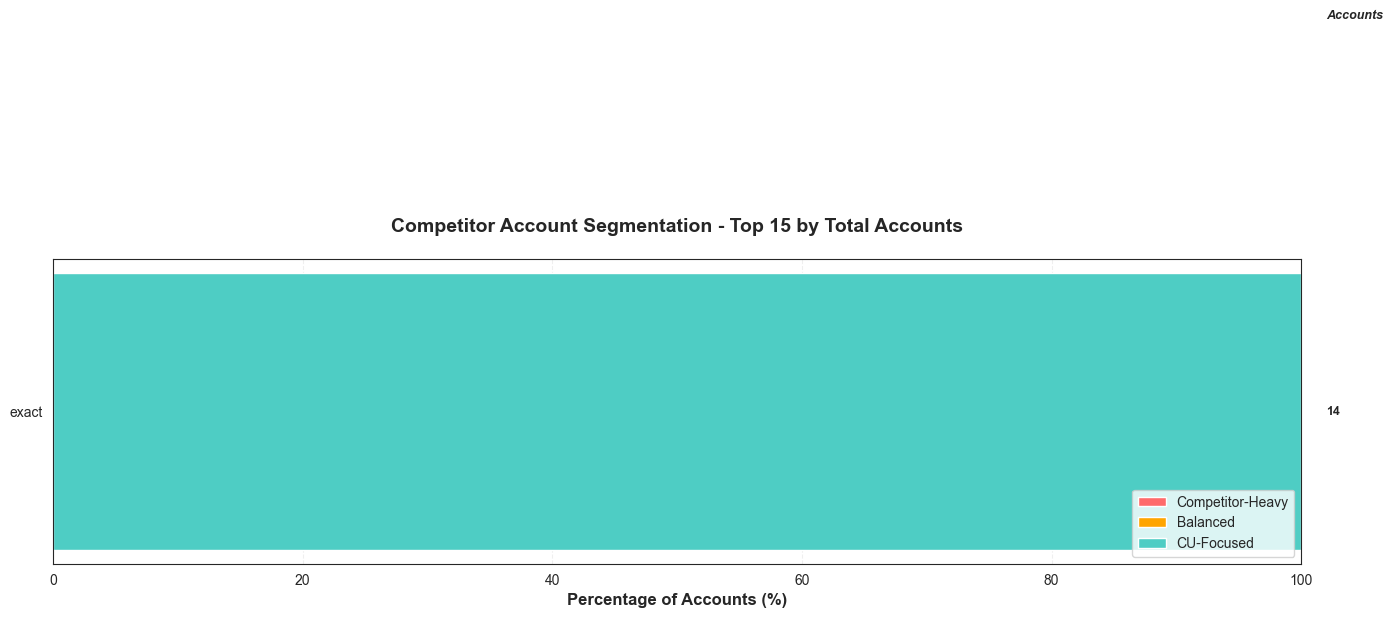


📊 Segmentation Summary:
Total Competitors Analyzed: 1
Showing Top 15 by Account Count

Segment Definitions:
  🔴 Competitor-Heavy: >50% of spend goes to competitor
  🟠 Balanced: 25-50% of spend goes to competitor
  🔵 CU-Focused: <25% of spend goes to competitor


In [132]:
# ===========================================================================
# VISUALIZATION: COMPETITOR SEGMENTATION SUMMARY
# ===========================================================================
"""
## Competitor Analysis - Segmentation Overview (All Competitors)
"""


# Aggregate segmentation data across all competitors
segment_summary = []

for competitor, comparison in competitor_spend_analysis.items():
    segment_counts = comparison['Segment'].value_counts()
    total = len(comparison)
    
    segment_summary.append({
        'competitor': competitor,
        'total_accounts': total,
        'competitor_heavy': segment_counts.get('Competitor-Heavy', 0),
        'balanced': segment_counts.get('Balanced', 0),
        'cu_focused': segment_counts.get('CU-Focused', 0)
    })

summary_df = pd.DataFrame(segment_summary)

# Calculate percentages
summary_df['heavy_pct'] = (summary_df['competitor_heavy'] / summary_df['total_accounts'] * 100)
summary_df['balanced_pct'] = (summary_df['balanced'] / summary_df['total_accounts'] * 100)
summary_df['cu_focused_pct'] = (summary_df['cu_focused'] / summary_df['total_accounts'] * 100)

# Sort by total accounts (show biggest threats first)
summary_df = summary_df.sort_values('total_accounts', ascending=False).head(15)

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(14, 10))

y_pos = range(len(summary_df))
competitors = summary_df['competitor'].values

# Create stacked bars
p1 = ax.barh(y_pos, summary_df['heavy_pct'], 
             color='#FF6B6B', label='Competitor-Heavy', height=0.7)
p2 = ax.barh(y_pos, summary_df['balanced_pct'], 
             left=summary_df['heavy_pct'],
             color='#FFA500', label='Balanced', height=0.7)
p3 = ax.barh(y_pos, summary_df['cu_focused_pct'], 
             left=summary_df['heavy_pct'] + summary_df['balanced_pct'],
             color='#4ECDC4', label='CU-Focused', height=0.7)

# Customize
ax.set_yticks(y_pos)
ax.set_yticklabels(competitors)
ax.set_xlabel('Percentage of Accounts (%)', fontsize=12, fontweight='bold')
ax.set_title('Competitor Account Segmentation - Top 15 by Total Accounts', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=10)
ax.set_xlim(0, 100)

# Add grid
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Add account counts as text on the right
for i, (idx, row) in enumerate(summary_df.iterrows()):
    ax.text(102, i, f"{int(row['total_accounts']):,}", 
            va='center', fontsize=9, fontweight='bold')

# Add column header for account counts
ax.text(102, len(summary_df), 'Accounts', 
        va='center', fontsize=9, fontweight='bold', style='italic')

plt.tight_layout()
plt.show()

print("\n📊 Segmentation Summary:")
print("="*80)
print(f"Total Competitors Analyzed: {len(competitor_spend_analysis)}")
print(f"Showing Top 15 by Account Count")
print("\nSegment Definitions:")
print("  🔴 Competitor-Heavy: >50% of spend goes to competitor")
print("  🟠 Balanced: 25-50% of spend goes to competitor")
print("  🔵 CU-Focused: <25% of spend goes to competitor")
print("="*80)

#### Viz - Competiton Segmentation 

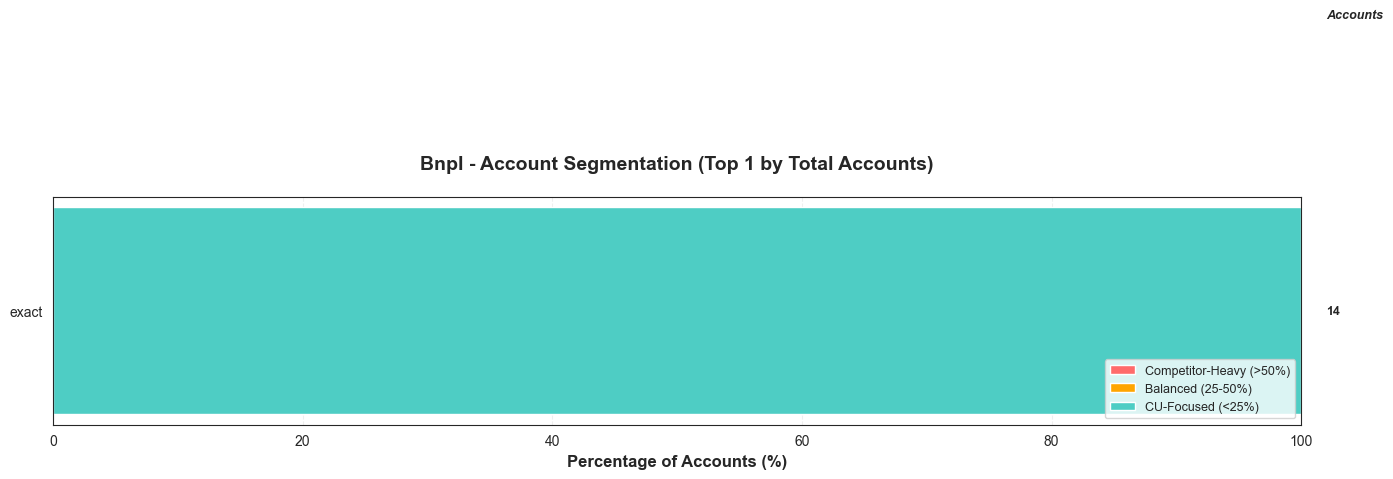


📊 Bnpl Summary:
  Total competitors: 1
  Total accounts: 14
  Avg accounts per competitor: 14

  Segmentation across category:
    🔴 Competitor-Heavy: 0 (0.0%)
    🟠 Balanced: 0 (0.0%)
    🔵 CU-Focused: 14 (100.0%)

✓ Category-specific segmentation visualizations complete


In [133]:
# ===========================================================================
# VISUALIZATION: COMPETITOR SEGMENTATION BY CATEGORY
# ===========================================================================
"""
## Competitor Analysis - Segmentation by Category (Separate Charts)
"""

import matplotlib.pyplot as plt
import pandas as pd

# Group competitors by category
category_groups = {}

for competitor, comparison in competitor_spend_analysis.items():
    # Get category from the competitor data
    category = all_competitor_data[competitor]['competitor_category'].iloc[0]
    
    if category not in category_groups:
        category_groups[category] = []
    
    segment_counts = comparison['Segment'].value_counts()
    total = len(comparison)
    
    category_groups[category].append({
        'competitor': competitor,
        'total_accounts': total,
        'competitor_heavy': segment_counts.get('Competitor-Heavy', 0),
        'balanced': segment_counts.get('Balanced', 0),
        'cu_focused': segment_counts.get('CU-Focused', 0),
        'heavy_pct': segment_counts.get('Competitor-Heavy', 0) / total * 100,
        'balanced_pct': segment_counts.get('Balanced', 0) / total * 100,
        'cu_focused_pct': segment_counts.get('CU-Focused', 0) / total * 100
    })

# Create one chart per category
for category, competitors in category_groups.items():
    # Convert to DataFrame and sort by total accounts (descending)
    cat_df = pd.DataFrame(competitors)
    cat_df = cat_df.sort_values('total_accounts', ascending=True)  # Ascending for horizontal bars
    
    # Skip if no data
    if len(cat_df) == 0:
        continue
    
    # Take top 15 if more than 15
    if len(cat_df) > 15:
        cat_df = cat_df.tail(15)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, max(8, len(cat_df) * 0.5)))
    
    y_pos = range(len(cat_df))
    competitors = cat_df['competitor'].values
    
    # Create stacked bars
    p1 = ax.barh(y_pos, cat_df['heavy_pct'], 
                 color='#FF6B6B', label='Competitor-Heavy (>50%)', height=0.7)
    p2 = ax.barh(y_pos, cat_df['balanced_pct'], 
                 left=cat_df['heavy_pct'],
                 color='#FFA500', label='Balanced (25-50%)', height=0.7)
    p3 = ax.barh(y_pos, cat_df['cu_focused_pct'], 
                 left=cat_df['heavy_pct'] + cat_df['balanced_pct'],
                 color='#4ECDC4', label='CU-Focused (<25%)', height=0.7)
    
    # Customize
    ax.set_yticks(y_pos)
    ax.set_yticklabels(competitors, fontsize=10)
    ax.set_xlabel('Percentage of Accounts (%)', fontsize=12, fontweight='bold')
    
    # Format category name for title
    category_title = category.replace('_', ' ').title()
    ax.set_title(f'{category_title} - Account Segmentation (Top {len(cat_df)} by Total Accounts)', 
                 fontsize=14, fontweight='bold', pad=20)
    
    ax.legend(loc='lower right', fontsize=9)
    ax.set_xlim(0, 100)
    
    # Add grid
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    # Add account counts as text on the right
    for i, (idx, row) in enumerate(cat_df.iterrows()):
        ax.text(102, i, f"{int(row['total_accounts']):,}", 
                va='center', fontsize=9, fontweight='bold')
    
    # Add column header for account counts
    ax.text(102, len(cat_df), 'Accounts', 
            va='center', fontsize=9, fontweight='bold', style='italic')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary for this category
    print(f"\n📊 {category_title} Summary:")
    print("="*80)
    print(f"  Total competitors: {len(cat_df)}")
    print(f"  Total accounts: {cat_df['total_accounts'].sum():,}")
    print(f"  Avg accounts per competitor: {cat_df['total_accounts'].mean():.0f}")
    
    # Calculate category-wide risk
    total_heavy = cat_df['competitor_heavy'].sum()
    total_balanced = cat_df['balanced'].sum()
    total_cu = cat_df['cu_focused'].sum()
    total_all = total_heavy + total_balanced + total_cu
    
    print(f"\n  Segmentation across category:")
    print(f"    🔴 Competitor-Heavy: {total_heavy:,} ({total_heavy/total_all*100:.1f}%)")
    print(f"    🟠 Balanced: {total_balanced:,} ({total_balanced/total_all*100:.1f}%)")
    print(f"    🔵 CU-Focused: {total_cu:,} ({total_cu/total_all*100:.1f}%)")
    print("="*80)

print("\n✓ Category-specific segmentation visualizations complete")

#### Viz - Competitor Segmentation Heatmap

In [134]:
# ===========================================================================
# VISUALIZATION: COMPETITOR SEGMENTATION HEATMAP (IMPROVED COLORS)
# ===========================================================================
"""
## Competitor Analysis - Segmentation Heatmap with Column-Specific Colors
"""

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Group competitors by category
category_groups = {}

for competitor, comparison in competitor_spend_analysis.items():
    category = all_competitor_data[competitor]['competitor_category'].iloc[0]
    
    if category not in category_groups:
        category_groups[category] = []
    
    segment_counts = comparison['Segment'].value_counts()
    total = len(comparison)
    
    category_groups[category].append({
        'competitor': competitor,
        'total_accounts': total,
        'heavy_pct': segment_counts.get('Competitor-Heavy', 0) / total * 100,
        'balanced_pct': segment_counts.get('Balanced', 0) / total * 100,
        'cu_focused_pct': segment_counts.get('CU-Focused', 0) / total * 100
    })

# Create improved heatmap per category
for category, competitors in category_groups.items():
    cat_df = pd.DataFrame(competitors)
    cat_df = cat_df.sort_values('total_accounts', ascending=False)
    
    if len(cat_df) < 3:
        continue
    
    if len(cat_df) > 20:
        cat_df = cat_df.head(20)
    
    competitor_names = cat_df['competitor'].values
    data_matrix = cat_df[['heavy_pct', 'balanced_pct', 'cu_focused_pct']].values
    
    # Create figure with custom coloring - WIDER
    fig, ax = plt.subplots(figsize=(16, max(10, len(cat_df) * 0.5)))
    
    # Function to get color based on column and value
    def get_cell_color(col_idx, value):
        """
        Column 0 (Competitor-Heavy): Red scale - High is BAD
        Column 1 (Balanced): Orange scale - Neutral
        Column 2 (CU-Focused): Green scale - High is GOOD
        """
        if col_idx == 0:  # Competitor-Heavy (low is good)
            if value >= 20:
                return '#8B0000'  # Dark red - Very bad
            elif value >= 10:
                return '#CD5C5C'  # Light red - Bad
            elif value >= 5:
                return '#FFB6C1'  # Pink - Slightly bad
            else:
                return '#F0F0F0'  # Light gray - Good
        
        elif col_idx == 1:  # Balanced (neutral)
            if value >= 30:
                return '#FF8C00'  # Dark orange
            elif value >= 20:
                return '#FFA500'  # Orange
            elif value >= 10:
                return '#FFD700'  # Light orange/yellow
            else:
                return '#F0F0F0'  # Light gray
        
        else:  # CU-Focused (high is good)
            if value >= 90:
                return '#006400'  # Dark green - Excellent
            elif value >= 80:
                return '#228B22'  # Green - Very good
            elif value >= 70:
                return '#90EE90'  # Light green - Good
            else:
                return '#F0F0F0'  # Light gray - Not good
    
    # Create colored grid manually - WIDER CELLS
    for i in range(len(competitor_names)):
        for j in range(3):
            color = get_cell_color(j, data_matrix[i, j])
            rect = mpatches.Rectangle((j*2-0.9, i-0.45), 1.8, 0.9, 
                                      facecolor=color, edgecolor='white', linewidth=3)
            ax.add_patch(rect)
            
            # Determine text color for readability
            if color in ['#8B0000', '#006400', '#228B22']:
                text_color = 'white'
            else:
                text_color = 'black'
            
            # Add percentage text - LARGER & BOLDER
            ax.text(j*2, i, f'{data_matrix[i, j]:.0f}%',
                   ha="center", va="center", color=text_color, 
                   fontweight='bold', fontsize=18)
    
    # Set limits and ticks - ADJUSTED FOR WIDER CELLS
    ax.set_xlim(-1, 5)
    ax.set_ylim(-0.5, len(competitor_names)-0.5)
    
    ax.set_xticks([0, 2, 4])
    ax.set_yticks(np.arange(len(competitor_names)))
    ax.set_xticklabels(['🔴 Competitor-Heavy\n(>50%)', 
                        '🟠 Balanced\n(25-50%)', 
                        '🟢 CU-Focused\n(<25%)'], fontsize=14, fontweight='bold')
    ax.set_yticklabels(competitor_names, fontsize=13, fontweight='bold')
    
    # Format category name
    category_title = category.replace('_', ' ').title()
    ax.set_title(f'{category_title} - Account Segmentation (Top {len(cat_df)} by Accounts)', 
                 fontsize=17, fontweight='bold', pad=20)
    
    # Add account counts on the right - MUCH LARGER
    for i, (idx, row) in enumerate(cat_df.iterrows()):
        ax.text(5.5, i, f"n={int(row['total_accounts']):,}", 
                va='center', fontsize=14, fontweight='bold')
    
    ax.invert_yaxis()  # Top to bottom
    
    plt.tight_layout()
    plt.show()
    
    # Print legend
    print(f"\n{category_title} - Color Guide:")
    print("="*80)
    print("🔴 Competitor-Heavy Column (% at high risk):")
    print("   • Dark Red (≥20%) = 🚨 Very Bad - Many accounts at risk")
    print("   • Light Red (10-19%) = ⚠️ Bad - Significant risk")
    print("   • Pink (5-9%) = 🟡 Slight concern")
    print("   • Gray (<5%) = ✅ Good - Few at risk")
    print("\n🟢 CU-Focused Column (% loyal to you):")
    print("   • Dark Green (≥90%) = 🎯 Excellent - Very loyal")
    print("   • Green (80-89%) = ✅ Very Good - Strong loyalty")
    print("   • Light Green (70-79%) = 👍 Good - Decent loyalty")
    print("   • Gray (<70%) = ⚠️ Concerning - Low loyalty")
    print("="*80 + "\n")

print("\n✓ Improved heatmaps complete - Colors now match risk levels!")


✓ Improved heatmaps complete - Colors now match risk levels!


#### Lists - Account Level Summaries

In [135]:
# ===========================================================================
# CELL 3: ACCOUNT-LEVEL SUMMARY
# ===========================================================================
"""
## Competitor Analysis - Account Level Detail
"""

all_account_summaries = {}

for competitor, competitor_trans in all_competitor_data.items():
    print(f"\n{'='*100}")
    print(f"ACCOUNT ANALYSIS: {competitor}")
    print(f"{'='*100}\n")
    
    # Create account-level summary
    account_summary = competitor_trans.groupby('primary_account_num').agg({
        'amount': ['sum', 'count', 'mean', 'min', 'max'],
        'transaction_date': ['min', 'max']
    }).round(2)
    
    account_summary.columns = [
        'Total Amount', 
        'Transaction Count', 
        'Avg Amount', 
        'Min Amount', 
        'Max Amount',
        'First Transaction',
        'Last Transaction'
    ]
    
    account_summary = account_summary.sort_values('Total Amount', ascending=False)
    
    # Add frequency metrics
    account_summary['Days Active'] = (
        account_summary['Last Transaction'] - account_summary['First Transaction']
    ).dt.days
    
    account_summary['Recency (Days)'] = (
        pd.Timestamp.now() - account_summary['Last Transaction']
    ).dt.days
    
    # Format for display
    display_summary = account_summary.head(25).copy()
    display_summary['Total Amount'] = display_summary['Total Amount'].apply(lambda x: f"${x:,.2f}")
    display_summary['Avg Amount'] = display_summary['Avg Amount'].apply(lambda x: f"${x:,.2f}")
    display_summary['Min Amount'] = display_summary['Min Amount'].apply(lambda x: f"${x:,.2f}")
    display_summary['Max Amount'] = display_summary['Max Amount'].apply(lambda x: f"${x:,.2f}")
    display_summary['First Transaction'] = display_summary['First Transaction'].dt.strftime('%Y-%m-%d')
    display_summary['Last Transaction'] = display_summary['Last Transaction'].dt.strftime('%Y-%m-%d')
    
    print(f"Top 25 Accounts by Total Spend:")
    display(display_summary)
    
    # Store for export (keep numeric for export)
    all_account_summaries[competitor] = account_summary
    
    # Segmentation table
    segmentation = pd.DataFrame({
        'Segment': [
            'High Value (>$1,000)',
            'Medium Value ($500-$1,000)',
            'Lower Value (<$500)',
            '',
            'Frequent Users (5+ transactions)',
            'Recent Activity (last 30 days)',
            'Recent Activity (last 90 days)'
        ],
        'Account Count': [
            len(account_summary[account_summary['Total Amount'] > 1000]),
            len(account_summary[(account_summary['Total Amount'] >= 500) & (account_summary['Total Amount'] <= 1000)]),
            len(account_summary[account_summary['Total Amount'] < 500]),
            '',
            len(account_summary[account_summary['Transaction Count'] >= 5]),
            len(account_summary[account_summary['Recency (Days)'] <= 30]),
            len(account_summary[account_summary['Recency (Days)'] <= 90])
        ]
    })
    
    print(f"\nAccount Segmentation:")
    display(segmentation)


ACCOUNT ANALYSIS: exact

Top 25 Accounts by Total Spend:


Total Amount  Transaction Count  \
primary_account_num                                                        
BA7DDCA0079A4489EC942B48F36FBF64BFE5522C      $681.00                  1   
CD4305B5B43943104BC5EE2656BF5AC603AF9C13      $382.00                  1   
84F98648A953E95D6469164DD2DC5D03B2B47D39      $364.10                  1   
FAF631486C71AAED7467A455A21CB17C3365FC66      $219.58                  1   
4267347F6D0B76A551C78C8E83A813E78D7098D1      $189.29                  1   
AE607049F7CBC96F9038D37D91E9A3A44B1B97E3      $167.94                  2   
7F600D353D75C8E398CC34C03D153CA017EF7188      $164.01                  1   
42896AADBDAB8CA44ED782628745C86EE5BB72F7      $111.90                  1   
867A58B13834BFA5ADF463084B23E33203BA463F      $100.00                  1   
E0266D5345543F0063E6F7A9E80294C5F4853988       $61.52                  1   
94DA3F39A99F33CD84E1C60CB2DC04144DEE66AC       $57.95                  1   
D306AC72F5D3EEC0AD162E0608CCCD8D415107B3       $33.06                  1   
EBF54F0653D278F66A2642EE61054E5B9D0EBC32       $25.00                  1   
FC6C74BE58264E327DAB318CA1CB3A4DE35B1B66       $10.00                  1   

                                         Avg Amount Min Amount Max Amount  \
primary_account_num                                                         
BA7DDCA0079A4489EC942B48F36FBF64BFE5522C    $681.00    $681.00    $681.00   
CD4305B5B43943104BC5EE2656BF5AC603AF9C13    $382.00    $382.00    $382.00   
84F98648A953E95D6469164DD2DC5D03B2B47D39    $364.10    $364.10    $364.10   
FAF631486C71AAED7467A455A21CB17C3365FC66    $219.58    $219.58    $219.58   
4267347F6D0B76A551C78C8E83A813E78D7098D1    $189.29    $189.29    $189.29   
AE607049F7CBC96F9038D37D91E9A3A44B1B97E3     $83.97     $83.97     $83.97   
7F600D353D75C8E398CC34C03D153CA017EF7188    $164.01    $164.01    $164.01   
42896AADBDAB8CA44ED782628745C86EE5BB72F7    $111.90    $111.90    $111.90   
867A58B13834BFA5ADF463084B23E33203BA463F    $100.00    $100.00    $100.00   
E0266D5345543F0063E6F7A9E80294C5F4853988     $61.52     $61.52     $61.52   
94DA3F39A99F33CD84E1C60CB2DC04144DEE66AC     $57.95     $57.95     $57.95   
D306AC72F5D3EEC0AD162E0608CCCD8D415107B3     $33.06     $33.06     $33.06   
EBF54F0653D278F66A2642EE61054E5B9D0EBC32     $25.00     $25.00     $25.00   
FC6C74BE58264E327DAB318CA1CB3A4DE35B1B66     $10.00     $10.00     $10.00   

                                         First Transaction Last Transaction  \
primary_account_num                                                           
BA7DDCA0079A4489EC942B48F36FBF64BFE5522C        2025-04-01       2025-04-01   
CD4305B5B43943104BC5EE2656BF5AC603AF9C13        2025-01-25       2025-01-25   
84F98648A953E95D6469164DD2DC5D03B2B47D39        2025-06-07       2025-06-07   
FAF631486C71AAED7467A455A21CB17C3365FC66        2025-06-20       2025-06-20   
4267347F6D0B76A551C78C8E83A813E78D7098D1        2025-04-08       2025-04-08   
AE607049F7CBC96F9038D37D91E9A3A44B1B97E3        2025-09-29       2025-10-30   
7F600D353D75C8E398CC34C03D153CA017EF7188        2025-11-25       2025-11-25   
42896AADBDAB8CA44ED782628745C86EE5BB72F7        2025-02-04       2025-02-04   
867A58B13834BFA5ADF463084B23E33203BA463F        2025-12-01       2025-12-01   
E0266D5345543F0063E6F7A9E80294C5F4853988        2025-05-18       2025-05-18   
94DA3F39A99F33CD84E1C60CB2DC04144DEE66AC        2025-05-08       2025-05-08   
D306AC72F5D3EEC0AD162E0608CCCD8D415107B3        2025-11-29       2025-11-29   
EBF54F0653D278F66A2642EE61054E5B9D0EBC32        2025-02-15       2025-02-15   
FC6C74BE58264E327DAB318CA1CB3A4DE35B1B66        2025-07-22       2025-07-22   

                                          Days Active  Recency (Days)  
primary_account_num                                                    
BA7DDCA0079A4489EC942B48F36FBF64BFE5522C            0             322  
CD4305B5B43943104BC5EE2656BF5AC603AF9C13            0             388  
84F98648A953E95D6469164DD2DC5D03B2B47D


Account Segmentation:


Segment Account Count
0              High Value (>$1,000)             0
1        Medium Value ($500-$1,000)             1
2               Lower Value (<$500)            13
3                                                
4  Frequent Users (5+ transactions)             0
5    Recent Activity (last 30 days)             0
6    Recent Activity (last 90 days)             3

#### EXPORT DETAILED RESULTS


In [136]:
# ===========================================================================
# VISUALIZATION: COMPETITOR SEGMENTATION HEATMAP (IMPROVED COLORS)
# ===========================================================================
"""
## Competitor Analysis - Segmentation Heatmap with Column-Specific Colors
"""

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Group competitors by category
category_groups = {}

for competitor, comparison in competitor_spend_analysis.items():
    category = all_competitor_data[competitor]['competitor_category'].iloc[0]
    
    if category not in category_groups:
        category_groups[category] = []
    
    segment_counts = comparison['Segment'].value_counts()
    total = len(comparison)
    
    category_groups[category].append({
        'competitor': competitor,
        'total_accounts': total,
        'heavy_pct': segment_counts.get('Competitor-Heavy', 0) / total * 100,
        'balanced_pct': segment_counts.get('Balanced', 0) / total * 100,
        'cu_focused_pct': segment_counts.get('CU-Focused', 0) / total * 100
    })

# Create improved heatmap per category
for category, competitors in category_groups.items():
    cat_df = pd.DataFrame(competitors)
    cat_df = cat_df.sort_values('total_accounts', ascending=False)
    
    if len(cat_df) < 3:
        continue
    
    if len(cat_df) > 20:
        cat_df = cat_df.head(20)
    
    competitor_names = cat_df['competitor'].values
    data_matrix = cat_df[['heavy_pct', 'balanced_pct', 'cu_focused_pct']].values
    
    # Create figure with custom coloring - WIDER
    fig, ax = plt.subplots(figsize=(16, max(10, len(cat_df) * 0.5)))
    
    # Function to get color based on column and value
    def get_cell_color(col_idx, value):
        """
        Column 0 (Competitor-Heavy): Red scale - High is BAD
        Column 1 (Balanced): Orange scale - Neutral
        Column 2 (CU-Focused): Green scale - High is GOOD
        """
        if col_idx == 0:  # Competitor-Heavy (low is good)
            if value >= 20:
                return '#8B0000'  # Dark red - Very bad
            elif value >= 10:
                return '#CD5C5C'  # Light red - Bad
            elif value >= 5:
                return '#FFB6C1'  # Pink - Slightly bad
            else:
                return '#F0F0F0'  # Light gray - Good
        
        elif col_idx == 1:  # Balanced (neutral)
            if value >= 30:
                return '#FF8C00'  # Dark orange
            elif value >= 20:
                return '#FFA500'  # Orange
            elif value >= 10:
                return '#FFD700'  # Light orange/yellow
            else:
                return '#F0F0F0'  # Light gray
        
        else:  # CU-Focused (high is good)
            if value >= 90:
                return '#006400'  # Dark green - Excellent
            elif value >= 80:
                return '#228B22'  # Green - Very good
            elif value >= 70:
                return '#90EE90'  # Light green - Good
            else:
                return '#F0F0F0'  # Light gray - Not good
    
    # Create colored grid manually - WIDER CELLS
    for i in range(len(competitor_names)):
        for j in range(3):
            color = get_cell_color(j, data_matrix[i, j])
            rect = mpatches.Rectangle((j*2-0.9, i-0.45), 1.8, 0.9, 
                                      facecolor=color, edgecolor='white', linewidth=3)
            ax.add_patch(rect)
            
            # Determine text color for readability
            if color in ['#8B0000', '#006400', '#228B22']:
                text_color = 'white'
            else:
                text_color = 'black'
            
            # Add percentage text
            ax.text(j*2, i, f'{data_matrix[i, j]:.0f}%',
                   ha="center", va="center", color=text_color, 
                   fontweight='bold', fontsize=14)
    
    # Set limits and ticks - ADJUSTED FOR WIDER CELLS
    ax.set_xlim(-1, 5)
    ax.set_ylim(-0.5, len(competitor_names)-0.5)
    
    ax.set_xticks([0, 2, 4])
    ax.set_yticks(np.arange(len(competitor_names)))
    ax.set_xticklabels(['🔴 Competitor-Heavy\n(>50%)', 
                        '🟠 Balanced\n(25-50%)', 
                        '🟢 CU-Focused\n(<25%)'], fontsize=12, fontweight='bold')
    ax.set_yticklabels(competitor_names, fontsize=11)
    
    # Format category name
    category_title = category.replace('_', ' ').title()
    ax.set_title(f'{category_title} - Account Segmentation (Top {len(cat_df)} by Accounts)', 
                 fontsize=15, fontweight='bold', pad=20)
    
    # Add account counts on the right
    for i, (idx, row) in enumerate(cat_df.iterrows()):
        ax.text(5.5, i, f"n={int(row['total_accounts']):,}", 
                va='center', fontsize=10, fontweight='bold')
    
    ax.invert_yaxis()  # Top to bottom
    
    plt.tight_layout()
    plt.show()
    
    # Print legend
    print(f"\n{category_title} - Color Guide:")
    print("="*80)
    print("🔴 Competitor-Heavy Column (% at high risk):")
    print("   • Dark Red (≥20%) = 🚨 Very Bad - Many accounts at risk")
    print("   • Light Red (10-19%) = ⚠️ Bad - Significant risk")
    print("   • Pink (5-9%) = 🟡 Slight concern")
    print("   • Gray (<5%) = ✅ Good - Few at risk")
    print("\n🟢 CU-Focused Column (% loyal to you):")
    print("   • Dark Green (≥90%) = 🎯 Excellent - Very loyal")
    print("   • Green (80-89%) = ✅ Very Good - Strong loyalty")
    print("   • Light Green (70-79%) = 👍 Good - Decent loyalty")
    print("   • Gray (<70%) = ⚠️ Concerning - Low loyalty")
    print("="*80 + "\n")

print("\n✓ Improved heatmaps complete - Colors now match risk levels!")


✓ Improved heatmaps complete - Colors now match risk levels!


In [137]:
# ===========================================================================
# CELL 4: EXPORT RESULTS
# ===========================================================================
"""
## Competitor Analysis - Export to CSV
"""

# Create output directory if needed
output_dir = BASE_PATH / "Analysis Outputs" / f"{CLIENT_ID} - {CLIENT_NAME}" / "Competitor Analysis"
output_dir.mkdir(parents=True, exist_ok=True)

export_summary = []

for competitor in all_account_summaries.keys():
    competitor_clean = competitor.replace(' ', '_').replace('/', '_')
    
    # Export 1: Account Summary
    account_summary = all_account_summaries[competitor]
    output_file_summary = output_dir / f"Competitor_{competitor_clean}_Account_Summary.csv"
    account_summary.to_csv(output_file_summary)
    export_summary.append(['Account Summary', output_file_summary.name, len(account_summary)])
    
    # Export 2: Transaction Detail
    competitor_trans = all_competitor_data[competitor]
    competitor_trans_export = competitor_trans[[
        'primary_account_num',
        'transaction_date',
        'merchant_name',
        'amount',
        'source_file'
    ]].sort_values(['primary_account_num', 'transaction_date'])
    
    output_file_detail = output_dir / f"Competitor_{competitor_clean}_Transaction_Detail.csv"
    competitor_trans_export.to_csv(output_file_detail, index=False)
    export_summary.append(['Transaction Detail', output_file_detail.name, len(competitor_trans_export)])
    
    # Export 3: Marketing List (Priority Accounts)
    marketing_list = pd.DataFrame({
        'Account_Number': account_summary.index,
        'Transaction_Count': account_summary['Transaction Count'].astype(int),
        'Total_Spend': account_summary['Total Amount'].round(2),
        'Avg_Transaction': account_summary['Avg Amount'].round(2),
        'Last_Transaction_Date': account_summary['Last Transaction'].dt.strftime('%Y-%m-%d'),
        'Recency_Days': account_summary['Recency (Days)'].astype(int),
        'First_Transaction_Date': account_summary['First Transaction'].dt.strftime('%Y-%m-%d'),
        'Days_Active': account_summary['Days Active'].astype(int)
    })
    
    output_file_list = output_dir / f"Competitor_{competitor_clean}_Marketing_List.csv"
    marketing_list.to_csv(output_file_list, index=False)
    export_summary.append(['Marketing List', output_file_list.name, len(marketing_list)])

# Display export summary
export_df = pd.DataFrame(export_summary, columns=['File Type', 'Filename', 'Row Count'])
print(f"\n✓ All exports complete!")
print(f"Files saved to: {output_dir}\n")
display(export_df)


✓ All exports complete!
Files saved to: C:\Users\james.gilmore\OneDrive - Computer Services, Inc\Desktop\ARS\ARS Analysis\Analysis Outputs\1453 - Connex\Competitor Analysis



File Type                                 Filename  Row Count
0     Account Summary     Competitor_exact_Account_Summary.csv         14
1  Transaction Detail  Competitor_exact_Transaction_Detail.csv         15
2      Marketing List      Competitor_exact_Marketing_List.csv         14

#### Viz: Top Accounts 

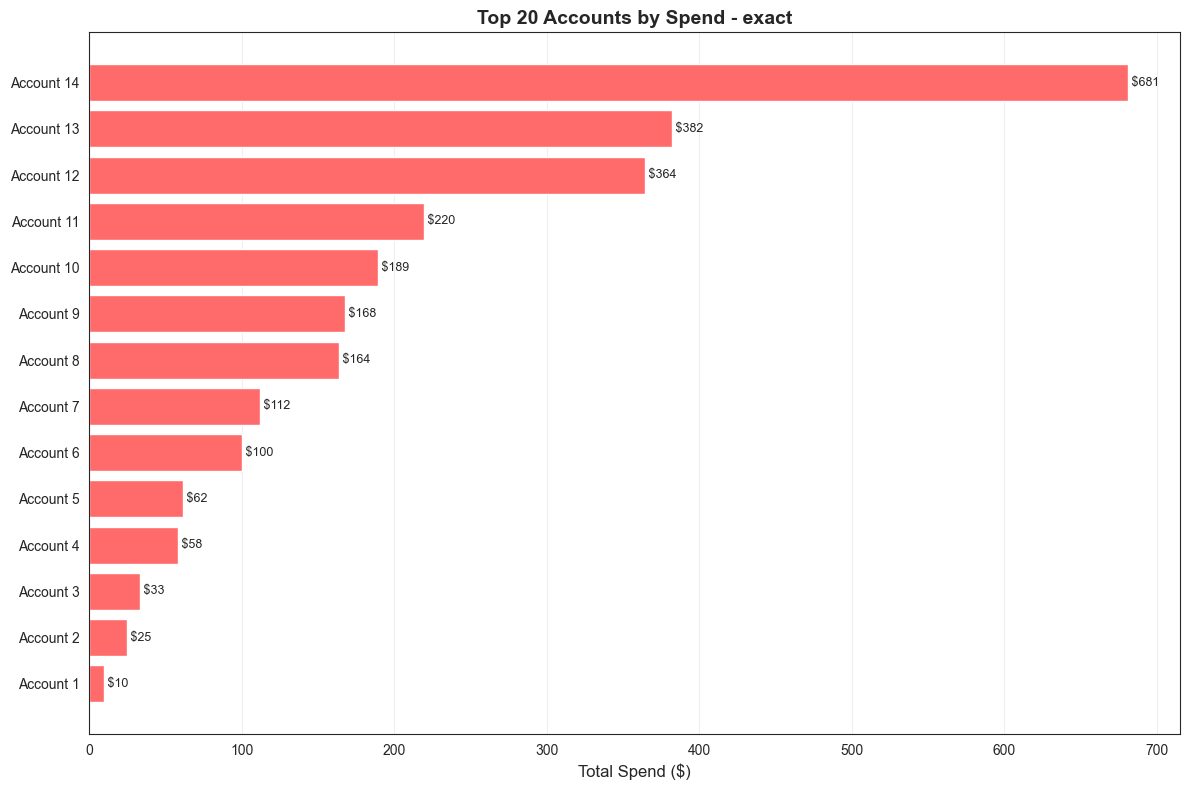

In [138]:
# ===========================================================================
# CELL 5: VISUALIZATION - Top Accounts
# ===========================================================================
"""
## Competitor Analysis - Top 20 Accounts Chart
"""

for competitor, account_summary in all_account_summaries.items():
    fig, ax = plt.subplots(figsize=(12, 8))
    
    top_20 = account_summary.head(20).sort_values('Total Amount')
    
    bars = ax.barh(range(len(top_20)), top_20['Total Amount'], color='#FF6B6B')
    ax.set_yticks(range(len(top_20)))
    ax.set_yticklabels([f"Account {i+1}" for i in range(len(top_20))])
    ax.set_xlabel('Total Spend ($)', fontsize=12)
    ax.set_title(f'Top 20 Accounts by Spend - {competitor}', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, top_20['Total Amount'])):
        ax.text(val, bar.get_y() + bar.get_height()/2, 
                f' ${val:,.0f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

#### VIz: Transaction Count Distribution

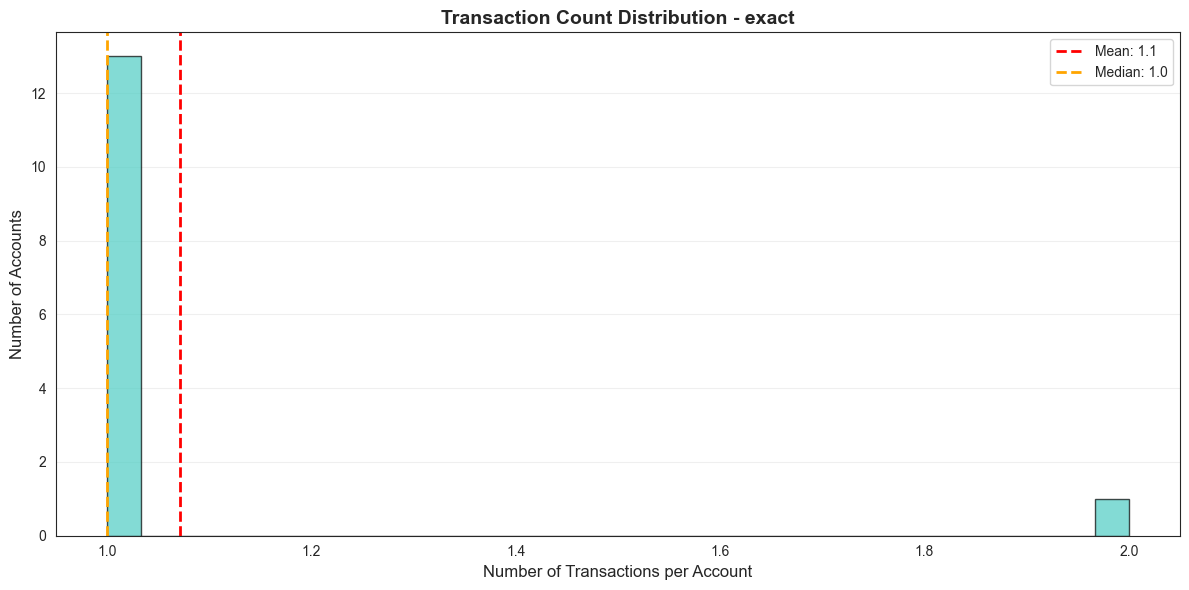

In [139]:
# ===========================================================================
# CELL 6: VISUALIZATION - Transaction Count Distribution
# ===========================================================================
"""
## Competitor Analysis - Transaction Count Distribution
"""

for competitor, account_summary in all_account_summaries.items():
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.hist(account_summary['Transaction Count'], bins=30, color='#4ECDC4', edgecolor='black', alpha=0.7)
    ax.set_xlabel('Number of Transactions per Account', fontsize=12)
    ax.set_ylabel('Number of Accounts', fontsize=12)
    ax.set_title(f'Transaction Count Distribution - {competitor}', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add summary stats
    mean_trans = account_summary['Transaction Count'].mean()
    median_trans = account_summary['Transaction Count'].median()
    ax.axvline(mean_trans, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_trans:.1f}')
    ax.axvline(median_trans, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_trans:.1f}')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

#### Viz: Recency Analysis

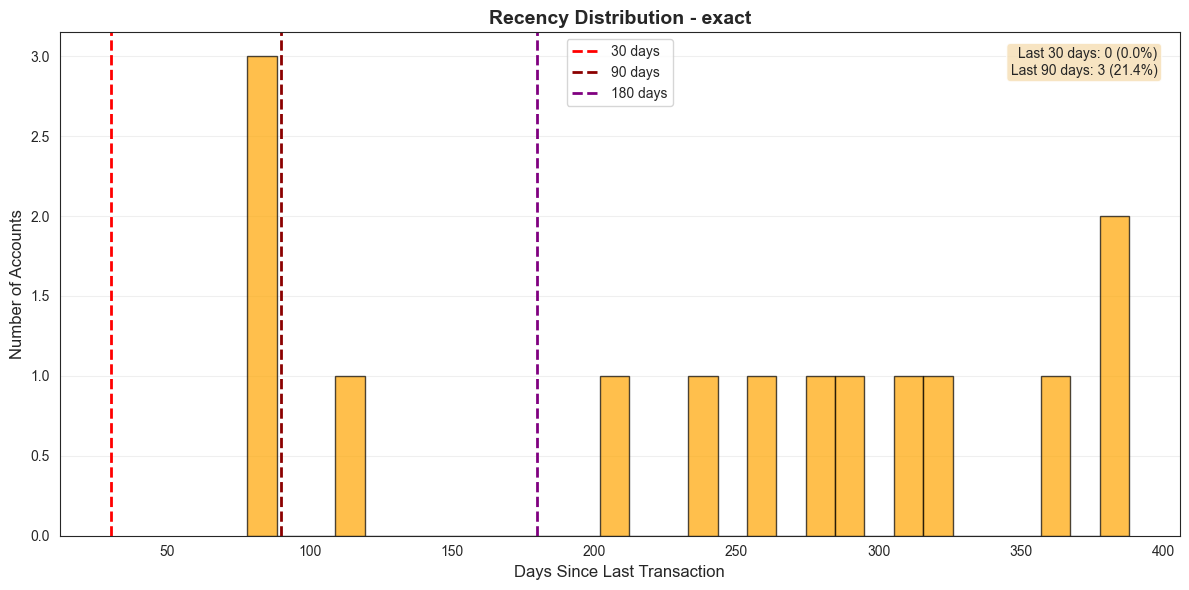

In [140]:
# ===========================================================================
# CELL 7: VISUALIZATION - Recency Analysis
# ===========================================================================
"""
## Competitor Analysis - Recency Distribution
"""

for competitor, account_summary in all_account_summaries.items():
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.hist(account_summary['Recency (Days)'], bins=30, color='#FFA500', edgecolor='black', alpha=0.7)
    ax.set_xlabel('Days Since Last Transaction', fontsize=12)
    ax.set_ylabel('Number of Accounts', fontsize=12)
    ax.set_title(f'Recency Distribution - {competitor}', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add reference lines
    ax.axvline(30, color='red', linestyle='--', linewidth=2, label='30 days')
    ax.axvline(90, color='darkred', linestyle='--', linewidth=2, label='90 days')
    ax.axvline(180, color='purple', linestyle='--', linewidth=2, label='180 days')
    ax.legend()
    
    # Add stats annotation
    recent_30 = len(account_summary[account_summary['Recency (Days)'] <= 30])
    recent_90 = len(account_summary[account_summary['Recency (Days)'] <= 90])
    total = len(account_summary)
    
    stats_text = f'Last 30 days: {recent_30:,} ({recent_30/total*100:.1f}%)\nLast 90 days: {recent_90:,} ({recent_90/total*100:.1f}%)'
    ax.text(0.98, 0.97, stats_text, transform=ax.transAxes, 
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

#### VIz: Spend vs Frequency

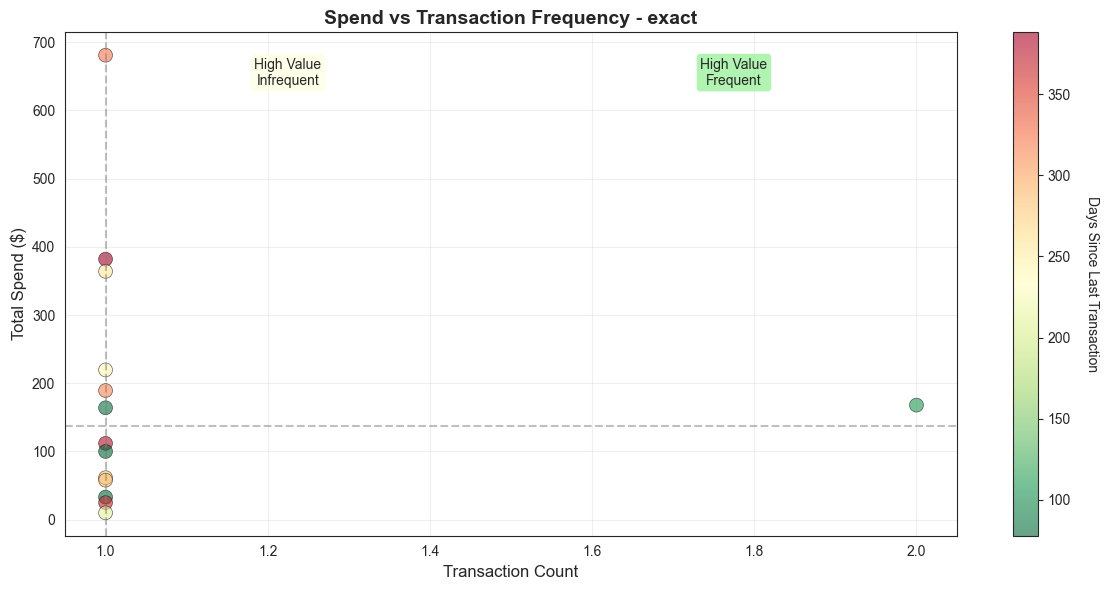

In [141]:
# ===========================================================================
# CELL 8: VISUALIZATION - Spend vs Frequency
# ===========================================================================
"""
## Competitor Analysis - Spend vs Transaction Frequency
"""

for competitor, account_summary in all_account_summaries.items():
    fig, ax = plt.subplots(figsize=(12, 6))
    
    scatter = ax.scatter(account_summary['Transaction Count'], 
                        account_summary['Total Amount'], 
                        alpha=0.6, 
                        c=account_summary['Recency (Days)'],
                        cmap='RdYlGn_r',
                        s=100,
                        edgecolors='black',
                        linewidth=0.5)
    
    ax.set_xlabel('Transaction Count', fontsize=12)
    ax.set_ylabel('Total Spend ($)', fontsize=12)
    ax.set_title(f'Spend vs Transaction Frequency - {competitor}', fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Days Since Last Transaction', rotation=270, labelpad=20)
    
    # Identify high-value quadrants
    median_count = account_summary['Transaction Count'].median()
    median_spend = account_summary['Total Amount'].median()
    
    ax.axvline(median_count, color='gray', linestyle='--', alpha=0.5)
    ax.axhline(median_spend, color='gray', linestyle='--', alpha=0.5)
    
    # Add quadrant labels
    ax.text(0.75, 0.95, 'High Value\nFrequent', transform=ax.transAxes, 
            ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
    ax.text(0.25, 0.95, 'High Value\nInfrequent', transform=ax.transAxes, 
            ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
    
    plt.tight_layout()
    plt.show()


#### Total Spend vs Competitor Spend

In [142]:
# ===========================================================================
# CELL 9: TOTAL SPEND vs COMPETITOR SPEND ANALYSIS
# ===========================================================================
"""
## Competitor Analysis - Total Spend vs Competitor Spend
"""

competitor_spend_analysis = {}

for competitor, competitor_trans in all_competitor_data.items():
    print(f"\n{'='*100}")
    print(f"SPEND ANALYSIS: {competitor}")
    print(f"{'='*100}\n")
    
    # Get list of accounts with competitor transactions
    competitor_accounts = competitor_trans['primary_account_num'].unique()
    
    # Get ALL transactions for these accounts
    all_spend_for_accounts = combined_df[
        combined_df['primary_account_num'].isin(competitor_accounts)
    ].copy()
    
    # Calculate total spend by account
    total_spend_summary = all_spend_for_accounts.groupby('primary_account_num').agg({
        'amount': ['sum', 'count'],
        'transaction_date': ['min', 'max']
    }).round(2)
    
    total_spend_summary.columns = ['total_spend', 'total_transactions', 'first_date', 'last_date']
    
    # Get competitor spend by account (from our earlier analysis)
    account_summary = all_account_summaries[competitor]
    
    # Merge to compare
    comparison = pd.DataFrame({
        'Total_Spend': total_spend_summary['total_spend'],
        'Total_Transactions': total_spend_summary['total_transactions'],
        'Competitor_Spend': account_summary['Total Amount'],
        'Competitor_Transactions': account_summary['Transaction Count']
    })
    
    # Calculate other (non-competitor) spend
    comparison['Other_Spend'] = comparison['Total_Spend'] - comparison['Competitor_Spend']
    comparison['Other_Transactions'] = comparison['Total_Transactions'] - comparison['Competitor_Transactions']
    
    # Calculate percentages
    comparison['Competitor_Pct'] = (comparison['Competitor_Spend'] / comparison['Total_Spend'] * 100).round(1)
    comparison['Other_Pct'] = (comparison['Other_Spend'] / comparison['Total_Spend'] * 100).round(1)
    
    # Sort by total spend
    comparison = comparison.sort_values('Total_Spend', ascending=False)
    
    # Create segments
    comparison['Segment'] = 'Mixed'
    comparison.loc[comparison['Competitor_Pct'] >= 80, 'Segment'] = 'Competitor-Heavy (80%+)'
    comparison.loc[comparison['Competitor_Pct'] < 20, 'Segment'] = 'Minimal Competitor (<20%)'
    comparison.loc[(comparison['Competitor_Pct'] >= 20) & (comparison['Competitor_Pct'] < 80), 'Segment'] = 'Mixed (20-80%)'
    
    # Display top 25
    display_comparison = comparison.head(25).copy()
    display_comparison['Total_Spend'] = display_comparison['Total_Spend'].apply(lambda x: f"${x:,.2f}")
    display_comparison['Competitor_Spend'] = display_comparison['Competitor_Spend'].apply(lambda x: f"${x:,.2f}")
    display_comparison['Other_Spend'] = display_comparison['Other_Spend'].apply(lambda x: f"${x:,.2f}")
    display_comparison['Competitor_Pct'] = display_comparison['Competitor_Pct'].apply(lambda x: f"{x:.1f}%")
    display_comparison['Other_Pct'] = display_comparison['Other_Pct'].apply(lambda x: f"{x:.1f}%")
    
    print("Top 25 Accounts - Total vs Competitor Spend:")
    display(display_comparison[['Total_Spend', 'Total_Transactions', 'Competitor_Spend', 
                                'Competitor_Transactions', 'Other_Spend', 'Other_Transactions', 
                                'Competitor_Pct', 'Segment']])
    
    # Segment summary
    segment_summary = comparison.groupby('Segment').agg({
        'Total_Spend': ['count', 'sum', 'mean'],
        'Competitor_Spend': ['sum', 'mean'],
        'Other_Spend': ['sum', 'mean']
    }).round(2)
    
    segment_summary.columns = ['Account_Count', 'Total_Spend_Sum', 'Total_Spend_Avg',
                               'Competitor_Spend_Sum', 'Competitor_Spend_Avg',
                               'Other_Spend_Sum', 'Other_Spend_Avg']
    
    segment_summary = segment_summary.reset_index()
    
    # Format for display
    display_segments = segment_summary.copy()
    for col in ['Total_Spend_Sum', 'Total_Spend_Avg', 'Competitor_Spend_Sum', 
                'Competitor_Spend_Avg', 'Other_Spend_Sum', 'Other_Spend_Avg']:
        display_segments[col] = display_segments[col].apply(lambda x: f"${x:,.2f}")
    
    print(f"\nSegment Summary:")
    display(display_segments)
    
    # Key insights
    competitor_heavy = len(comparison[comparison['Competitor_Pct'] >= 80])
    minimal_competitor = len(comparison[comparison['Competitor_Pct'] < 20])
    total_accounts = len(comparison)
    
    insights = pd.DataFrame({
        'Insight': [
            'Total Accounts Analyzed',
            'Competitor-Heavy (80%+ at competitor)',
            'Minimal Competitor (<20% at competitor)',
            'Mixed Spending (20-80%)',
            '',
            'AT RISK: High competitor spend',
            'OPPORTUNITY: Low competitor spend'
        ],
        'Value': [
            f"{total_accounts:,}",
            f"{competitor_heavy:,} ({competitor_heavy/total_accounts*100:.1f}%)",
            f"{minimal_competitor:,} ({minimal_competitor/total_accounts*100:.1f}%)",
            f"{len(comparison[(comparison['Competitor_Pct'] >= 20) & (comparison['Competitor_Pct'] < 80)]):,}",
            '',
            f"{competitor_heavy:,} accounts to retain",
            f"{minimal_competitor:,} accounts to grow"
        ]
    })
    
    print(f"\nKey Insights:")
    display(insights)
    
    # Store for export and visualization
    competitor_spend_analysis[competitor] = comparison



SPEND ANALYSIS: exact

Top 25 Accounts - Total vs Competitor Spend:


Total_Spend  Total_Transactions  \
primary_account_num                                                        
AE607049F7CBC96F9038D37D91E9A3A44B1B97E3  $73,384.24                1579   
4267347F6D0B76A551C78C8E83A813E78D7098D1  $66,678.36                1470   
94DA3F39A99F33CD84E1C60CB2DC04144DEE66AC  $44,824.91                 735   
EBF54F0653D278F66A2642EE61054E5B9D0EBC32  $43,020.87                 610   
BA7DDCA0079A4489EC942B48F36FBF64BFE5522C  $35,329.44                 594   
7F600D353D75C8E398CC34C03D153CA017EF7188  $27,642.90                1312   
D306AC72F5D3EEC0AD162E0608CCCD8D415107B3  $20,941.21                 585   
FC6C74BE58264E327DAB318CA1CB3A4DE35B1B66  $19,259.00                 489   
42896AADBDAB8CA44ED782628745C86EE5BB72F7  $17,830.05                 289   
CD4305B5B43943104BC5EE2656BF5AC603AF9C13   $8,378.78                 210   
E0266D5345543F0063E6F7A9E80294C5F4853988   $7,304.05                 245   
FAF631486C71AAED7467A455A21CB17C3365FC66   $5,726.94                 128   
84F98648A953E95D6469164DD2DC5D03B2B47D39   $4,946.36                  24   
867A58B13834BFA5ADF463084B23E33203BA463F   $4,147.01                  50   

                                         Competitor_Spend  \
primary_account_num                                         
AE607049F7CBC96F9038D37D91E9A3A44B1B97E3          $167.94   
4267347F6D0B76A551C78C8E83A813E78D7098D1          $189.29   
94DA3F39A99F33CD84E1C60CB2DC04144DEE66AC           $57.95   
EBF54F0653D278F66A2642EE61054E5B9D0EBC32           $25.00   
BA7DDCA0079A4489EC942B48F36FBF64BFE5522C          $681.00   
7F600D353D75C8E398CC34C03D153CA017EF7188          $164.01   
D306AC72F5D3EEC0AD162E0608CCCD8D415107B3           $33.06   
FC6C74BE58264E327DAB318CA1CB3A4DE35B1B66           $10.00   
42896AADBDAB8CA44ED782628745C86EE5BB72F7          $111.90   
CD4305B5B43943104BC5EE2656BF5AC603AF9C13          $382.00   
E0266D5345543F0063E6F7A9E80294C5F4853988           $61.52   
FAF631486C71AAED7467A455A21CB17C3365FC66          $219.58   
84F98648A953E95D6469164DD2DC5D03B2B47D39          $364.10   
867A58B13834BFA5ADF463084B23E33203BA463F          $100.00   

                                          Competitor_Transactions Other_Spend  \
primary_account_num                                                             
AE607049F7CBC96F9038D37D91E9A3A44B1B97E3                        2  $73,216.30   
4267347F6D0B76A551C78C8E83A813E78D7098D1                        1  $66,489.07   
94DA3F39A99F33CD84E1C60CB2DC04144DEE66AC                        1  $44,766.96   
EBF54F0653D278F66A2642EE61054E5B9D0EBC32                        1  $42,995.87   
BA7DDCA0079A4489EC942B48F36FBF64BFE5522C                        1  $34,648.44   
7F600D353D75C8E398CC34C03D153CA017EF7188                        1  $27,478.89   
D306AC72F5D3EEC0AD162E0608CCCD8D415107B3                        1  $20,908.15   
FC6C74BE58264E327DAB318CA1CB3A4DE35B1B66                        1  $19,249.00   
42896AADBDAB8CA44ED782628745C86EE5BB72F7                        1  $17,718.15   
CD4305B5B43943104BC5EE2656BF5AC603AF9C13                        1   $7,996.78   
E0266D5345543F0063E6F7A9E80294C5F4853988                        1   $7,242.53   
FAF631486C71AAED7467A455A21CB17C3365FC66                        1   $5,507.36   
84F98648A953E95D6469164DD2DC5D03B2B47D39                        1   $4,582.26   
867A58B13834BFA5ADF463084B23E33203BA463F                        1   $4,047.01   

                                          Other_Transactions Competitor_Pct  \
primary_account_num                                                           
AE607049F7CBC96F9038D37D91E9A3A44B1B97E3                1577           0.2%   
4267347F6D0B76A551C78C8E83A813E78D7098D1                1469           0.3%   
94DA3F39A99F33CD84E1C60CB2DC04144DEE66AC                 734           0.1%   
EBF54F0653D278F66A2642EE61054E5B9D0EBC32                 609           0.1%   
BA7DDCA0079A4489EC942B48F36FBF64BFE5522C                 593           1.9% 


Segment Summary:


Segment  Account_Count Total_Spend_Sum Total_Spend_Avg  \
0  Minimal Competitor (<20%)             14     $379,414.12      $27,101.01   

  Competitor_Spend_Sum Competitor_Spend_Avg Other_Spend_Sum Other_Spend_Avg  
0            $2,567.35              $183.38     $376,846.77      $26,917.63


Key Insights:


Insight                 Value
0                  Total Accounts Analyzed                    14
1    Competitor-Heavy (80%+ at competitor)              0 (0.0%)
2  Minimal Competitor (<20% at competitor)           14 (100.0%)
3                  Mixed Spending (20-80%)                     0
4                                                               
5           AT RISK: High competitor spend  0 accounts to retain
6        OPPORTUNITY: Low competitor spend   14 accounts to grow

#### Viz - Competitor Spend vs All

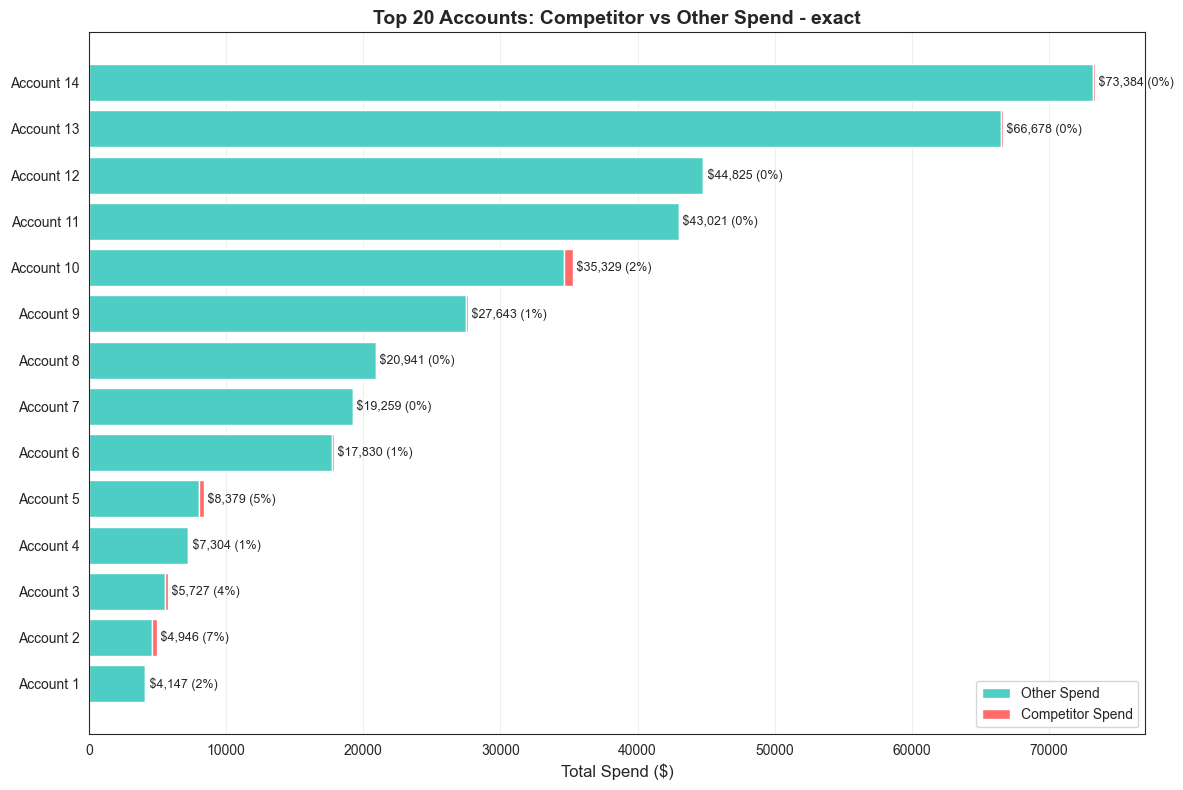

In [143]:
# ===========================================================================
# CELL 10: VISUALIZATION - Competitor vs Other Spend
# ===========================================================================
"""
## Competitor Analysis - Spend Comparison Chart
"""

for competitor, comparison in competitor_spend_analysis.items():
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Get top 20 by total spend
    top_20 = comparison.head(20).sort_values('Total_Spend')
    
    # Create stacked bar chart
    bars1 = ax.barh(range(len(top_20)), top_20['Other_Spend'], 
                    label='Other Spend', color='#4ECDC4')
    bars2 = ax.barh(range(len(top_20)), top_20['Competitor_Spend'], 
                    left=top_20['Other_Spend'], label='Competitor Spend', color='#FF6B6B')
    
    ax.set_yticks(range(len(top_20)))
    ax.set_yticklabels([f"Account {i+1}" for i in range(len(top_20))])
    ax.set_xlabel('Total Spend ($)', fontsize=12)
    ax.set_title(f'Top 20 Accounts: Competitor vs Other Spend - {competitor}', 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(axis='x', alpha=0.3)
    
    # Add total value labels
    for i, (idx, row) in enumerate(top_20.iterrows()):
        total = row['Total_Spend']
        comp_pct = row['Competitor_Pct']
        ax.text(total, i, f' ${total:,.0f} ({comp_pct:.0f}%)', 
                va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()



#### Viz - Competitor Segment Distribution

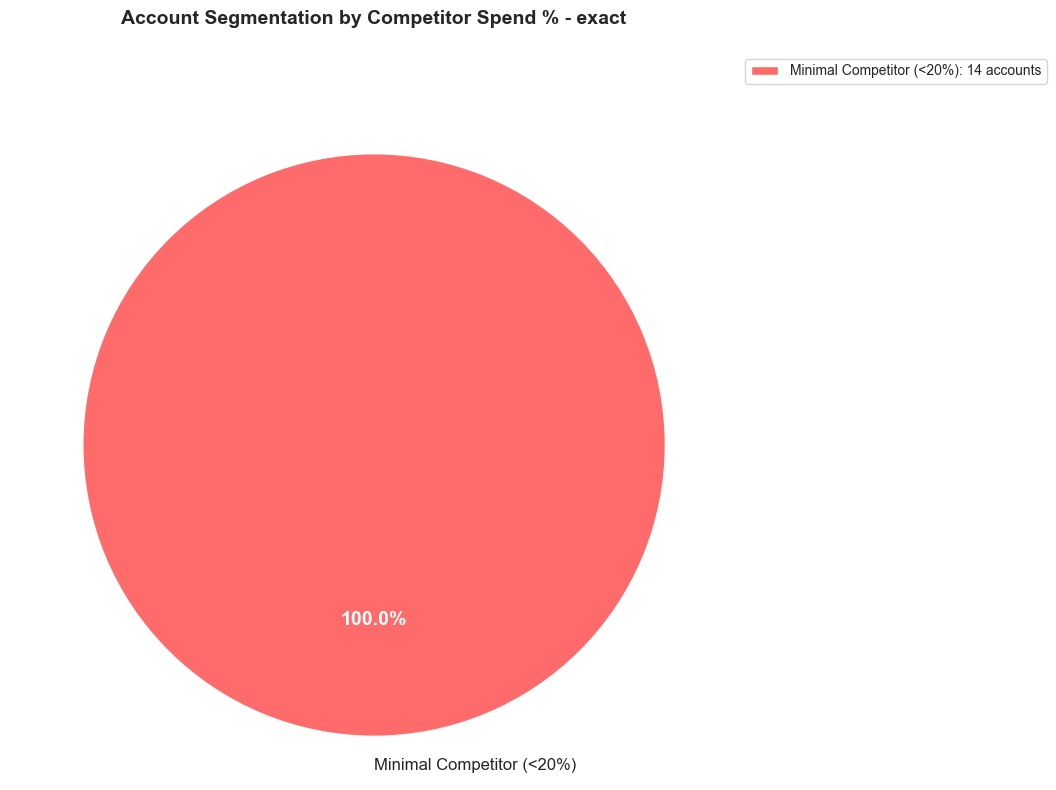

In [144]:
# ===========================================================================
# CELL 11: VISUALIZATION - Segment Distribution
# ===========================================================================
"""
## Competitor Analysis - Account Segment Pie Chart
"""

for competitor, comparison in competitor_spend_analysis.items():
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Count by segment
    segment_counts = comparison['Segment'].value_counts()
    
    colors = ['#FF6B6B', '#FFA500', '#4ECDC4']
    explode = [0.1 if i == 0 else 0 for i in range(len(segment_counts))]    
    
    wedges, texts, autotexts = ax.pie(segment_counts.values, 
                                       labels=segment_counts.index,
                                       autopct='%1.1f%%',
                                       colors=colors,
                                       explode=explode,
                                       startangle=90,
                                       textprops={'fontsize': 12})
    
    # Bold the percentage text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(14)
    
    ax.set_title(f'Account Segmentation by Competitor Spend % - {competitor}', 
                 fontsize=14, fontweight='bold', pad=20)
    
    # Add legend with counts
    legend_labels = [f"{label}: {count:,} accounts" 
                    for label, count in zip(segment_counts.index, segment_counts.values)]
    ax.legend(legend_labels, loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()



#### VIz - Competitor Heavy Spend 

In [149]:

for competitor, comparison in competitor_spend_analysis.items():
    print(f"{competitor}: {comparison.columns.tolist()}")
    break

exact: ['Total_Spend', 'Total_Transactions', 'Competitor_Spend', 'Competitor_Transactions', 'Other_Spend', 'Other_Transactions', 'Competitor_Pct', 'Other_Pct', 'Segment']


In [153]:
# ===========================================================================
# CELL 10A: VISUALIZATION - AT RISK Accounts (Competitor-Heavy)
# ===========================================================================
"""
## Competitor Analysis - AT RISK Accounts (80%+ at Competitor)
"""

for competitor, comparison in competitor_spend_analysis.items():
    # The columns in competitor_spend_analysis are:
    # 'account', 'competitor_spend', 'total_spend', 'competitor_pct', 'Segment'
    
    # Filter to EXTREME RISK accounts only (80%+ at competitor)
    at_risk = comparison[comparison['Competitor_Pct'] >= 80].copy()
    
    if len(at_risk) == 0:
        continue  # Skip competitors with no extreme risk accounts
    
    # Sort by total spend to show biggest accounts first
    at_risk = at_risk.sort_values('total_spend', ascending=False)
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Get top 20 AT RISK accounts by total spend
    top_20_risk = at_risk.head(20).sort_values('total_spend')
    
    # Calculate "your bank" spend (other spend)
    top_20_risk['your_bank_spend'] = top_20_risk['total_spend'] - top_20_risk['competitor_spend']
    
    # Create stacked bar chart
    bars1 = ax.barh(range(len(top_20_risk)), top_20_risk['your_bank_spend'], 
                    label='Your CU Spend', color='#4ECDC4')
    bars2 = ax.barh(range(len(top_20_risk)), top_20_risk['competitor_spend'], 
                    left=top_20_risk['your_bank_spend'], 
                    label=f'{competitor} Spend', color='#FF6B6B')
    
    ax.set_yticks(range(len(top_20_risk)))
    ax.set_yticklabels([f"Account {i+1}" for i in range(len(top_20_risk))], fontsize=11)
    ax.set_xlabel('Total Spend ($)', fontsize=13, fontweight='bold')
    ax.set_title(f'⚠️ Top 20 EXTREME RISK Accounts (80%+ at {competitor})', 
                 fontsize=15, fontweight='bold', color='#8B0000')
    ax.legend(loc='lower right', fontsize=11)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    # Add total value labels with competitor percentage
    for i, (idx, row) in enumerate(top_20_risk.iterrows()):
        total = row['total_spend']
        comp_pct = row['competitor_pct']
        ax.text(total + (total * 0.02), i, f'${total:,.0f} ({comp_pct:.0f}%)', 
                va='center', fontsize=10, fontweight='bold')
    
    # Add summary box
    total_at_risk = len(at_risk)
    total_at_risk_spend = at_risk['total_spend'].sum()
    total_competitor_spend = at_risk['competitor_spend'].sum()
    avg_pct = at_risk['competitor_pct'].mean()
    
    summary_text = f'🚨 EXTREME RISK ACCOUNTS (80%+ at {competitor})\n'
    summary_text += f'━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n'
    summary_text += f'Total Accounts: {total_at_risk:,}\n'
    summary_text += f'Total Spend: ${total_at_risk_spend:,.0f}\n'
    summary_text += f'Competitor Spend: ${total_competitor_spend:,.0f}\n'
    summary_text += f'Avg % at Competitor: {avg_pct:.1f}%\n'
    summary_text += f'Your CU Spend: ${total_at_risk_spend - total_competitor_spend:,.0f}'
    
    ax.text(0.02, 0.98, summary_text, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='#FFE5E5', alpha=0.95, edgecolor='#8B0000', linewidth=2),
            fontsize=11, fontweight='bold', family='monospace')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n⚠️ {competitor}: {total_at_risk:,} accounts are EXTREME RISK (80%+ spend at competitor)")
    print(f"   Showing top 20 by total spend")
    print("-"*80)

print("\n✓ AT RISK visualization complete")


✓ AT RISK visualization complete


#### Viz - Competitor Spend Scatter

✓ Built competitor_spend_analysis for 22 competitors
  Columns: ['primary_account_num', 'competitor_spend', 'total_spend', 'competitor_pct', 'your_cu_spend', 'Segment', 'competitor_name', 'competitor_category']
  • CITIBANK                         459 accounts  $     400,522
  • CHIME                            187 accounts  $      91,879
  • WELLS FARGO                       52 accounts  $      49,071
  • REVOLUT                           28 accounts  $      25,738
  • SCIENT FCU                         4 accounts  $      11,281
  • BANK OF AMERICA                   19 accounts  $      10,630
  • KEYBANK                            8 accounts  $       5,761
  • NFCU                              36 accounts  $       4,326
  • CITIZENS BANK                      7 accounts  $       3,620
  • NUTMEG CU                          2 accounts  $       3,396


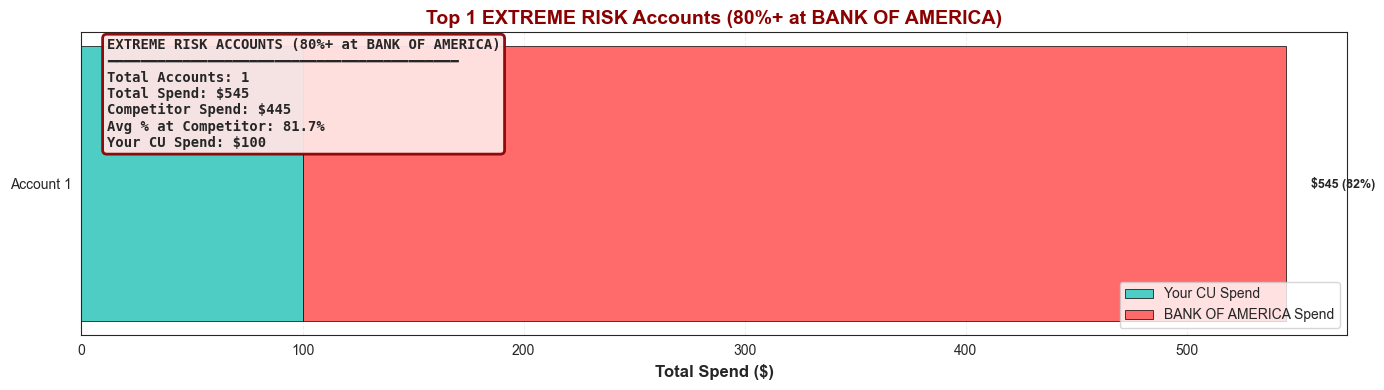


  BANK OF AMERICA: 1 extreme risk accounts (80%+ spend at competitor)
--------------------------------------------------------------------------------


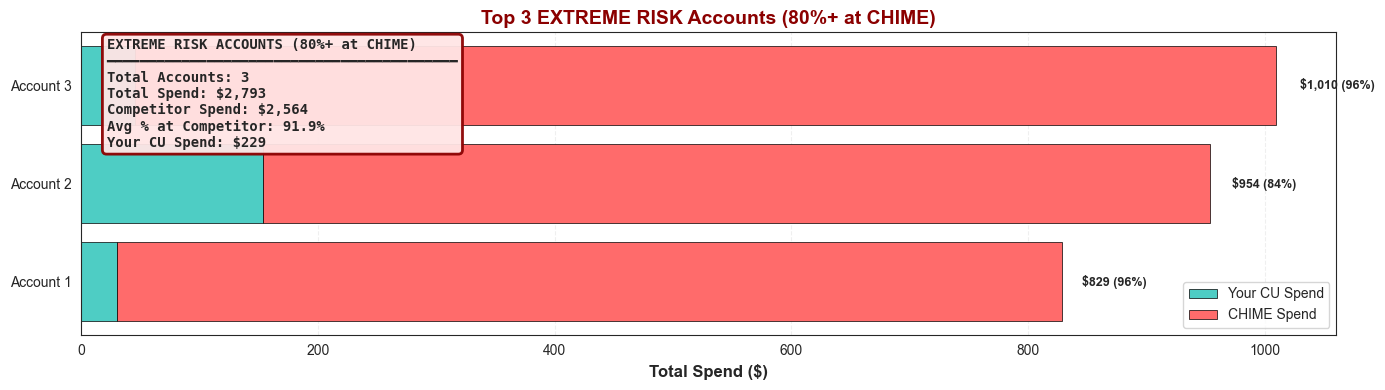


  CHIME: 3 extreme risk accounts (80%+ spend at competitor)
--------------------------------------------------------------------------------


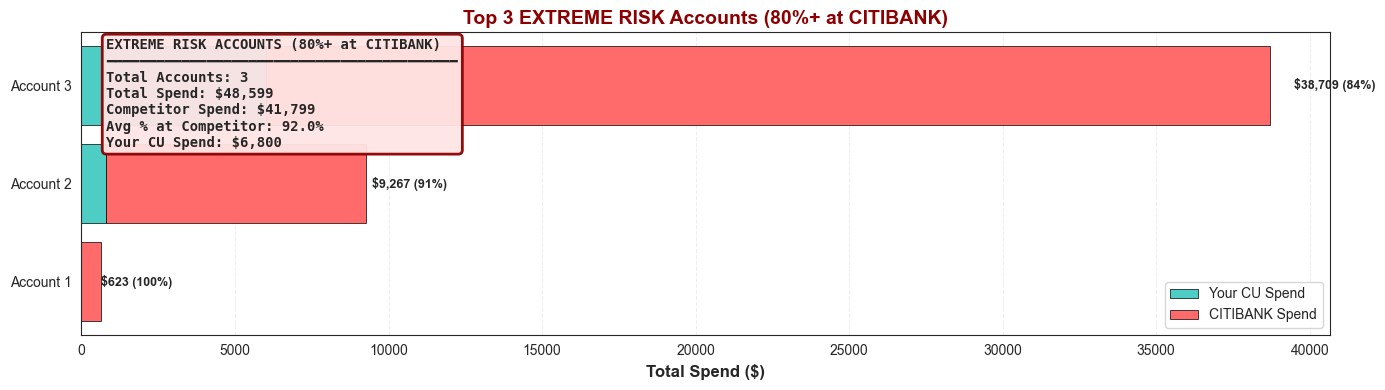


  CITIBANK: 3 extreme risk accounts (80%+ spend at competitor)
--------------------------------------------------------------------------------

✓ At-risk visualization complete


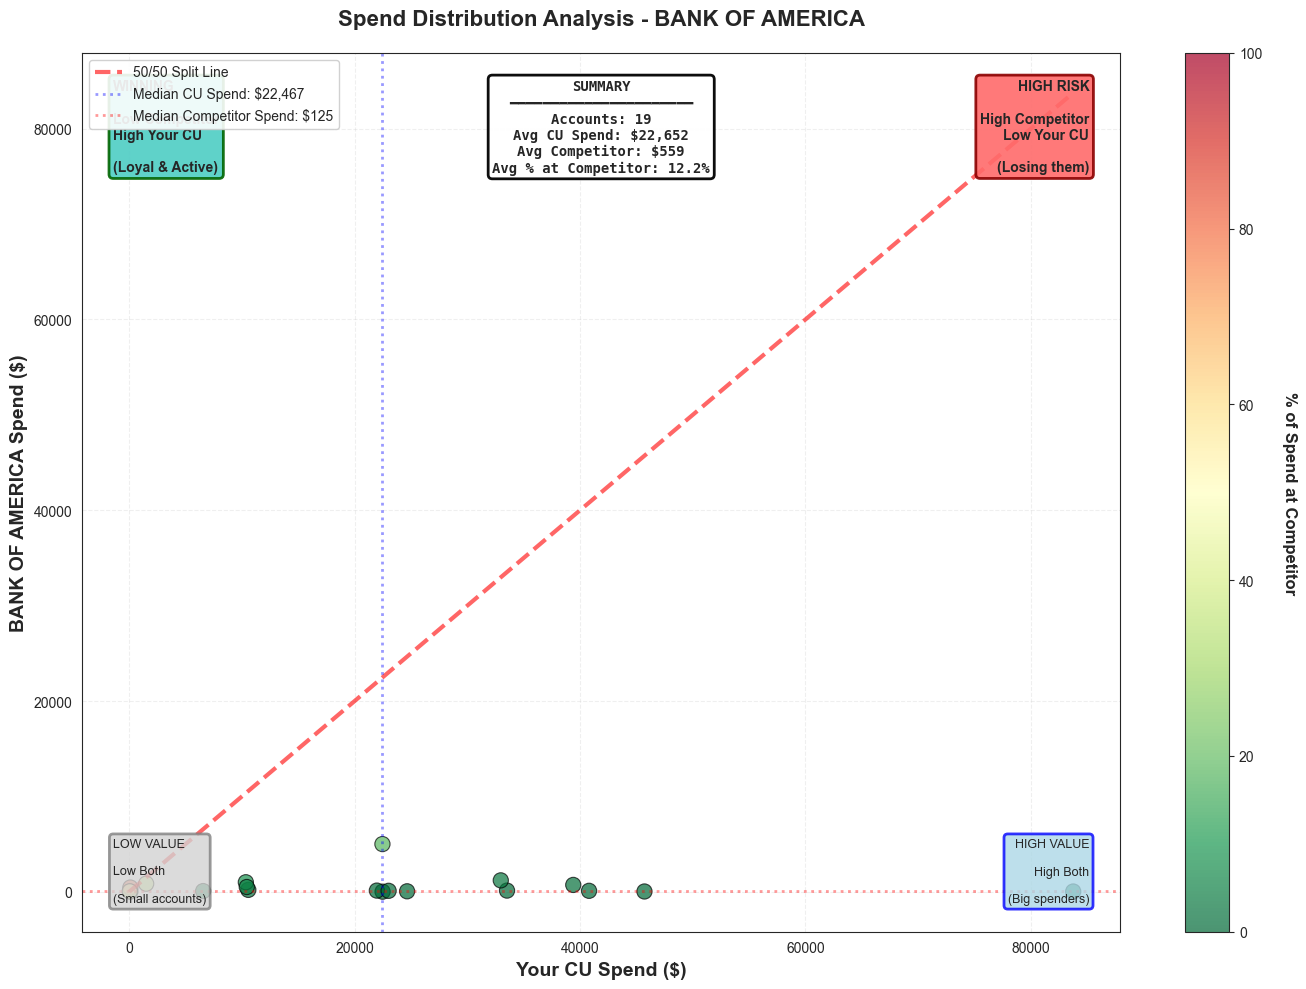


  BANK OF AMERICA Scatter Analysis:
  ────────────────────────────────────────────────────────────
    High Risk:      5 accounts ( 26.3%)
    Winning:        6 accounts ( 31.6%)
    High Value:     2 accounts ( 10.5%)
    Low Value:      3 accounts ( 15.8%)
  ────────────────────────────────────────────────────────────


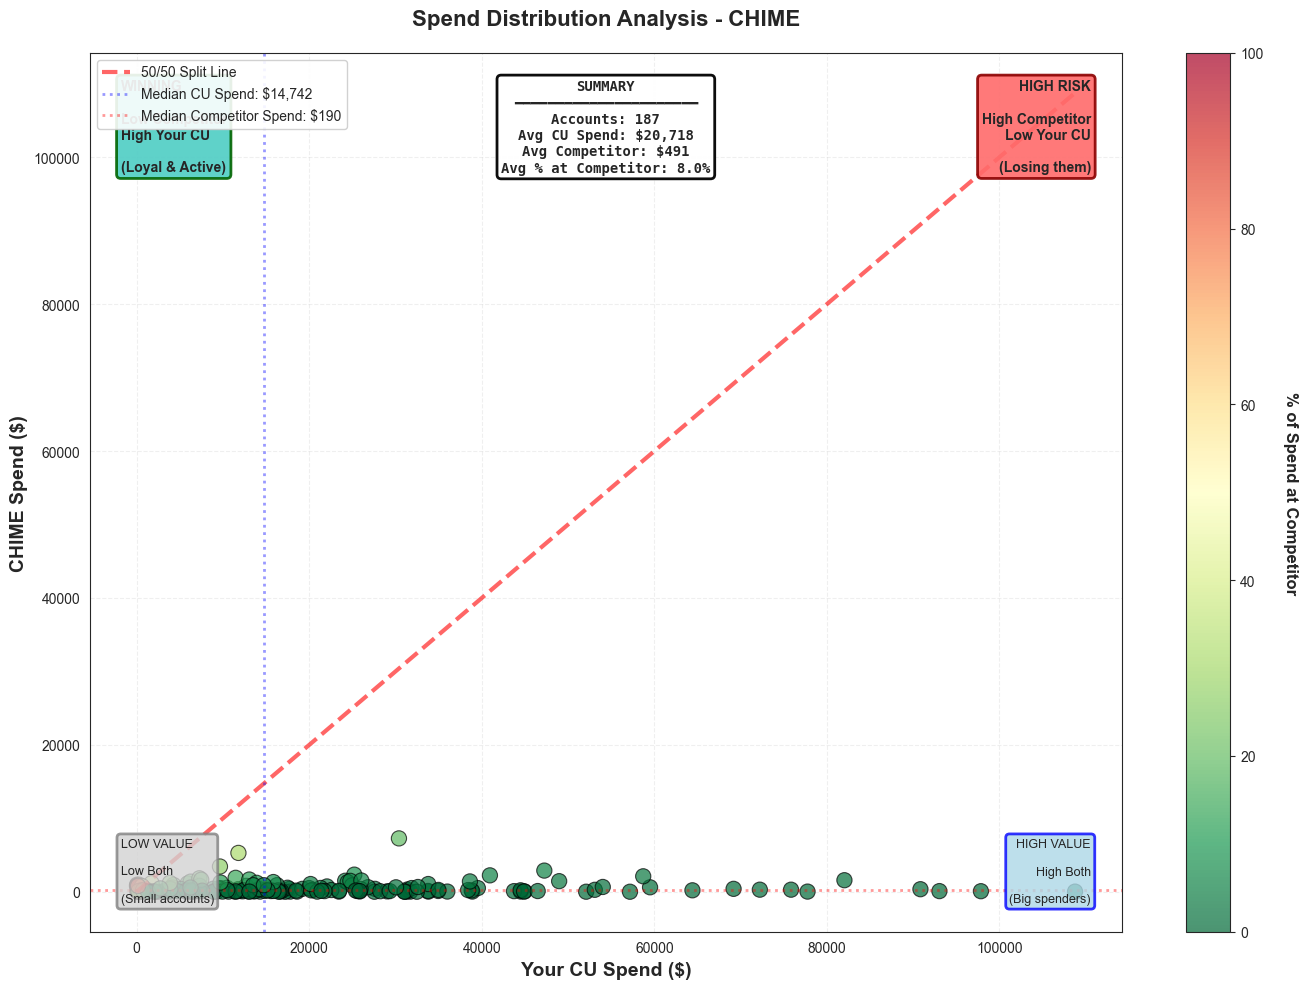


  CHIME Scatter Analysis:
  ────────────────────────────────────────────────────────────
    High Risk:     46 accounts ( 24.6%)
    Winning:       46 accounts ( 24.6%)
    High Value:    46 accounts ( 24.6%)
    Low Value:     47 accounts ( 25.1%)
  ────────────────────────────────────────────────────────────


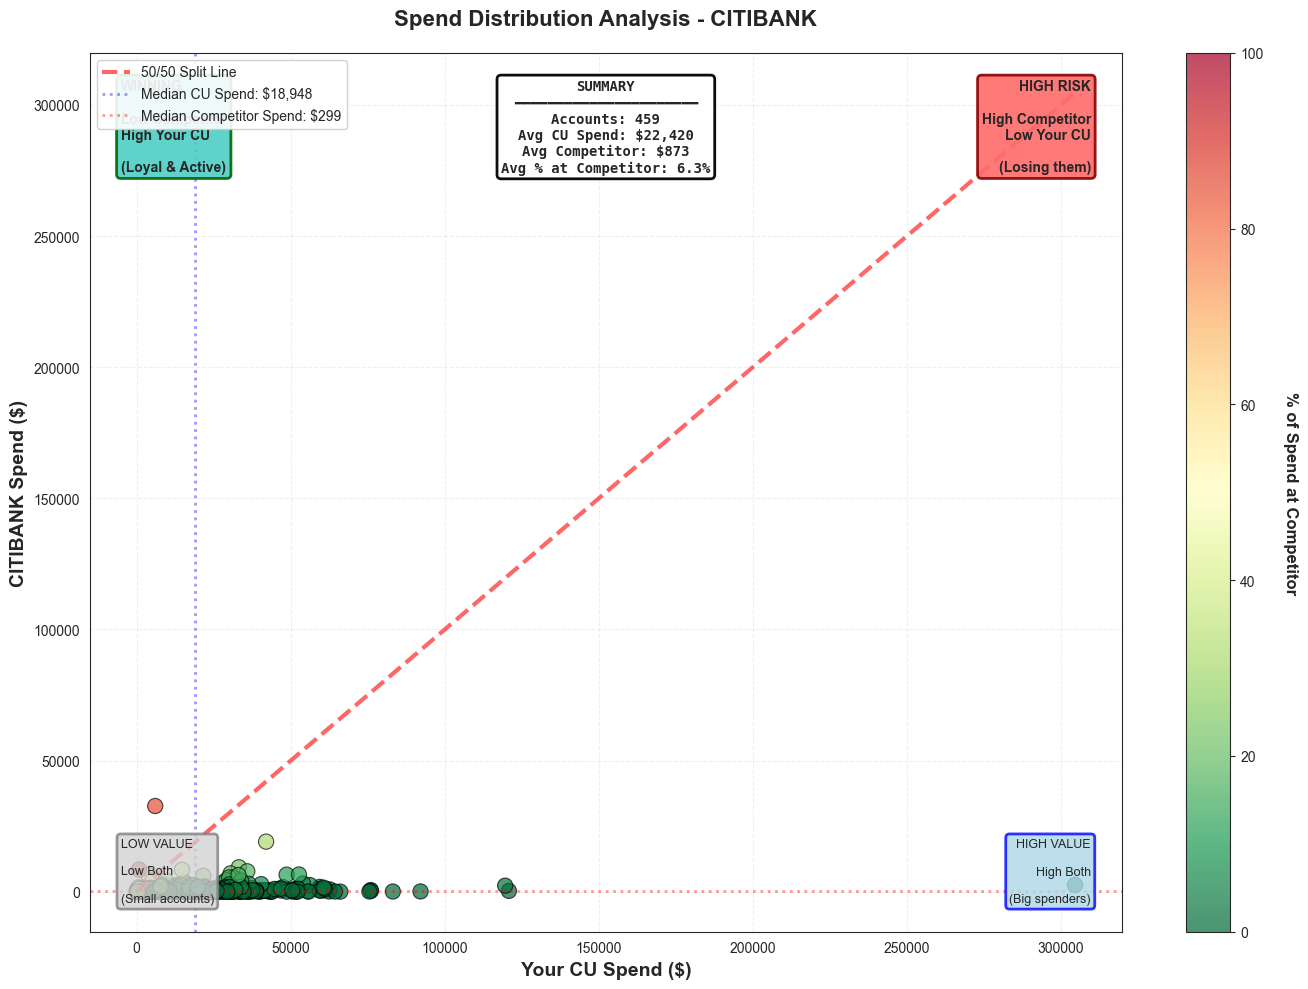


  CITIBANK Scatter Analysis:
  ────────────────────────────────────────────────────────────
    High Risk:     99 accounts ( 21.6%)
    Winning:       99 accounts ( 21.6%)
    High Value:   129 accounts ( 28.1%)
    Low Value:    130 accounts ( 28.3%)
  ────────────────────────────────────────────────────────────


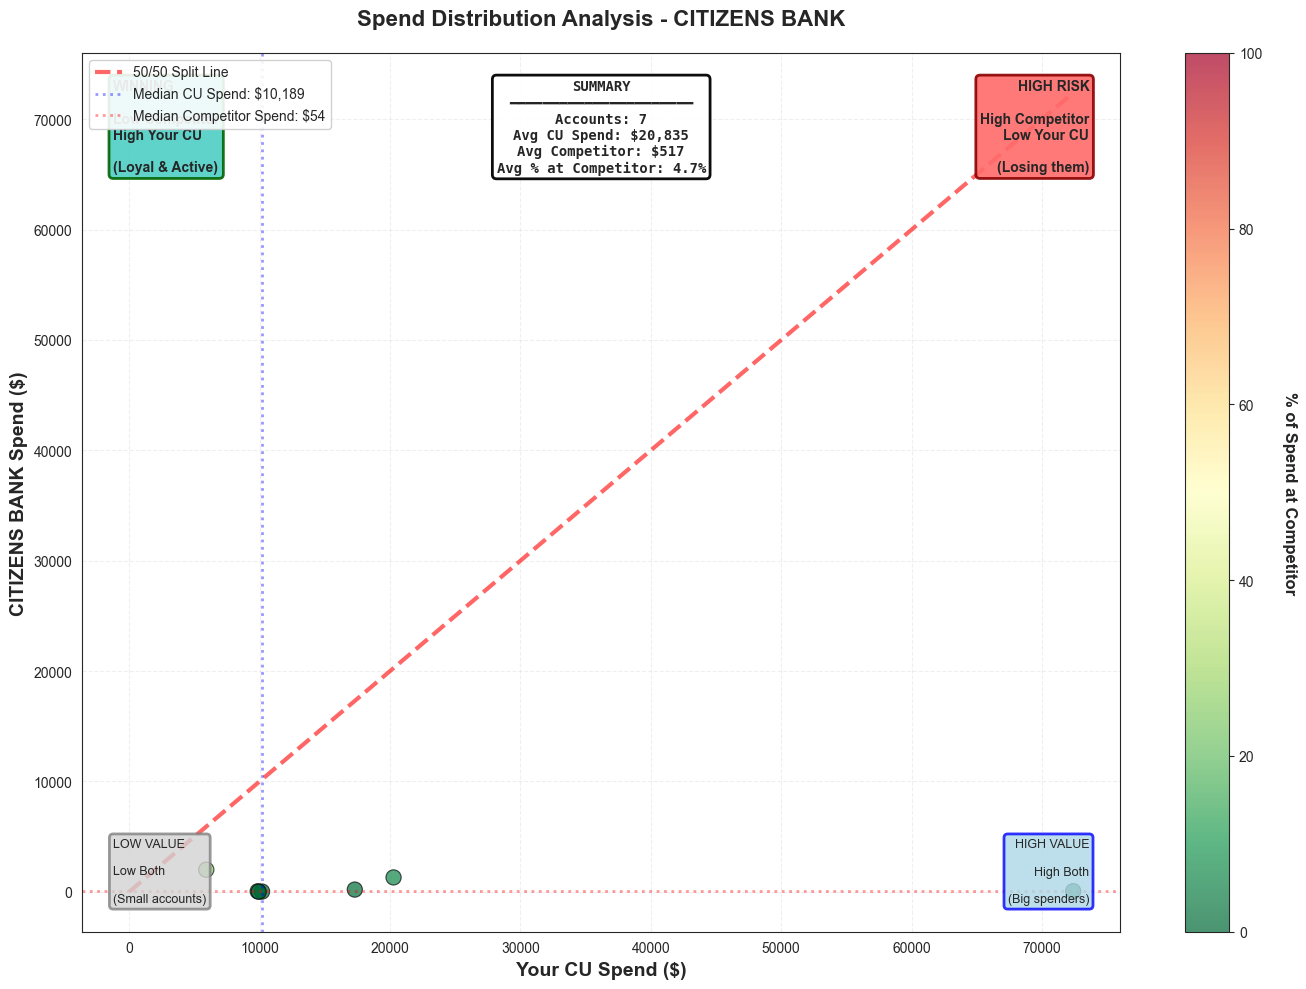


  CITIZENS BANK Scatter Analysis:
  ────────────────────────────────────────────────────────────
    High Risk:      1 accounts ( 14.3%)
    Winning:        0 accounts (  0.0%)
    High Value:     2 accounts ( 28.6%)
    Low Value:      2 accounts ( 28.6%)
  ────────────────────────────────────────────────────────────


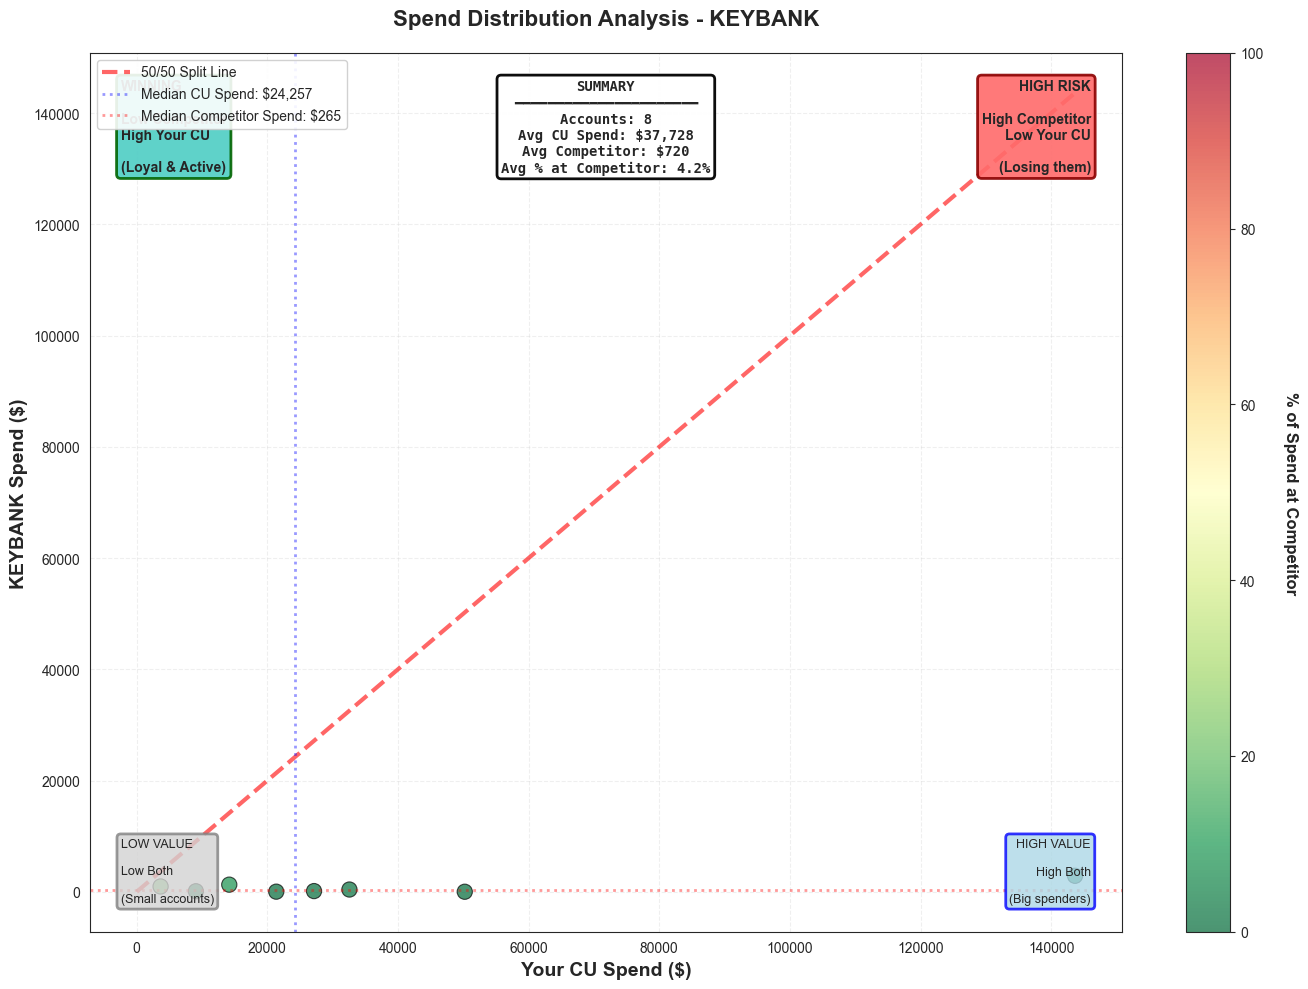


  KEYBANK Scatter Analysis:
  ────────────────────────────────────────────────────────────
    High Risk:      2 accounts ( 25.0%)
    Winning:        2 accounts ( 25.0%)
    High Value:     2 accounts ( 25.0%)
    Low Value:      2 accounts ( 25.0%)
  ────────────────────────────────────────────────────────────


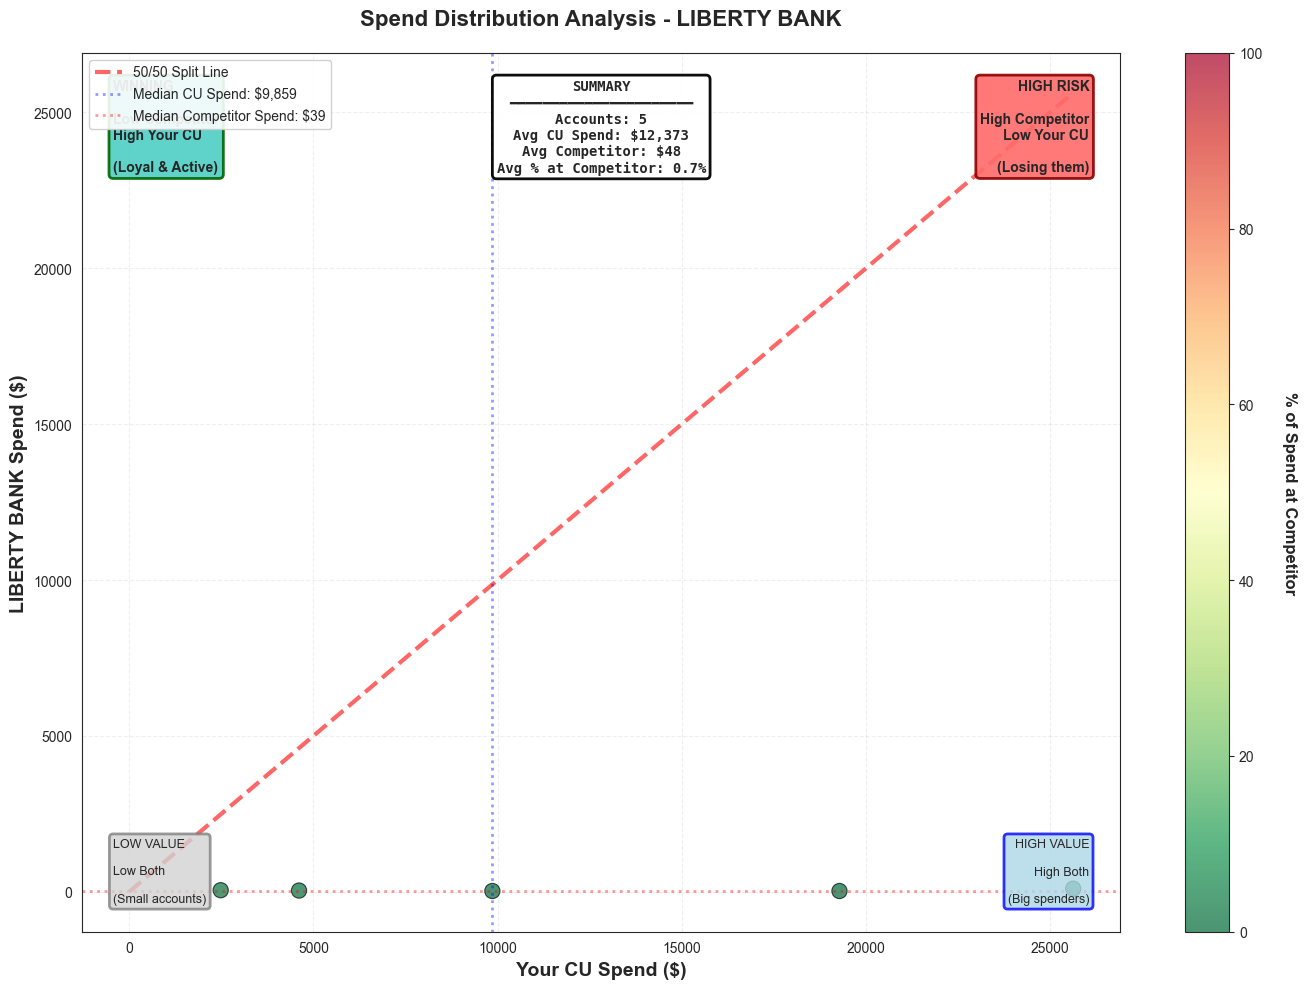


  LIBERTY BANK Scatter Analysis:
  ────────────────────────────────────────────────────────────
    High Risk:      1 accounts ( 20.0%)
    Winning:        1 accounts ( 20.0%)
    High Value:     1 accounts ( 20.0%)
    Low Value:      0 accounts (  0.0%)
  ────────────────────────────────────────────────────────────


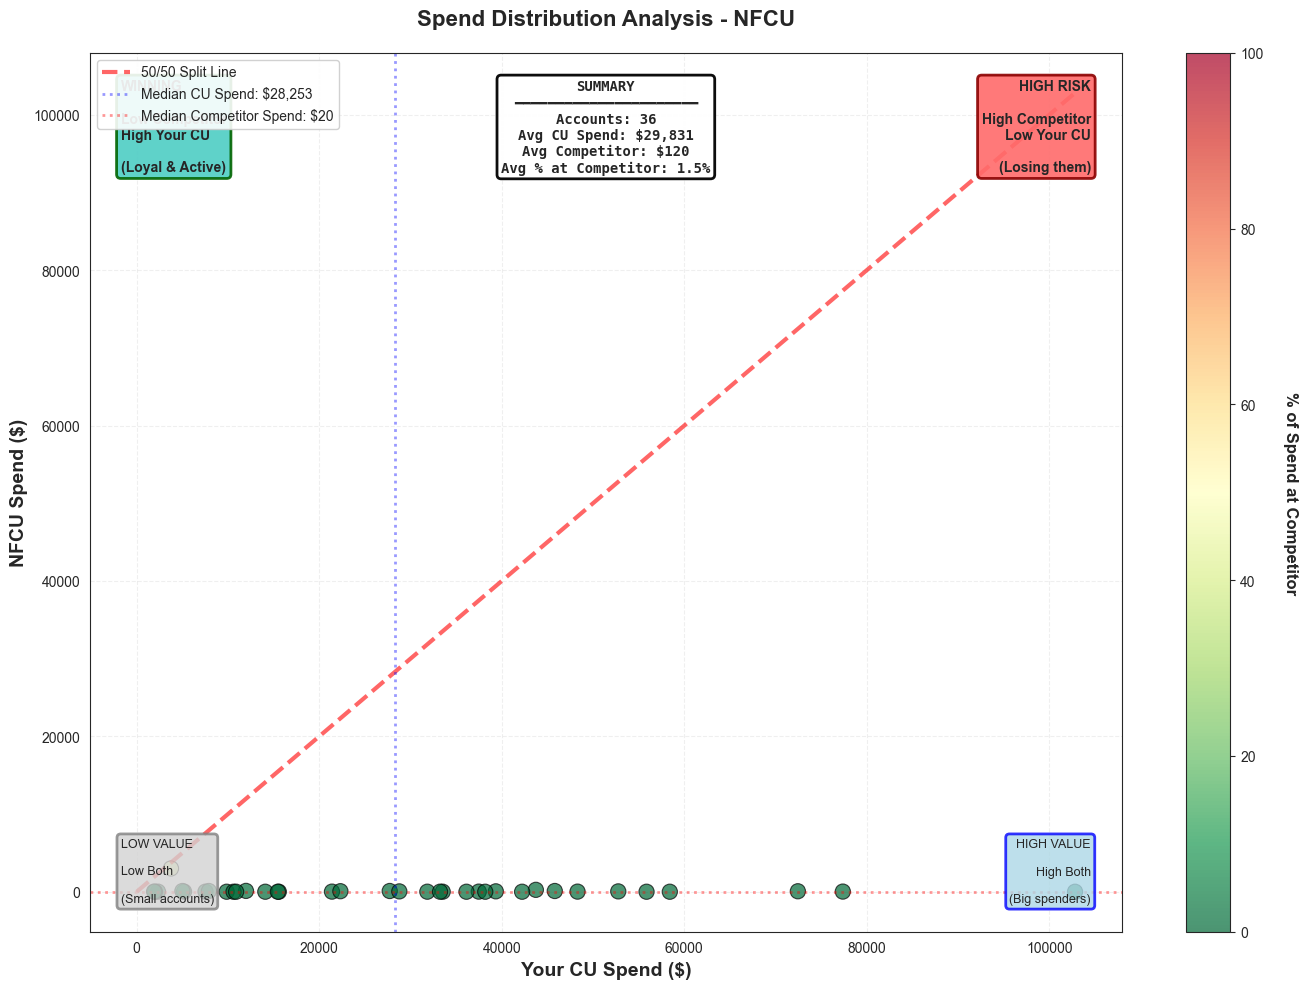


  NFCU Scatter Analysis:
  ────────────────────────────────────────────────────────────
    High Risk:      7 accounts ( 19.4%)
    Winning:        9 accounts ( 25.0%)
    High Value:     7 accounts ( 19.4%)
    Low Value:      7 accounts ( 19.4%)
  ────────────────────────────────────────────────────────────


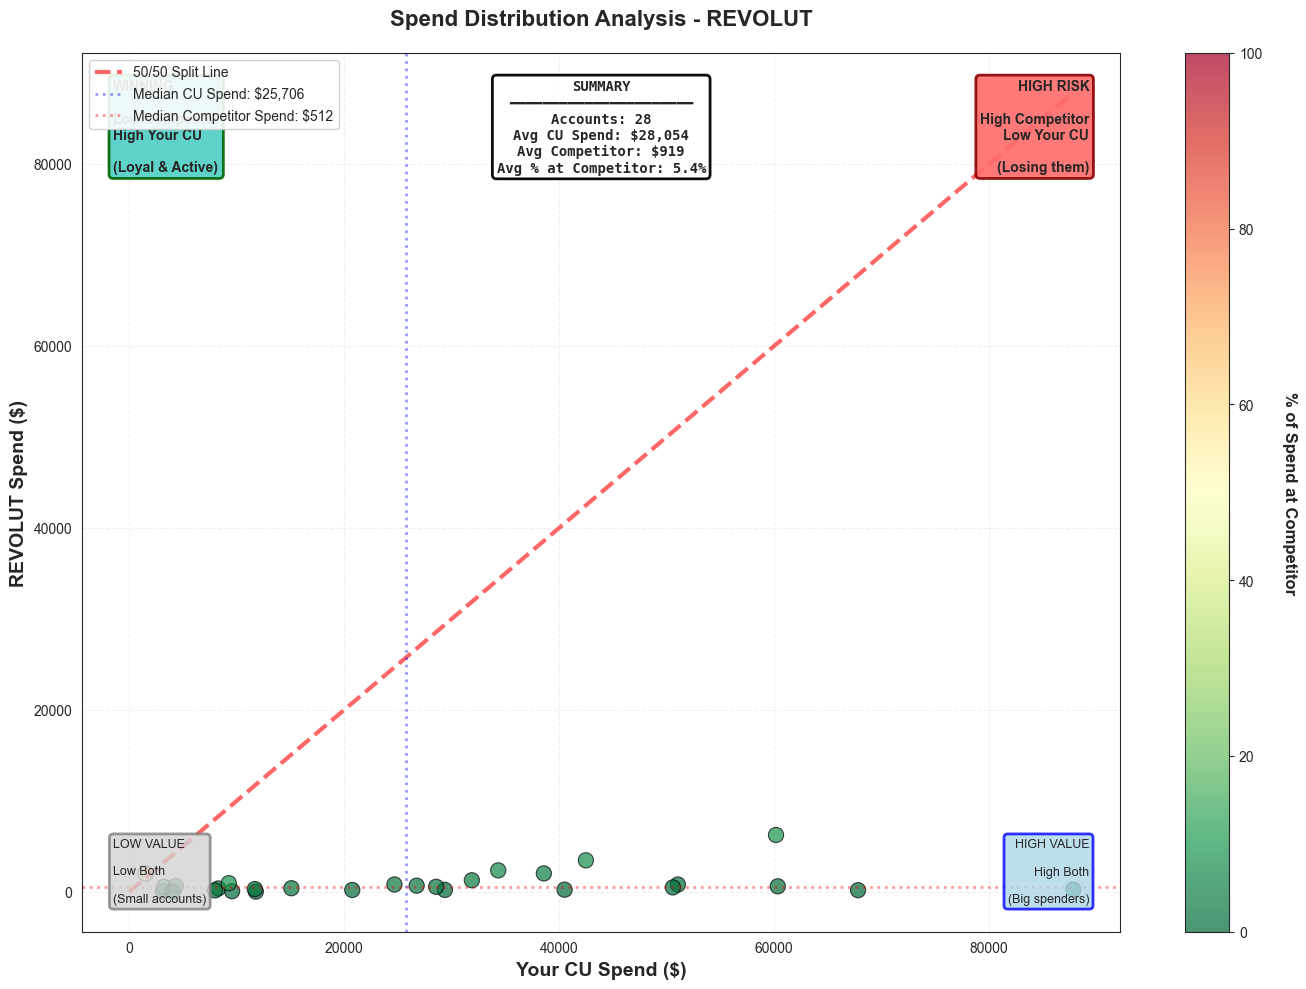


  REVOLUT Scatter Analysis:
  ────────────────────────────────────────────────────────────
    High Risk:      5 accounts ( 17.9%)
    Winning:        5 accounts ( 17.9%)
    High Value:     9 accounts ( 32.1%)
    Low Value:      9 accounts ( 32.1%)
  ────────────────────────────────────────────────────────────


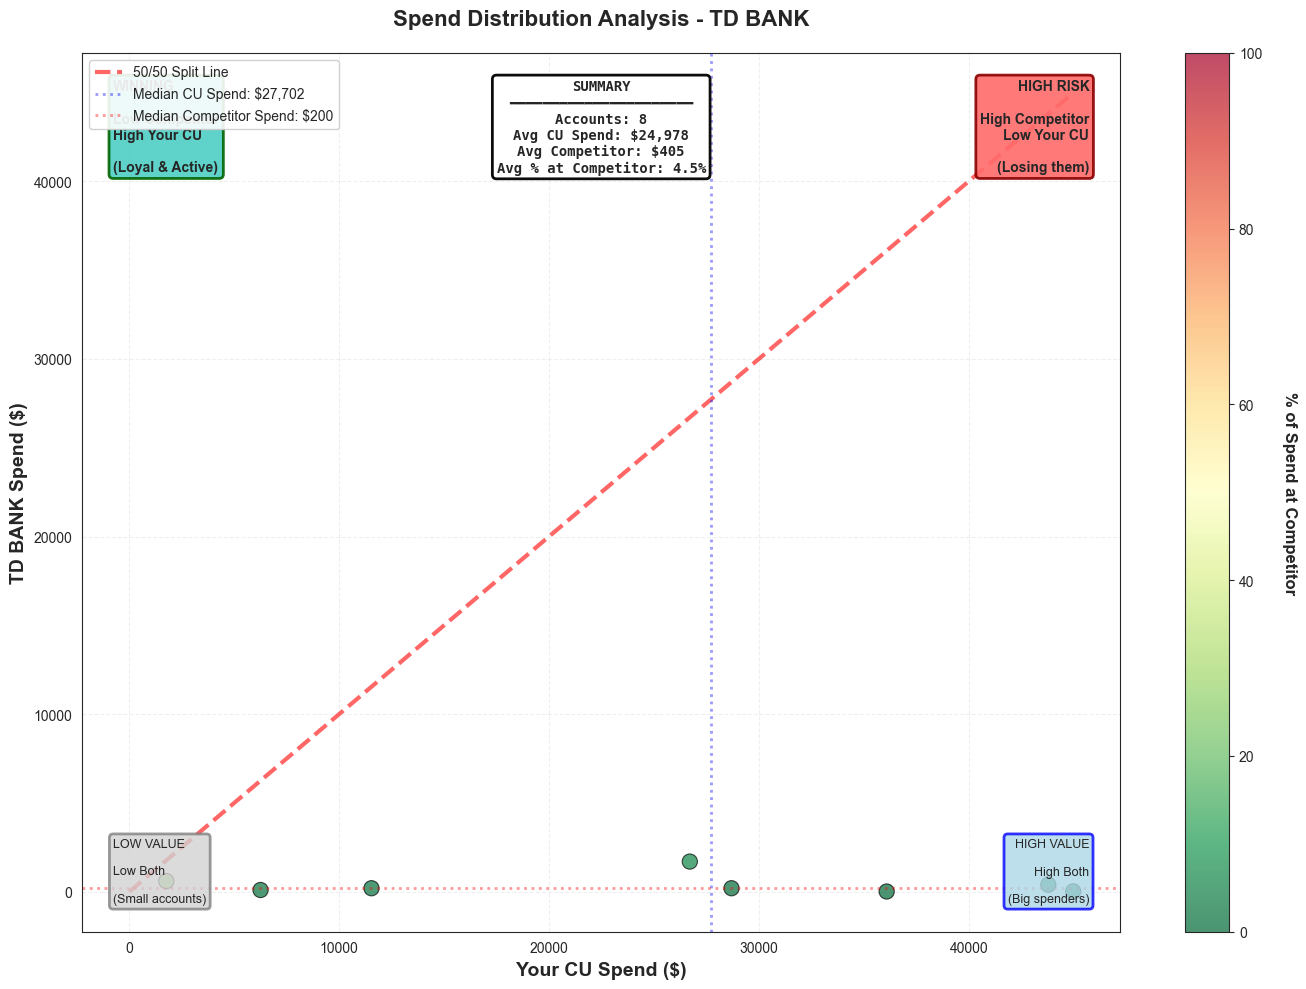


  TD BANK Scatter Analysis:
  ────────────────────────────────────────────────────────────
    High Risk:      2 accounts ( 25.0%)
    Winning:        2 accounts ( 25.0%)
    High Value:     1 accounts ( 12.5%)
    Low Value:      1 accounts ( 12.5%)
  ────────────────────────────────────────────────────────────


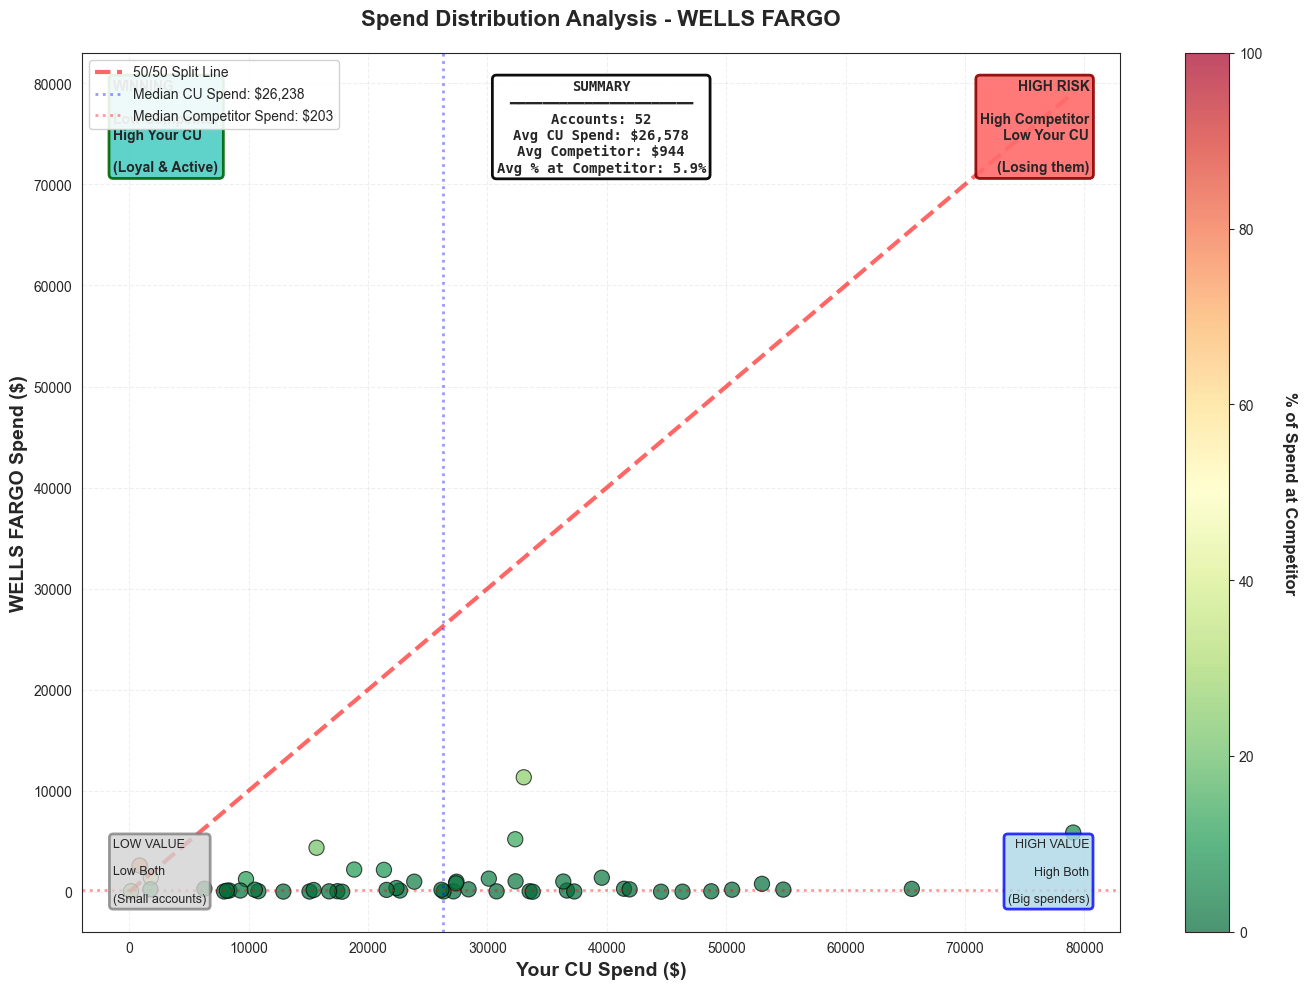


  WELLS FARGO Scatter Analysis:
  ────────────────────────────────────────────────────────────
    High Risk:     11 accounts ( 21.2%)
    Winning:       11 accounts ( 21.2%)
    High Value:    15 accounts ( 28.8%)
    Low Value:     15 accounts ( 28.8%)
  ────────────────────────────────────────────────────────────

✓ Scatter plot analysis complete


In [157]:
# ===========================================================================
# M6C: BUILD COMPETITOR SPEND ANALYSIS FROM TAGGED DATA
# ===========================================================================
# Requires: combined_df with competitor_category and competitor_match columns
# ===========================================================================

TRUE_COMPETITORS = ['big_nationals', 'regionals', 'credit_unions', 'digital_banks']

# Get only true competitor transactions
comp_txns = combined_df[combined_df['competitor_category'].isin(TRUE_COMPETITORS)].copy()

# Build per-account total spend
account_total_spend = combined_df.groupby('primary_account_num')['amount'].sum().reset_index()
account_total_spend.columns = ['primary_account_num', 'total_spend']

# Build competitor_spend_analysis dict keyed by competitor_match
competitor_spend_analysis = {}

for comp_name, grp in comp_txns.groupby('competitor_match'):
    acct_comp = grp.groupby('primary_account_num')['amount'].sum().reset_index()
    acct_comp.columns = ['primary_account_num', 'competitor_spend']

    merged = acct_comp.merge(account_total_spend, on='primary_account_num', how='left')
    merged['competitor_pct'] = (merged['competitor_spend'] / merged['total_spend'] * 100).clip(0, 100)
    merged['your_cu_spend'] = merged['total_spend'] - merged['competitor_spend']

    # Segment
    merged['Segment'] = pd.cut(
        merged['competitor_pct'],
        bins=[0, 20, 50, 80, 100],
        labels=['Low Risk', 'Moderate', 'High Risk', 'Extreme Risk'],
        include_lowest=True
    )

    merged['competitor_name'] = comp_name
    merged['competitor_category'] = grp['competitor_category'].iloc[0]
    competitor_spend_analysis[comp_name] = merged

print(f"✓ Built competitor_spend_analysis for {len(competitor_spend_analysis)} competitors")
print(f"  Columns: {list(next(iter(competitor_spend_analysis.values())).columns)}")

# Quick summary
for comp, df in sorted(competitor_spend_analysis.items(),
                       key=lambda x: x[1]['competitor_spend'].sum(), reverse=True)[:10]:
    print(f"  • {comp:30s} {len(df):>5,} accounts  ${df['competitor_spend'].sum():>12,.0f}")


# ===========================================================================
# M6C-2: VISUALIZATION - AT RISK Accounts (80%+ at Competitor)
# ===========================================================================

# Only show for competitors with enough at-risk accounts to be meaningful
for competitor, comparison in competitor_spend_analysis.items():
    at_risk = comparison[comparison['competitor_pct'] >= 80].copy()

    if len(at_risk) == 0:
        continue

    at_risk = at_risk.sort_values('total_spend', ascending=False)

    fig, ax = plt.subplots(figsize=(14, min(10, max(4, len(at_risk.head(20)) * 0.5 + 2))))

    top_n = at_risk.head(20).sort_values('total_spend')
    n = len(top_n)

    # Stacked bars: CU spend + competitor spend
    bars1 = ax.barh(range(n), top_n['your_cu_spend'],
                    label='Your CU Spend', color='#4ECDC4',
                    edgecolor='black', linewidth=0.5)
    bars2 = ax.barh(range(n), top_n['competitor_spend'],
                    left=top_n['your_cu_spend'],
                    label=f'{competitor} Spend', color='#FF6B6B',
                    edgecolor='black', linewidth=0.5)

    ax.set_yticks(range(n))
    ax.set_yticklabels([f"Account {i+1}" for i in range(n)], fontsize=10)
    ax.set_xlabel('Total Spend ($)', fontsize=12, fontweight='bold')
    ax.set_title(f'Top {n} EXTREME RISK Accounts (80%+ at {competitor})',
                 fontsize=14, fontweight='bold', color='#8B0000')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)

    # Value labels
    for i, (_, row) in enumerate(top_n.iterrows()):
        total = row['total_spend']
        pct = row['competitor_pct']
        ax.text(total + total * 0.02, i,
                f'${total:,.0f} ({pct:.0f}%)',
                va='center', fontsize=9, fontweight='bold')

    # Summary box
    total_at_risk = len(at_risk)
    total_at_risk_spend = at_risk['total_spend'].sum()
    total_competitor_spend = at_risk['competitor_spend'].sum()
    avg_pct = at_risk['competitor_pct'].mean()

    summary_text = (
        f'EXTREME RISK ACCOUNTS (80%+ at {competitor})\n'
        f'{"━" * 42}\n'
        f'Total Accounts: {total_at_risk:,}\n'
        f'Total Spend: ${total_at_risk_spend:,.0f}\n'
        f'Competitor Spend: ${total_competitor_spend:,.0f}\n'
        f'Avg % at Competitor: {avg_pct:.1f}%\n'
        f'Your CU Spend: ${total_at_risk_spend - total_competitor_spend:,.0f}'
    )

    ax.text(0.02, 0.98, summary_text, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='#FFE5E5', alpha=0.95,
                      edgecolor='#8B0000', linewidth=2),
            fontsize=10, fontweight='bold', family='monospace')

    plt.tight_layout()
    plt.show()

    print(f"\n  {competitor}: {total_at_risk:,} extreme risk accounts (80%+ spend at competitor)")
    print("-" * 80)

print("\n✓ At-risk visualization complete")


# ===========================================================================
# M6C-3: VISUALIZATION - Spend Distribution Scatter
# ===========================================================================

for competitor, comparison in competitor_spend_analysis.items():
    if len(comparison) < 5:
        continue  # skip competitors with too few accounts for a meaningful scatter

    fig, ax = plt.subplots(figsize=(14, 10))

    scatter = ax.scatter(
        comparison['your_cu_spend'],
        comparison['competitor_spend'],
        s=120, alpha=0.7,
        c=comparison['competitor_pct'],
        cmap='RdYlGn_r',
        edgecolors='black', linewidth=0.8,
        vmin=0, vmax=100
    )

    ax.set_xlabel('Your CU Spend ($)', fontsize=14, fontweight='bold')
    ax.set_ylabel(f'{competitor} Spend ($)', fontsize=14, fontweight='bold')
    ax.set_title(f'Spend Distribution Analysis - {competitor}',
                 fontsize=16, fontweight='bold', pad=20)
    ax.grid(alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)

    # Colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('% of Spend at Competitor', rotation=270, labelpad=25,
                   fontsize=12, fontweight='bold')
    cbar.ax.tick_params(labelsize=10)

    # 50/50 diagonal
    max_val = max(comparison['your_cu_spend'].max(), comparison['competitor_spend'].max())
    ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.6, linewidth=3,
            label='50/50 Split Line')

    # Median reference lines
    median_cu = comparison['your_cu_spend'].median()
    median_comp = comparison['competitor_spend'].median()
    ax.axvline(median_cu, color='blue', linestyle=':', alpha=0.4, linewidth=2,
               label=f'Median CU Spend: ${median_cu:,.0f}')
    ax.axhline(median_comp, color='red', linestyle=':', alpha=0.4, linewidth=2,
               label=f'Median Competitor Spend: ${median_comp:,.0f}')

    # Quadrant labels
    ax.text(0.97, 0.97, 'HIGH RISK\n\nHigh Competitor\nLow Your CU\n\n(Losing them)',
            transform=ax.transAxes, ha='right', va='top',
            bbox=dict(boxstyle='round', facecolor='#FF6B6B', alpha=0.9,
                      edgecolor='darkred', linewidth=2),
            fontweight='bold', fontsize=10)

    ax.text(0.03, 0.03, 'LOW VALUE\n\nLow Both\n\n(Small accounts)',
            transform=ax.transAxes, ha='left', va='bottom',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8,
                      edgecolor='gray', linewidth=2),
            fontsize=9)

    ax.text(0.97, 0.03, 'HIGH VALUE\n\nHigh Both\n\n(Big spenders)',
            transform=ax.transAxes, ha='right', va='bottom',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8,
                      edgecolor='blue', linewidth=2),
            fontsize=9)

    ax.text(0.03, 0.97, 'WINNING\n\nLow Competitor\nHigh Your CU\n\n(Loyal & Active)',
            transform=ax.transAxes, ha='left', va='top',
            bbox=dict(boxstyle='round', facecolor='#4ECDC4', alpha=0.9,
                      edgecolor='darkgreen', linewidth=2),
            fontweight='bold', fontsize=10)

    # Stats box
    total_accounts = len(comparison)
    avg_cu_spend = comparison['your_cu_spend'].mean()
    avg_comp_spend = comparison['competitor_spend'].mean()
    avg_comp_pct = comparison['competitor_pct'].mean()

    stats_text = (
        f'SUMMARY\n'
        f'{"━" * 22}\n'
        f'Accounts: {total_accounts:,}\n'
        f'Avg CU Spend: ${avg_cu_spend:,.0f}\n'
        f'Avg Competitor: ${avg_comp_spend:,.0f}\n'
        f'Avg % at Competitor: {avg_comp_pct:.1f}%'
    )

    ax.text(0.50, 0.97, stats_text, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='center',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.95,
                      edgecolor='black', linewidth=2),
            fontsize=10, fontweight='bold', family='monospace')

    ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
    plt.tight_layout()
    plt.show()

    # Quadrant counts
    high_risk = len(comparison[(comparison['competitor_spend'] > median_comp) &
                               (comparison['your_cu_spend'] < median_cu)])
    winning = len(comparison[(comparison['competitor_spend'] < median_comp) &
                             (comparison['your_cu_spend'] > median_cu)])
    high_value = len(comparison[(comparison['competitor_spend'] > median_comp) &
                                (comparison['your_cu_spend'] > median_cu)])
    low_value = len(comparison[(comparison['competitor_spend'] < median_comp) &
                               (comparison['your_cu_spend'] < median_cu)])

    print(f"\n  {competitor} Scatter Analysis:")
    print(f"  {'─' * 60}")
    print(f"    High Risk:  {high_risk:>5,} accounts ({high_risk/total_accounts*100:5.1f}%)")
    print(f"    Winning:    {winning:>5,} accounts ({winning/total_accounts*100:5.1f}%)")
    print(f"    High Value: {high_value:>5,} accounts ({high_value/total_accounts*100:5.1f}%)")
    print(f"    Low Value:  {low_value:>5,} accounts ({low_value/total_accounts*100:5.1f}%)")
    print(f"  {'─' * 60}")

print("\n✓ Scatter plot analysis complete")

In [154]:
# ===========================================================================
# CELL 12: VISUALIZATION - Spend Distribution Scatter
# ===========================================================================
"""
## Competitor Analysis - Competitor vs Your CU Spend Scatter
"""

for competitor, comparison in competitor_spend_analysis.items():
    # Calculate "your bank" spend
    comparison['your_cu_spend'] = comparison['total_spend'] - comparison['competitor_spend']
    
    # Skip if no data
    if len(comparison) == 0:
        continue
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Create scatter plot
    scatter = ax.scatter(comparison['your_cu_spend'], 
                        comparison['competitor_spend'],
                        s=120,
                        alpha=0.7,
                        c=comparison['competitor_pct'],
                        cmap='RdYlGn_r',
                        edgecolors='black',
                        linewidth=0.8,
                        vmin=0,
                        vmax=100)
    
    ax.set_xlabel('Your CU Spend ($)', fontsize=14, fontweight='bold')
    ax.set_ylabel(f'{competitor} Spend ($)', fontsize=14, fontweight='bold')
    ax.set_title(f'Spend Distribution Analysis - {competitor}', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.grid(alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('% of Spend at Competitor', rotation=270, labelpad=25, fontsize=12, fontweight='bold')
    cbar.ax.tick_params(labelsize=10)
    
    # Add diagonal line (50/50 split)
    max_val = max(comparison['your_cu_spend'].max(), comparison['competitor_spend'].max())
    ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.6, linewidth=3, label='50/50 Split Line')
    
    # Add reference lines (medians)
    median_cu = comparison['your_cu_spend'].median()
    median_comp = comparison['competitor_spend'].median()
    ax.axvline(median_cu, color='blue', linestyle=':', alpha=0.4, linewidth=2, label=f'Median CU Spend: ${median_cu:,.0f}')
    ax.axhline(median_comp, color='red', linestyle=':', alpha=0.4, linewidth=2, label=f'Median Competitor Spend: ${median_comp:,.0f}')
    
    # Add quadrant labels with better styling
    ax.text(0.97, 0.97, '🚨 HIGH RISK\n\nHigh Competitor\nLow Your CU\n\n(Losing them)', 
            transform=ax.transAxes, ha='right', va='top',
            bbox=dict(boxstyle='round', facecolor='#FF6B6B', alpha=0.9, edgecolor='darkred', linewidth=2),
            fontweight='bold', fontsize=11)
    
    ax.text(0.03, 0.03, '📉 LOW VALUE\n\nLow Both\n\n(Small accounts)', 
            transform=ax.transAxes, ha='left', va='bottom',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8, edgecolor='gray', linewidth=2),
            fontsize=10)
    
    ax.text(0.97, 0.03, '💰 HIGH VALUE\n\nHigh Both\n\n(Big spenders)', 
            transform=ax.transAxes, ha='right', va='bottom',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8, edgecolor='blue', linewidth=2),
            fontsize=10)
    
    ax.text(0.03, 0.97, '✅ WINNING\n\nLow Competitor\nHigh Your CU\n\n(Loyal & Active)', 
            transform=ax.transAxes, ha='left', va='top',
            bbox=dict(boxstyle='round', facecolor='#4ECDC4', alpha=0.9, edgecolor='darkgreen', linewidth=2),
            fontweight='bold', fontsize=11)
    
    # Add statistics box
    total_accounts = len(comparison)
    avg_cu_spend = comparison['your_cu_spend'].mean()
    avg_comp_spend = comparison['competitor_spend'].mean()
    avg_comp_pct = comparison['competitor_pct'].mean()
    
    stats_text = f'📊 SUMMARY STATS\n'
    stats_text += f'━━━━━━━━━━━━━━━━━━━━\n'
    stats_text += f'Total Accounts: {total_accounts:,}\n'
    stats_text += f'Avg CU Spend: ${avg_cu_spend:,.0f}\n'
    stats_text += f'Avg Competitor: ${avg_comp_spend:,.0f}\n'
    stats_text += f'Avg % at Competitor: {avg_comp_pct:.1f}%'
    
    ax.text(0.50, 0.97, stats_text, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='center',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.95, edgecolor='black', linewidth=2),
            fontsize=10, fontweight='bold', family='monospace')
    
    ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
    plt.tight_layout()
    plt.show()
    
    # Print insights
    print(f"\n📊 {competitor} Scatter Analysis:")
    print("="*80)
    
    # Count accounts in each quadrant
    high_risk = len(comparison[(comparison['competitor_spend'] > median_comp) & 
                                (comparison['your_cu_spend'] < median_cu)])
    winning = len(comparison[(comparison['competitor_spend'] < median_comp) & 
                              (comparison['your_cu_spend'] > median_cu)])
    high_value = len(comparison[(comparison['competitor_spend'] > median_comp) & 
                                 (comparison['your_cu_spend'] > median_cu)])
    low_value = len(comparison[(comparison['competitor_spend'] < median_comp) & 
                                (comparison['your_cu_spend'] < median_cu)])
    
    print(f"  🚨 High Risk (top-right): {high_risk:,} accounts ({high_risk/total_accounts*100:.1f}%)")
    print(f"  ✅ Winning (top-left): {winning:,} accounts ({winning/total_accounts*100:.1f}%)")
    print(f"  💰 High Value (bottom-right): {high_value:,} accounts ({high_value/total_accounts*100:.1f}%)")
    print(f"  📉 Low Value (bottom-left): {low_value:,} accounts ({low_value/total_accounts*100:.1f}%)")
    print("="*80)

print("\n✓ Scatter plot analysis complete")

KeyError: 'total_spend'

In [155]:
# ===========================================================================
# DEBUG: Check Category Spend Aggregation
# ===========================================================================

print("="*100)
print("DEBUGGING CATEGORY SPEND DATA")
print("="*100)

# Check a sample competitor
sample_competitor = list(competitor_spend_analysis.keys())[0]
sample_data = competitor_spend_analysis[sample_competitor]

print(f"\n📋 Sample Competitor: {sample_competitor}")
print(f"Columns in competitor_spend_analysis:")
print(list(sample_data.columns))
print(f"\nFirst 5 rows:")
print(sample_data.head())

print("\n" + "="*100)

# Check how many accounts per category
category_account_counts = {}

for competitor, comparison in competitor_spend_analysis.items():
    category = all_competitor_data[competitor]['competitor_category'].iloc[0]
    
    if category not in category_account_counts:
        category_account_counts[category] = {
            'accounts': set(),
            'competitors': []
        }
    
    # Add unique accounts
    category_account_counts[category]['accounts'].update(comparison['account'].values)
    category_account_counts[category]['competitors'].append(competitor)

print("\n📊 Accounts Per Category (UNIQUE):")
print("-"*100)
for category, data in category_account_counts.items():
    print(f"{category.replace('_', ' ').title()}")
    print(f"  • Unique accounts: {len(data['accounts']):,}")
    print(f"  • Competitors: {len(data['competitors'])}")
    print(f"  • Competitor names: {', '.join(data['competitors'][:5])}")
    if len(data['competitors']) > 5:
        print(f"    ... and {len(data['competitors']) - 5} more")
    print()

print("="*100)

# Check if an account appears in multiple competitors within same category
print("\n🔍 Checking for account overlap within categories...")

for category, data in category_account_counts.items():
    # Get all competitors in this category
    competitors_in_cat = data['competitors']
    
    if len(competitors_in_cat) <= 1:
        continue
    
    # Check if any account uses multiple competitors in this category
    account_competitor_map = {}
    
    for competitor in competitors_in_cat:
        comparison = competitor_spend_analysis[competitor]
        for account in comparison['account'].values:
            if account not in account_competitor_map:
                account_competitor_map[account] = []
            account_competitor_map[account].append(competitor)
    
    # Find accounts using multiple competitors in this category
    multi_competitor = {acc: comps for acc, comps in account_competitor_map.items() if len(comps) > 1}
    
    if len(multi_competitor) > 0:
        print(f"\n⚠️ {category.replace('_', ' ').title()}: {len(multi_competitor):,} accounts use MULTIPLE competitors in this category")
        print(f"   Example: Account {list(multi_competitor.keys())[0]} uses: {', '.join(multi_competitor[list(multi_competitor.keys())[0]])}")
    else:
        print(f"\n✓ {category.replace('_', ' ').title()}: No accounts use multiple competitors")

print("\n" + "="*100)

DEBUGGING CATEGORY SPEND DATA

📋 Sample Competitor: exact
Columns in competitor_spend_analysis:
['Total_Spend', 'Total_Transactions', 'Competitor_Spend', 'Competitor_Transactions', 'Other_Spend', 'Other_Transactions', 'Competitor_Pct', 'Other_Pct', 'Segment']

First 5 rows:
                                          Total_Spend  Total_Transactions  \
primary_account_num                                                         
AE607049F7CBC96F9038D37D91E9A3A44B1B97E3     73384.24                1579   
4267347F6D0B76A551C78C8E83A813E78D7098D1     66678.36                1470   
94DA3F39A99F33CD84E1C60CB2DC04144DEE66AC     44824.91                 735   
EBF54F0653D278F66A2642EE61054E5B9D0EBC32     43020.87                 610   
BA7DDCA0079A4489EC942B48F36FBF64BFE5522C     35329.44                 594   

                                          Competitor_Spend  \
primary_account_num                                          
AE607049F7CBC96F9038D37D91E9A3A44B1B97E3            167.94   

KeyError: 'account'

In [156]:
# ===========================================================================
# CELL 12: VISUALIZATION - Spend Distribution by Category (Aggregated)
# ===========================================================================
"""
## Competitor Analysis - Category-Level Spend Distribution
Shows one scatter plot per competitor category (not per competitor)
"""

import matplotlib.pyplot as plt
import numpy as np

# Group all competitor data by category
category_spend_data = {}

for competitor, comparison in competitor_spend_analysis.items():
    # Get category
    category = all_competitor_data[competitor]['competitor_category'].iloc[0]
    
    if category not in category_spend_data:
        category_spend_data[category] = []
    
    # Add each account's data with category tag
    for idx, row in comparison.iterrows():
        category_spend_data[category].append({
            'account': row['account'],
            'competitor_spend': row['competitor_spend'],
            'total_spend': row['total_spend'],
            'competitor_pct': row['competitor_pct'],
            'competitor_name': competitor
        })

# Create one scatter plot per category
for category, accounts in category_spend_data.items():
    cat_df = pd.DataFrame(accounts)
    
    # Skip small categories
    if len(cat_df) < 10:
        continue
    
    # Calculate your CU spend
    cat_df['your_cu_spend'] = cat_df['total_spend'] - cat_df['competitor_spend']
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Create scatter plot
    scatter = ax.scatter(cat_df['your_cu_spend'], 
                        cat_df['competitor_spend'],
                        s=80,
                        alpha=0.6,
                        c=cat_df['competitor_pct'],
                        cmap='RdYlGn_r',
                        edgecolors='black',
                        linewidth=0.5,
                        vmin=0,
                        vmax=100)
    
    # Format category name
    category_title = category.replace('_', ' ').title()
    
    ax.set_xlabel('Your CU Spend ($)', fontsize=15, fontweight='bold')
    ax.set_ylabel(f'{category_title} Spend ($)', fontsize=15, fontweight='bold')
    ax.set_title(f'Spend Distribution - {category_title} Category', 
                 fontsize=18, fontweight='bold', pad=25)
    ax.grid(alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('% of Spend at Competitor', rotation=270, labelpad=30, fontsize=13, fontweight='bold')
    cbar.ax.tick_params(labelsize=11)
    
    # Add diagonal line (50/50 split)
    max_val = max(cat_df['your_cu_spend'].max(), cat_df['competitor_spend'].max())
    if max_val > 0:
        ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.6, linewidth=3, label='50/50 Split Line')
    
    # Add reference lines (medians)
    median_cu = cat_df['your_cu_spend'].median()
    median_comp = cat_df['competitor_spend'].median()
    ax.axvline(median_cu, color='blue', linestyle=':', alpha=0.4, linewidth=2.5)
    ax.axhline(median_comp, color='red', linestyle=':', alpha=0.4, linewidth=2.5)
    
    # Add quadrant labels
    ax.text(0.97, 0.97, '🚨 HIGH RISK\n\nHigh Competitor\nLow Your CU', 
            transform=ax.transAxes, ha='right', va='top',
            bbox=dict(boxstyle='round', facecolor='#FF6B6B', alpha=0.9, edgecolor='darkred', linewidth=2),
            fontweight='bold', fontsize=12)
    
    ax.text(0.03, 0.03, '📉 LOW VALUE\n\nLow Both', 
            transform=ax.transAxes, ha='left', va='bottom',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8, edgecolor='gray', linewidth=2),
            fontsize=11)
    
    ax.text(0.97, 0.03, '💰 HIGH VALUE\n\nHigh Both', 
            transform=ax.transAxes, ha='right', va='bottom',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8, edgecolor='blue', linewidth=2),
            fontsize=11)
    
    ax.text(0.03, 0.97, '✅ WINNING\n\nLow Competitor\nHigh Your CU', 
            transform=ax.transAxes, ha='left', va='top',
            bbox=dict(boxstyle='round', facecolor='#4ECDC4', alpha=0.9, edgecolor='darkgreen', linewidth=2),
            fontweight='bold', fontsize=12)
    
    # Calculate statistics
    total_accounts = len(cat_df)
    unique_competitors = cat_df['competitor_name'].nunique()
    avg_cu_spend = cat_df['your_cu_spend'].mean()
    avg_comp_spend = cat_df['competitor_spend'].mean()
    avg_comp_pct = cat_df['competitor_pct'].mean()
    total_category_spend = cat_df['competitor_spend'].sum()
    
    # Stats box
    stats_text = f'📊 {category_title.upper()} SUMMARY\n'
    stats_text += f'━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n'
    stats_text += f'Total Accounts: {total_accounts:,}\n'
    stats_text += f'Competitors in Category: {unique_competitors}\n'
    stats_text += f'Avg CU Spend: ${avg_cu_spend:,.0f}\n'
    stats_text += f'Avg Competitor: ${avg_comp_spend:,.0f}\n'
    stats_text += f'Avg % at Competitor: {avg_comp_pct:.1f}%\n'
    stats_text += f'Total Category Spend: ${total_category_spend:,.0f}'
    
    ax.text(0.50, 0.97, stats_text, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='center',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.95, edgecolor='black', linewidth=2.5),
            fontsize=11, fontweight='bold', family='monospace')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed quadrant analysis
    print(f"\n📊 {category_title} - Quadrant Analysis:")
    print("="*100)
    
    # Count accounts in each quadrant
    high_risk = len(cat_df[(cat_df['competitor_spend'] > median_comp) & 
                            (cat_df['your_cu_spend'] < median_cu)])
    winning = len(cat_df[(cat_df['competitor_spend'] < median_comp) & 
                          (cat_df['your_cu_spend'] > median_cu)])
    high_value = len(cat_df[(cat_df['competitor_spend'] > median_comp) & 
                             (cat_df['your_cu_spend'] > median_cu)])
    low_value = len(cat_df[(cat_df['competitor_spend'] < median_comp) & 
                            (cat_df['your_cu_spend'] < median_cu)])
    
    print(f"  🚨 High Risk (top-right):    {high_risk:,} accounts ({high_risk/total_accounts*100:.1f}%) - Using competitor MORE")
    print(f"  ✅ Winning (top-left):       {winning:,} accounts ({winning/total_accounts*100:.1f}%) - Loyal to your CU")
    print(f"  💰 High Value (bottom-right): {high_value:,} accounts ({high_value/total_accounts*100:.1f}%) - Big spenders everywhere")
    print(f"  📉 Low Value (bottom-left):   {low_value:,} accounts ({low_value/total_accounts*100:.1f}%) - Small/inactive accounts")
    
    print(f"\n  Top 5 Competitors in {category_title}:")
    top_5_in_category = cat_df.groupby('competitor_name')['competitor_spend'].sum().sort_values(ascending=False).head(5)
    for i, (comp, spend) in enumerate(top_5_in_category.items(), 1):
        print(f"    {i}. {comp}: ${spend:,.0f}")
    
    print("="*100)

print("\n✓ Category-level scatter plot analysis complete")
print("\n💡 Shows aggregated spend patterns across entire competitor categories")
print("   Much cleaner than 47 individual scatter plots!")

KeyError: 'account'

#### Export Lists

In [ ]:
# ===========================================================================
# CELL 13: EXPORT SPEND ANALYSIS
# ===========================================================================
"""
## Competitor Analysis - Export Spend Comparison
"""

for competitor, comparison in competitor_spend_analysis.items():
    competitor_clean = competitor.replace(' ', '_').replace('/', '_')
    
    # Export full spend comparison
    export_comparison = comparison.copy()
    export_comparison = export_comparison.reset_index()
    export_comparison.columns = ['Account_Number', 'Total_Spend', 'Total_Transactions',
                                 'Competitor_Spend', 'Competitor_Transactions',
                                 'Other_Spend', 'Other_Transactions',
                                 'Competitor_Pct', 'Other_Pct', 'Segment']
    
    output_file = output_dir / f"Competitor_{competitor_clean}_Spend_Comparison.csv"
    export_comparison.to_csv(output_file, index=False)
    
    # Export AT RISK accounts (80%+ competitor)
    at_risk = export_comparison[export_comparison['Competitor_Pct'] >= 80].copy()
    at_risk = at_risk.sort_values('Total_Spend', ascending=False)
    
    output_risk = output_dir / f"Competitor_{competitor_clean}_AT_RISK_Accounts.csv"
    at_risk.to_csv(output_risk, index=False)
    
    # Export OPPORTUNITY accounts (<20% competitor)
    opportunity = export_comparison[export_comparison['Competitor_Pct'] < 20].copy()
    opportunity = opportunity.sort_values('Total_Spend', ascending=False)
    
    output_opp = output_dir / f"Competitor_{competitor_clean}_OPPORTUNITY_Accounts.csv"
    opportunity.to_csv(output_opp, index=False)
    
    print(f"✓ Exported for {competitor}:")
    print(f"  - Full spend comparison: {output_file.name}")
    print(f"  - AT RISK accounts (80%+ competitor): {output_risk.name} ({len(at_risk):,} accounts)")
    print(f"  - OPPORTUNITY accounts (<20% competitor): {output_opp.name} ({len(opportunity):,} accounts)")
    print()

print("\n✓ All spend analysis exports complete!")


## 7 - FInancial Services

### Configuration

In [158]:
# ===========================================================================
# CELL 1: CONFIGURATION - Financial Services Patterns
# ===========================================================================
"""
## Financial Services Opportunity - Configuration
"""

# Define financial services categories and merchant patterns
FINANCIAL_SERVICES_PATTERNS = {
    'Auto Loans': [
        'TOYOTA MOTOR CREDIT',
        'TOYOTA FINANCIAL',
        'VW CREDIT',
        'VOLKSWAGEN CREDIT',
        'FORD MOTOR CREDIT',
        'FORD CREDIT',
        'GM FINANCIAL',
        'HONDA FINANCE',
        'HONDA FINANCIAL',
        'NISSAN MOTOR ACCEPTANCE',
        'NISSAN FINANCIAL',
        'ALLY AUTO',
        'CAPITAL ONE AUTO',
        'CHASE AUTO FINANCE',
        'SANTANDER CONSUMER',
        'HYUNDAI MOTOR FINANCE',
        'KIA MOTORS FINANCE',
        'SUBARU MOTOR FINANCE',
        'MAZDA FINANCIAL',
        'BMW FINANCIAL',
        'MERCEDES-BENZ FINANCIAL',
        'TESLA FINANCE'
    ],
    
    'Investment/Brokerage': [
        'MORGAN STANLEY CLIENT',
        'MORGAN STANLEY BROKERAGE',
        'RAYMOND JAMES ASSOC',
        'RAYMOND JAMES & ASSOC',
        'CHARLES SCHWAB',
        'SCHWAB BROKERAGE',
        'FIDELITY INVESTMENTS',
        'FIDELITY BROKERAGE',
        'VANGUARD BROKERAGE',
        'VANGUARD GROUP',
        'E\*TRADE',
        'ETRADE',
        'TD AMERITRADE',
        'MERRILL LYNCH',
        'MERRILL EDGE',
        'RBC CAPITAL MARKETS',
        'LPL FINANCIAL',
        'BETTERMENT LLC',
        'WEALTHFRONT BROKERAGE',
        'ROBINHOOD SECURITIES',
        'WEBULL CORPORATION',
        'INTERACTIVE BROKERS',
        'TASTYTRADE'
    ],
    
    'Treasury/Bonds': [
        'TREASURY DIRECT',
        'TREASURYDIRECT',
        'US TREASURY'
    ],
    
    'Mortgage/HELOC': [
        'ROCKET MORTGAGE',
        'QUICKEN LOANS',
        'PENNYMAC LOAN',
        'PENNYMAC CORP',
        'FREEDOM MORTGAGE',
        'MR COOPER MORTGAGE',
        'CALIBER HOME LOANS',
        'OCWEN LOAN',
        'NEWREZ LLC',
        'FLAGSTAR BANK MORTGAGE',
        'LAKEVIEW LOAN',
        'CARRINGTON MORTGAGE',
        'GUILD MORTGAGE',
        'UNITED WHOLESALE MORTGAGE'
    ],
    
    'Personal Loans': [
        'SOFI LENDING',
        'SOFI LOAN',
        'LENDING CLUB CORP',
        'PROSPER FUNDING',
        'UPSTART NETWORK',
        'MARCUS BY GOLDMAN',
        'MARCUS PERSONAL',
        'DISCOVER PERSONAL LOANS',
        'LIGHTSTREAM',
        'PAYOFF INC',
        'BEST EGG'
    ],
    
    'Credit Cards': [
        'AMEX EPAYMENT',
        'AMERICAN EXPRESS PAYMENT',
        'AMERICAN EXPRESS AUTOPAY',
        'DISCOVER CARD PAYMENT',
        'DISCOVER E-PAYMENT',
        'CAPITAL ONE CREDIT CARD',
        'CAPITAL ONE CC PAYMENT',
        'CITI CARD PAYMENT',
        'CITICARDS PAYMENT',
        'BARCLAYS CREDIT CARD',
        'BARCLAYCARD PAYMENT',
        'SYNCHRONY BANK PAYMENT',
        'SYNCHRONY CREDIT',
        'CHASE CARD SERVICES',
        'CHASE CREDIT CARD PAYMENT'
    ],
    
    'Student Loans': [
        'DEPT OF EDUCATION',
        'DEPARTMENT OF EDUCATION',
        'ED FINANCIAL SERVICES',
        'NAVIENT CORPORATION',
        'NAVIENT PAYMENT',
        'NELNET PAYMENT',
        'NELNET LOAN',
        'GREAT LAKES BORROWER',
        'GREAT LAKES HIGHER ED',
        'MOHELA LOAN',
        'AIDVANTAGE',
        'EARNEST OPERATIONS',
        'COMMONBOND LENDING'
    ],
    
    'Business Loans': [
        'SBA LOAN PAYMENT',
        'SMALL BUSINESS ADMIN',
        'KABBAGE INC',
        'BLUEVINE CAPITAL',
        'FUNDBOX INC',
        'LENDIO FUNDING',
        'AMERICAN EXPRESS BUSINESS LOAN',
        'AMEX BUSINESS FINANCING',
        'PAYPAL WORKING CAPITAL',
        'SQUARE CAPITAL',
        'ONDECK CAPITAL'
    ],
    
    'Other Banks': [
        # National Banks
        'BANK OF AMERICA PAYMENT',
        'BANK OF AMERICA TRANSFER',
        'CHASE BANK PAYMENT',
        'CHASE TRANSFER',
        'WELLS FARGO PAYMENT',
        'WELLS FARGO TRANSFER',
        'US BANK PAYMENT',
        'PNC BANK PAYMENT',
        'CITIBANK PAYMENT',
        
        # Regional Banks (IL/WI/IN)
        'BMO HARRIS PAYMENT',
        'BMO HARRIS TRANSFER',
        'FIFTH THIRD PAYMENT',
        '5/3 BANK PAYMENT',
        'HUNTINGTON BANK PAYMENT',
        'OLD NATIONAL BANK PAYMENT',
        'FIRST MIDWEST PAYMENT',
        'WINTRUST PAYMENT',
        
        # Other Credit Unions (Potential competitors)
        'ALLIANT CREDIT UNION PAYMENT',
        'BAXTER CREDIT UNION PAYMENT',
        'CONSUMERS CREDIT UNION PAYMENT',
        'CREDIT UNION 1 PAYMENT',
        
        # Digital Banks
        'ALLY BANK PAYMENT',
        'DISCOVER BANK PAYMENT',
        'CAPITAL ONE 360 PAYMENT',
        'MARCUS BY GOLDMAN PAYMENT',
        'CHIME TRANSFER'
    ]
}

print("✓ Financial services patterns configured")
print(f"Tracking {len(FINANCIAL_SERVICES_PATTERNS)} categories:")
for category, patterns in FINANCIAL_SERVICES_PATTERNS.items():
    print(f"  • {category}: {len(patterns)} patterns")

print("\n💡 Note: Patterns are more specific now to avoid false matches")
print("   (e.g., 'TRADER JOE' won't match investment patterns anymore)")

✓ Financial services patterns configured
Tracking 9 categories:
  • Auto Loans: 22 patterns
  • Investment/Brokerage: 23 patterns
  • Treasury/Bonds: 3 patterns
  • Mortgage/HELOC: 14 patterns
  • Personal Loans: 11 patterns
  • Credit Cards: 15 patterns
  • Student Loans: 13 patterns
  • Business Loans: 11 patterns
  • Other Banks: 26 patterns

💡 Note: Patterns are more specific now to avoid false matches
   (e.g., 'TRADER JOE' won't match investment patterns anymore)


### Identify FInServ Transaction

In [ ]:
# ===========================================================================
# CELL 2: IDENTIFY FINANCIAL SERVICES TRANSACTIONS (IMPROVED)
# ===========================================================================
"""
## Financial Services Opportunity - Find Transactions
Uses consolidated merchant names for cleaner results
"""

financial_services_data = {}

print("Scanning for financial services transactions...\n")

for category, patterns in FINANCIAL_SERVICES_PATTERNS.items():
    print(f"{'='*100}")
    print(f"Category: {category}")
    print(f"{'='*100}")
    
    # Create mask for any pattern in this category
    # Use merchant_consolidated if available, otherwise merchant_name
    search_column = 'merchant_consolidated' if 'merchant_consolidated' in combined_df.columns else 'merchant_name'
    
    category_mask = combined_df[search_column].str.contains(
        '|'.join(patterns), 
        case=False, 
        na=False,
        regex=True
    )
    
    category_trans = combined_df[category_mask].copy()
    
    if len(category_trans) == 0:
        print(f"  No transactions found\n")
        continue
    
    # FILTER OUT FALSE POSITIVES
    # Remove common false matches
    false_positive_patterns = [
        'TOWING',
        'TOW SERVICE',
        'BODY SHOP',
        'AUTO REPAIR',
        'AUTO PARTS',
        'AUTOZONE',
        'AUTO TRADER',
        'TRADER JOE',
        "TRADER JOE'S"
    ]
    
    for false_pattern in false_positive_patterns:
        false_mask = category_trans[search_column].str.contains(false_pattern, case=False, na=False)
        if false_mask.any():
            removed_count = false_mask.sum()
            category_trans = category_trans[~false_mask]
            print(f"  Filtered out {removed_count} '{false_pattern}' transactions (false positive)")
    
    if len(category_trans) == 0:
        print(f"  No valid transactions after filtering\n")
        continue
    
    # Show merchant variations found (using consolidated names)
    merchant_summary = category_trans.groupby(search_column).agg({
        'amount': ['sum', 'count'],
        'primary_account_num': 'nunique'
    }).round(2)
    
    merchant_summary.columns = ['Total Spend', 'Transactions', 'Unique Accounts']
    merchant_summary = merchant_summary.sort_values('Total Spend', ascending=False)
    
    print(f"\nMerchants Found: {len(merchant_summary)}")
    print(f"Total Transactions: {len(category_trans):,}")
    print(f"Unique Accounts: {category_trans['primary_account_num'].nunique():,}")
    print(f"Total Spend: ${category_trans['amount'].sum():,.2f}\n")
    
    # Display top merchants in this category
    display_merchants = merchant_summary.head(15).reset_index()
    display_merchants.columns = ['Merchant', 'Total Spend', 'Transactions', 'Unique Accounts']
    
    # Format after renaming columns
    display_merchants['Total Spend'] = display_merchants['Total Spend'].apply(lambda x: f"${x:,.2f}")
    display_merchants['Transactions'] = display_merchants['Transactions'].apply(lambda x: f"{int(x):,}")
    display_merchants['Unique Accounts'] = display_merchants['Unique Accounts'].apply(lambda x: f"{int(x):,}")
    
    display(display_merchants.style.hide(axis='index'))
    
    # Store for analysis
    financial_services_data[category] = {
        'transactions': category_trans,
        'merchant_summary': merchant_summary
    }
    
    print()

print("="*100)
print("✓ Financial services scan complete")
print("="*100)

# Summary across all categories
print("\n📊 SUMMARY ACROSS ALL CATEGORIES:")
print("-"*100)

total_summary = []
for category, data in financial_services_data.items():
    total_summary.append({
        'Category': category,
        'Unique Accounts': data['transactions']['primary_account_num'].nunique(),
        'Total Transactions': len(data['transactions']),
        'Total Spend': data['transactions']['amount'].sum(),
        'Unique Merchants': len(data['merchant_summary'])
    })

if len(total_summary) > 0:
    summary_df = pd.DataFrame(total_summary)
    summary_df = summary_df.sort_values('Total Spend', ascending=False)
    
    display_summary = summary_df.copy()
    display_summary['Unique Accounts'] = display_summary['Unique Accounts'].apply(lambda x: f"{x:,}")
    display_summary['Total Transactions'] = display_summary['Total Transactions'].apply(lambda x: f"{x:,}")
    display_summary['Total Spend'] = display_summary['Total Spend'].apply(lambda x: f"${x:,.0f}")
    display_summary['Unique Merchants'] = display_summary['Unique Merchants'].apply(lambda x: f"{x:,}")
    
    display(display_summary.style.hide(axis='index'))  # Hide row numbers only
    
    print(f"\n💰 Grand Total Spend: ${summary_df['Total Spend'].sum():,.2f}")
    print(f"👥 Total Unique Accounts: {summary_df['Unique Accounts'].sum():,}")
    print(f"📝 Total Transactions: {summary_df['Total Transactions'].sum():,}")


Scanning for financial services transactions...

Category: Auto Loans

Merchants Found: 2
Total Transactions: 97
Unique Accounts: 27
Total Spend: $52,211.51




Category: Investment/Brokerage

Merchants Found: 3
Total Transactions: 10
Unique Accounts: 10
Total Spend: $562.35




Category: Treasury/Bonds

Merchants Found: 5
Total Transactions: 136
Unique Accounts: 32
Total Spend: $22,814.46




Category: Mortgage/HELOC

Merchants Found: 3
Total Transactions: 6
Unique Accounts: 6
Total Spend: $1,055.42




Category: Personal Loans

Merchants Found: 3
Total Transactions: 36
Unique Accounts: 10
Total Spend: $9,823.81




Category: Credit Cards
  No transactions found

Category: Student Loans

Merchants Found: 1
Total Transactions: 132
Unique Accounts: 22
Total Spend: $11,820.38




Category: Business Loans

Merchants Found: 1
Total Transactions: 100
Unique Accounts: 12
Total Spend: $12,582.50




Category: Other Banks


### FinServ Account-level Summary

In [ ]:
# ===========================================================================
# CELL 3: ACCOUNT-LEVEL SUMMARY BY CATEGORY
# ===========================================================================
"""
## Financial Services Opportunity - Account Analysis
"""

all_financial_accounts = {}

for category, data in financial_services_data.items():
    print(f"\n{'='*100}")
    print(f"ACCOUNT ANALYSIS: {category}")
    print(f"{'='*100}\n")
    
    category_trans = data['transactions']
    
    # Account-level summary
    account_summary = category_trans.groupby('primary_account_num').agg({
        'amount': ['sum', 'count', 'mean'],
        'transaction_date': ['min', 'max'],
        'merchant_name': lambda x: ' | '.join(x.unique()[:3])
    }).round(2)
    
    account_summary.columns = [
        'Total Spend',
        'Transaction Count',
        'Avg Transaction',
        'First Transaction',
        'Last Transaction',
        'Merchants'
    ]
    
    account_summary = account_summary.sort_values('Total Spend', ascending=False)
    
    # Add recency
    account_summary['Recency (Days)'] = (
        pd.Timestamp.now() - account_summary['Last Transaction']
    ).dt.days
    
    # Display top 20
    display_summary = account_summary.head(20).copy()
    display_summary['Total Spend'] = display_summary['Total Spend'].apply(lambda x: f"${x:,.2f}")
    display_summary['Avg Transaction'] = display_summary['Avg Transaction'].apply(lambda x: f"${x:,.2f}")
    display_summary['First Transaction'] = display_summary['First Transaction'].dt.strftime('%Y-%m-%d')
    display_summary['Last Transaction'] = display_summary['Last Transaction'].dt.strftime('%Y-%m-%d')
    
    print(f"Top 20 Accounts by Spend:")
    display(display_summary[['Total Spend', 'Transaction Count', 'Avg Transaction', 
                            'Last Transaction', 'Recency (Days)', 'Merchants']])
    
    # Summary stats
    stats = pd.DataFrame({
        'Metric': [
            'Total Accounts',
            'High Value (>$10k)',
            'Medium Value ($1k-$10k)',
            'Lower Value (<$1k)',
            '',
            'Active (last 30 days)',
            'Active (last 90 days)',
            'Inactive (90+ days)'
        ],
        'Count': [
            len(account_summary),
            len(account_summary[account_summary['Total Spend'] > 10000]),
            len(account_summary[(account_summary['Total Spend'] >= 1000) & (account_summary['Total Spend'] <= 10000)]),
            len(account_summary[account_summary['Total Spend'] < 1000]),
            '',
            len(account_summary[account_summary['Recency (Days)'] <= 30]),
            len(account_summary[account_summary['Recency (Days)'] <= 90]),
            len(account_summary[account_summary['Recency (Days)'] > 90])
        ]
    })
    
    print(f"\nAccount Segmentation:")
    display(stats)
    
    # Store for export
    all_financial_accounts[category] = account_summary



### FinServ - Cross-Category

In [ ]:
# ===========================================================================
# CELL 4: CROSS-CATEGORY ANALYSIS
# ===========================================================================
"""
## Financial Services Opportunity - Multi-Product Accounts
"""

print("Analyzing accounts using multiple external financial services...\n")

# Get all unique accounts across all categories
all_accounts = set()
for category, accounts in all_financial_accounts.items():
    all_accounts.update(accounts.index)

# For each account, count how many categories they use
account_category_count = {}
account_categories = {}

for account in all_accounts:
    categories_used = []
    for category, account_summary in all_financial_accounts.items():
        if account in account_summary.index:
            categories_used.append(category)
    
    account_category_count[account] = len(categories_used)
    account_categories[account] = ', '.join(categories_used)

# Create summary DataFrame
multi_product = pd.DataFrame({
    'Account': list(account_category_count.keys()),
    'Category_Count': list(account_category_count.values()),
    'Categories': [account_categories[acc] for acc in account_category_count.keys()]
})

# Add total spend across all financial services
multi_product['Total_Financial_Spend'] = multi_product['Account'].apply(
    lambda acc: sum([
        all_financial_accounts[cat].loc[acc, 'Total Spend'] 
        for cat in all_financial_accounts.keys() 
        if acc in all_financial_accounts[cat].index
    ])
)

multi_product = multi_product.sort_values('Category_Count', ascending=False)

# Display multi-product users
multi_users = multi_product[multi_product['Category_Count'] >= 2].copy()
multi_users['Total_Financial_Spend'] = multi_users['Total_Financial_Spend'].apply(lambda x: f"${x:,.2f}")

print(f"Accounts Using Multiple External Financial Services: {len(multi_users):,}")
print(f"\nTop 25 Multi-Product Accounts:")
display(multi_users.head(25))

# Category combination analysis
print(f"\nDistribution by Number of Categories:")
category_dist = multi_product['Category_Count'].value_counts().sort_index(ascending=False)
dist_df = pd.DataFrame({
    'Number of Categories': category_dist.index,
    'Account Count': category_dist.values
})
display(dist_df)

# Store for export
multi_product_accounts = multi_product


### Viz - Accounts by Category

In [ ]:
# ===========================================================================
# CELL 5: VISUALIZATION - Accounts by Category
# ===========================================================================
"""
## Financial Services Opportunity - Accounts by Category
"""

fig, ax = plt.subplots(figsize=(12, 8))

category_counts = {cat: len(accounts) for cat, accounts in all_financial_accounts.items()}
category_counts = dict(sorted(category_counts.items(), key=lambda x: x[1], reverse=True))

bars = ax.barh(list(category_counts.keys()), list(category_counts.values()), color='#4ECDC4', edgecolor='black')
ax.set_xlabel('Number of Accounts', fontsize=12)
ax.set_title('Accounts by Financial Service Category', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (cat, val) in enumerate(category_counts.items()):
    ax.text(val, i, f' {val:,}', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


### Viz - Spend by Category

In [ ]:
# ===========================================================================
# CELL 6: VISUALIZATION - Total Spend by Category
# ===========================================================================
"""
## Financial Services Opportunity - Total Spend by Category
"""

fig, ax = plt.subplots(figsize=(12, 8))

category_spend = {}
for cat, data in financial_services_data.items():
    category_spend[cat] = data['transactions']['amount'].sum()

category_spend = dict(sorted(category_spend.items(), key=lambda x: x[1], reverse=True))

bars = ax.barh(list(category_spend.keys()), list(category_spend.values()), color='#FF6B6B', edgecolor='black')
ax.set_xlabel('Total Spend ($)', fontsize=12)
ax.set_title('Total Spend by Financial Service Category', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (cat, val) in enumerate(category_spend.items()):
    ax.text(val, i, f' ${val:,.0f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


### Viz - FinServ - Multi-Product DIstribution 

In [ ]:
# ===========================================================================
# CELL 7: VISUALIZATION - Multi-Product Distribution
# ===========================================================================
"""
## Financial Services Opportunity - Multi-Product Usage
"""

fig, ax = plt.subplots(figsize=(12, 7))

multi_dist = multi_product_accounts['Category_Count'].value_counts().sort_index()

bars = ax.bar(multi_dist.index, multi_dist.values, color='#FFA500', edgecolor='black', linewidth=2, alpha=0.8)
ax.set_xlabel('Number of Financial Service Categories Used', fontsize=12)
ax.set_ylabel('Number of Accounts', fontsize=12)
ax.set_title('Multi-Product Usage Distribution', fontsize=14, fontweight='bold')
ax.set_xticks(multi_dist.index)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar, (cat_count, acc_count) in zip(bars, zip(multi_dist.index, multi_dist.values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc_count:,}\naccounts',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Highlight multi-product users
multi_users_count = multi_dist[multi_dist.index >= 2].sum()
ax.text(0.98, 0.97, f'{multi_users_count:,} accounts using\n2+ external services\n(HIGH PRIORITY)',
        transform=ax.transAxes, ha='right', va='top',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8),
        fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


### VIz - Avg Spend by Category

In [ ]:
# ===========================================================================
# CELL 8: VISUALIZATION - Average Spend by Category
# ===========================================================================
"""
## Financial Services Opportunity - Average Spend per Account
"""

fig, ax = plt.subplots(figsize=(12, 8))

avg_spend = {}
for cat, accounts in all_financial_accounts.items():
    avg_spend[cat] = accounts['Total Spend'].mean()

avg_spend = dict(sorted(avg_spend.items(), key=lambda x: x[1], reverse=True))

bars = ax.barh(list(avg_spend.keys()), list(avg_spend.values()), color='#9B59B6', edgecolor='black')
ax.set_xlabel('Average Spend per Account ($)', fontsize=12)
ax.set_title('Average Spend per Account by Category', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (cat, val) in enumerate(avg_spend.items()):
    ax.text(val, i, f' ${val:,.0f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## Export LIsts 

In [ ]:
# ===========================================================================
# CELL 9: EXPORT FINANCIAL SERVICES OPPORTUNITIES
# ===========================================================================
"""
## Financial Services Opportunity - Export Account Lists
"""

# Create output directory
fin_output_dir = BASE_PATH / "Analysis Outputs" / f"{CLIENT_ID} - {CLIENT_NAME}" / "Financial Services Opportunities"
fin_output_dir.mkdir(parents=True, exist_ok=True)

export_summary = []

# Export by category
for category, account_summary in all_financial_accounts.items():
    category_clean = category.replace('/', '_').replace(' ', '_')
    
    # Create export DataFrame
    export_df = account_summary.reset_index()
    export_df.columns = ['Account_Number', 'Total_Spend', 'Transaction_Count', 
                         'Avg_Transaction', 'First_Date', 'Last_Date', 
                         'Merchants', 'Recency_Days']
    
    export_df['First_Date'] = export_df['First_Date'].dt.strftime('%Y-%m-%d')
    export_df['Last_Date'] = export_df['Last_Date'].dt.strftime('%Y-%m-%d')
    
    output_file = fin_output_dir / f"FinServ_{category_clean}_Accounts.csv"
    export_df.to_csv(output_file, index=False)
    
    export_summary.append([category, output_file.name, len(export_df)])

# Export multi-product accounts
multi_export = multi_product_accounts.copy()
multi_export.columns = ['Account_Number', 'Category_Count', 'Categories', 'Total_Financial_Spend']

output_multi = fin_output_dir / "FinServ_Multi_Product_Accounts.csv"
multi_export.to_csv(output_multi, index=False)
export_summary.append(['Multi-Product Users', output_multi.name, len(multi_export)])

# Export high-value opportunities (>$10k in any category)
high_value_accounts = []
for category, account_summary in all_financial_accounts.items():
    high_value = account_summary[account_summary['Total Spend'] > 10000].copy()
    for account in high_value.index:
        high_value_accounts.append({
            'Account_Number': account,
            'Category': category,
            'Total_Spend': high_value.loc[account, 'Total Spend'],
            'Transaction_Count': high_value.loc[account, 'Transaction Count'],
            'Last_Transaction': high_value.loc[account, 'Last Transaction'].strftime('%Y-%m-%d'),
            'Recency_Days': high_value.loc[account, 'Recency (Days)']
        })

if high_value_accounts:
    high_value_df = pd.DataFrame(high_value_accounts)
    high_value_df = high_value_df.sort_values('Total_Spend', ascending=False)
    
    output_hv = fin_output_dir / "FinServ_HIGH_VALUE_Opportunities.csv"
    high_value_df.to_csv(output_hv, index=False)
    export_summary.append(['High Value (>$10k)', output_hv.name, len(high_value_df)])

# Display export summary
export_df = pd.DataFrame(export_summary, columns=['Category', 'Filename', 'Account Count'])
print(f"\n✓ All financial services exports complete!")
print(f"Files saved to: {fin_output_dir}\n")
display(export_df)

print(f"\n{'='*100}")
print(f"SUMMARY: Financial Services Opportunity")
print(f"{'='*100}")
print(f"Total Unique Accounts: {len(all_accounts):,}")
print(f"Total Categories Tracked: {len(FINANCIAL_SERVICES_PATTERNS)}")
print(f"Multi-Product Accounts: {len(multi_users):,}")
print(f"High-Value Opportunities (>$10k): {len(high_value_accounts):,}")
print(f"{'='*100}")


# Payroll Circular Economy

In [ ]:
# =============================================================================
# CLIENT PARAMETERS - CHANGE THESE FOR EACH CLIENT
# =============================================================================

# Analysis parameters
TOP_N = 50  # Top N merchants to analyze
MIN_PAYROLL_SPEND = 10000  # Minimum payroll spend to consider
MAX_MATCH_COUNT = 1000  # Max matches before considering too generic

# Payroll processor names (add more as you discover them)
PAYROLL_PROCESSORS = [
    'PAYROLL-BAMBOOHR', 'INTUIT PAYROLL S', 'INTUIT PAYROLL', 
    'ADP PAYROLL', 'ACCOUNTANTSWORLD', 'CAPITAL PAYROLL',
    'PAYROLL SERVICE', 'PAYROLLDBT', 'NATPAY-', 'PAYCHEX'
]

# Generic terms to skip in matching
GENERIC_SKIP_TERMS = [
    'CAPITAL', 'CONSTRUCTION', 'GREATER', 'ASSOCIATION',
    'SERVICES', 'MANAGEMENT', 'MERCEDE'  # Add terms that cause bad matches
]

# Noise patterns to remove from business names
NOISE_PATTERNS = [
    r'QUICKBOOKS', r'XXXXX\d+', r'IC[A-Z]{2}\d+',
    r'DIR DEP', r'DEPOSIT', r'REIMBURSEM', r'TAXIMPOUND',
    r'DBA', r'FEES', r'\d{8,}'
]

print(f"Analysis configured for: {CLIENT_ID} - {CLIENT_NAME}")
print(f"Parameters: Top {TOP_N} | Min Payroll: ${MIN_PAYROLL_SPEND:,} | Max Matches: {MAX_MATCH_COUNT:,}")

In [ ]:
# =============================================================================
# REUSABLE FUNCTION: EXTRACT BUSINESS NAME
# =============================================================================

def extract_business_name_clean(payroll_string):
    """Extract business name from payroll string using configured parameters"""
    import re
    
    cleaned = str(payroll_string).upper()
    
    # Remove payroll processors
    for processor in PAYROLL_PROCESSORS:
        cleaned = cleaned.replace(processor, '')
    
    cleaned = cleaned.replace('PAYROLL', '')
    
    # Remove noise patterns
    for pattern in NOISE_PATTERNS:
        cleaned = re.sub(pattern, '', cleaned)
    
    # Clean special characters
    cleaned = re.sub(r'[^A-Z\s&\'-]', ' ', cleaned)
    
    # Extract words
    words = [w.strip() for w in cleaned.split() if len(w.strip()) > 2]
    noise_words = {'THE', 'INC', 'LLC', 'CO', 'AND', 'FOR', 'TAX', 'DIR', 'DEP'}
    words = [w for w in words if w not in noise_words and len(w) > 1]
    
    if len(words) >= 2:
        return ' '.join(words[:3]).strip()
    elif len(words) == 1:
        return words[0].strip()
    
    return None

In [ ]:
# =============================================================================
# M2C-5: PAYROLL CIRCULAR ECONOMY ANALYSIS (CLEAN REUSABLE VERSION)
# =============================================================================

print("\n" + "="*100)
print(f" " * 20 + f"PAYROLL CIRCULAR ECONOMY: {CLIENT_NAME}")
print("="*100)

# Step 1: Get payroll transactions
print("\n📋 STEP 1: Analyzing Payroll Transactions...")
print("-"*100)

payroll_df = business_df[
    business_df['merchant_name'].str.contains('PAYROLL', case=False, na=False)
].copy()

payroll_summary = payroll_df.groupby('merchant_name').agg({
    'amount': 'sum',
    'primary_account_num': 'nunique',
    'transaction_date': 'count'
}).round(2)

payroll_summary.columns = ['total_payroll_spend', 'unique_accounts', 'transaction_count']
payroll_summary = payroll_summary.sort_values('total_payroll_spend', ascending=False)

print(f"\nTop 30 Payroll Businesses:")
print(f"{'Rank':<6} {'Payroll Merchant':<55} {'Payroll Spend':>15}")
print("-"*100)
for rank, (merchant, row) in enumerate(payroll_summary.head(30).iterrows(), 1):
    print(f"{rank:<6} {merchant[:54]:<55} ${row['total_payroll_spend']:>13,.0f}")

# Step 2: Extract business names
print("\n\n📊 STEP 2: Extracting Business Names...")
print("-"*100)

businesses = {}
for merchant in payroll_summary.head(100).index:
    extracted = extract_business_name_clean(merchant)
    
    if not extracted or len(extracted) < 5:
        continue
    
    if extracted.endswith('O') or extracted.endswith('I'):
        continue
    
    if extracted not in businesses:
        businesses[extracted] = {
            'payroll_total': 0,
            'payroll_entries': []
        }
    
    businesses[extracted]['payroll_total'] += payroll_summary.loc[merchant, 'total_payroll_spend']
    businesses[extracted]['payroll_entries'].append(merchant)

sorted_businesses = sorted(businesses.items(), key=lambda x: x[1]['payroll_total'], reverse=True)

print(f"\nExtracted {len(sorted_businesses)} unique businesses:")
print(f"{'Business Name':<45} {'Payroll Spend':>15} {'Entries':>8}")
print("-"*100)
for business, data in sorted_businesses[:30]:
    print(f"{business[:44]:<45} ${data['payroll_total']:>13,.0f} {len(data['payroll_entries']):>8}")

# Step 3: Match with personal spending
print("\n\n🔍 STEP 3: Finding Circular Economy Opportunities...")
print("-"*100)

circular_opportunities = []

for business_name, payroll_data in sorted_businesses[:30]:
    # Skip if below minimum
    if payroll_data['payroll_total'] < MIN_PAYROLL_SPEND:
        continue
    
    words = business_name.split()
    
    if len(words) >= 2:
        search_pattern = ' '.join(words[:2])
    else:
        search_pattern = words[0]
    
    # Skip generic terms
    if search_pattern in GENERIC_SKIP_TERMS:
        continue
    
    # Find matches
    matches = personal_df[
        personal_df['merchant_name'].str.contains(search_pattern, case=False, na=False, regex=False)
    ]
    
    if len(matches) > 0 and len(matches) < MAX_MATCH_COUNT:
        unique_merchants = matches['merchant_name'].unique()
        
        print(f"\n💼 {business_name}")
        print(f"   Payroll Spend: ${payroll_data['payroll_total']:,.0f}")
        print(f"   Found {len(unique_merchants)} consumer merchant variations:")
        
        for merchant in unique_merchants[:5]:
            merchant_data = matches[matches['merchant_name'] == merchant]
            spend = merchant_data['amount'].sum()
            accounts = merchant_data['primary_account_num'].nunique()
            
            print(f"      → {merchant[:65]}")
            print(f"         Personal Spend: ${spend:,.0f} | Accounts: {accounts}")
            
            circular_opportunities.append({
                'business_name': business_name,
                'payroll_spend': payroll_data['payroll_total'],
                'consumer_merchant': merchant,
                'consumer_spend': spend,
                'consumer_accounts': accounts
            })
        
        if len(unique_merchants) > 5:
            print(f"      ... and {len(unique_merchants) - 5} more variations")

print("\n" + "="*100)

# Summary
if circular_opportunities:
    circ_df = pd.DataFrame(circular_opportunities)
    
    # Consolidate by business
    business_summary = circ_df.groupby('business_name').agg({
        'payroll_spend': 'first',
        'consumer_spend': 'sum',
        'consumer_accounts': 'sum'
    }).sort_values('consumer_spend', ascending=False)
    
    print("\n📊 CIRCULAR ECONOMY SUMMARY:")
    print(f"{'Business':<40} {'Payroll $':>15} {'Consumer $':>15} {'Recapture %':>12}")
    print("-"*85)
    for biz, row in business_summary.head(15).iterrows():
        recapture = (row['consumer_spend'] / row['payroll_spend'] * 100) if row['payroll_spend'] > 0 else 0
        print(f"{biz[:39]:<40} ${row['payroll_spend']:>13,.0f} ${row['consumer_spend']:>13,.0f} {recapture:>11.1f}%")
    
    print("-"*85)
    print(f"{'TOTAL':<40} ${business_summary['payroll_spend'].sum():>13,.0f} ${business_summary['consumer_spend'].sum():>13,.0f}")
    
    overall_recapture = (business_summary['consumer_spend'].sum() / business_summary['payroll_spend'].sum() * 100)
    print(f"\nOverall Recapture Rate: {overall_recapture:.2f}%")
else:
    print("\n⚠️  No clear matches found")

print("\n" + "="*100)

In [ ]:
# Track top 15 merchants' ranking changes month-to-month
print("\n" + "="*100)
print(" " * 30 + "TOP 15 MERCHANT RANKING CHANGES OVER TIME")
print("="*100)

# Get top 15 merchants for each month and their rankings
monthly_rankings = {}
for month in sorted(combined_df['year_month'].unique()):
    month_data = combined_df[combined_df['year_month'] == month]
    top_monthly = month_data.groupby('merchant_name')['amount'].sum().nlargest(15)
    monthly_rankings[str(month)] = {merchant: rank+1 for rank, merchant in enumerate(top_monthly.index)}

# Convert to DataFrame for analysis
ranking_df = pd.DataFrame(monthly_rankings).T

# Get merchants that appear in top 15 at least 3 times
merchant_appearances = ranking_df.notna().sum()
consistent_merchants = merchant_appearances[merchant_appearances >= 3].index[:15]  # Changed to 15

print(f"Tracking {len(consistent_merchants)} merchants that appear in top 15 at least 3 times")

# Create slope chart
fig, ax = plt.subplots(figsize=(14, 10))

months = list(monthly_rankings.keys())
x_positions = np.arange(len(months))

# Color palette - expanded for 15 merchants
colors = plt.cm.tab20(np.linspace(0, 1, len(consistent_merchants)))

for i, merchant in enumerate(consistent_merchants):
    rankings = []
    x_points = []
    
    for j, month in enumerate(months):
        if merchant in monthly_rankings[month]:
            rankings.append(monthly_rankings[month][merchant])
            x_points.append(j)
    
    if len(rankings) > 1:  # Only plot if merchant appears in multiple months
        ax.plot(x_points, rankings, 'o-', color=colors[i], linewidth=2, markersize=8, alpha=0.7)
        
        # Add merchant name at the end
        if len(x_points) > 0:
            last_x = x_points[-1]
            last_y = rankings[-1]
            merchant_label = merchant[:20] + '...' if len(merchant) > 20 else merchant
            ax.text(last_x + 0.1, last_y, merchant_label, fontsize=8, va='center')

# Customize plot
ax.set_xticks(x_positions)
ax.set_xticklabels(months, rotation=45, ha='right')
ax.set_ylabel('Ranking Position', fontsize=12, fontweight='bold')
ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Merchant Ranking Changes by Month', fontsize=14, fontweight='bold', pad=20)

# Invert y-axis so rank 1 is at top
ax.invert_yaxis()
ax.set_ylim(16, 0.5)  # Adjusted for 15 positions

# Add grid
ax.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

# Add ranking labels on y-axis
ax.set_yticks(range(1, 16))
ax.set_yticklabels([f"#{i}" for i in range(1, 16)])

plt.tight_layout()
plt.show()

# Show how many merchants are being tracked
print(f"\nDisplaying {len(consistent_merchants)} merchants on chart")
print("Merchants tracked:")
for i, m in enumerate(consistent_merchants, 1):
    print(f"  {i:2}. {m}")

In [ ]:
# Get top MCC codes
mcc_analysis = combined_df.groupby('mcc_code').agg({
    'amount': ['sum', 'count', 'mean'],
    'primary_account_num': 'nunique',
    'merchant_name': 'nunique'
}).round(2)

mcc_analysis.columns = ['total_amount', 'transaction_count', 'avg_transaction', 'unique_accounts', 'unique_merchants']
mcc_analysis = mcc_analysis.sort_values('total_amount', ascending=False).head(20)

# Format and display table
print("\n" + "="*110)
print(" " * 35 + "TOP 20 MERCHANT CATEGORY CODES BY SPEND")
print("="*110)
print(f"{'Rank':<6} {'MCC':>6} {'Total Spend':>15} {'Transactions':>12} {'Avg Trans':>10} {'Accounts':>10} {'Merchants':>12}")
print("-"*110)

for rank, (mcc, row) in enumerate(mcc_analysis.iterrows(), 1):
    print(f"{rank:<6} {mcc:>6} ${row['total_amount']:>13,.0f} {row['transaction_count']:>12,.0f} ${row['avg_transaction']:>9.2f} {row['unique_accounts']:>10,.0f} {row['unique_merchants']:>12,.0f}")

print("-"*110)
totals = mcc_analysis.sum()
print(f"{'TOTAL':<6} {'':<6} ${totals['total_amount']:>13,.0f} {totals['transaction_count']:>12,.0f}")
print("="*110)

# Create bar chart
fig, ax = plt.subplots(figsize=(14, 7))

mcc_codes = mcc_analysis.index[:15].astype(str)
values = mcc_analysis['total_amount'].values[:15]

colors = plt.cm.viridis(np.linspace(0.3, 0.9, 15))
bars = ax.bar(range(15), values, color=colors, edgecolor='black', linewidth=0.5)

ax.set_xticks(range(15))
ax.set_xticklabels(mcc_codes, rotation=45, ha='right')
ax.set_xlabel('MCC Code', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Spend ($)', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Merchant Category Codes by Total Spend', fontsize=14, fontweight='bold', pad=20)

# Add value labels
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + max(values)*0.01,
            f'${value/1e6:.1f}M', ha='center', va='bottom', fontsize=9)

# Format y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

In [ ]:
# Analyze account activity patterns BY MONTH
print("\n" + "="*100)
print(" " * 35 + "MONTHLY ACCOUNT ACTIVITY ANALYSIS")
print("="*100)

for month in sorted(combined_df['year_month'].unique()):
    month_data = combined_df[combined_df['year_month'] == month]
    
    # Calculate account stats for this month
    month_accounts = month_data.groupby('primary_account_num').agg({
        'amount': ['sum', 'count', 'mean'],
        'merchant_name': 'nunique'
    })
    
    month_accounts.columns = ['total_spend', 'transactions', 'avg_trans', 'merchants']
    
    # Create spending tiers for this month
    spending_tiers = [0, 100, 500, 1000, 5000, 10000, float('inf')]
    tier_labels = ['<$100', '$100-500', '$500-1K', '$1K-5K', '$5K-10K', '$10K+']
    month_accounts['tier'] = pd.cut(month_accounts['total_spend'], bins=spending_tiers, labels=tier_labels)
    
    # Summarize
    tier_counts = month_accounts['tier'].value_counts().sort_index()
    
    print(f"\n{str(month)}")
    print("-"*80)
    print(f"Total Active Accounts: {len(month_accounts):,}")
    print(f"Total Spend: ${month_accounts['total_spend'].sum():,.0f}")
    print(f"Average per Account: ${month_accounts['total_spend'].mean():.2f}")
    
    print(f"\nAccount Distribution by Spending:")
    for tier, count in tier_counts.items():
        pct = (count / len(month_accounts)) * 100
        tier_spend = month_accounts[month_accounts['tier'] == tier]['total_spend'].sum()
        print(f"  {tier:<12} {count:>6,} accounts ({pct:>5.1f}%)  Total: ${tier_spend:>12,.0f}")

print("\n" + "="*100)

# Create a stacked bar chart showing account distribution changes over time
fig, ax = plt.subplots(figsize=(14, 7))

# Prepare data for stacked bar chart
monthly_tier_data = {}
for month in sorted(combined_df['year_month'].unique()):
    month_data = combined_df[combined_df['year_month'] == month]
    month_accounts = month_data.groupby('primary_account_num')['amount'].sum()
    month_tiers = pd.cut(month_accounts, bins=spending_tiers, labels=tier_labels)
    monthly_tier_data[str(month)] = month_tiers.value_counts().sort_index()

tier_df = pd.DataFrame(monthly_tier_data).T.fillna(0)

# Create stacked bar chart
x = np.arange(len(tier_df.index))
width = 0.8
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(tier_labels)))

bottom = np.zeros(len(tier_df.index))
for i, tier in enumerate(tier_labels):
    if tier in tier_df.columns:
        values = tier_df[tier].values
        ax.bar(x, values, width, label=tier, bottom=bottom, color=colors[i])
        bottom += values

ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Accounts', fontsize=12, fontweight='bold')
ax.set_title('Monthly Account Distribution by Spending Tier', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(tier_df.index, rotation=45, ha='right')
ax.legend(title='Spending Tier', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

In [ ]:

# Analyze transaction frequency patterns
account_frequency = combined_df.groupby(['year_month', 'primary_account_num']).size().reset_index(name='monthly_transactions')

# Create frequency buckets
freq_bins = [0, 1, 5, 10, 25, 50, 100, float('inf')]
freq_labels = ['1 trans', '2-5 trans', '6-10 trans', '11-25 trans', '26-50 trans', '51-100 trans', '100+ trans']

# Monthly frequency distribution
print("\n" + "="*100)
print(" " * 30 + "MONTHLY TRANSACTION FREQUENCY DISTRIBUTION")
print("="*100)

for month in sorted(combined_df['year_month'].unique()):
    month_freq = account_frequency[account_frequency['year_month'] == month]
    month_freq['freq_bucket'] = pd.cut(month_freq['monthly_transactions'], bins=freq_bins, labels=freq_labels)
    
    freq_dist = month_freq['freq_bucket'].value_counts().sort_index()
    
    print(f"\n{str(month)}")
    print("-"*60)
    
    for bucket, count in freq_dist.items():
        pct = (count / len(month_freq)) * 100
        # Get total transactions in this bucket
        bucket_accounts = month_freq[month_freq['freq_bucket'] == bucket]['primary_account_num'].values
        bucket_trans = combined_df[(combined_df['year_month'] == month) & 
                                   (combined_df['primary_account_num'].isin(bucket_accounts))]['amount'].sum()
        print(f"  {bucket:<15} {count:>6,} accounts ({pct:>5.1f}%)  Spend: ${bucket_trans:>12,.0f}")

# Create visualization
fig, ax = plt.subplots(figsize=(14, 7))

# Get the last month's data for the chart
last_month = sorted(combined_df['year_month'].unique())[-1]
last_month_freq = account_frequency[account_frequency['year_month'] == last_month]
last_month_freq['freq_bucket'] = pd.cut(last_month_freq['monthly_transactions'], bins=freq_bins, labels=freq_labels)
freq_dist_chart = last_month_freq['freq_bucket'].value_counts().sort_index()

colors = plt.cm.coolwarm(np.linspace(0.2, 0.9, len(freq_labels)))
bars = ax.bar(range(len(freq_dist_chart)), freq_dist_chart.values, color=colors, edgecolor='black', linewidth=0.5)

ax.set_xticks(range(len(freq_dist_chart)))
ax.set_xticklabels(freq_dist_chart.index, rotation=45, ha='right')
ax.set_xlabel('Transaction Frequency', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Accounts', fontsize=12, fontweight='bold')
ax.set_title(f'Account Distribution by Transaction Frequency - {last_month}', fontsize=14, fontweight='bold', pad=20)

# Add value labels
for bar, value in zip(bars, freq_dist_chart.values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + max(freq_dist_chart.values)*0.01,
            f'{value:,}', ha='center', va='bottom', fontsize=10)

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()


In [ ]:
# Analyze PIN vs SIG transaction patterns
trans_type_analysis = combined_df.groupby(['year_month', 'transaction_type']).agg({
    'amount': ['sum', 'count', 'mean'],
    'primary_account_num': 'nunique'
}).round(2)

trans_type_analysis.columns = ['total_amount', 'count', 'avg_amount', 'unique_accounts']
trans_type_analysis = trans_type_analysis.reset_index()

# Create pivot tables for easier analysis
amount_pivot = trans_type_analysis.pivot(index='year_month', columns='transaction_type', values='total_amount').fillna(0)
count_pivot = trans_type_analysis.pivot(index='year_month', columns='transaction_type', values='count').fillna(0)

# Format and display
print("\n" + "="*100)
print(" " * 30 + "PIN vs SIGNATURE TRANSACTION ANALYSIS")
print("="*100)

for month in amount_pivot.index:
    print(f"\n{str(month)}")
    print("-"*80)
    
    month_total = amount_pivot.loc[month].sum()
    
    for trans_type in amount_pivot.columns:
        if trans_type in ['PIN', 'SIG']:  # Focus on main types
            amount = amount_pivot.loc[month, trans_type]
            count = count_pivot.loc[month, trans_type]
            pct_amount = (amount / month_total) * 100 if month_total > 0 else 0
            avg_trans = amount / count if count > 0 else 0
            
            print(f"  {trans_type:4} Transactions: {count:>8,.0f} ({pct_amount:>5.1f}% of spend)  "
                  f"Total: ${amount:>12,.0f}  Avg: ${avg_trans:>7.2f}")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Stacked bar chart for transaction volume
months = [str(m) for m in amount_pivot.index]
x_pos = np.arange(len(months))

if 'PIN' in amount_pivot.columns and 'SIG' in amount_pivot.columns:
    pin_values = amount_pivot['PIN'].values / 1e6  # Convert to millions
    sig_values = amount_pivot['SIG'].values / 1e6
    
    ax1.bar(x_pos, pin_values, label='PIN', color='#FF6B6B', alpha=0.8)
    ax1.bar(x_pos, sig_values, bottom=pin_values, label='Signature', color='#4ECDC4', alpha=0.8)
    
    ax1.set_xlabel('Month', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Transaction Volume ($M)', fontsize=11, fontweight='bold')
    ax1.set_title('Monthly Transaction Volume by Type', fontsize=12, fontweight='bold')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(months, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(axis='y', linestyle='--', alpha=0.3)

# Line chart for average transaction size
if 'PIN' in amount_pivot.columns and 'SIG' in amount_pivot.columns:
    pin_avg = (amount_pivot['PIN'] / count_pivot['PIN']).values
    sig_avg = (amount_pivot['SIG'] / count_pivot['SIG']).values
    
    ax2.plot(x_pos, pin_avg, 'o-', label='PIN', color='#FF6B6B', linewidth=2, markersize=8)
    ax2.plot(x_pos, sig_avg, 's-', label='Signature', color='#4ECDC4', linewidth=2, markersize=8)
    
    ax2.set_xlabel('Month', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Average Transaction Size ($)', fontsize=11, fontweight='bold')
    ax2.set_title('Average Transaction Size by Type', fontsize=12, fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(months, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*100)
print("OVERALL STATISTICS:")
print("-"*80)
total_pin = amount_pivot['PIN'].sum() if 'PIN' in amount_pivot.columns else 0
total_sig = amount_pivot['SIG'].sum() if 'SIG' in amount_pivot.columns else 0
total_all = total_pin + total_sig

print(f"PIN Transactions:  ${total_pin:>12,.0f} ({(total_pin/total_all)*100:>5.1f}%)")
print(f"SIG Transactions:  ${total_sig:>12,.0f} ({(total_sig/total_all)*100:>5.1f}%)")
print(f"Total:             ${total_all:>12,.0f}")

In [ ]:
# Analyze card present vs not present patterns
card_present_analysis = combined_df.groupby(['year_month', 'card_present']).agg({
    'amount': ['sum', 'count', 'mean'],
    'primary_account_num': 'nunique',
    'merchant_name': 'nunique'
}).round(2)

card_present_analysis.columns = ['total_amount', 'count', 'avg_amount', 'unique_accounts', 'unique_merchants']
card_present_analysis = card_present_analysis.reset_index()

# Format and display
print("\n" + "="*100)
print(" " * 35 + "CARD PRESENT ANALYSIS")
print("="*100)

for month in sorted(combined_df['year_month'].unique()):
    month_data = card_present_analysis[card_present_analysis['year_month'] == month]
    month_total = month_data['total_amount'].sum()
    
    print(f"\n{str(month)}")
    print("-"*80)
    
    for _, row in month_data.iterrows():
        status = "Card Present" if row['card_present'] == 'Y' else "Card Not Present"
        pct = (row['total_amount'] / month_total) * 100
        
        print(f"  {status:<20} {row['count']:>8,.0f} trans  ${row['total_amount']:>12,.0f} ({pct:>5.1f}%)  "
              f"Avg: ${row['avg_amount']:>7.2f}  Merchants: {row['unique_merchants']:>6,.0f}")

# Create visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for grouped bar chart
months = sorted(combined_df['year_month'].unique())
card_present_values = []
card_not_present_values = []

for month in months:
    month_data = card_present_analysis[card_present_analysis['year_month'] == month]
    cp_amount = month_data[month_data['card_present'] == 'Y']['total_amount'].sum() if len(month_data[month_data['card_present'] == 'Y']) > 0 else 0
    cnp_amount = month_data[month_data['card_present'] != 'Y']['total_amount'].sum() if len(month_data[month_data['card_present'] != 'Y']) > 0 else 0
    card_present_values.append(cp_amount / 1e6)  # Convert to millions
    card_not_present_values.append(cnp_amount / 1e6)

x = np.arange(len(months))
width = 0.35

bars1 = ax.bar(x - width/2, card_present_values, width, label='Card Present', color='#2E86AB', alpha=0.8)
bars2 = ax.bar(x + width/2, card_not_present_values, width, label='Card Not Present', color='#A23B72', alpha=0.8)

ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Transaction Volume ($M)', fontsize=12, fontweight='bold')
ax.set_title('Card Present vs Not Present Transaction Volume', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([str(m) for m in months], rotation=45, ha='right')
ax.legend()

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'${height:.1f}M', ha='center', va='bottom', fontsize=8)

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

# Risk analysis
print("\n" + "="*100)
print("RISK INDICATORS:")
print("-"*80)
total_cnp = card_present_analysis[card_present_analysis['card_present'] != 'Y']['total_amount'].sum()
total_cp = card_present_analysis[card_present_analysis['card_present'] == 'Y']['total_amount'].sum()
cnp_rate = (total_cnp / (total_cnp + total_cp)) * 100

print(f"Card Not Present Rate: {cnp_rate:.1f}% of total transaction volume")
print(f"Total CNP Volume: ${total_cnp:,.0f}")
print(f"Total CP Volume: ${total_cp:,.0f}")

In [ ]:
# Create comprehensive summary metrics
print("\n" + "="*100)
print(" " * 40 + "EXECUTIVE SUMMARY")
print("="*100)

# Overall metrics
total_transactions = len(combined_df)
total_spend = combined_df['amount'].sum()
unique_accounts = combined_df['primary_account_num'].nunique()
unique_merchants = combined_df['merchant_name'].nunique()
avg_transaction = combined_df['amount'].mean()
median_transaction = combined_df['amount'].median()

print("\nOVERALL METRICS:")
print("-"*80)
print(f"  Total Transactions:        {total_transactions:>15,}")
print(f"  Total Spend:              ${total_spend:>15,.2f}")
print(f"  Unique Accounts:           {unique_accounts:>15,}")
print(f"  Unique Merchants:          {unique_merchants:>15,}")
print(f"  Average Transaction:      ${avg_transaction:>15.2f}")
print(f"  Median Transaction:       ${median_transaction:>15.2f}")

# Monthly trends
print("\nMONTHLY TRENDS:")
print("-"*80)
monthly_totals = combined_df.groupby('year_month')['amount'].sum()
avg_monthly = monthly_totals.mean()
best_month = monthly_totals.idxmax()
worst_month = monthly_totals.idxmin()

print(f"  Average Monthly Spend:    ${avg_monthly:>15,.2f}")
print(f"  Best Month:                {str(best_month):>15} (${monthly_totals[best_month]:,.2f})")
print(f"  Worst Month:               {str(worst_month):>15} (${monthly_totals[worst_month]:,.2f})")
print(f"  Growth (First to Last):    {((monthly_totals.iloc[-1] / monthly_totals.iloc[0]) - 1) * 100:>14.1f}%")

# Key risk metrics
print("\nRISK METRICS:")
print("-"*80)
high_value_trans = combined_df[combined_df['amount'] >= 500]
small_trans = combined_df[combined_df['amount'] < 5]

print(f"  High Value Trans (>$500):  {len(high_value_trans):>15,} ({(len(high_value_trans)/total_transactions)*100:.2f}%)")
print(f"  Small Trans (<$5):         {len(small_trans):>15,} ({(len(small_trans)/total_transactions)*100:.2f}%)")
print(f"  CNP Transaction Rate:      {(combined_df['card_present'] != 'Y').sum():>15,} ({((combined_df['card_present'] != 'Y').sum()/total_transactions)*100:.2f}%)")

# Create visual dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# 1. Monthly trend line
months = [str(m) for m in monthly_totals.index]
ax1.plot(months, monthly_totals.values / 1e6, 'o-', color='#2E86AB', linewidth=2, markersize=8)
ax1.set_title('Monthly Spend Trend', fontsize=12, fontweight='bold')
ax1.set_ylabel('Spend ($M)', fontsize=10)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, linestyle='--', alpha=0.3)
ax1.axhline(y=avg_monthly/1e6, color='red', linestyle='--', alpha=0.5, label='Average')
ax1.legend()

# 2. Transaction type pie
trans_type_dist = combined_df['transaction_type'].value_counts()
ax2.pie(trans_type_dist.values, labels=trans_type_dist.index, autopct='%1.1f%%', 
        colors=['#4ECDC4', '#FF6B6B', '#F7DC6F', '#DDA0DD'])
ax2.set_title('Transaction Type Distribution', fontsize=12, fontweight='bold')

# 3. Top 5 merchants bar
top5_merchants = combined_df.groupby('merchant_name')['amount'].sum().nlargest(5)
merchants_short = [m[:15] + '...' if len(m) > 15 else m for m in top5_merchants.index]
ax3.barh(merchants_short, top5_merchants.values / 1e6, color='#A23B72', alpha=0.8)
ax3.set_title('Top 5 Merchants by Spend', fontsize=12, fontweight='bold')
ax3.set_xlabel('Spend ($M)', fontsize=10)

# 4. Account activity distribution
account_monthly_trans = combined_df.groupby('primary_account_num').size()
activity_bins = [0, 10, 50, 100, 500, float('inf')]
activity_labels = ['<10', '10-50', '50-100', '100-500', '500+']
activity_dist = pd.cut(account_monthly_trans, bins=activity_bins, labels=activity_labels).value_counts()
ax4.bar(activity_dist.index, activity_dist.values, color='#6A994E', alpha=0.8)
ax4.set_title('Account Activity Distribution', fontsize=12, fontweight='bold')
ax4.set_xlabel('Transactions per Account', fontsize=10)
ax4.set_ylabel('Number of Accounts', fontsize=10)

plt.suptitle('TRANSACTION ANALYSIS DASHBOARD', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*100)

In [ ]:
# Export all analysis results to Excel for presentation
from datetime import datetime

output_filename = f"Transaction_Analysis_{CLIENT_NAME}_{datetime.now().strftime('%Y%m%d')}.xlsx"

with pd.ExcelWriter(output_filename, engine='openpyxl') as writer:
    
    # 1. Monthly Summary
    monthly_summary.to_excel(writer, sheet_name='Monthly Summary')
    
    # 2. Transaction Distribution by Amount
    bracket_summary_export = bracket_summary.copy()
    bracket_summary_export['Transactions'] = bracket_summary_export['Transactions'].apply(lambda x: f"{x:,}")
    bracket_summary_export['Trans %'] = bracket_summary_export['Trans %'].apply(lambda x: f"{x:.1f}%")
    bracket_summary_export['Total Value'] = bracket_summary_export['Total Value'].apply(lambda x: f"${x:,.0f}")
    bracket_summary_export['Value %'] = bracket_summary_export['Value %'].apply(lambda x: f"{x:.1f}%")
    bracket_summary_export.to_excel(writer, sheet_name='Amount Distribution', index=False)
    
    # 3. Top 20 Merchants
    top_merchants_export = top_merchants_overall.copy()
    top_merchants_export.reset_index(inplace=True)
    top_merchants_export.columns = ['Merchant', 'Total Spend', 'Transactions', 'Avg Transaction', 'Unique Accounts']
    top_merchants_export.to_excel(writer, sheet_name='Top Merchants', index=False)
    
    # 4. Top MCC Codes
    mcc_export = mcc_analysis.copy()
    mcc_export.reset_index(inplace=True)
    mcc_export.columns = ['MCC Code', 'Total Amount', 'Transactions', 'Avg Transaction', 'Unique Accounts', 'Unique Merchants']
    mcc_export.to_excel(writer, sheet_name='Top MCC Codes', index=False)
    
    # 5. PIN vs SIG Analysis
    trans_type_export = combined_df.groupby(['year_month', 'transaction_type']).agg({
        'amount': ['sum', 'count', 'mean']
    }).round(2)
    trans_type_export.to_excel(writer, sheet_name='Transaction Types')
    
    # 6. Executive Summary
    summary_data = {
        'Metric': [
            'Total Transactions',
            'Total Spend',
            'Unique Accounts', 
            'Unique Merchants',
            'Average Transaction',
            'Median Transaction',
            'Date Range',
            'Months Analyzed'
        ],
        'Value': [
            f"{total_transactions:,}",
            f"${total_spend:,.2f}",
            f"{unique_accounts:,}",
            f"{unique_merchants:,}",
            f"${avg_transaction:.2f}",
            f"${median_transaction:.2f}",
            f"{combined_df['transaction_date'].min().date()} to {combined_df['transaction_date'].max().date()}",
            f"{combined_df['year_month'].nunique()}"
        ]
    }
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_excel(writer, sheet_name='Executive Summary', index=False)

print(f"\n{'='*80}")
print(f"✓ Analysis complete!")
print(f"✓ Results exported to: {output_filename}")
print(f"{'='*80}")

# Display file location
import os
full_path = os.path.abspath(output_filename)
print(f"\nFull path: {full_path}")

# Summary of what was exported
print("\nExported sheets:")
print("  1. Executive Summary - Key metrics overview")
print("  2. Monthly Summary - Month-by-month analysis")
print("  3. Amount Distribution - Transaction brackets")
print("  4. Top Merchants - Top 20 merchants by spend")
print("  5. Top MCC Codes - Top merchant categories")
print("  6. Transaction Types - PIN vs SIG analysis")

# PAYROLL ANALYSIS #1: MONTH-OVER-MONTH GROWTH TRENDS


In [ ]:
# =============================================================================
# PAYROLL ANALYSIS #1 (SIMPLIFIED): BUSINESS PAYROLL SPEND TRENDS
# =============================================================================

print("\n" + "="*100)
print(" " * 25 + "PAYROLL SPEND TRENDS BY BUSINESS ACCOUNT")
print("="*100)

# Get payroll transactions
payroll_txns = business_df[
    business_df['merchant_name'].str.contains('PAYROLL', case=False, na=False)
].copy()

# Group by account and month - JUST FOCUS ON SPEND
account_monthly = payroll_txns.groupby(['primary_account_num', 'year_month']).agg({
    'amount': 'sum',
    'merchant_name': lambda x: x.iloc[0]
}).reset_index()

account_monthly.columns = ['account', 'month', 'monthly_spend', 'sample_merchant']

# Only keep accounts in 6+ months with avg >$10K/month
account_summary = account_monthly.groupby('account').agg({
    'monthly_spend': ['sum', 'mean', 'count'],
    'sample_merchant': 'first'
})

account_summary.columns = ['total_spend', 'avg_monthly', 'months_present', 'sample_merchant']
account_summary = account_summary[
    (account_summary['months_present'] >= 6) & 
    (account_summary['avg_monthly'] >= MIN_PAYROLL_SPEND)
]

print(f"\nAnalyzing {len(account_summary)} business accounts with 6+ months and >${MIN_PAYROLL_SPEND:,}/month avg\n")

# Calculate growth for each account
growth_list = []

for account in account_summary.index:
    account_data = account_monthly[account_monthly['account'] == account].sort_values('month')
    
    months_present = len(account_data)
    total_spend = account_data['monthly_spend'].sum()
    avg_monthly = account_data['monthly_spend'].mean()
    sample_merchant = account_data['sample_merchant'].iloc[0]
    
    # First and last month
    first_month_spend = account_data['monthly_spend'].iloc[0]
    last_month_spend = account_data['monthly_spend'].iloc[-1]
    
    # Calculate change
    change_dollars = last_month_spend - first_month_spend
    change_pct = (change_dollars / first_month_spend * 100) if first_month_spend > 0 else 0
    
    # Trend: compare first 3 vs last 3 months average
    if months_present >= 6:
        first_3_avg = account_data['monthly_spend'].iloc[:3].mean()
        last_3_avg = account_data['monthly_spend'].iloc[-3:].mean()
        trend_change = last_3_avg - first_3_avg
        trend_pct = (trend_change / first_3_avg * 100) if first_3_avg > 0 else 0
    else:
        first_3_avg = first_month_spend
        last_3_avg = last_month_spend
        trend_change = change_dollars
        trend_pct = change_pct
    
    # Volatility
    std_dev = account_data['monthly_spend'].std()
    cv = (std_dev / avg_monthly * 100) if avg_monthly > 0 else 0
    
    growth_list.append({
        'account': account[:20] + '...',  # Shorten for display
        'merchant': sample_merchant[:45],
        'months': months_present,
        'total_spend': total_spend,
        'avg_monthly': avg_monthly,
        'first_3_avg': first_3_avg,
        'last_3_avg': last_3_avg,
        'trend_change': trend_change,
        'trend_pct': trend_pct,
        'std_dev': std_dev,
        'cv': cv
    })

growth_df = pd.DataFrame(growth_list)

# Format currency columns
for col in ['total_spend', 'avg_monthly', 'first_3_avg', 'last_3_avg', 'trend_change', 'std_dev']:
    growth_df[col] = growth_df[col].round(0)

# TOP GROWING (3-month trend)
print("\n📈 TOP 15 GROWING BUSINESSES (3-month avg comparison):")
growing = growth_df[growth_df['trend_pct'] > 20].sort_values('trend_change', ascending=False).head(15)
display(growing[['merchant', 'months', 'avg_monthly', 'first_3_avg', 'last_3_avg', 'trend_pct']])

# TOP DECLINING
print("\n📉 TOP 15 DECLINING BUSINESSES (3-month avg comparison):")
declining = growth_df[growth_df['trend_pct'] < -20].sort_values('trend_change').head(15)
display(declining[['merchant', 'months', 'avg_monthly', 'first_3_avg', 'last_3_avg', 'trend_pct']])

# LARGEST
print("\n🎯 TOP 15 LARGEST BUSINESSES (by total payroll spend):")
largest = growth_df.sort_values('total_spend', ascending=False).head(15)
display(largest[['merchant', 'months', 'total_spend', 'avg_monthly', 'cv']])

# Summary
print("\n📊 SUMMARY:")
summary_stats = pd.DataFrame({
    'Metric': [
        'Total Businesses Analyzed',
        'Growing (>20% 3mo trend)',
        'Declining (<-20% 3mo trend)',
        'Stable (-20% to +20%)',
        'Total Payroll Spend',
        'Avg Monthly Payroll/Business',
        'Median Monthly Payroll/Business'
    ],
    'Value': [
        len(growth_df),
        len(growth_df[growth_df['trend_pct'] > 20]),
        len(growth_df[growth_df['trend_pct'] < -20]),
        len(growth_df[(growth_df['trend_pct'] >= -20) & (growth_df['trend_pct'] <= 20)]),
        f"${growth_df['total_spend'].sum():,.0f}",
        f"${growth_df['avg_monthly'].mean():,.0f}",
        f"${growth_df['avg_monthly'].median():,.0f}"
    ]
})
display(summary_stats)

In [ ]:
# =============================================================================
# PAYROLL ANALYSIS #1: BUSINESS PAYROLL SPEND TRENDS
# =============================================================================

print("\n" + "="*100)
print(" " * 25 + "PAYROLL SPEND TRENDS BY BUSINESS ACCOUNT")
print("="*100)

# Get payroll transactions
payroll_txns = business_df[
    business_df['merchant_name'].str.contains('PAYROLL', case=False, na=False)
].copy()

# Group by account and month
account_monthly = payroll_txns.groupby(['primary_account_num', 'year_month']).agg({
    'amount': 'sum',
    'transaction_date': 'count',
    'merchant_name': lambda x: x.iloc[0]
}).reset_index()

account_monthly.columns = ['account', 'month', 'monthly_spend', 'num_txns', 'sample_merchant']

# Only keep accounts in 6+ months with avg >$10K/month
account_summary = account_monthly.groupby('account').agg({
    'monthly_spend': ['sum', 'mean', 'count'],
    'num_txns': 'sum',
    'sample_merchant': 'first'
})

account_summary.columns = ['total_spend', 'avg_monthly', 'months_present', 'total_txns', 'sample_merchant']
account_summary = account_summary[
    (account_summary['months_present'] >= 6) & 
    (account_summary['avg_monthly'] >= MIN_PAYROLL_SPEND)
]

print(f"\nAnalyzing {len(account_summary)} business accounts with 6+ months and >${MIN_PAYROLL_SPEND:,}/month avg\n")

# Calculate growth for each account
growth_analysis = []

for account in account_summary.index:
    account_data = account_monthly[account_monthly['account'] == account].sort_values('month')
    
    months_present = len(account_data)
    total_spend = account_data['monthly_spend'].sum()
    total_txns = account_data['num_txns'].sum()
    avg_monthly = account_data['monthly_spend'].mean()
    avg_txns_per_month = account_data['num_txns'].mean()
    sample_merchant = account_data['sample_merchant'].iloc[0]
    
    # Get ALL monthly values
    monthly_values = account_data.set_index('month')['monthly_spend'].to_dict()
    
    # First and last month
    first_month_spend = account_data['monthly_spend'].iloc[0]
    last_month_spend = account_data['monthly_spend'].iloc[-1]
    
    # Calculate change
    change_dollars = last_month_spend - first_month_spend
    change_pct = (change_dollars / first_month_spend * 100) if first_month_spend > 0 else 0
    
    # Volatility
    std_dev = account_data['monthly_spend'].std()
    cv = (std_dev / avg_monthly * 100) if avg_monthly > 0 else 0
    
    growth_analysis.append({
        'account': account,
        'sample_merchant': sample_merchant,
        'months': months_present,
        'total_spend': total_spend,
        'total_txns': total_txns,
        'avg_monthly': avg_monthly,
        'avg_txns_per_month': avg_txns_per_month,
        'monthly_values': monthly_values,
        'first_month_spend': first_month_spend,
        'last_month_spend': last_month_spend,
        'change_dollars': change_dollars,
        'change_pct': change_pct,
        'std_dev': std_dev,
        'cv': cv
    })

growth_df = pd.DataFrame(growth_analysis)

# Reset index so account shows as column
growth_df = growth_df.reset_index(drop=True)

# TOP GROWING
print("\n📈 TOP 15 GROWING BUSINESSES:")
growing = growth_df[growth_df['change_pct'] > 20].sort_values('change_dollars', ascending=False).head(15).copy()
growing['account_short'] = growing['account'].str[:16] + '...'
display(growing[['account_short', 'sample_merchant', 'months', 'total_txns', 'avg_monthly', 'change_dollars', 'change_pct']])

# TOP DECLINING
print("\n📉 TOP 15 DECLINING BUSINESSES:")
declining = growth_df[growth_df['change_pct'] < -20].sort_values('change_dollars').head(15).copy()
declining['account_short'] = declining['account'].str[:16] + '...'
display(declining[['account_short', 'sample_merchant', 'months', 'total_txns', 'avg_monthly', 'change_dollars', 'change_pct']])

# LARGEST
print("\n🎯 TOP 15 LARGEST BUSINESSES:")
largest = growth_df.sort_values('total_spend', ascending=False).head(15).copy()
largest['account_short'] = largest['account'].str[:16] + '...'
display(largest[['account_short', 'sample_merchant', 'months', 'total_spend', 'avg_monthly', 'avg_txns_per_month', 'cv']])

# Summary stats
print("\n📊 SUMMARY:")
summary_stats = pd.DataFrame({
    'Metric': [
        'Total Accounts',
        'Growing (>20%)',
        'Declining (<-20%)',
        'Stable',
        'Total Payroll Spend',
        'Avg Monthly/Business',
        'Median Monthly/Business',
        'Total Transactions',
        'Avg Txns/Month/Business',
        'Avg Transaction Size'
    ],
    'Value': [
        len(growth_df),
        len(growth_df[growth_df['change_pct'] > 20]),
        len(growth_df[growth_df['change_pct'] < -20]),
        len(growth_df[(growth_df['change_pct'] >= -20) & (growth_df['change_pct'] <= 20)]),
        f"${growth_df['total_spend'].sum():,.0f}",
        f"${growth_df['avg_monthly'].mean():,.0f}",
        f"${growth_df['avg_monthly'].median():,.0f}",
        f"{growth_df['total_txns'].sum():,.0f}",
        f"{growth_df['avg_txns_per_month'].mean():.1f}",
        f"${(growth_df['total_spend'].sum() / growth_df['total_txns'].sum()):,.2f}"
    ]
})
display(summary_stats)

In [ ]:
# Check terminal location data
print("TERMINAL LOCATION ANALYSIS")
print("="*100)

# Sample of terminal location data
print("\nSample of terminal_location_1 and terminal_location_2:")
sample = personal_df[['merchant_name', 'terminal_location_1', 'terminal_location_2', 'amount']].head(50)
display(sample)

# Check how many transactions have location data
print("\nLocation Data Availability:")
print(f"Total personal transactions: {len(personal_df):,}")
print(f"Has terminal_location_1: {personal_df['terminal_location_1'].notna().sum():,} ({personal_df['terminal_location_1'].notna().sum()/len(personal_df)*100:.1f}%)")
print(f"Has terminal_location_2: {personal_df['terminal_location_2'].notna().sum():,} ({personal_df['terminal_location_2'].notna().sum()/len(personal_df)*100:.1f}%)")

# Look for patterns in location data
print("\nSample terminal_location_1 values:")
print(personal_df['terminal_location_1'].value_counts().head(20))

print("\nSample terminal_location_2 values:")
print(personal_df['terminal_location_2'].value_counts().head(20))

# Check if we can identify Massachusetts/Cape Cod businesses
print("\nChecking for local geographic indicators:")
ma_keywords = ['MA', 'MASS', 'MASSACHUSETTS', 'CAPE COD', 'YARMOUTH', 'DENNIS', 'BARNSTABLE', 'HYANNIS']
for keyword in ma_keywords:
    count_loc1 = personal_df['terminal_location_1'].astype(str).str.contains(keyword, case=False, na=False).sum()
    count_loc2 = personal_df['terminal_location_2'].astype(str).str.contains(keyword, case=False, na=False).sum()
    if count_loc1 > 0 or count_loc2 > 0:
        print(f"  '{keyword}': {count_loc1:,} in location_1, {count_loc2:,} in location_2")

# Mail Campaigns

In [ ]:
# Examine the mail campaign data - ONLY actual campaign columns
print("MAIL CAMPAIGN ANALYSIS")
print("="*80)

# Identify ONLY campaign mail/response columns (format: MmmYY Mail/Resp)
import re
mail_pattern = re.compile(r'^[A-Z][a-z]{2}\d{2} Mail$')  # Apr25 Mail, Jun25 Mail, etc.
resp_pattern = re.compile(r'^[A-Z][a-z]{2}\d{2} Resp$')   # Apr25 Resp, Jun25 Resp, etc.

mail_columns = [col for col in rewards_df.columns if mail_pattern.match(col)]
resp_columns = [col for col in rewards_df.columns if resp_pattern.match(col)]

print(f"Found {len(mail_columns)} mail campaigns:")
for col in mail_columns:
    print(f"  • {col}")

print(f"\nCorresponding response columns:")
for col in resp_columns:
    print(f"  • {col}")

# Analyze each campaign
for mail_col in mail_columns:
    campaign_month = mail_col.replace(' Mail', '')
    resp_col = f"{campaign_month} Resp"
    
    # Get offer distribution
    offers = rewards_df[mail_col].value_counts()
    total_mailed = rewards_df[mail_col].notna().sum()
    
    # Get response data
    response_data = rewards_df[resp_col]
    
    # Count actual responders (exclude NU 1-4 as they are non-responders)
    non_responder_patterns = ['NU 1', 'NU 2', 'NU 3', 'NU 4']
    actual_responders = 0
    
    if resp_col in rewards_df.columns:
        # Count rows with response data that are NOT non-responders
        resp_values = response_data.dropna()
        actual_responders = len(resp_values)
        
        # Subtract non-responders if they exist in the data
        for pattern in non_responder_patterns:
            non_resp_count = (resp_values.astype(str).str.contains(pattern, na=False)).sum()
            actual_responders -= non_resp_count
    
    response_rate = (actual_responders / total_mailed * 100) if total_mailed > 0 else 0
    
    print(f"\n{campaign_month} Campaign:")
    print(f"  Total Mailed: {total_mailed:,}")
    print(f"  Actual Responders: {actual_responders:,}")
    print(f"  Response Rate: {response_rate:.1f}%")
    
    if len(offers) > 0:
        print(f"  Offers sent:")
        for offer, count in offers.items():
            pct = (count / total_mailed * 100)
            threshold = offer.split('-')[-1] if '-' in str(offer) else '5'  # Extract threshold
            print(f"    {offer}: {count:,} ({pct:.1f}%) - Must swipe {threshold}+ times")

In [ ]:
# Analyze transaction behavior of responders vs non-responders
print("LINKING CAMPAIGN RESPONDERS TO TRANSACTION DATA")
print("="*80)

# For each campaign, analyze the transaction behavior
for mail_col in mail_columns:
    campaign_month = mail_col.replace(' Mail', '')
    resp_col = f"{campaign_month} Resp"
    
    # Get the measurement month dynamically
    measure_month_str = get_next_month_col(campaign_month)
    
    print(f"\n{campaign_month} Campaign Analysis:")
    print(f"  Campaign sent: {campaign_month}")
    print(f"  Performance measured: {measure_month_str} (following month)")
    print("-"*60)
    
    # Get campaign accounts
    campaign_accounts = rewards_df[rewards_df[mail_col].notna()].copy()
    
    # Get offer types
    offer_types = campaign_accounts[mail_col].unique()
    
    # Analyze by offer type
    for offer in sorted([o for o in offer_types if pd.notna(o)]):
        offer_accounts = campaign_accounts[campaign_accounts[mail_col] == offer]
        
        # FIXED: Properly identify responders based on offer type
        if 'NU' in offer:
            # For NU offers, exclude NU 1-4 as non-responders
            responders = offer_accounts[
                (offer_accounts[resp_col].notna()) & 
                (~offer_accounts[resp_col].astype(str).str.contains('NU [1-4]', na=False, regex=True))
            ]
            non_responders = offer_accounts[
                (offer_accounts[resp_col].isna()) | 
                (offer_accounts[resp_col].astype(str).str.contains('NU [1-4]', na=False, regex=True))
            ]
        else:
            # For threshold offers (TH-X)
            responders = offer_accounts[offer_accounts[resp_col].notna()]
            non_responders = offer_accounts[offer_accounts[resp_col].isna()]
        
        # Extract threshold from offer name
        if '-' in str(offer):
            threshold = int(offer.split('-')[1])
        else:
            threshold = 5  # NU defaults to 5
        
        response_rate = (len(responders) / len(offer_accounts) * 100) if len(offer_accounts) > 0 else 0
        
        print(f"\n  {offer} (Threshold: {threshold}+ swipes)")
        print(f"    Sent to: {len(offer_accounts):,} accounts")
        print(f"    Responders: {len(responders):,} ({response_rate:.1f}%)")
        
        # Get spending data for measurement month
        month_spend_col = f"{measure_month_str} Spend"
        month_swipe_col = f"{measure_month_str} Swipes"
        
        if month_spend_col in rewards_df.columns and month_swipe_col in rewards_df.columns:
            # Compare responders vs non-responders
            resp_spend = responders[month_spend_col].mean() if len(responders) > 0 else 0
            non_resp_spend = non_responders[month_spend_col].mean() if len(non_responders) > 0 else 0
            
            resp_swipes = responders[month_swipe_col].mean() if len(responders) > 0 else 0
            non_resp_swipes = non_responders[month_swipe_col].mean() if len(non_responders) > 0 else 0
            
            spend_lift = ((resp_spend - non_resp_spend) / non_resp_spend * 100) if non_resp_spend > 0 else 0
            swipe_lift = ((resp_swipes - non_resp_swipes) / non_resp_swipes * 100) if non_resp_swipes > 0 else 0
            
            print(f"    Avg Spend - Responders: ${resp_spend:.2f} | Non-Resp: ${non_resp_spend:.2f} | Lift: {spend_lift:+.1f}%")
            print(f"    Avg Swipes - Responders: {resp_swipes:.1f} | Non-Resp: {non_resp_swipes:.1f} | Lift: {swipe_lift:+.1f}%")
            
            # Verify responders met threshold
            if resp_swipes >= threshold:
                print(f"    ✓ Responders exceeded threshold by {resp_swipes - threshold:.1f} swipes")
            else:
                print(f"    ✗ Responders averaged below threshold (gap: {threshold - resp_swipes:.1f} swipes)")

In [ ]:
def create_campaign_response_chart(mail_col, rewards_df):
    """Create response rate chart for a campaign"""
    
    campaign = mail_col.replace(' Mail', '')
    resp_col = f'{campaign} Resp'
    
    # Get campaign data
    campaign_accounts = rewards_df[rewards_df[mail_col].notna()].copy()
    unique_offers = sorted(campaign_accounts[mail_col].unique())
    
    # Prepare data
    offer_stats = []
    for offer in unique_offers:
        offer_accounts = campaign_accounts[campaign_accounts[mail_col] == offer]
        
        if 'NU' in offer:
            responders = offer_accounts[
                (offer_accounts[resp_col].notna()) & 
                (~offer_accounts[resp_col].astype(str).str.contains('NU [1-4]', na=False, regex=True))
            ]
        else:
            responders = offer_accounts[offer_accounts[resp_col].notna()]
        
        offer_stats.append({
            'offer': offer,
            'sent': len(offer_accounts),
            'responded': len(responders),
            'rate': (len(responders) / len(offer_accounts) * 100) if len(offer_accounts) > 0 else 0
        })
    
    # Create chart
    fig, ax = plt.subplots(figsize=(10, 6))
    
    offers = [s['offer'] for s in offer_stats]
    rates = [s['rate'] for s in offer_stats]
    colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(offers)))
    
    bars = ax.bar(offers, rates, color=colors, edgecolor='black')
    
    for bar, stat in zip(bars, offer_stats):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
               f'{stat["rate"]:.1f}%\n({stat["responded"]}/{stat["sent"]})',
               ha='center', va='bottom', fontsize=10)
    
    ax.set_title(f'{campaign} Campaign - Response Rates by Offer', fontsize=14, fontweight='bold')
    ax.set_ylabel('Response Rate (%)', fontsize=12)
    ax.set_xlabel('Offer Type', fontsize=12)
    ax.set_ylim(0, max(rates) * 1.2)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    plt.show()

# Run for each campaign
for mail_col in mail_columns:
    create_campaign_response_chart(mail_col, rewards_df)

In [ ]:
def create_campaign_lift_chart(mail_col, rewards_df):
    """Create lift analysis chart for a campaign"""
    
    campaign = mail_col.replace(' Mail', '')
    resp_col = f'{campaign} Resp'
    measure_month = get_next_month_col(campaign)
    
    # Check if measurement month exists in data
    month_spend_col = f"{measure_month} Spend"
    month_swipe_col = f"{measure_month} Swipes"
    
    if month_spend_col not in rewards_df.columns:
        print(f"{campaign} Campaign: Measurement month {measure_month} not yet available in data")
        return
    
    # Get campaign data
    campaign_accounts = rewards_df[rewards_df[mail_col].notna()].copy()
    unique_offers = sorted(campaign_accounts[mail_col].unique())
    
    # Calculate lifts
    offer_lifts = []
    for offer in unique_offers:
        offer_accounts = campaign_accounts[campaign_accounts[mail_col] == offer]
        
        if 'NU' in offer:
            responders = offer_accounts[
                (offer_accounts[resp_col].notna()) & 
                (~offer_accounts[resp_col].astype(str).str.contains('NU [1-4]', na=False, regex=True))
            ]
        else:
            responders = offer_accounts[offer_accounts[resp_col].notna()]
        
        non_responders = offer_accounts.drop(responders.index)
        
        resp_spend = responders[month_spend_col].mean() if len(responders) > 0 else 0
        non_resp_spend = non_responders[month_spend_col].mean() if len(non_responders) > 0 else 0
        
        resp_swipes = responders[month_swipe_col].mean() if len(responders) > 0 else 0
        non_resp_swipes = non_responders[month_swipe_col].mean() if len(non_responders) > 0 else 0
        
        spend_lift = ((resp_spend - non_resp_spend) / non_resp_spend * 100) if non_resp_spend > 0 else 0
        swipe_lift = ((resp_swipes - non_resp_swipes) / non_resp_swipes * 100) if non_resp_swipes > 0 else 0
        
        offer_lifts.append({
            'offer': offer,
            'spend_lift': spend_lift,
            'swipe_lift': swipe_lift,
            'resp_spend': resp_spend,
            'non_resp_spend': non_resp_spend,
            'resp_swipes': resp_swipes,
            'non_resp_swipes': non_resp_swipes
        })
    
    # Create chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    offers = [s['offer'] for s in offer_lifts]
    spend_lifts = [s['spend_lift'] for s in offer_lifts]
    swipe_lifts = [s['swipe_lift'] for s in offer_lifts]
    
    # Spend lift chart
    colors1 = ['green' if lift > 0 else 'red' for lift in spend_lifts]
    bars1 = ax1.bar(offers, spend_lifts, color=colors1, alpha=0.7, edgecolor='black')
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax1.set_title(f'{campaign} - Spending Lift in {measure_month}', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Lift (%)', fontsize=11)
    ax1.set_xlabel('Offer Type', fontsize=11)
    
    for bar, lift in zip(bars1, spend_lifts):
        ax1.text(bar.get_x() + bar.get_width()/2., 
                bar.get_height() + 2 if lift > 0 else bar.get_height() - 2,
                f'{lift:.1f}%', ha='center', 
                va='bottom' if lift > 0 else 'top', fontsize=9)
    
    # Swipe lift chart
    colors2 = ['green' if lift > 0 else 'red' for lift in swipe_lifts]
    bars2 = ax2.bar(offers, swipe_lifts, color=colors2, alpha=0.7, edgecolor='black')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.set_title(f'{campaign} - Swipe Lift in {measure_month}', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Lift (%)', fontsize=11)
    ax2.set_xlabel('Offer Type', fontsize=11)
    
    for bar, lift in zip(bars2, swipe_lifts):
        ax2.text(bar.get_x() + bar.get_width()/2., 
                bar.get_height() + 5 if lift > 0 else bar.get_height() - 5,
                f'{lift:.1f}%', ha='center', 
                va='bottom' if lift > 0 else 'top', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"{campaign} Campaign - {measure_month} Performance:")
    print("-"*70)
    for lift in offer_lifts:
        print(f"{lift['offer']}: Spend Lift: {lift['spend_lift']:+.1f}% | Swipe Lift: {lift['swipe_lift']:+.1f}%")

# Run for each campaign
for mail_col in mail_columns:
    create_campaign_lift_chart(mail_col, rewards_df)
    print()

In [ ]:
def analyze_transaction_patterns(mail_col, rewards_df):
    """Analyze transaction types and sizes for responders vs non-responders"""
    
    campaign = mail_col.replace(' Mail', '')
    resp_col = f'{campaign} Resp'
    measure_month = get_next_month_col(campaign)
    
    # Check if measurement month exists
    pin_col = f"{measure_month} PIN $"
    sig_col = f"{measure_month} Sig $"
    
    if pin_col not in rewards_df.columns:
        print(f"{campaign} Campaign: {measure_month} transaction data not yet available")
        return
    
    # Get campaign accounts
    campaign_accounts = rewards_df[rewards_df[mail_col].notna()].copy()
    unique_offers = sorted(campaign_accounts[mail_col].unique())
    
    # Prepare data for analysis
    transaction_patterns = []
    
    for offer in unique_offers:
        offer_accounts = campaign_accounts[campaign_accounts[mail_col] == offer]
        
        # Identify responders
        if 'NU' in offer:
            responders = offer_accounts[
                (offer_accounts[resp_col].notna()) & 
                (~offer_accounts[resp_col].astype(str).str.contains('NU [1-4]', na=False, regex=True))
            ]
        else:
            responders = offer_accounts[offer_accounts[resp_col].notna()]
        
        non_responders = offer_accounts.drop(responders.index)
        
        # Get PIN vs SIG breakdown
        resp_pin = responders[pin_col].mean() if len(responders) > 0 else 0
        resp_sig = responders[sig_col].mean() if len(responders) > 0 else 0
        non_resp_pin = non_responders[pin_col].mean() if len(non_responders) > 0 else 0
        non_resp_sig = non_responders[sig_col].mean() if len(non_responders) > 0 else 0
        
        # Calculate average transaction size
        swipe_col = f"{measure_month} Swipes"
        spend_col = f"{measure_month} Spend"
        
        resp_avg_trans = (responders[spend_col].sum() / responders[swipe_col].sum() 
                         if responders[swipe_col].sum() > 0 else 0)
        non_resp_avg_trans = (non_responders[spend_col].sum() / non_responders[swipe_col].sum() 
                             if non_responders[swipe_col].sum() > 0 else 0)
        
        transaction_patterns.append({
            'offer': offer,
            'resp_pin': resp_pin,
            'resp_sig': resp_sig,
            'non_resp_pin': non_resp_pin,
            'non_resp_sig': non_resp_sig,
            'resp_avg_trans': resp_avg_trans,
            'non_resp_avg_trans': non_resp_avg_trans
        })
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Chart 1: PIN vs SIG spending
    offers = [d['offer'] for d in transaction_patterns]
    x = np.arange(len(offers))
    width = 0.35
    
    resp_pins = [d['resp_pin'] for d in transaction_patterns]
    resp_sigs = [d['resp_sig'] for d in transaction_patterns]
    
    bottom_resp = np.zeros(len(offers))
    ax1.bar(x - width/2, resp_pins, width, label='PIN', color='#FF6B6B', alpha=0.8)
    ax1.bar(x - width/2, resp_sigs, width, bottom=resp_pins, label='SIG', color='#4ECDC4', alpha=0.8)
    
    non_resp_pins = [d['non_resp_pin'] for d in transaction_patterns]
    non_resp_sigs = [d['non_resp_sig'] for d in transaction_patterns]
    
    ax1.bar(x + width/2, non_resp_pins, width, color='#FF6B6B', alpha=0.4)
    ax1.bar(x + width/2, non_resp_sigs, width, bottom=non_resp_pins, color='#4ECDC4', alpha=0.4)
    
    ax1.set_title(f'{campaign} - PIN vs Signature Spending in {measure_month}', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Average Spend ($)', fontsize=11)
    ax1.set_xlabel('Offer Type (Solid=Responders, Faded=Non-Resp)', fontsize=11)
    ax1.set_xticks(x)
    ax1.set_xticklabels(offers)
    ax1.legend()
    
    # Chart 2: Average transaction size
    resp_avg = [d['resp_avg_trans'] for d in transaction_patterns]
    non_resp_avg = [d['non_resp_avg_trans'] for d in transaction_patterns]
    
    ax2.bar(x - width/2, resp_avg, width, label='Responders', color='#2E86AB', alpha=0.8)
    ax2.bar(x + width/2, non_resp_avg, width, label='Non-Responders', color='#A23B72', alpha=0.8)
    
    ax2.set_title(f'{campaign} - Average Transaction Size in {measure_month}', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Average Transaction Size ($)', fontsize=11)
    ax2.set_xlabel('Offer Type', fontsize=11)
    ax2.set_xticks(x)
    ax2.set_xticklabels(offers)
    ax2.legend()
    
    # Add value labels
    for i, (r, n) in enumerate(zip(resp_avg, non_resp_avg)):
        ax2.text(i - width/2, r + 1, f'${r:.0f}', ha='center', va='bottom', fontsize=9)
        ax2.text(i + width/2, n + 1, f'${n:.0f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{campaign} - Transaction Pattern Analysis ({measure_month})")
    print("="*80)
    print(f"{'Offer':<8} {'---Responders---':^30} {'---Non-Responders---':^30}")
    print(f"{'':8} {'PIN $':>10} {'SIG $':>10} {'Avg Size':>10} {'PIN $':>10} {'SIG $':>10} {'Avg Size':>10}")
    print("-"*80)
    
    for d in transaction_patterns:
        print(f"{d['offer']:<8} ${d['resp_pin']:>9.2f} ${d['resp_sig']:>9.2f} ${d['resp_avg_trans']:>9.2f} "
              f"${d['non_resp_pin']:>9.2f} ${d['non_resp_sig']:>9.2f} ${d['non_resp_avg_trans']:>9.2f}")

# Run for each campaign
for mail_col in mail_columns:
    analyze_transaction_patterns(mail_col, rewards_df)
    print()

In [ ]:
def analyze_transaction_buckets_campaign(mail_col, rewards_df, combined_df):
    """Analyze how responders vs non-responders distribute across transaction size buckets"""
    
    campaign = mail_col.replace(' Mail', '')
    resp_col = f'{campaign} Resp'
    measure_month = get_next_month_col(campaign)
    
    # Parse month/year for filtering transaction data
    month_num, year = parse_campaign_month(measure_month)
    
    # Filter transaction data for measurement month
    measure_trans = combined_df[
        (combined_df['transaction_date'].dt.month == month_num) & 
        (combined_df['transaction_date'].dt.year == year)
    ].copy()
    
    if len(measure_trans) == 0:
        print(f"{campaign} Campaign: {measure_month} transaction detail not yet available")
        return
    
    # Get campaign accounts
    campaign_accounts = rewards_df[rewards_df[mail_col].notna()].copy()
    
    # Get responder account numbers
    if 'NU' in campaign_accounts[mail_col].iloc[0]:
        responder_accounts = campaign_accounts[
            (campaign_accounts[resp_col].notna()) & 
            (~campaign_accounts[resp_col].astype(str).str.contains('NU [1-4]', na=False, regex=True))
        ][' Acct Number'].values if ' Acct Number' in campaign_accounts.columns else []
    else:
        responder_accounts = campaign_accounts[campaign_accounts[resp_col].notna()][' Acct Number'].values if ' Acct Number' in campaign_accounts.columns else []
    
    non_responder_accounts = campaign_accounts[~campaign_accounts[' Acct Number'].isin(responder_accounts)][' Acct Number'].values if ' Acct Number' in campaign_accounts.columns else []
    
    # Match with transaction data (using hashed account numbers)
    resp_trans = measure_trans[measure_trans['primary_account_num'].isin(responder_accounts)]
    non_resp_trans = measure_trans[measure_trans['primary_account_num'].isin(non_responder_accounts)]
    
    # Calculate distribution across buckets
    bins = [0, 1, 5, 10, 25, 50, 100, 500, float('inf')]
    labels = ['< $1', '$1-5', '$5-10', '$10-25', '$25-50', '$50-100', '$100-500', '$500+']
    
    resp_dist = pd.cut(resp_trans['amount'], bins=bins, labels=labels).value_counts(normalize=True) * 100
    non_resp_dist = pd.cut(non_resp_trans['amount'], bins=bins, labels=labels).value_counts(normalize=True) * 100
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(labels))
    width = 0.35
    
    resp_values = [resp_dist.get(label, 0) for label in labels]
    non_resp_values = [non_resp_dist.get(label, 0) for label in labels]
    
    bars1 = ax.bar(x - width/2, resp_values, width, label=f'Responders', color='#2E86AB', alpha=0.8)
    bars2 = ax.bar(x + width/2, non_resp_values, width, label=f'Non-Responders', color='#A23B72', alpha=0.8)
    
    ax.set_title(f'{campaign} Campaign - Transaction Size Distribution in {measure_month}', 
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('% of Transactions', fontsize=12)
    ax.set_xlabel('Transaction Amount Range', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()
    
    # Add value labels
    for bar, val in zip(bars1, resp_values):
        if val > 0:
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                   f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    for bar, val in zip(bars2, non_resp_values):
        if val > 0:
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                   f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{campaign} - Transaction Size Distribution ({measure_month})")
    print("="*80)
    print(f"{'Amount Range':<15} {'Responders %':>15} {'Non-Resp %':>15} {'Difference':>15}")
    print("-"*80)
    
    for label in labels:
        resp_pct = resp_dist.get(label, 0)
        non_resp_pct = non_resp_dist.get(label, 0)
        diff = resp_pct - non_resp_pct
        print(f"{label:<15} {resp_pct:>14.1f}% {non_resp_pct:>14.1f}% {diff:>+14.1f}%")

# Run for each campaign
for mail_col in mail_columns:
    analyze_transaction_buckets_campaign(mail_col, rewards_df, combined_df)
    print()

In [ ]:
def analyze_transaction_sizes(mail_col, rewards_df):
    """Simple analysis of transaction sizes for responders vs non-responders"""
    
    campaign = mail_col.replace(' Mail', '')
    resp_col = f'{campaign} Resp'
    measure_month = get_next_month_col(campaign)
    
    # Check if data exists
    spend_col = f"{measure_month} Spend"
    swipe_col = f"{measure_month} Swipes"
    
    if spend_col not in rewards_df.columns:
        print(f"{campaign}: {measure_month} data not available")
        return
    
    # Get campaign accounts
    campaign_accounts = rewards_df[rewards_df[mail_col].notna()].copy()
    unique_offers = sorted(campaign_accounts[mail_col].unique())
    
    # Prepare data
    offer_data = []
    
    for offer in unique_offers:
        offer_accounts = campaign_accounts[campaign_accounts[mail_col] == offer]
        
        # Identify responders properly
        if 'NU' in offer:
            responders = offer_accounts[
                (offer_accounts[resp_col].notna()) & 
                (~offer_accounts[resp_col].astype(str).str.contains('NU [1-4]', na=False, regex=True))
            ]
        else:
            responders = offer_accounts[offer_accounts[resp_col].notna()]
        
        non_responders = offer_accounts.drop(responders.index)
        
        # Calculate average transaction size
        resp_total_spend = responders[spend_col].sum()
        resp_total_swipes = responders[swipe_col].sum()
        resp_avg_trans_size = resp_total_spend / resp_total_swipes if resp_total_swipes > 0 else 0
        
        non_resp_total_spend = non_responders[spend_col].sum()
        non_resp_total_swipes = non_responders[swipe_col].sum()
        non_resp_avg_trans_size = non_resp_total_spend / non_resp_total_swipes if non_resp_total_swipes > 0 else 0
        
        # Average swipes per account
        resp_avg_swipes = responders[swipe_col].mean() if len(responders) > 0 else 0
        non_resp_avg_swipes = non_responders[swipe_col].mean() if len(non_responders) > 0 else 0
        
        offer_data.append({
            'offer': offer,
            'resp_avg_trans_size': resp_avg_trans_size,
            'non_resp_avg_trans_size': non_resp_avg_trans_size,
            'resp_avg_swipes': resp_avg_swipes,
            'non_resp_avg_swipes': non_resp_avg_swipes
        })
    
    # Create chart
    fig, ax = plt.subplots(figsize=(10, 6))
    
    offers = [d['offer'] for d in offer_data]
    x = np.arange(len(offers))
    width = 0.35
    
    resp_sizes = [d['resp_avg_trans_size'] for d in offer_data]
    non_resp_sizes = [d['non_resp_avg_trans_size'] for d in offer_data]
    
    bars1 = ax.bar(x - width/2, resp_sizes, width, label='Responders', color='#2E86AB', alpha=0.8)
    bars2 = ax.bar(x + width/2, non_resp_sizes, width, label='Non-Responders', color='#A23B72', alpha=0.8)
    
    ax.set_title(f'{campaign} - Average Transaction Size in {measure_month}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Average Transaction Size ($)', fontsize=12)
    ax.set_xlabel('Offer Type', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(offers)
    ax.legend()
    
    # Add value labels
    for bar, val in zip(bars1, resp_sizes):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
               f'${val:.0f}', ha='center', va='bottom', fontsize=10)
    
    for bar, val in zip(bars2, non_resp_sizes):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
               f'${val:.0f}', ha='center', va='bottom', fontsize=10)
    
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{campaign} - {measure_month} Transaction Analysis")
    print("="*80)
    print(f"{'Offer':<8} {'---Responders---':^25} {'---Non-Responders---':^25}")
    print(f"{'':8} {'Avg Size':>12} {'Avg Swipes':>12} {'Avg Size':>12} {'Avg Swipes':>12}")
    print("-"*80)
    
    for d in offer_data:
        print(f"{d['offer']:<8} ${d['resp_avg_trans_size']:>10.2f} {d['resp_avg_swipes']:>11.1f} "
              f"${d['non_resp_avg_trans_size']:>10.2f} {d['non_resp_avg_swipes']:>11.1f}")
    
    # Analysis summary
    print("\nKey Findings:")
    for d in offer_data:
        if d['resp_avg_swipes'] > d['non_resp_avg_swipes'] and d['resp_avg_trans_size'] < d['non_resp_avg_trans_size']:
            print(f"  {d['offer']}: Responders swiped MORE often with SMALLER transactions")
        elif d['resp_avg_swipes'] > d['non_resp_avg_swipes'] and d['resp_avg_trans_size'] > d['non_resp_avg_trans_size']:
            print(f"  {d['offer']}: Responders swiped MORE often with LARGER transactions")

# Run for each campaign
for mail_col in mail_columns:
    analyze_transaction_sizes(mail_col, rewards_df)

In [ ]:
# Create a single, clear chart for campaign response rates
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data for all campaigns
campaign_data = []

for mail_col in mail_columns:
    campaign_month = mail_col.replace(' Mail', '')
    resp_col = f"{campaign_month} Resp"
    
    campaign_accounts = rewards_df[rewards_df[mail_col].notna()]
    responders = rewards_df[rewards_df[resp_col].notna()]
    
    campaign_data.append({
        'Campaign': campaign_month,
        'Mailed': len(campaign_accounts),
        'Responded': len(responders),
        'Response Rate': (len(responders) / len(campaign_accounts) * 100) if len(campaign_accounts) > 0 else 0
    })

campaign_df = pd.DataFrame(campaign_data)

# Create bar chart
campaigns = campaign_df['Campaign']
response_rates = campaign_df['Response Rate']

colors = ['#2E86AB', '#A23B72', '#F18F01']
bars = ax.bar(campaigns, response_rates, color=colors, edgecolor='black', linewidth=1)

ax.set_title('Response Rates by Campaign', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Response Rate (%)', fontsize=14)
ax.set_xlabel('Campaign Month', fontsize=14)
ax.set_ylim(0, max(response_rates) * 1.3)

# Add value labels on bars
for bar, rate in zip(bars, response_rates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{rate:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add grid
ax.yaxis.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

# Print summary below chart
for i, row in campaign_df.iterrows():
    print(f"{row['Campaign']}: {row['Mailed']:,} mailed, {row['Responded']:,} responded ({row['Response Rate']:.1f}%)")

In [ ]:
# Create before/after analysis for ALL campaigns dynamically
def analyze_campaign_spending(mail_col, rewards_df):
    """Analyze spending 3 months before and after a campaign"""
    
    campaign = mail_col.replace(' Mail', '')
    resp_col = f'{campaign} Resp'
    
    # Get all month-specific spend columns (format: MmmYY Spend)
    import re
    month_pattern = re.compile(r'^[A-Z][a-z]{2}\d{2} Spend$')
    all_spend_cols = [col for col in rewards_df.columns if month_pattern.match(col)]
    all_months = [col.replace(' Spend', '') for col in all_spend_cols]
    
    # Sort months chronologically
    def sort_month_key(month_str):
        month_num, year = parse_campaign_month(month_str)
        return (year, month_num)
    
    all_months.sort(key=sort_month_key)
    
    # Find campaign month index
    campaign_idx = all_months.index(campaign) if campaign in all_months else -1
    
    if campaign_idx == -1:
        print(f"Campaign month {campaign} not found in data")
        return
    
    # Get 3 months before and 3 months after (or as many as available)
    start_idx = max(0, campaign_idx - 3)
    end_idx = min(len(all_months), campaign_idx + 4)  # +4 to include 3 months after
    months_to_analyze = all_months[start_idx:end_idx]
    
    # Get responders and non-responders
    campaign_accounts = rewards_df[rewards_df[mail_col].notna()].copy()
    responders = campaign_accounts[campaign_accounts[resp_col].notna()]
    non_responders = campaign_accounts[campaign_accounts[resp_col].isna()]
    
    # Calculate spending
    resp_spending = []
    non_resp_spending = []
    
    for month in months_to_analyze:
        spend_col = f'{month} Spend'
        resp_avg = responders[spend_col].mean() if len(responders) > 0 else 0
        non_resp_avg = non_responders[spend_col].mean() if len(non_responders) > 0 else 0
        resp_spending.append(resp_avg)
        non_resp_spending.append(non_resp_avg)
    
    # Create chart
    fig, ax = plt.subplots(figsize=(12, 7))
    
    x = np.arange(len(months_to_analyze))
    width = 0.35
    
    # Choose colors based on campaign
    colors = [('#2E86AB', '#A23B72'), ('#4ECDC4', '#FF6B6B'), ('#6A994E', '#BC4B51')]
    campaign_idx_color = list(mail_columns).index(mail_col) % len(colors)
    color1, color2 = colors[campaign_idx_color]
    
    bars1 = ax.bar(x - width/2, resp_spending, width, 
                   label=f'Responders (n={len(responders):,})', 
                   color=color1, alpha=0.8, edgecolor='black')
    bars2 = ax.bar(x + width/2, non_resp_spending, width, 
                   label=f'Non-Responders (n={len(non_responders):,})', 
                   color=color2, alpha=0.8, edgecolor='black')
    
    # Mark campaign month
    campaign_position = months_to_analyze.index(campaign) if campaign in months_to_analyze else -1
    if campaign_position >= 0:
        ax.axvline(x=campaign_position, color='red', linestyle='--', alpha=0.5, linewidth=2)
        ax.text(campaign_position, max(max(resp_spending), max(non_resp_spending)) * 1.1, 
                'Campaign Month', ha='center', fontsize=11, color='red', fontweight='bold')
    
    ax.set_xlabel('Month', fontsize=12, fontweight='bold')
    ax.set_ylabel('Average Spend per Account ($)', fontsize=12, fontweight='bold')
    ax.set_title(f'{campaign} Campaign - Spending Trends (Before & After)', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(months_to_analyze, rotation=45, ha='right')
    ax.legend(loc='upper left')
    
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"{campaign} CAMPAIGN - SPENDING ANALYSIS")
    print("="*80)
    print(f"Responders: {len(responders):,} | Non-Responders: {len(non_responders):,}")
    print("\nAverage Monthly Spend:")
    
    measurement_month = get_next_month_col(campaign)
    for i, month in enumerate(months_to_analyze):
        marker = " <-- Campaign" if month == campaign else " <-- Measurement" if month == measurement_month else ""
        lift = ((resp_spending[i] - non_resp_spending[i]) / non_resp_spending[i] * 100) if non_resp_spending[i] > 0 else 0
        print(f"{month}: Resp: ${resp_spending[i]:>7.2f} | Non-Resp: ${non_resp_spending[i]:>7.2f} | Lift: {lift:+6.1f}%{marker}")

# Run for all campaigns
for mail_col in mail_columns:
    analyze_campaign_spending(mail_col, rewards_df)
    print("\n")

# Spend Campaign

In [ ]:
def analyze_campaign_by_offer(mail_col, rewards_df):
    """Create separate charts for each offer type within a campaign"""
    
    campaign = mail_col.replace(' Mail', '')
    resp_col = f'{campaign} Resp'
    
    # Get all month-specific spend columns
    import re
    month_pattern = re.compile(r'^[A-Z][a-z]{2}\d{2} Spend$')
    all_spend_cols = [col for col in rewards_df.columns if month_pattern.match(col)]
    all_months = [col.replace(' Spend', '') for col in all_spend_cols]
    
    # Sort months chronologically
    def sort_month_key(month_str):
        month_num, year = parse_campaign_month(month_str)
        return (year, month_num)
    
    all_months.sort(key=sort_month_key)
    
    # Find campaign month index
    campaign_idx = all_months.index(campaign) if campaign in all_months else -1
    
    if campaign_idx == -1:
        print(f"Campaign month {campaign} not found in data")
        return
    
    # Get analysis window
    start_idx = max(0, campaign_idx - 3)
    end_idx = min(len(all_months), campaign_idx + 4)
    months_to_analyze = all_months[start_idx:end_idx]
    
    # Get unique offers for this campaign
    campaign_accounts = rewards_df[rewards_df[mail_col].notna()].copy()
    unique_offers = sorted(campaign_accounts[mail_col].unique())
    
    # Create a figure for each offer type
    for offer in unique_offers:
        # Get accounts for this specific offer
        offer_accounts = campaign_accounts[campaign_accounts[mail_col] == offer]
        responders = offer_accounts[offer_accounts[resp_col].notna()]
        non_responders = offer_accounts[offer_accounts[resp_col].isna()]
        
        # Calculate spending
        resp_spending = []
        non_resp_spending = []
        
        for month in months_to_analyze:
            spend_col = f'{month} Spend'
            resp_avg = responders[spend_col].mean() if len(responders) > 0 else 0
            non_resp_avg = non_responders[spend_col].mean() if len(non_responders) > 0 else 0
            resp_spending.append(resp_avg)
            non_resp_spending.append(non_resp_avg)
        
        # Create chart
        fig, ax = plt.subplots(figsize=(12, 6))
        
        x = np.arange(len(months_to_analyze))
        width = 0.35
        
        bars1 = ax.bar(x - width/2, resp_spending, width, 
                       label=f'Responders (n={len(responders):,})', 
                       color='#2E86AB', alpha=0.8, edgecolor='black')
        bars2 = ax.bar(x + width/2, non_resp_spending, width, 
                       label=f'Non-Responders (n={len(non_responders):,})', 
                       color='#A23B72', alpha=0.8, edgecolor='black')
        
        # Add value labels on top of bars
        for bar, value in zip(bars1, resp_spending):
            if value > 0:
                ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 3,
                       f'${value:.0f}', ha='center', va='bottom', fontsize=9)
        
        for bar, value in zip(bars2, non_resp_spending):
            if value > 0:
                ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 3,
                       f'${value:.0f}', ha='center', va='bottom', fontsize=9)
        
        # Mark campaign month with a better vertical line
        campaign_position = months_to_analyze.index(campaign) if campaign in months_to_analyze else -1
        if campaign_position >= 0:
            # Draw line from bottom to near top
            y_max = max(max(resp_spending), max(non_resp_spending))
            ax.axvline(x=campaign_position, ymin=0, ymax=0.95, color='red', 
                      linestyle='--', alpha=0.6, linewidth=2)
            ax.text(campaign_position, y_max * 1.15, 'Campaign Month', 
                   ha='center', fontsize=10, color='red', fontweight='bold')
        
        # Calculate response rate
        response_rate = (len(responders) / len(offer_accounts) * 100) if len(offer_accounts) > 0 else 0
        
        ax.set_xlabel('Month', fontsize=11, fontweight='bold')
        ax.set_ylabel('Average Spend ($)', fontsize=11, fontweight='bold')
        ax.set_title(f'{campaign} Campaign - {offer} Offer (Response Rate: {response_rate:.1f}%)', 
                     fontsize=13, fontweight='bold', pad=15)
        ax.set_xticks(x)
        ax.set_xticklabels(months_to_analyze, rotation=45, ha='right')
        ax.legend(loc='upper left')
        
        # Set y-axis limit to give room for labels
        ax.set_ylim(0, max(max(resp_spending), max(non_resp_spending)) * 1.2)
        
        ax.grid(axis='y', linestyle='--', alpha=0.3)
        ax.set_axisbelow(True)
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics for this offer
        print(f"{campaign} - {offer} OFFER")
        print("-"*60)
        print(f"Sent: {len(offer_accounts):,} | Responded: {len(responders):,} | Rate: {response_rate:.1f}%")
        
        measurement_month = get_next_month_col(campaign)
        measurement_idx = months_to_analyze.index(measurement_month) if measurement_month in months_to_analyze else -1
        
        if measurement_idx >= 0:
            lift = ((resp_spending[measurement_idx] - non_resp_spending[measurement_idx]) / 
                   non_resp_spending[measurement_idx] * 100) if non_resp_spending[measurement_idx] > 0 else 0
            print(f"Measurement Month ({measurement_month}): Resp: ${resp_spending[measurement_idx]:.2f} | "
                  f"Non-Resp: ${non_resp_spending[measurement_idx]:.2f} | Lift: {lift:+.1f}%")
        print()

# Run for each campaign
print("="*80)
print("CAMPAIGN ANALYSIS BY OFFER TYPE")
print("="*80)

for mail_col in mail_columns:
    campaign = mail_col.replace(' Mail', '')
    print(f"\n{campaign} CAMPAIGN CHARTS:")
    print("="*80)
    analyze_campaign_by_offer(mail_col, rewards_df)

In [ ]:
def analyze_campaign_swipes_by_offer(mail_col, rewards_df):
    """Create swipe analysis charts for each offer type within a campaign"""
    
    campaign = mail_col.replace(' Mail', '')
    resp_col = f'{campaign} Resp'
    
    # Get all month-specific swipe columns
    import re
    month_pattern = re.compile(r'^[A-Z][a-z]{2}\d{2} Swipes$')
    all_swipe_cols = [col for col in rewards_df.columns if month_pattern.match(col)]
    all_months = [col.replace(' Swipes', '') for col in all_swipe_cols]
    
    # Sort months chronologically
    def sort_month_key(month_str):
        month_num, year = parse_campaign_month(month_str)
        return (year, month_num)
    
    all_months.sort(key=sort_month_key)
    
    # Find campaign month index
    campaign_idx = all_months.index(campaign) if campaign in all_months else -1
    
    if campaign_idx == -1:
        print(f"Campaign month {campaign} not found in data")
        return
    
    # Get analysis window
    start_idx = max(0, campaign_idx - 3)
    end_idx = min(len(all_months), campaign_idx + 4)
    months_to_analyze = all_months[start_idx:end_idx]
    
    # Get unique offers for this campaign
    campaign_accounts = rewards_df[rewards_df[mail_col].notna()].copy()
    unique_offers = sorted(campaign_accounts[mail_col].unique())
    
    # Create a figure for each offer type
    for offer in unique_offers:
        # Get accounts for this specific offer
        offer_accounts = campaign_accounts[campaign_accounts[mail_col] == offer]
        
        # FIXED: Check actual response values, not just if field is not null
        # Responders should have the offer type in their response column (e.g., "NU 5", "TH-10", etc.)
        # Non-responders might have null OR values like "NU 1", "NU 2", "NU 3", "NU 4"
        
        # For NU offers, responders are those who hit 5+ swipes
        if 'NU' in offer:
            # True responders for NU have values like "NU 5", "NU 6", etc. or just "NU"
            responders = offer_accounts[
                (offer_accounts[resp_col].notna()) & 
                (~offer_accounts[resp_col].astype(str).str.contains('NU [1-4]', na=False, regex=True))
            ]
            non_responders = offer_accounts[
                (offer_accounts[resp_col].isna()) | 
                (offer_accounts[resp_col].astype(str).str.contains('NU [1-4]', na=False, regex=True))
            ]
        else:
            # For threshold offers (TH-X), responders have non-null response
            responders = offer_accounts[offer_accounts[resp_col].notna()]
            non_responders = offer_accounts[offer_accounts[resp_col].isna()]
        
        # Extract threshold from offer
        threshold = int(offer.split('-')[1]) if '-' in offer else 5
        
        # Calculate swipes
        resp_swipes = []
        non_resp_swipes = []
        
        for month in months_to_analyze:
            swipe_col = f'{month} Swipes'
            resp_avg = responders[swipe_col].mean() if len(responders) > 0 else 0
            non_resp_avg = non_responders[swipe_col].mean() if len(non_responders) > 0 else 0
            resp_swipes.append(resp_avg)
            non_resp_swipes.append(non_resp_avg)
        
        # Create chart
        fig, ax = plt.subplots(figsize=(12, 6))
        
        x = np.arange(len(months_to_analyze))
        width = 0.35
        
        bars1 = ax.bar(x - width/2, resp_swipes, width, 
                       label=f'Responders (n={len(responders):,})', 
                       color='#4ECDC4', alpha=0.8, edgecolor='black')
        bars2 = ax.bar(x + width/2, non_resp_swipes, width, 
                       label=f'Non-Responders (n={len(non_responders):,})', 
                       color='#FF6B6B', alpha=0.8, edgecolor='black')
        
        # Add value labels on top of bars
        for bar, value in zip(bars1, resp_swipes):
            if value > 0:
                ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                       f'{value:.1f}', ha='center', va='bottom', fontsize=9)
        
        for bar, value in zip(bars2, non_resp_swipes):
            if value > 0:
                ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                       f'{value:.1f}', ha='center', va='bottom', fontsize=9)
        
        # Mark campaign month
        campaign_position = months_to_analyze.index(campaign) if campaign in months_to_analyze else -1
        if campaign_position >= 0:
            y_max = max(max(resp_swipes), max(non_resp_swipes))
            ax.axvline(x=campaign_position, ymin=0, ymax=0.95, color='red', 
                      linestyle='--', alpha=0.6, linewidth=2)
            ax.text(campaign_position, y_max * 1.15, 'Campaign Month', 
                   ha='center', fontsize=10, color='red', fontweight='bold')
        
        # Add threshold line
        ax.axhline(y=threshold, color='green', linestyle=':', alpha=0.5, linewidth=1.5)
        ax.text(len(months_to_analyze) - 0.5, threshold, f'Threshold: {threshold}', 
               va='center', fontsize=9, color='green', fontweight='bold')
        
        # Calculate response rate
        response_rate = (len(responders) / len(offer_accounts) * 100) if len(offer_accounts) > 0 else 0
        
        ax.set_xlabel('Month', fontsize=11, fontweight='bold')
        ax.set_ylabel('Average Swipes per Account', fontsize=11, fontweight='bold')
        ax.set_title(f'{campaign} Campaign - {offer} Offer - SWIPES (Response Rate: {response_rate:.1f}%)', 
                     fontsize=13, fontweight='bold', pad=15)
        ax.set_xticks(x)
        ax.set_xticklabels(months_to_analyze, rotation=45, ha='right')
        ax.legend(loc='upper left')
        
        # Set y-axis limit to give room for labels
        ax.set_ylim(0, max(max(resp_swipes), max(non_resp_swipes), threshold) * 1.2)
        
        ax.grid(axis='y', linestyle='--', alpha=0.3)
        ax.set_axisbelow(True)
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics for this offer
        print(f"{campaign} - {offer} OFFER (SWIPES)")
        print("-"*60)
        print(f"Threshold: {threshold} swipes | Sent: {len(offer_accounts):,} | Responded: {len(responders):,}")
        
        measurement_month = get_next_month_col(campaign)
        measurement_idx = months_to_analyze.index(measurement_month) if measurement_month in months_to_analyze else -1
        
        if measurement_idx >= 0:
            resp_m = resp_swipes[measurement_idx]
            non_resp_m = non_resp_swipes[measurement_idx]
            lift = ((resp_m - non_resp_m) / non_resp_m * 100) if non_resp_m > 0 else 0
            print(f"Measurement Month ({measurement_month}): Resp: {resp_m:.1f} swipes | "
                  f"Non-Resp: {non_resp_m:.1f} swipes | Lift: {lift:+.1f}%")
            if resp_m >= threshold:
                print(f"✓ Responders exceeded threshold by: {resp_m - threshold:.1f} swipes")
            else:
                print(f"✗ Responders fell short of threshold by: {threshold - resp_m:.1f} swipes")
        print()

# Run for each campaign
print("="*80)
print("CAMPAIGN SWIPE ANALYSIS BY OFFER TYPE")
print("="*80)

for mail_col in mail_columns:
    campaign = mail_col.replace(' Mail', '')
    print(f"\n{campaign} CAMPAIGN - SWIPE CHARTS:")
    print("="*80)
    analyze_campaign_swipes_by_offer(mail_col, rewards_df)

In [ ]:
def analyze_mcc_shifts(mail_col, rewards_df, combined_df):
    """Analyze if responders change where they shop (MCC codes) after campaigns"""
    
    campaign = mail_col.replace(' Mail', '')
    resp_col = f'{campaign} Resp'
    measure_month = get_next_month_col(campaign)
    
    # Parse months for transaction filtering
    campaign_month_num, campaign_year = parse_campaign_month(campaign)
    measure_month_num, measure_year = parse_campaign_month(measure_month)
    
    # Get 3 months before campaign
    before_months = []
    for i in range(3):
        month = campaign_month_num - (i + 1)
        year = campaign_year
        if month <= 0:
            month += 12
            year -= 1
        before_months.append((month, year))
    
    # Filter transactions
    before_trans = combined_df[
        combined_df['transaction_date'].apply(lambda x: (x.month, x.year) in before_months)
    ]
    
    after_trans = combined_df[
        (combined_df['transaction_date'].dt.month == measure_month_num) & 
        (combined_df['transaction_date'].dt.year == measure_year)
    ]
    
    if len(after_trans) == 0:
        print(f"{campaign}: {measure_month} transaction detail not available")
        return
    
    # Get responder/non-responder accounts
    campaign_accounts = rewards_df[rewards_df[mail_col].notna()].copy()
    
    if 'NU' in str(campaign_accounts[mail_col].iloc[0]):
        responder_accts = campaign_accounts[
            (campaign_accounts[resp_col].notna()) & 
            (~campaign_accounts[resp_col].astype(str).str.contains('NU [1-4]', na=False, regex=True))
        ][' Acct Number'].values
    else:
        responder_accts = campaign_accounts[campaign_accounts[resp_col].notna()][' Acct Number'].values
    
    non_responder_accts = campaign_accounts[~campaign_accounts[' Acct Number'].isin(responder_accts)][' Acct Number'].values
    
    # Get MCC distributions
    resp_before = before_trans[before_trans['primary_account_num'].isin(responder_accts)].groupby('mcc_code')['amount'].sum()
    resp_after = after_trans[after_trans['primary_account_num'].isin(responder_accts)].groupby('mcc_code')['amount'].sum()
    
    non_resp_before = before_trans[before_trans['primary_account_num'].isin(non_responder_accts)].groupby('mcc_code')['amount'].sum()
    non_resp_after = after_trans[after_trans['primary_account_num'].isin(non_responder_accts)].groupby('mcc_code')['amount'].sum()
    
    # Get top MCCs
    top_mccs = resp_after.nlargest(10).index.tolist()
    
    # Calculate percentage shifts
    mcc_shifts = []
    for mcc in top_mccs:
        resp_before_pct = (resp_before.get(mcc, 0) / resp_before.sum() * 100) if resp_before.sum() > 0 else 0
        resp_after_pct = (resp_after.get(mcc, 0) / resp_after.sum() * 100) if resp_after.sum() > 0 else 0
        
        non_resp_before_pct = (non_resp_before.get(mcc, 0) / non_resp_before.sum() * 100) if non_resp_before.sum() > 0 else 0
        non_resp_after_pct = (non_resp_after.get(mcc, 0) / non_resp_after.sum() * 100) if non_resp_after.sum() > 0 else 0
        
        mcc_shifts.append({
            'mcc': mcc,
            'resp_shift': resp_after_pct - resp_before_pct,
            'non_resp_shift': non_resp_after_pct - non_resp_before_pct
        })
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    
    mcc_df = pd.DataFrame(mcc_shifts)
    x = np.arange(len(mcc_df))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, mcc_df['resp_shift'], width, label='Responders', color='#2E86AB', alpha=0.8)
    bars2 = ax.bar(x + width/2, mcc_df['non_resp_shift'], width, label='Non-Responders', color='#A23B72', alpha=0.8)
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_title(f'{campaign} - MCC Category Shifts (% Change from Pre to Post Campaign)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Change in Spend Share (%)', fontsize=11)
    ax.set_xlabel('MCC Code', fontsize=11)
    ax.set_xticks(x)
    ax.set_xticklabels(mcc_df['mcc'].astype(str), rotation=45)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{campaign} - Merchant Category Shifts")
    print("="*70)
    print(f"{'MCC Code':>10} {'Responder Shift':>18} {'Non-Resp Shift':>18}")
    print("-"*70)
    for _, row in mcc_df.iterrows():
        print(f"{row['mcc']:>10} {row['resp_shift']:>+17.1f}% {row['non_resp_shift']:>+17.1f}%")

# Run for each campaign
for mail_col in mail_columns:
    analyze_mcc_shifts(mail_col, rewards_df, combined_df)

# Ladder movement

In [ ]:
# Define the ladder levels
ladder_levels = {
    'NU': 5,      # Non-user to 5+ swipes
    'TH-10': 10,  # Threshold 10 swipes
    'TH-15': 15,  # Threshold 15 swipes
    'TH-20': 20,  # Threshold 20 swipes
    'TH-25': 25   # Threshold 25 swipes
}

print("THE LADDER CONCEPT")
print("="*70)
print("Goal: Move accounts UP the ladder over time")
print("-"*70)
print("Ladder Levels:")
for offer, threshold in ladder_levels.items():
    print(f"  {offer:6} = {threshold:2} swipes required")
print("\n" + "-"*70)
print("Strategy:")
print("  • Start accounts at lower thresholds (NU or TH-10)")
print("  • If they respond, move them UP to higher thresholds")
print("  • If they don't respond, move them DOWN or keep same")
print("  • Goal: Sustained behavior at higher swipe levels")

## Track Individual Account Journeys

In [ ]:
# Pick some example accounts to track their journey
sample_accounts = []

# Find accounts that appeared in all 3 campaigns
for _, row in rewards_df.iterrows():
    if all(pd.notna(row[col]) for col in mail_columns):
        sample_accounts.append(row[' Acct Number'])
    if len(sample_accounts) >= 5:  # Just get 5 examples
        break

print("SAMPLE ACCOUNT JOURNEYS")
print("="*70)

for acct in sample_accounts[:3]:  # Show 3 examples
    acct_data = rewards_df[rewards_df[' Acct Number'] == acct].iloc[0]
    
    print(f"\nAccount: {acct[:10]}...")
    print("-"*50)
    
    for mail_col in mail_columns:
        campaign = mail_col.replace(' Mail', '')
        resp_col = f'{campaign} Resp'
        
        offer = acct_data[mail_col]
        threshold = ladder_levels.get(offer, 0)
        responded = 'YES' if pd.notna(acct_data[resp_col]) else 'NO'
        
        # Check for NU non-responders
        if 'NU' in str(offer) and pd.notna(acct_data[resp_col]):
            if str(acct_data[resp_col]).startswith('NU '):
                responded = 'NO'
        
        print(f"  {campaign}: Offered {offer:6} ({threshold:2} swipes) → Responded: {responded}")

In [ ]:
def analyze_responder_history(mail_col, rewards_df):
    """For each campaign's responders, check their previous response history"""
    
    campaign = mail_col.replace(' Mail', '')
    resp_col = f'{campaign} Resp'
    campaign_idx = mail_columns.index(mail_col)
    
    # Get this campaign's TRUE responders (excluding "NU 1-4")
    campaign_data = rewards_df[rewards_df[mail_col].notna()].copy()
    
    # Filter out "NU 1-4" which are non-responders
    true_responders = campaign_data[
        (campaign_data[resp_col].notna()) & 
        (campaign_data[resp_col] != 'NU 1-4')
    ]
    
    if len(true_responders) == 0:
        print(f"\n{campaign} - No responders found")
        return pd.DataFrame(), campaign
    
    # Track their history
    history_data = []
    
    for _, responder in true_responders.iterrows():
        current_offer = responder[mail_col]
        current_threshold = ladder_levels.get(current_offer, 0)
        
        # Look for previous responses
        prev_campaign_responded = None
        prev_offer = None
        prev_threshold = None
        
        # Search backwards through previous campaigns
        for prev_idx in range(campaign_idx - 1, -1, -1):
            prev_mail_col = mail_columns[prev_idx]
            prev_resp_col = prev_mail_col.replace(' Mail', '') + ' Resp'
            
            # Check if they received and responded to previous campaign
            if pd.notna(responder[prev_mail_col]) and pd.notna(responder[prev_resp_col]):
                # Check for valid response (not "NU 1-4")
                if responder[prev_resp_col] != 'NU 1-4':
                    prev_campaign_responded = prev_mail_col.replace(' Mail', '')
                    prev_offer = responder[prev_mail_col]
                    prev_threshold = ladder_levels.get(prev_offer, 0)
                    break
        
        # Determine movement
        if prev_campaign_responded:
            movement = current_threshold - prev_threshold
            direction = 'Higher' if movement > 0 else 'Lower' if movement < 0 else 'Same'
        else:
            movement = 0
            direction = 'First Response'
        
        history_data.append({
            'current_offer': current_offer,
            'current_threshold': current_threshold,
            'prev_campaign': prev_campaign_responded,
            'prev_offer': prev_offer,
            'prev_threshold': prev_threshold,
            'movement': movement,
            'direction': direction
        })
    
    history_df = pd.DataFrame(history_data)
    
    print(f"\n{campaign} RESPONDER HISTORY ANALYSIS")
    print("="*70)
    print(f"Total Responders: {len(history_df):,}")
    
    if len(history_df) > 0:
        # Summary by direction
        direction_counts = history_df['direction'].value_counts()
        for direction, count in direction_counts.items():
            pct = (count / len(history_df)) * 100
            print(f"  {direction:15} {count:6,} ({pct:5.1f}%)")
    
    return history_df, campaign

# Define ladder levels
ladder_levels = {
    'NU': 5,
    'TH-10': 10,
    'TH-15': 15,
    'TH-20': 20,
    'TH-25': 25
}

# Analyze each campaign
responder_histories = {}
for mail_col in mail_columns:
    history_df, campaign = analyze_responder_history(mail_col, rewards_df)
    if len(history_df) > 0:
        responder_histories[campaign] = history_df

In [ ]:
# Run the corrected analysis
responder_histories = {}
for mail_col in mail_columns:
    history_df, campaign = analyze_responder_history(mail_col, rewards_df)
    if len(history_df) > 0:
        responder_histories[campaign] = history_df

In [ ]:
# Create chart for each campaign showing responder history
for campaign, history_df in responder_histories.items():
    if len(history_df) == 0:
        continue
        
    fig, ax = plt.subplots(figsize=(10, 6))
    
    direction_counts = history_df['direction'].value_counts()
    colors = {
        'Higher': '#4ECDC4',
        'Lower': '#FF6B6B', 
        'Same': '#FFA500',
        'First Response': '#9B59B6'
    }
    
    # Ensure consistent order
    order = ['First Response', 'Higher', 'Same', 'Lower']
    ordered_counts = [direction_counts.get(d, 0) for d in order if d in direction_counts.index]
    ordered_labels = [d for d in order if d in direction_counts.index]
    
    bars = ax.bar(ordered_labels, ordered_counts,
                   color=[colors.get(x, '#808080') for x in ordered_labels],
                   edgecolor='black', linewidth=1)
    
    ax.set_title(f'{campaign} - Responder History (n={len(history_df):,})', 
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('Number of Responders', fontsize=12)
    ax.set_xlabel('Compared to Previous Response', fontsize=12)
    
    # Add value labels
    for bar, count in zip(bars, ordered_counts):
        pct = (count / len(history_df)) * 100
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 5,
               f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# For each campaign, show how responders at each level got there
for campaign, history_df in responder_histories.items():
    if len(history_df) == 0:
        continue
    
    print(f"\n{campaign} - LADDER MOVEMENT DETAILS")
    print("="*70)
    
    # Group by current offer
    for offer in sorted(history_df['current_offer'].unique()):
        offer_data = history_df[history_df['current_offer'] == offer]
        threshold = ladder_levels.get(offer, 0)
        
        print(f"\n{offer} Responders ({threshold} swipes) - {len(offer_data):,} total:")
        
        # Show where they came from
        direction_breakdown = offer_data['direction'].value_counts()
        for direction, count in direction_breakdown.items():
            pct = (count / len(offer_data)) * 100
            
            if direction == 'Higher':
                # Show what offers they moved up from
                prev_offers = offer_data[offer_data['direction'] == 'Higher']['prev_offer'].value_counts()
                print(f"  Moved UP: {count:,} ({pct:.1f}%)")
                for prev_offer, prev_count in prev_offers.items():
                    print(f"    from {prev_offer}: {prev_count:,}")
            elif direction == 'Lower':
                # Show what offers they moved down from
                prev_offers = offer_data[offer_data['direction'] == 'Lower']['prev_offer'].value_counts()
                print(f"  Moved DOWN: {count:,} ({pct:.1f}%)")
                for prev_offer, prev_count in prev_offers.items():
                    print(f"    from {prev_offer}: {prev_count:,}")
            else:
                print(f"  {direction}: {count:,} ({pct:.1f}%)")

In [ ]:
def track_responder_movement(prev_mail_col, curr_mail_col, rewards_df):
    """Track what happened to responders from one campaign to the next"""
    
    prev_campaign = prev_mail_col.replace(' Mail', '')
    curr_campaign = curr_mail_col.replace(' Mail', '')
    prev_resp_col = f'{prev_campaign} Resp'
    curr_resp_col = f'{curr_campaign} Resp'
    
    # Get previous campaign responders
    prev_responders = rewards_df[
        (rewards_df[prev_mail_col].notna()) & 
        (rewards_df[prev_resp_col].notna()) &
        (rewards_df[prev_resp_col] != 'NU 1-4')
    ]
    
    print(f"\nWHAT HAPPENED TO {prev_campaign} RESPONDERS?")
    print("="*70)
    print(f"Total {prev_campaign} responders: {len(prev_responders):,}")
    
    # Check how many were mailed in next campaign
    curr_mailed = prev_responders[prev_responders[curr_mail_col].notna()]
    print(f"Mailed again in {curr_campaign}: {len(curr_mailed):,} ({len(curr_mailed)/len(prev_responders)*100:.1f}%)")
    
    # Not mailed in next campaign
    not_mailed = prev_responders[prev_responders[curr_mail_col].isna()]
    print(f"NOT mailed in {curr_campaign}: {len(not_mailed):,} ({len(not_mailed)/len(prev_responders)*100:.1f}%)")
    
    # Of those mailed, how many responded?
    if len(curr_mailed) > 0:
        curr_responded = curr_mailed[
            (curr_mailed[curr_resp_col].notna()) & 
            (curr_mailed[curr_resp_col] != 'NU 1-4')
        ]
        print(f"Responded again in {curr_campaign}: {len(curr_responded):,} ({len(curr_responded)/len(curr_mailed)*100:.1f}% of those mailed)")
        
        # Break down by offer movement
        print(f"\nOffer changes for {prev_campaign} responders mailed in {curr_campaign}:")
        
        # Get unique offers from previous campaign
        prev_offers = sorted(curr_mailed[prev_mail_col].unique())
        
        for prev_offer in prev_offers:
            prev_offer_responders = curr_mailed[curr_mailed[prev_mail_col] == prev_offer]
            if len(prev_offer_responders) > 0:
                print(f"\n  {prev_offer} responders ({len(prev_offer_responders):,}):")
                curr_offers = prev_offer_responders[curr_mail_col].value_counts()
                for curr_offer, count in curr_offers.items():
                    # Check response rate
                    responded = prev_offer_responders[
                        (prev_offer_responders[curr_mail_col] == curr_offer) &
                        (prev_offer_responders[curr_resp_col].notna()) &
                        (prev_offer_responders[curr_resp_col] != 'NU 1-4')
                    ]
                    resp_rate = len(responded) / count * 100 if count > 0 else 0
                    
                    # Determine direction
                    prev_threshold = ladder_levels.get(prev_offer, 0)
                    curr_threshold = ladder_levels.get(curr_offer, 0)
                    if curr_threshold > prev_threshold:
                        direction = "↑"
                    elif curr_threshold < prev_threshold:
                        direction = "↓"
                    else:
                        direction = "→"
                    
                    print(f"    {direction} {curr_offer}: {count:,} ({resp_rate:.1f}% responded)")

# Run for each consecutive campaign pair
for i in range(len(mail_columns) - 1):
    track_responder_movement(mail_columns[i], mail_columns[i + 1], rewards_df)

In [ ]:
def track_responder_journey(account_list, rewards_df, start_campaign=None):
    """Track a cohort of accounts through multiple campaigns"""
    
    # If no start campaign specified, use the first one
    if start_campaign is None:
        start_campaign = mail_columns[0].replace(' Mail', '')
    
    start_idx = None
    for i, col in enumerate(mail_columns):
        if col.replace(' Mail', '') == start_campaign:
            start_idx = i
            break
    
    if start_idx is None:
        print(f"Campaign {start_campaign} not found")
        return None
    
    # Track the cohort through subsequent campaigns
    journey_data = []
    
    for mail_col in mail_columns[start_idx:]:
        campaign = mail_col.replace(' Mail', '')
        resp_col = f'{campaign} Resp'
        
        # Get status for this campaign
        mailed = account_list[account_list[mail_col].notna()]
        responded = mailed[
            (mailed[resp_col].notna()) & 
            (mailed[resp_col] != 'NU 1-4')
        ]
        
        # Calculate average threshold offered
        avg_threshold = 0
        if len(mailed) > 0:
            thresholds = [ladder_levels.get(offer, 0) for offer in mailed[mail_col]]
            avg_threshold = np.mean(thresholds)
        
        journey_data.append({
            'campaign': campaign,
            'mailed': len(mailed),
            'responded': len(responded),
            'response_rate': len(responded) / len(mailed) * 100 if len(mailed) > 0 else 0,
            'avg_threshold': avg_threshold,
            'retention_from_start': len(responded) / len(account_list) * 100
        })
    
    return pd.DataFrame(journey_data)

# Example: Track April responders through all subsequent campaigns
apr_responders = rewards_df[
    (rewards_df['Apr25 Mail'].notna()) & 
    (rewards_df['Apr25 Resp'].notna()) &
    (rewards_df['Apr25 Resp'] != 'NU 1-4')
]

print("TRACKING APRIL 2025 RESPONDERS THROUGH TIME")
print("="*70)
print(f"Starting cohort: {len(apr_responders):,} April responders\n")

journey_df = track_responder_journey(apr_responders, rewards_df, 'Apr25')

for _, row in journey_df.iterrows():
    print(f"{row['campaign']:8} Mailed: {row['mailed']:5,} | "
          f"Responded: {row['responded']:5,} ({row['response_rate']:5.1f}%) | "
          f"Avg Threshold: {row['avg_threshold']:4.1f} | "
          f"Retention: {row['retention_from_start']:5.1f}%")

In [ ]:
def visualize_cohort_journey(cohort_name, cohort_accounts, rewards_df, start_campaign=None):
    """Create visual tracking of a cohort over time"""
    
    journey_df = track_responder_journey(cohort_accounts, rewards_df, start_campaign)
    
    if journey_df is None or len(journey_df) == 0:
        return
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    campaigns = journey_df['campaign'].tolist()
    x = range(len(campaigns))
    
    # 1. Mailed vs Responded
    ax1.bar(x, journey_df['mailed'], alpha=0.5, label='Mailed', color='#4ECDC4')
    ax1.bar(x, journey_df['responded'], alpha=0.8, label='Responded', color='#2E86AB')
    ax1.set_title(f'{cohort_name} - Participation Over Time', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Campaign')
    ax1.set_ylabel('Number of Accounts')
    ax1.set_xticks(x)
    ax1.set_xticklabels(campaigns, rotation=45)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Response Rate Trend
    ax2.plot(x, journey_df['response_rate'], 'o-', color='#FF6B6B', linewidth=2, markersize=8)
    ax2.set_title(f'{cohort_name} - Response Rate Trend', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Campaign')
    ax2.set_ylabel('Response Rate (%)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(campaigns, rotation=45)
    ax2.set_ylim(0, max(journey_df['response_rate']) * 1.2 if len(journey_df) > 0 else 100)
    ax2.grid(True, alpha=0.3)
    
    # Add value labels
    for i, rate in enumerate(journey_df['response_rate']):
        ax2.text(i, rate + 1, f'{rate:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # 3. Average Threshold Progression
    ax3.plot(x, journey_df['avg_threshold'], 's-', color='#9B59B6', linewidth=2, markersize=8)
    ax3.set_title(f'{cohort_name} - Average Threshold Level', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Campaign')
    ax3.set_ylabel('Average Threshold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(campaigns, rotation=45)
    ax3.grid(True, alpha=0.3)
    
    # Add value labels
    for i, thresh in enumerate(journey_df['avg_threshold']):
        ax3.text(i, thresh + 0.3, f'{thresh:.0f}', ha='center', va='bottom', fontsize=9)
    
    # 4. Retention from Start
    ax4.bar(x, journey_df['retention_from_start'], color='#FFA500', alpha=0.7, edgecolor='black')
    ax4.set_title(f'{cohort_name} - Retention from Original Cohort', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Campaign')
    ax4.set_ylabel('% Still Responding')
    ax4.set_xticks(x)
    ax4.set_xticklabels(campaigns, rotation=45)
    ax4.set_ylim(0, max(journey_df['retention_from_start']) * 1.2 if len(journey_df) > 0 else 100)
    
    # Add value labels
    for i, ret in enumerate(journey_df['retention_from_start']):
        ax4.text(i, ret + 0.5, f'{ret:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.suptitle(f'Cohort Journey: {cohort_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return journey_df

# Visualize April responders
apr_journey = visualize_cohort_journey('April 2025 Responders', apr_responders, rewards_df, 'Apr25')

In [ ]:
def analyze_transaction_distribution_by_response(mail_col, rewards_df, combined_df):
    """Analyze transaction distribution for each response group in a campaign"""
    
    campaign = mail_col.replace(' Mail', '')
    resp_col = f'{campaign} Resp'
    measure_month = get_next_month_col(campaign)
    
    # Parse month/year for filtering
    month_num, year = parse_campaign_month(measure_month)
    
    # Filter transactions for measurement month
    month_trans = combined_df[
        (combined_df['transaction_date'].dt.month == month_num) & 
        (combined_df['transaction_date'].dt.year == year)
    ]
    
    if len(month_trans) == 0:
        print(f"{campaign}: {measure_month} transaction data not available")
        return None
    
    # Get campaign accounts
    campaign_accounts = rewards_df[rewards_df[mail_col].notna()].copy()
    
    # Define transaction buckets
    bins = [0, 1, 5, 10, 25, 50, 100, 500, float('inf')]
    labels = ['< $1', '$1-5', '$5-10', '$10-25', '$25-50', '$50-100', '$100-500', '$500+']
    
    # Get unique response values (including NU 1-4 and non-responders)
    response_groups = {}
    
    # Non-responders (mailed but no response)
    non_responders = campaign_accounts[campaign_accounts[resp_col].isna()]
    if len(non_responders) > 0:
        response_groups['No Response'] = non_responders[' Acct Number'].values
    
    # NU 1-4 (attempted but didn't meet threshold)
    nu_non_responders = campaign_accounts[campaign_accounts[resp_col] == 'NU 1-4']
    if len(nu_non_responders) > 0:
        response_groups['NU 1-4'] = nu_non_responders[' Acct Number'].values
    
    # True responders by offer type
    true_responders = campaign_accounts[
        (campaign_accounts[resp_col].notna()) & 
        (campaign_accounts[resp_col] != 'NU 1-4')
    ]
    
    # Group by response value
    for resp_value in sorted(true_responders[resp_col].unique()):
        if pd.notna(resp_value):
            resp_accounts = true_responders[true_responders[resp_col] == resp_value]
            response_groups[resp_value] = resp_accounts[' Acct Number'].values
    
    # Calculate distribution for each group
    distributions = {}
    
    for group_name, account_list in response_groups.items():
        group_trans = month_trans[month_trans['primary_account_num'].isin(account_list)]
        
        if len(group_trans) > 0:
            # Create distribution
            dist = pd.cut(group_trans['amount'], bins=bins, labels=labels).value_counts()
            dist_pct = (dist / dist.sum() * 100).round(1)
            distributions[group_name] = dist_pct
        else:
            distributions[group_name] = pd.Series(0, index=labels)
    
    if len(distributions) == 0:
        print(f"{campaign}: No transaction data found")
        return None
    
    # Create DataFrame for heatmap
    dist_df = pd.DataFrame(distributions).fillna(0)
    
    # Ensure all buckets are present
    for label in labels:
        if label not in dist_df.index:
            dist_df.loc[label] = 0
    
    # Reorder rows to match bucket order
    dist_df = dist_df.reindex(labels)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create heatmap
    im = ax.imshow(dist_df.values, cmap='YlOrRd', aspect='auto', vmin=0, vmax=30)
    
    # Set ticks
    ax.set_xticks(np.arange(len(dist_df.columns)))
    ax.set_yticks(np.arange(len(dist_df.index)))
    ax.set_xticklabels(dist_df.columns, rotation=45, ha='right')
    ax.set_yticklabels(dist_df.index)
    
    # Add text annotations
    for i in range(len(dist_df.index)):
        for j in range(len(dist_df.columns)):
            value = dist_df.iloc[i, j]
            if value > 0:
                text = ax.text(j, i, f'{value:.1f}%', 
                             ha="center", va="center", color="black", fontsize=9)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('% of Transactions', rotation=270, labelpad=15)
    
    ax.set_title(f'{campaign} Campaign - Transaction Distribution by Response Group ({measure_month})', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Response Group', fontsize=12)
    ax.set_ylabel('Transaction Amount Range', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{campaign} - Transaction Distribution Summary")
    print("="*70)
    print(f"{'Response Group':<15} {'Avg Trans Size':>15} {'# Transactions':>15}")
    print("-"*70)
    
    for group_name, account_list in response_groups.items():
        group_trans = month_trans[month_trans['primary_account_num'].isin(account_list)]
        if len(group_trans) > 0:
            avg_size = group_trans['amount'].mean()
            num_trans = len(group_trans)
            print(f"{group_name:<15} ${avg_size:>14.2f} {num_trans:>15,}")
    
    return dist_df

# Run for each campaign
transaction_distributions = {}
for mail_col in mail_columns:
    dist_df = analyze_transaction_distribution_by_response(mail_col, rewards_df, combined_df)
    if dist_df is not None:
        campaign = mail_col.replace(' Mail', '')
        transaction_distributions[campaign] = dist_df

In [ ]:
def create_transaction_distribution_table(mail_col, rewards_df, combined_df):
    """Create a clean formatted table of transaction distribution by response group"""
    
    campaign = mail_col.replace(' Mail', '')
    resp_col = f'{campaign} Resp'
    measure_month = get_next_month_col(campaign)
    
    # Parse month/year for filtering
    month_num, year = parse_campaign_month(measure_month)
    
    # Filter transactions for measurement month
    month_trans = combined_df[
        (combined_df['transaction_date'].dt.month == month_num) & 
        (combined_df['transaction_date'].dt.year == year)
    ]
    
    if len(month_trans) == 0:
        print(f"{campaign}: {measure_month} transaction data not available")
        return None
    
    # Get campaign accounts
    campaign_accounts = rewards_df[rewards_df[mail_col].notna()].copy()
    
    # Define transaction buckets
    bins = [0, 1, 5, 10, 25, 50, 100, 500, float('inf')]
    labels = ['< $1', '$1-5', '$5-10', '$10-25', '$25-50', '$50-100', '$100-500', '$500+']
    
    # Get response groups
    response_groups = {}
    
    # Non-responders
    non_responders = campaign_accounts[campaign_accounts[resp_col].isna()]
    if len(non_responders) > 0:
        response_groups['No Resp'] = non_responders[' Acct Number'].values
    
    # NU 1-4
    nu_non_responders = campaign_accounts[campaign_accounts[resp_col] == 'NU 1-4']
    if len(nu_non_responders) > 0:
        response_groups['NU 1-4'] = nu_non_responders[' Acct Number'].values
    
    # True responders
    true_responders = campaign_accounts[
        (campaign_accounts[resp_col].notna()) & 
        (campaign_accounts[resp_col] != 'NU 1-4')
    ]
    
    for resp_value in sorted(true_responders[resp_col].unique()):
        if pd.notna(resp_value):
            resp_accounts = true_responders[true_responders[resp_col] == resp_value]
            response_groups[resp_value] = resp_accounts[' Acct Number'].values
    
    # Calculate distributions
    distributions = {}
    
    for group_name, account_list in response_groups.items():
        group_trans = month_trans[month_trans['primary_account_num'].isin(account_list)]
        
        if len(group_trans) > 0:
            dist = pd.cut(group_trans['amount'], bins=bins, labels=labels).value_counts()
            dist_pct = (dist / dist.sum() * 100).round(1)
            distributions[group_name] = dist_pct
    
    if len(distributions) == 0:
        print(f"{campaign}: No transaction data found")
        return None
    
    # Create DataFrame
    dist_df = pd.DataFrame(distributions).fillna(0)
    
    # Ensure all buckets are present
    for label in labels:
        if label not in dist_df.index:
            dist_df.loc[label] = 0
    
    dist_df = dist_df.reindex(labels)
    
    # Create the table visualization
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.axis('tight')
    ax.axis('off')
    
    # Prepare table data
    table_data = []
    
    # Header row
    header = ['Amount'] + list(dist_df.columns)
    
    # Data rows
    for idx, row_label in enumerate(dist_df.index):
        row = [row_label]
        for col in dist_df.columns:
            value = dist_df.loc[row_label, col]
            if value > 0:
                row.append(f'{value:.1f}%')
            else:
                row.append('-')
        table_data.append(row)
    
    # Create table
    table = ax.table(cellText=table_data, 
                     colLabels=header,
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.12] + [0.11] * len(dist_df.columns))
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1.2, 2)
    
    # Color code cells based on percentage
    for i in range(len(table_data)):
        for j in range(1, len(header)):  # Skip first column (labels)
            cell_val = table_data[i][j]
            if cell_val != '-':
                val = float(cell_val.replace('%', ''))
                # Color intensity based on value
                if val >= 20:
                    color = '#ffcccc'
                elif val >= 15:
                    color = '#ffe6cc'
                elif val >= 10:
                    color = '#ffffcc'
                elif val >= 5:
                    color = '#e6ffcc'
                else:
                    color = '#f0f0f0'
                table[(i+1, j)].set_facecolor(color)
    
    # Style header row
    for j in range(len(header)):
        table[(0, j)].set_facecolor('#4ECDC4')
        table[(0, j)].set_text_props(weight='bold', color='white')
    
    # Style first column
    for i in range(1, len(table_data) + 1):
        table[(i, 0)].set_facecolor('#e0e0e0')
        table[(i, 0)].set_text_props(weight='bold')
    
    plt.title(f'{campaign} Campaign - Transaction Distribution ({measure_month})\n', 
              fontsize=18, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Print text summary
    print(f"\n{campaign} - Key Insights")
    print("="*70)
    
    # Find highest concentration for each group
    for col in dist_df.columns:
        max_bucket = dist_df[col].idxmax()
        max_value = dist_df[col].max()
        print(f"{col:10} → Peak at {max_bucket:8} ({max_value:.1f}% of transactions)")
    
    return dist_df

# Run for each campaign
for mail_col in mail_columns:
    dist_df = create_transaction_distribution_table(mail_col, rewards_df, combined_df)
    if dist_df is not None:
        print()

In [ ]:
def create_transaction_distribution_table(mail_col, rewards_df, combined_df):
    """Create a clean formatted table of transaction distribution by response group"""
    
    campaign = mail_col.replace(' Mail', '')
    resp_col = f'{campaign} Resp'
    measure_month = get_next_month_col(campaign)
    
    # Parse month/year for filtering
    month_num, year = parse_campaign_month(measure_month)
    
    # Filter transactions for measurement month
    month_trans = combined_df[
        (combined_df['transaction_date'].dt.month == month_num) & 
        (combined_df['transaction_date'].dt.year == year)
    ]
    
    if len(month_trans) == 0:
        print(f"{campaign}: {measure_month} transaction data not available")
        return None
    
    # Define transaction buckets
    bins = [0, 1, 5, 10, 25, 50, 100, 500, float('inf')]
    labels = ['< $1', '$1-5', '$5-10', '$10-25', '$25-50', '$50-100', '$100-500', '$500+']
    
    # Get response groups
    response_groups = {}
    
    # No Mail (Control group)
    not_mailed = rewards_df[rewards_df[mail_col].isna()]
    if len(not_mailed) > 0:
        response_groups['No Mail'] = not_mailed[' Acct Number'].values
    
    # Get campaign accounts
    campaign_accounts = rewards_df[rewards_df[mail_col].notna()].copy()
    
    # Combined Non-Responders (No Response + NU 1-4 ONLY)
    non_responders = campaign_accounts[
        (campaign_accounts[resp_col].isna()) | 
        (campaign_accounts[resp_col] == 'NU 1-4')
    ]
    if len(non_responders) > 0:
        response_groups['Non-Resp'] = non_responders[' Acct Number'].values
    
    # True responders
    true_responders = campaign_accounts[
        (campaign_accounts[resp_col].notna()) & 
        (campaign_accounts[resp_col] != 'NU 1-4')
    ]
    
    # Get unique response values and rename NU to NU 5+
    for resp_value in sorted(true_responders[resp_col].unique()):
        if pd.notna(resp_value):
            resp_accounts = true_responders[true_responders[resp_col] == resp_value]
            # Rename NU to NU 5+ for display
            display_name = 'NU 5+' if resp_value == 'NU' else resp_value
            response_groups[display_name] = resp_accounts[' Acct Number'].values
    
    # Calculate distributions
    distributions = {}
    account_counts = {}
    
    for group_name, account_list in response_groups.items():
        group_trans = month_trans[month_trans['primary_account_num'].isin(account_list)]
        account_counts[group_name] = len(account_list)
        
        if len(group_trans) > 0:
            dist = pd.cut(group_trans['amount'], bins=bins, labels=labels).value_counts()
            dist_pct = (dist / dist.sum() * 100).round(1)
            distributions[group_name] = dist_pct
    
    if len(distributions) == 0:
        print(f"{campaign}: No transaction data found")
        return None
    
    # Create DataFrame
    dist_df = pd.DataFrame(distributions).fillna(0)
    
    # Ensure all buckets are present
    for label in labels:
        if label not in dist_df.index:
            dist_df.loc[label] = 0
    
    dist_df = dist_df.reindex(labels)
    
    # FIXED ORDER: No Mail, Non-Resp, NU 5+, TH-10, TH-15, TH-20, TH-25
    col_order = []
    if 'No Mail' in dist_df.columns:
        col_order.append('No Mail')
    if 'Non-Resp' in dist_df.columns:
        col_order.append('Non-Resp')
    if 'NU 5+' in dist_df.columns:
        col_order.append('NU 5+')
    for threshold in ['TH-10', 'TH-15', 'TH-20', 'TH-25']:
        if threshold in dist_df.columns:
            col_order.append(threshold)
    
    # Add any other columns not yet included
    other_cols = [col for col in dist_df.columns if col not in col_order]
    col_order.extend(sorted(other_cols))
    
    dist_df = dist_df[col_order]
    
    # Create the table visualization
    fig, ax = plt.subplots(figsize=(14, 9))
    ax.axis('tight')
    ax.axis('off')
    
    # Prepare table data
    table_data = []
    
    # Header row
    header = ['Amount'] + [f'{col}\n(n={account_counts.get(col, 0):,})' for col in dist_df.columns]
    
    # Data rows
    for idx, row_label in enumerate(dist_df.index):
        row = [row_label]
        for col in dist_df.columns:
            value = dist_df.loc[row_label, col]
            if value > 0:
                row.append(f'{value:.1f}%')
            else:
                row.append('-')
        table_data.append(row)
    
    # Add average transaction size row
    avg_row = ['Avg Size']
    for col in dist_df.columns:
        group_trans = month_trans[month_trans['primary_account_num'].isin(response_groups.get(col, []))]
        if len(group_trans) > 0:
            avg_size = group_trans['amount'].mean()
            avg_row.append(f'${avg_size:.0f}')
        else:
            avg_row.append('-')
    table_data.append(avg_row)
    
    # Create table
    table = ax.table(cellText=table_data, 
                     colLabels=header,
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.12] + [0.11] * len(dist_df.columns))
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(13)
    table.scale(1.2, 2.2)
    
    # Use blue gradient for intensity
    for i in range(len(table_data) - 1):  # Skip the average row
        for j in range(1, len(header)):  # Skip first column
            cell_val = table_data[i][j]
            if cell_val != '-':
                val = float(cell_val.replace('%', ''))
                # Blue gradient based on value
                if val >= 25:
                    color = '#08519c'
                    text_color = 'white'
                elif val >= 20:
                    color = '#3182bd'
                    text_color = 'white'
                elif val >= 15:
                    color = '#6baed6'
                    text_color = 'black'
                elif val >= 10:
                    color = '#9ecae1'
                    text_color = 'black'
                elif val >= 5:
                    color = '#c6dbef'
                    text_color = 'black'
                else:
                    color = '#f0f0f0'
                    text_color = 'black'
                table[(i+1, j)].set_facecolor(color)
                table[(i+1, j)].set_text_props(color=text_color)
    
    # Style header row
    for j in range(len(header)):
        if 'No Mail' in header[j]:
            table[(0, j)].set_facecolor('#666666')  # Gray for control
        elif 'Non-Resp' in header[j]:
            table[(0, j)].set_facecolor('#999999')  # Light gray for non-responders
        elif j == 0:
            table[(0, j)].set_facecolor('#333333')  # Dark for label column
        else:
            table[(0, j)].set_facecolor('#2E86AB')  # Teal for responders
        table[(0, j)].set_text_props(weight='bold', color='white')
    
    # Style first column
    for i in range(1, len(table_data) + 1):
        table[(i, 0)].set_facecolor('#e0e0e0')
        table[(i, 0)].set_text_props(weight='bold')
    
    # Style average row
    for j in range(len(header)):
        table[(len(table_data), j)].set_facecolor('#FFD700')  # Gold
        table[(len(table_data), j)].set_text_props(weight='bold')
    
    # REDUCED padding
    plt.title(f'{campaign} - Transaction Size Distribution ({measure_month})', 
              fontsize=16, fontweight='bold', pad=2)
    
    plt.tight_layout()
    plt.show()
    
    return dist_df

# Run for each campaign
for mail_col in mail_columns:
    dist_df = create_transaction_distribution_table(mail_col, rewards_df, combined_df)

In [ ]:
def create_responders_only_table(mail_col, rewards_df, combined_df):
    """Create table showing ONLY responder transaction distributions"""
    
    campaign = mail_col.replace(' Mail', '')
    resp_col = f'{campaign} Resp'
    measure_month = get_next_month_col(campaign)
    
    # Parse month/year for filtering
    month_num, year = parse_campaign_month(measure_month)
    
    # Filter transactions for measurement month
    month_trans = combined_df[
        (combined_df['transaction_date'].dt.month == month_num) & 
        (combined_df['transaction_date'].dt.year == year)
    ]
    
    if len(month_trans) == 0:
        print(f"{campaign}: {measure_month} transaction data not available")
        return None
    
    # Define transaction buckets
    bins = [0, 1, 5, 10, 25, 50, 100, 500, float('inf')]
    labels = ['< $1', '$1-5', '$5-10', '$10-25', '$25-50', '$50-100', '$100-500', '$500+']
    
    # Get campaign accounts
    campaign_accounts = rewards_df[rewards_df[mail_col].notna()].copy()
    
    # ONLY true responders (exclude NU 1-4)
    true_responders = campaign_accounts[
        (campaign_accounts[resp_col].notna()) & 
        (campaign_accounts[resp_col] != 'NU 1-4')
    ]
    
    if len(true_responders) == 0:
        print(f"{campaign}: No responders found")
        return None
    
    # Get response groups - RESPONDERS ONLY
    response_groups = {}
    
    for resp_value in sorted(true_responders[resp_col].unique()):
        if pd.notna(resp_value):
            resp_accounts = true_responders[true_responders[resp_col] == resp_value]
            # Rename NU to NU 5+ for display
            display_name = 'NU 5+' if resp_value == 'NU' else resp_value
            response_groups[display_name] = resp_accounts[' Acct Number'].values
    
    # Calculate distributions
    distributions = {}
    account_counts = {}
    
    for group_name, account_list in response_groups.items():
        group_trans = month_trans[month_trans['primary_account_num'].isin(account_list)]
        account_counts[group_name] = len(account_list)
        
        if len(group_trans) > 0:
            dist = pd.cut(group_trans['amount'], bins=bins, labels=labels).value_counts()
            dist_pct = (dist / dist.sum() * 100).round(1)
            distributions[group_name] = dist_pct
    
    if len(distributions) == 0:
        print(f"{campaign}: No transaction data found for responders")
        return None
    
    # Create DataFrame
    dist_df = pd.DataFrame(distributions).fillna(0)
    
    # Ensure all buckets are present
    for label in labels:
        if label not in dist_df.index:
            dist_df.loc[label] = 0
    
    dist_df = dist_df.reindex(labels)
    
    # ORDER: NU 5+, TH-10, TH-15, TH-20, TH-25
    col_order = []
    if 'NU 5+' in dist_df.columns:
        col_order.append('NU 5+')
    for threshold in ['TH-10', 'TH-15', 'TH-20', 'TH-25']:
        if threshold in dist_df.columns:
            col_order.append(threshold)
    
    dist_df = dist_df[col_order]
    
    # Create the table visualization
    fig, ax = plt.subplots(figsize=(12, 9))
    ax.axis('tight')
    ax.axis('off')
    
    # Prepare table data
    table_data = []
    
    # Header row
    header = ['Amount'] + [f'{col}\n(n={account_counts.get(col, 0):,})' for col in dist_df.columns]
    
    # Data rows
    for idx, row_label in enumerate(dist_df.index):
        row = [row_label]
        for col in dist_df.columns:
            value = dist_df.loc[row_label, col]
            if value > 0:
                row.append(f'{value:.1f}%')
            else:
                row.append('-')
        table_data.append(row)
    
    # Add average transaction size row
    avg_row = ['Avg Size']
    for col in dist_df.columns:
        group_trans = month_trans[month_trans['primary_account_num'].isin(response_groups.get(col, []))]
        if len(group_trans) > 0:
            avg_size = group_trans['amount'].mean()
            avg_row.append(f'${avg_size:.0f}')
        else:
            avg_row.append('-')
    table_data.append(avg_row)
    
    # Create table
    table = ax.table(cellText=table_data, 
                     colLabels=header,
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.15] + [0.17] * len(dist_df.columns))
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1.3, 2.5)
    
    # Use blue gradient for intensity
    for i in range(len(table_data) - 1):  # Skip the average row
        for j in range(1, len(header)):  # Skip first column
            cell_val = table_data[i][j]
            if cell_val != '-':
                val = float(cell_val.replace('%', ''))
                # Blue gradient based on value
                if val >= 25:
                    color = '#08519c'
                    text_color = 'white'
                elif val >= 20:
                    color = '#3182bd'
                    text_color = 'white'
                elif val >= 15:
                    color = '#6baed6'
                    text_color = 'black'
                elif val >= 10:
                    color = '#9ecae1'
                    text_color = 'black'
                elif val >= 5:
                    color = '#c6dbef'
                    text_color = 'black'
                else:
                    color = '#f0f0f0'
                    text_color = 'black'
                table[(i+1, j)].set_facecolor(color)
                table[(i+1, j)].set_text_props(color=text_color)
    
    # Style header row - all responders are teal
    for j in range(len(header)):
        if j == 0:
            table[(0, j)].set_facecolor('#333333')  # Dark for label column
        else:
            table[(0, j)].set_facecolor('#2E86AB')  # Teal for all responders
        table[(0, j)].set_text_props(weight='bold', color='white')
    
    # Style first column
    for i in range(1, len(table_data) + 1):
        table[(i, 0)].set_facecolor('#e0e0e0')
        table[(i, 0)].set_text_props(weight='bold')
    
    # Style average row
    for j in range(len(header)):
        table[(len(table_data), j)].set_facecolor('#FFD700')  # Gold
        table[(len(table_data), j)].set_text_props(weight='bold')
    
    # Minimal padding
    plt.title(f'{campaign} - Responder Transaction Distribution ({measure_month})', 
              fontsize=16, fontweight='bold', pad=2)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    total_responders = sum(account_counts.values())
    print(f"\n{campaign} - Responders: {total_responders:,} total")
    
    return dist_df

# Run responders-only table for each campaign
for mail_col in mail_columns:
    dist_df = create_responders_only_table(mail_col, rewards_df, combined_df)

In [ ]:
# List all columns in rewards_df to see what data we have
print("REWARDS DATAFRAME COLUMNS")
print("="*80)

# Group columns by type
account_cols = [col for col in rewards_df.columns if 'Acct' in col or 'Account' in col]
mail_cols = [col for col in rewards_df.columns if 'Mail' in col]
resp_cols = [col for col in rewards_df.columns if 'Resp' in col]
spend_cols = [col for col in rewards_df.columns if 'Spend' in col]
swipe_cols = [col for col in rewards_df.columns if 'Swipes' in col or 'Swipe' in col]
pin_cols = [col for col in rewards_df.columns if 'PIN' in col]
sig_cols = [col for col in rewards_df.columns if 'Sig' in col]
other_cols = [col for col in rewards_df.columns if col not in account_cols + mail_cols + resp_cols + spend_cols + swipe_cols + pin_cols + sig_cols]

print("\nAccount Columns:")
for col in account_cols:
    print(f"  {col}")

print("\nMail Columns:")
for col in mail_cols:
    print(f"  {col}")

print("\nResponse Columns:")
for col in resp_cols:
    print(f"  {col}")

print("\nSpend Columns:")
for col in spend_cols:
    print(f"  {col}")

print("\nSwipe Columns:")
for col in swipe_cols:
    print(f"  {col}")

print("\nPIN Transaction Columns:")
for col in pin_cols:
    print(f"  {col}")

print("\nSignature Transaction Columns:")
for col in sig_cols:
    print(f"  {col}")

print("\nOther Columns:")
for col in other_cols:
    print(f"  {col}")

print("\n" + "="*80)
print(f"Total columns: {len(rewards_df.columns)}")

In [ ]:
def analyze_business_vs_personal(rewards_df):
    """Analyze how business vs personal accounts respond to campaigns"""
    
    # Overall portfolio composition
    total_accounts = len(rewards_df)
    business_accounts = rewards_df[rewards_df['Business?'] == 'Y']
    personal_accounts = rewards_df[rewards_df['Business?'] != 'Y']
    
    print("PORTFOLIO COMPOSITION")
    print("="*70)
    print(f"Total Accounts:    {total_accounts:,}")
    print(f"Business Accounts: {len(business_accounts):,} ({len(business_accounts)/total_accounts*100:.1f}%)")
    print(f"Personal Accounts: {len(personal_accounts):,} ({len(personal_accounts)/total_accounts*100:.1f}%)")
    
    # Analyze each campaign
    campaign_results = []
    
    for mail_col in mail_columns:
        campaign = mail_col.replace(' Mail', '')
        resp_col = f'{campaign} Resp'
        
        # Get mailed accounts
        mailed = rewards_df[rewards_df[mail_col].notna()]
        
        # Split by business/personal
        bus_mailed = mailed[mailed['Business?'] == 'Y']
        pers_mailed = mailed[mailed['Business?'] != 'Y']
        
        # Get responders (excluding NU 1-4)
        bus_responders = bus_mailed[
            (bus_mailed[resp_col].notna()) & 
            (bus_mailed[resp_col] != 'NU 1-4')
        ]
        pers_responders = pers_mailed[
            (pers_mailed[resp_col].notna()) & 
            (pers_mailed[resp_col] != 'NU 1-4')
        ]
        
        # Calculate response rates
        bus_response_rate = (len(bus_responders) / len(bus_mailed) * 100) if len(bus_mailed) > 0 else 0
        pers_response_rate = (len(pers_responders) / len(pers_mailed) * 100) if len(pers_mailed) > 0 else 0
        
        campaign_results.append({
            'campaign': campaign,
            'bus_mailed': len(bus_mailed),
            'pers_mailed': len(pers_mailed),
            'bus_responded': len(bus_responders),
            'pers_responded': len(pers_responders),
            'bus_rate': bus_response_rate,
            'pers_rate': pers_response_rate
        })
    
    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    campaigns = [r['campaign'] for r in campaign_results]
    x = np.arange(len(campaigns))
    
    # Chart 1: Mailed volumes
    bus_mailed = [r['bus_mailed'] for r in campaign_results]
    pers_mailed = [r['pers_mailed'] for r in campaign_results]
    
    width = 0.35
    ax1.bar(x - width/2, bus_mailed, width, label='Business', color='#2E86AB', alpha=0.8)
    ax1.bar(x + width/2, pers_mailed, width, label='Personal', color='#4ECDC4', alpha=0.8)
    ax1.set_title('Accounts Mailed by Type', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Number of Accounts')
    ax1.set_xticks(x)
    ax1.set_xticklabels(campaigns)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Chart 2: Response rates
    bus_rates = [r['bus_rate'] for r in campaign_results]
    pers_rates = [r['pers_rate'] for r in campaign_results]
    
    ax2.bar(x - width/2, bus_rates, width, label='Business', color='#2E86AB', alpha=0.8)
    ax2.bar(x + width/2, pers_rates, width, label='Personal', color='#4ECDC4', alpha=0.8)
    ax2.set_title('Response Rates by Account Type', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Response Rate (%)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(campaigns)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (b, p) in enumerate(zip(bus_rates, pers_rates)):
        ax2.text(i - width/2, b + 0.2, f'{b:.1f}%', ha='center', va='bottom', fontsize=9)
        ax2.text(i + width/2, p + 0.2, f'{p:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # Chart 3: Average spending comparison
    measure_months = [get_next_month_col(c) for c in campaigns]
    bus_avg_spend = []
    pers_avg_spend = []
    
    for campaign, measure_month in zip(campaigns, measure_months):
        spend_col = f"{measure_month} Spend"
        if spend_col in rewards_df.columns:
            # Get responders for this campaign
            resp_col = f'{campaign} Resp'
            mail_col = f'{campaign} Mail'
            
            bus_resp = rewards_df[
                (rewards_df[mail_col].notna()) &
                (rewards_df['Business?'] == 'Y') &
                (rewards_df[resp_col].notna()) &
                (rewards_df[resp_col] != 'NU 1-4')
            ]
            pers_resp = rewards_df[
                (rewards_df[mail_col].notna()) &
                (rewards_df['Business?'] != 'Y') &
                (rewards_df[resp_col].notna()) &
                (rewards_df[resp_col] != 'NU 1-4')
            ]
            
            bus_avg_spend.append(bus_resp[spend_col].mean() if len(bus_resp) > 0 else 0)
            pers_avg_spend.append(pers_resp[spend_col].mean() if len(pers_resp) > 0 else 0)
    
    if bus_avg_spend:
        ax3.bar(x[:len(bus_avg_spend)] - width/2, bus_avg_spend, width, label='Business', color='#2E86AB', alpha=0.8)
        ax3.bar(x[:len(pers_avg_spend)] + width/2, pers_avg_spend, width, label='Personal', color='#4ECDC4', alpha=0.8)
        ax3.set_title('Average Spend by Responders (Measurement Month)', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Average Spend ($)')
        ax3.set_xticks(x[:len(bus_avg_spend)])
        ax3.set_xticklabels(campaigns[:len(bus_avg_spend)])
        ax3.legend()
        ax3.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for i, (b, p) in enumerate(zip(bus_avg_spend, pers_avg_spend)):
            ax3.text(i - width/2, b + 5, f'${b:.0f}', ha='center', va='bottom', fontsize=9)
            ax3.text(i + width/2, p + 5, f'${p:.0f}', ha='center', va='bottom', fontsize=9)
    
    # Chart 4: Response type distribution
    ax4.axis('off')
    
    # Create summary table
    summary_data = []
    summary_data.append(['Campaign', 'Bus Rate', 'Pers Rate', 'Difference'])
    for r in campaign_results:
        diff = r['bus_rate'] - r['pers_rate']
        summary_data.append([
            r['campaign'],
            f"{r['bus_rate']:.1f}%",
            f"{r['pers_rate']:.1f}%",
            f"{diff:+.1f}%"
        ])
    
    table = ax4.table(cellText=summary_data,
                      cellLoc='center',
                      loc='center',
                      colWidths=[0.2, 0.2, 0.2, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 2)
    
    # Style header row
    for j in range(4):
        table[(0, j)].set_facecolor('#2E86AB')
        table[(0, j)].set_text_props(weight='bold', color='white')
    
    # Color code difference column
    for i in range(1, len(summary_data)):
        diff_val = float(summary_data[i][3].replace('%', '').replace('+', ''))
        if diff_val > 0:
            table[(i, 3)].set_facecolor('#ccffcc')  # Green for positive
        else:
            table[(i, 3)].set_facecolor('#ffcccc')  # Red for negative
    
    plt.suptitle('Business vs Personal Account Campaign Performance', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print detailed summary
    print("\n" + "="*70)
    print("CAMPAIGN PERFORMANCE BY ACCOUNT TYPE")
    print("="*70)
    
    for r in campaign_results:
        print(f"\n{r['campaign']}:")
        print(f"  Business: {r['bus_responded']:,}/{r['bus_mailed']:,} = {r['bus_rate']:.1f}% response")
        print(f"  Personal: {r['pers_responded']:,}/{r['pers_mailed']:,} = {r['pers_rate']:.1f}% response")
        
        if r['bus_rate'] > r['pers_rate']:
            print(f"  → Business accounts responded {r['bus_rate'] - r['pers_rate']:.1f}% better")
        else:
            print(f"  → Personal accounts responded {r['pers_rate'] - r['bus_rate']:.1f}% better")

analyze_business_vs_personal(rewards_df)

In [ ]:
def analyze_business_personal_transactions(rewards_df):
    """Analyze transaction patterns for business vs personal responders"""
    
    # Calculate average transaction metrics
    business = rewards_df[rewards_df['Business?'] == 'Y']
    personal = rewards_df[rewards_df['Business?'] != 'Y']
    
    print("\nTRANSACTION BEHAVIOR COMPARISON")
    print("="*70)
    
    # Overall metrics
    print("\nOverall Account Metrics:")
    print(f"{'Metric':<25} {'Business':>15} {'Personal':>15}")
    print("-"*55)
    
    metrics = [
        ('Avg Monthly Spend (12mo)', 'MonthlySpend12'),
        ('Avg Monthly Spend (3mo)', 'MonthlySpend3'),
        ('Avg Monthly Swipes (12mo)', 'MonthlySwipes12'),
        ('Avg Monthly Swipes (3mo)', 'MonthlySwipes3'),
        ('Current Balance', 'Curr Bal'),
        ('Average Balance', 'Avg Bal')
    ]
    
    for metric_name, col_name in metrics:
        if col_name in rewards_df.columns:
            bus_val = business[col_name].mean()
            pers_val = personal[col_name].mean()
            
            if 'Spend' in metric_name or 'Balance' in metric_name:
                print(f"{metric_name:<25} ${bus_val:>14,.2f} ${pers_val:>14,.2f}")
            else:
                print(f"{metric_name:<25} {bus_val:>15.1f} {pers_val:>15.1f}")
    
    # Calculate average transaction size
    print("\n" + "-"*55)
    print("Average Transaction Size:")
    
    recent_months = ['May25', 'Jun25', 'Jul25']
    for month in recent_months:
        spend_col = f'{month} Spend'
        swipe_col = f'{month} Swipes'
        
        if spend_col in rewards_df.columns:
            bus_avg_trans = business[spend_col].sum() / business[swipe_col].sum() if business[swipe_col].sum() > 0 else 0
            pers_avg_trans = personal[spend_col].sum() / personal[swipe_col].sum() if personal[swipe_col].sum() > 0 else 0
            
            print(f"  {month}: Business ${bus_avg_trans:.2f} | Personal ${pers_avg_trans:.2f}")

analyze_business_personal_transactions(rewards_df)

In [ ]:
def analyze_holder_age_response_all_campaigns(rewards_df):
    """Analyze response rates by account holder age for all campaigns"""
    
    # Create age bins starting at 18
    age_bins = [18, 25, 35, 45, 55, 65, 100]
    age_labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
    rewards_df['Age Group'] = pd.cut(rewards_df['Account Holder Age'], bins=age_bins, labels=age_labels)
    
    # Analyze each campaign
    all_campaign_data = []
    
    for mail_col in mail_columns:
        campaign = mail_col.replace(' Mail', '')
        resp_col = f'{campaign} Resp'
        
        # Skip if no response data
        if rewards_df[resp_col].isna().all():
            continue
        
        # Get mailed accounts
        mailed = rewards_df[rewards_df[mail_col].notna()].copy()
        
        # Calculate response rate by age group
        for age_group in age_labels:
            group_accounts = mailed[mailed['Age Group'] == age_group]
            if len(group_accounts) > 0:
                responders = group_accounts[
                    (group_accounts[resp_col].notna()) & 
                    (group_accounts[resp_col] != 'NU 1-4')
                ]
                response_rate = len(responders) / len(group_accounts) * 100
                all_campaign_data.append({
                    'campaign': campaign,
                    'age_group': age_group,
                    'mailed': len(group_accounts),
                    'responded': len(responders),
                    'rate': response_rate
                })
    
    # Create grouped bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Organize data for plotting
    campaigns = sorted(set(d['campaign'] for d in all_campaign_data))
    x = np.arange(len(age_labels))
    width = 0.25
    
    colors = ['#2E86AB', '#4ECDC4', '#FF6B6B']
    
    for i, campaign in enumerate(campaigns):
        campaign_rates = []
        for age_group in age_labels:
            rate = next((d['rate'] for d in all_campaign_data 
                        if d['campaign'] == campaign and d['age_group'] == age_group), 0)
            campaign_rates.append(rate)
        
        offset = (i - len(campaigns)/2 + 0.5) * width
        bars = ax.bar(x + offset, campaign_rates, width, 
                      label=campaign, color=colors[i % len(colors)], alpha=0.8)
        
        # Add value labels
        for bar, rate in zip(bars, campaign_rates):
            if rate > 0:
                ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.3,
                       f'{rate:.0f}%', ha='center', va='bottom', fontsize=8)
    
    ax.set_title('Response Rates by Account Holder Age - All Campaigns', fontsize=14, fontweight='bold')
    ax.set_xlabel('Age Group', fontsize=12)
    ax.set_ylabel('Response Rate (%)', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(age_labels)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\nRESPONSE RATES BY AGE GROUP")
    print("="*70)
    for campaign in campaigns:
        print(f"\n{campaign}:")
        for age_group in age_labels:
            data = next((d for d in all_campaign_data 
                        if d['campaign'] == campaign and d['age_group'] == age_group), None)
            if data:
                print(f"  {age_group:8} {data['responded']:5,}/{data['mailed']:5,} = {data['rate']:5.1f}%")

analyze_holder_age_response_all_campaigns(rewards_df)

In [ ]:
def analyze_account_age_response_all_campaigns(rewards_df):
    """Analyze response rates by account age for all campaigns"""
    
    # Calculate account age
    if 'Date Opened' in rewards_df.columns:
        rewards_df['Date Opened'] = pd.to_datetime(rewards_df['Date Opened'])
        current_date = pd.to_datetime('2025-08-31')
        rewards_df['Account Age Years'] = (current_date - rewards_df['Date Opened']).dt.days / 365.25
    else:
        rewards_df['Account Age Years'] = rewards_df['Account Age'] / 365.25
    
    # Create account age bins
    acct_age_bins = [0, 1, 3, 5, 10, 20, 100]
    acct_age_labels = ['<1yr', '1-3yr', '3-5yr', '5-10yr', '10-20yr', '20yr+']
    rewards_df['Account Age Group'] = pd.cut(rewards_df['Account Age Years'], bins=acct_age_bins, labels=acct_age_labels)
    
    # Analyze each campaign
    all_campaign_data = []
    
    for mail_col in mail_columns:
        campaign = mail_col.replace(' Mail', '')
        resp_col = f'{campaign} Resp'
        
        # Skip if no response data
        if rewards_df[resp_col].isna().all():
            continue
        
        # Get mailed accounts
        mailed = rewards_df[rewards_df[mail_col].notna()].copy()
        
        # Calculate response rate by account age
        for acct_age_group in acct_age_labels:
            group_accounts = mailed[mailed['Account Age Group'] == acct_age_group]
            if len(group_accounts) > 0:
                responders = group_accounts[
                    (group_accounts[resp_col].notna()) & 
                    (group_accounts[resp_col] != 'NU 1-4')
                ]
                response_rate = len(responders) / len(group_accounts) * 100
                all_campaign_data.append({
                    'campaign': campaign,
                    'acct_age_group': acct_age_group,
                    'mailed': len(group_accounts),
                    'responded': len(responders),
                    'rate': response_rate
                })
    
    # Create grouped bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Organize data for plotting
    campaigns = sorted(set(d['campaign'] for d in all_campaign_data))
    x = np.arange(len(acct_age_labels))
    width = 0.25
    
    colors = ['#4ECDC4', '#FF6B6B', '#FFA500']
    
    for i, campaign in enumerate(campaigns):
        campaign_rates = []
        for acct_age_group in acct_age_labels:
            rate = next((d['rate'] for d in all_campaign_data 
                        if d['campaign'] == campaign and d['acct_age_group'] == acct_age_group), 0)
            campaign_rates.append(rate)
        
        offset = (i - len(campaigns)/2 + 0.5) * width
        bars = ax.bar(x + offset, campaign_rates, width, 
                      label=campaign, color=colors[i % len(colors)], alpha=0.8)
        
        # Add value labels
        for bar, rate in zip(bars, campaign_rates):
            if rate > 0:
                ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.3,
                       f'{rate:.0f}%', ha='center', va='bottom', fontsize=8)
    
    ax.set_title('Response Rates by Account Age - All Campaigns', fontsize=14, fontweight='bold')
    ax.set_xlabel('Account Age', fontsize=12)
    ax.set_ylabel('Response Rate (%)', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(acct_age_labels)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\nRESPONSE RATES BY ACCOUNT AGE")
    print("="*70)
    for campaign in campaigns:
        print(f"\n{campaign}:")
        for acct_age_group in acct_age_labels:
            data = next((d for d in all_campaign_data 
                        if d['campaign'] == campaign and d['acct_age_group'] == acct_age_group), None)
            if data:
                print(f"  {acct_age_group:10} {data['responded']:5,}/{data['mailed']:5,} = {data['rate']:5.1f}%")

analyze_account_age_response_all_campaigns(rewards_df)

In [ ]:
def analyze_spending_by_age_all_campaigns(rewards_df):
    """Analyze average spending by account holder age for all campaigns"""
    
    # Ensure age groups exist
    if 'Age Group' not in rewards_df.columns:
        age_bins = [18, 25, 35, 45, 55, 65, 100]
        age_labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
        rewards_df['Age Group'] = pd.cut(rewards_df['Account Holder Age'], bins=age_bins, labels=age_labels)
    
    # Analyze each campaign
    all_spending_data = []
    
    for mail_col in mail_columns:
        campaign = mail_col.replace(' Mail', '')
        resp_col = f'{campaign} Resp'
        measure_month = get_next_month_col(campaign)
        spend_col = f"{measure_month} Spend"
        
        if spend_col not in rewards_df.columns:
            continue
        
        # Get responders only
        responders = rewards_df[
            (rewards_df[mail_col].notna()) &
            (rewards_df[resp_col].notna()) &
            (rewards_df[resp_col] != 'NU 1-4')
        ]
        
        # Calculate average spending by age group
        for age_group in ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']:
            age_responders = responders[responders['Age Group'] == age_group]
            if len(age_responders) > 0:
                avg_spend = age_responders[spend_col].mean()
                all_spending_data.append({
                    'campaign': campaign,
                    'age_group': age_group,
                    'avg_spend': avg_spend,
                    'count': len(age_responders)
                })
    
    # Create grouped bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Organize data for plotting
    campaigns = sorted(set(d['campaign'] for d in all_spending_data))
    age_groups = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
    x = np.arange(len(age_groups))
    width = 0.25
    
    colors = ['#FF6B6B', '#4ECDC4', '#FFA500']
    
    for i, campaign in enumerate(campaigns):
        campaign_spending = []
        for age_group in age_groups:
            spend = next((d['avg_spend'] for d in all_spending_data 
                         if d['campaign'] == campaign and d['age_group'] == age_group), 0)
            campaign_spending.append(spend)
        
        offset = (i - len(campaigns)/2 + 0.5) * width
        bars = ax.bar(x + offset, campaign_spending, width, 
                      label=f'{campaign} ({get_next_month_col(campaign)})', 
                      color=colors[i % len(colors)], alpha=0.8)
        
        # Add value labels
        for bar, spend in zip(bars, campaign_spending):
            if spend > 0:
                ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 10,
                       f'${spend:.0f}', ha='center', va='bottom', fontsize=8)
    
    ax.set_title('Average Spending by Account Holder Age (Responders Only)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Age Group', fontsize=12)
    ax.set_ylabel('Average Spend ($)', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(age_groups)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\nAVERAGE SPENDING BY AGE GROUP (RESPONDERS)")
    print("="*70)
    for campaign in campaigns:
        print(f"\n{campaign} ({get_next_month_col(campaign)} spending):")
        for age_group in age_groups:
            data = next((d for d in all_spending_data 
                        if d['campaign'] == campaign and d['age_group'] == age_group), None)
            if data:
                print(f"  {age_group:8} ${data['avg_spend']:8.2f} (n={data['count']:,})")

analyze_spending_by_age_all_campaigns(rewards_df)